In [1]:
import numpy as np
import pandas as pd
import random as rn
import copy

import matplotlib.pyplot as plt
import imageio
from PIL import Image
import time

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-bsrx4lz_ because the default path (/home/mbaluyut/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def room_grid(size,n_agents):
    """Generates a square room with one side equal to `size`.
    Randomly places `n_agents` number of agents on grid.
    
    1 if occupied
    -1 if vacant
    0 for padding
    2 for exit
    """
    slots = size*size # 4
    num_empty = slots - n_agents
    arr_occ = n_agents * [1]  
    arr_empty = num_empty * [-1] 
    
    system = np.asarray(arr_occ + arr_empty)
    rn.shuffle(system)
    array = np.reshape(system,(size, size)) 
    array_zeros = np.zeros(( size + 2, size + 2), int)
    array_zeros[1:len(array_zeros) - 1  , 1:len(array_zeros) - 1] = array
    return array_zeros

In [3]:
def place_exit(room, size, num_exits=1):
    """Returns the room with a random exit placed.
    """
    exit_coords = []
    row_coord_bot = size+1
    col_coord_right = size+1
    # get all possible exit coords
    for i in range(1, size+1):
        exit_coords.append((0, i))
        exit_coords.append((row_coord_bot, i))
        exit_coords.append((i, 0))
        exit_coords.append((i, col_coord_right))
    
    # randomly choose from these coords
    random_exits_coords = []
    for i in range(num_exits):
        random_exits_coords.append(exit_coords[rn.randint(0,len(exit_coords)-1)])
    
    # place exits
    for i in random_exits_coords:
        print(i)
        exit_r = i[0]
        exit_c = i[1]
        room[exit_r,exit_c]=2  
        
    return room

In [4]:
def is_beside_exit(agent_coord_tuple, room):
    """Checks if agent is beside an exit.
    """
    agent_r = agent_coord_tuple[0]
    agent_c = agent_coord_tuple[1]
    
    # if exit is above, below, left, or right of agent
    if ((room[agent_r-1][agent_c]==2) or (room[agent_r+1][agent_c]==2) 
        or (room[agent_r][agent_c-1]==2) or (room[agent_r][agent_c+1]==2)):
        return True
    else:
        return False

In [9]:
def decide_move(agent_coord_tuple, size, room, random_exit_coords):
    """Accepts a tuple of agent coordinates then calculates next move.
    """
    agent_r = agent_coord_tuple[0]
    agent_c = agent_coord_tuple[1]
    
    # check distances from exit for each of 4 possible moves
    moveup_coords = (agent_r-1, agent_c) # up
    movedown_coords = (agent_r+1, agent_c) # down
    moveleft_coords = (agent_r, agent_c-1) # left
    moveright_coords = (agent_r, agent_c+1) # right
    move_coords_lst = [moveup_coords, movedown_coords, moveleft_coords, moveright_coords]

    # filter to only valid moves (r can't be 0 or size+1, c can't be 0 or size+1)
    valid_moves_coords = []
    for i in move_coords_lst:
        if i[0] !=0 and i[0] != size+1 and i[1] != 0 and i[1] != size+1:
            valid_moves_coords.append(i)

    # further filter to check if space is vacant
    for i in valid_moves_coords:
        if room[i[0]][i[1]] == 1:
            valid_moves_coords.remove(i)

    # find closest valid move
    valid_moves_dists = []
    for i in valid_moves_coords:
        move_dist = np.linalg.norm(np.asarray(i) - np.asarray(random_exit_coords))
        valid_moves_dists.append(move_dist)

    # get closest valid move, with distance as tuple  
    move_dist_lst = [(valid_moves_coords[i], valid_moves_dists[i]) for i in range(len(valid_moves_coords))]
    move_dist_lst = sorted(move_dist_lst, key = lambda x: x[1])
    move_r = move_dist_lst[0][0][0]
    move_c = move_dist_lst[0][0][1]
    return move_r, move_c

In [10]:
def simulate_evacuation(size, n_agents):
    """Begins the simulation of evacuation.
    """
    # initialize grid
    room = room_grid(size, n_agents)
    
    # put an exit
    room = place_exit(room, size)
    
    # get exit coords (for one exit)
    exit_r = np.where(room==2)[0][0]
    exit_c = np.where(room==2)[1][0]
    random_exit_coords = (exit_r, exit_c)
    
    # get num agents left in room
    agents_left = len(np.where(room==1)[0])
    
    t=0
    while agents_left > 0:
        print('t =', t)
        plt.figure(figsize=(10,10))
        plt.imshow(room)
        plt.savefig("images/agents"+str(n_agents)+'pic'+str(t)+".png")
        plt.show()
        # get coords of all agents
        all_agent_coords = list(zip(np.where(room==1)[0], np.where(room==1)[1]))

        # get distances of all agents to exit
        all_agent_dists = []
        for i in all_agent_coords:
            agent_dist = np.linalg.norm(np.asarray(i) 
                                        - np.asarray(random_exit_coords))
            all_agent_dists.append(agent_dist)

        # sort so you can start from closest agent to farthest
        agent_dist_lst = [(all_agent_coords[i], all_agent_dists[i]) for i in range(len(all_agent_coords))]
        agent_dist_lst = sorted(agent_dist_lst, key = lambda x: x[1])

        # determine order of agents
        agent_order = [i[0] for i in agent_dist_lst]

        for agent_coords in agent_order:
            agent_r = agent_coords[0]
            agent_c = agent_coords[1]
            # if agent is beside an exit
            if is_beside_exit(agent_coords, room):
                # place becomes empty (exits room)
                room[agent_coords[0]][agent_coords[1]] = -1
                continue
            # if not, it decides where to move
            else:
                move_r, move_c = decide_move(agent_coords, size, room, random_exit_coords)
                room[agent_r][agent_c] = -1
                room[move_r][move_c] = 1
    #         plt.imshow(room)
    #         plt.show()
        agents_left = len(np.where(room==1)[0])
        t = int(t)
        t = t + 1
    plt.figure(figsize=(10,10))
    plt.imshow(room)
    plt.savefig("images/agents"+str(n_agents)+'pic'+str(t)+".png")
    plt.show()
    return (n_agents, int(t))

# Varying number of agents

In [11]:
num_agents = []
ts = []

## agents = 10

(10, 21)
t = 0


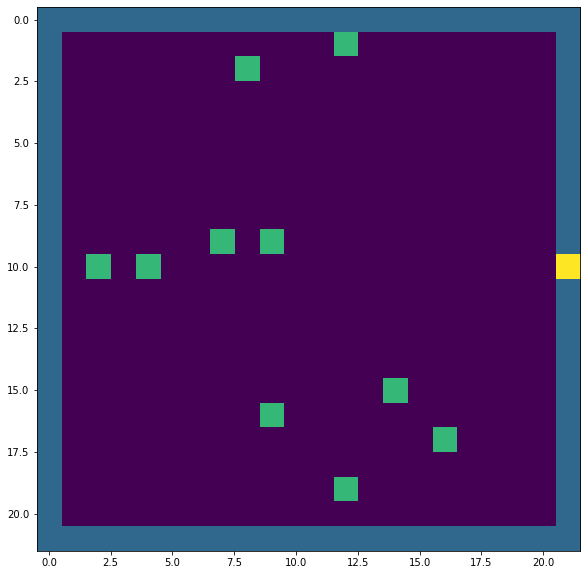

t = 1


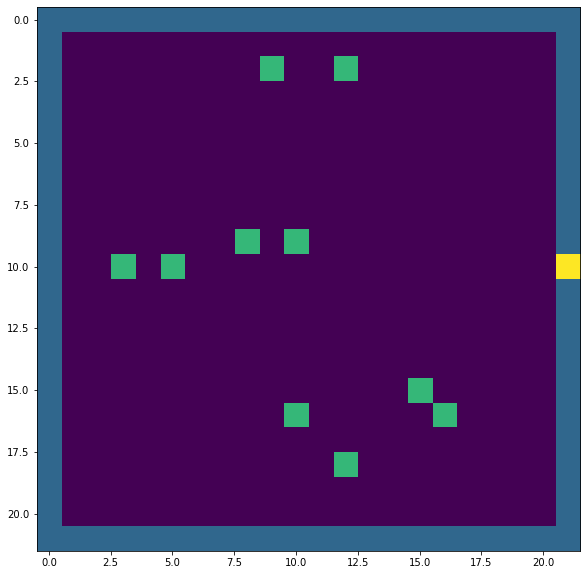

t = 2


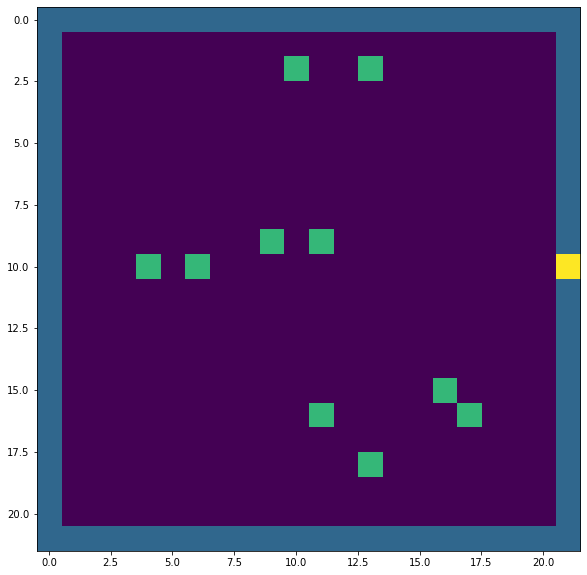

t = 3


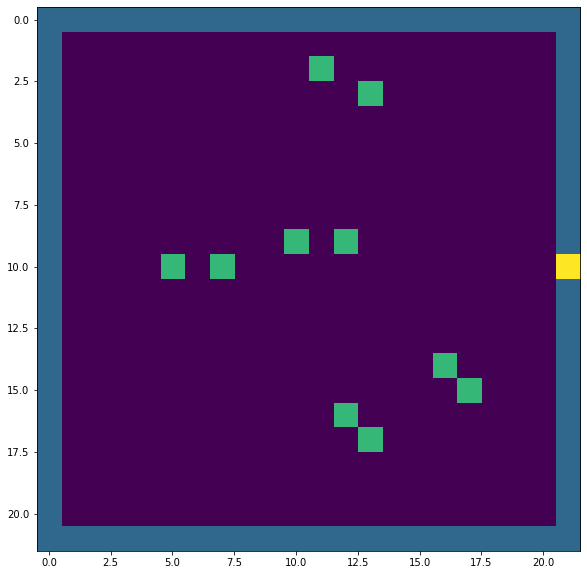

t = 4


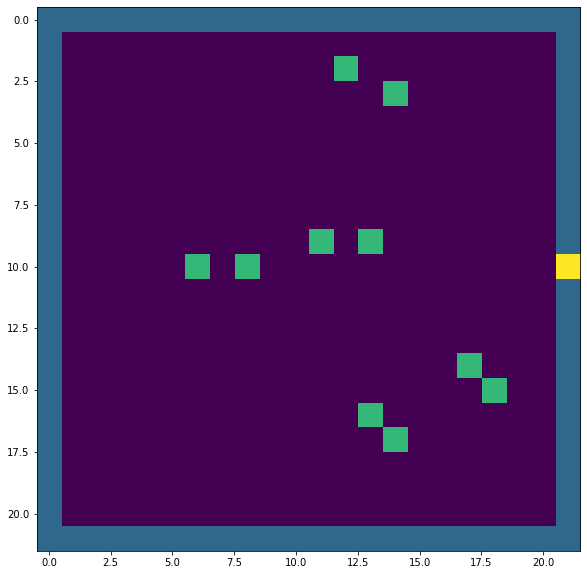

t = 5


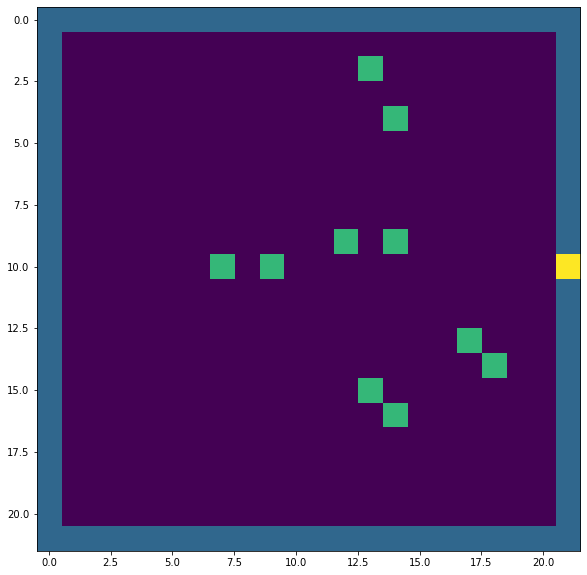

t = 6


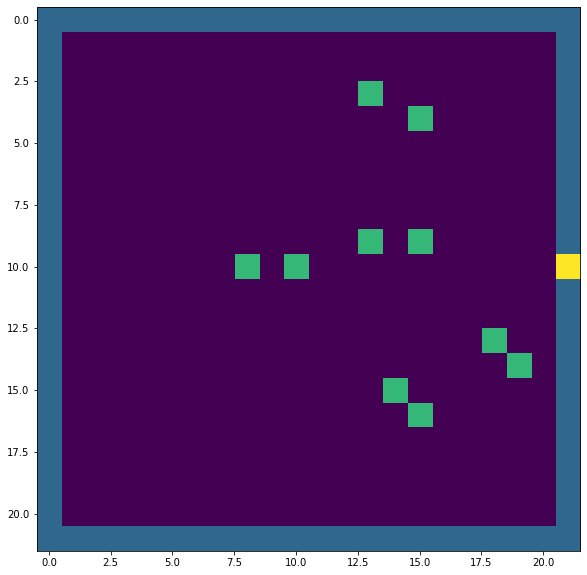

t = 7


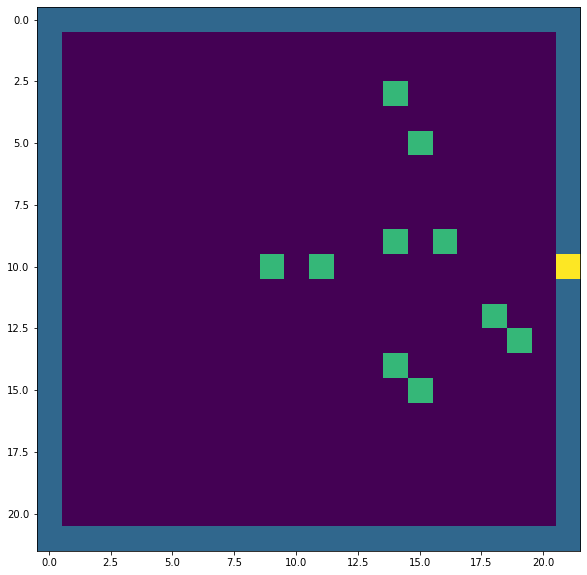

t = 8


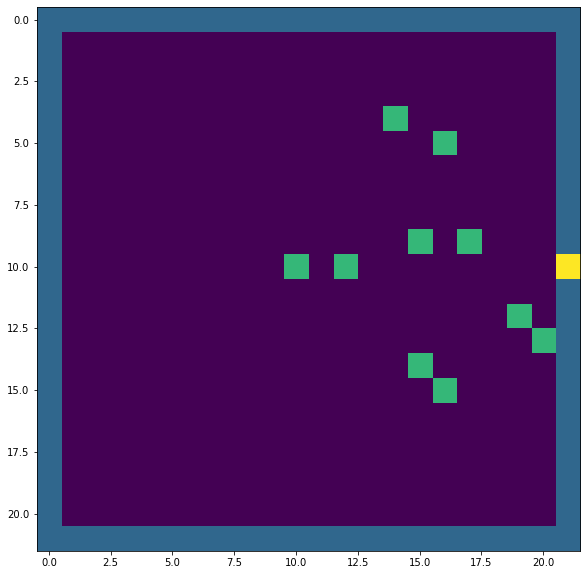

t = 9


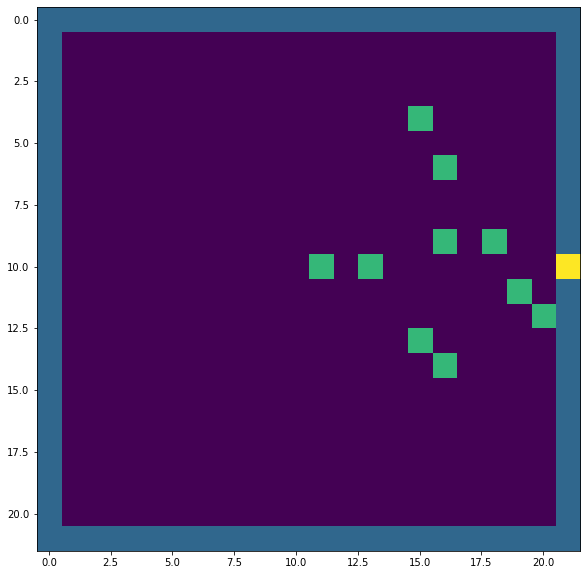

t = 10


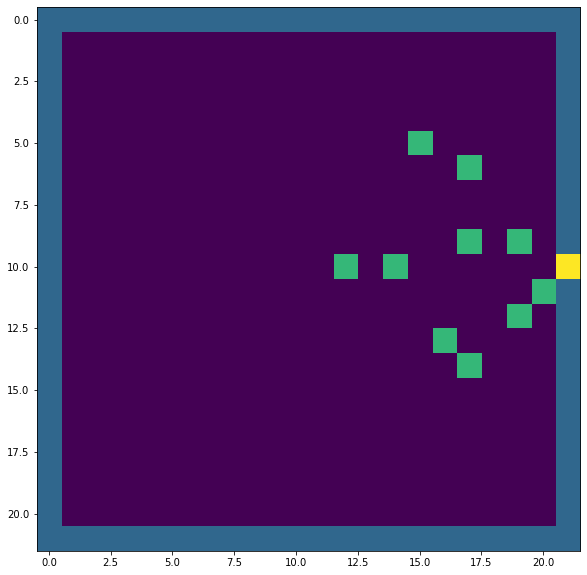

t = 11


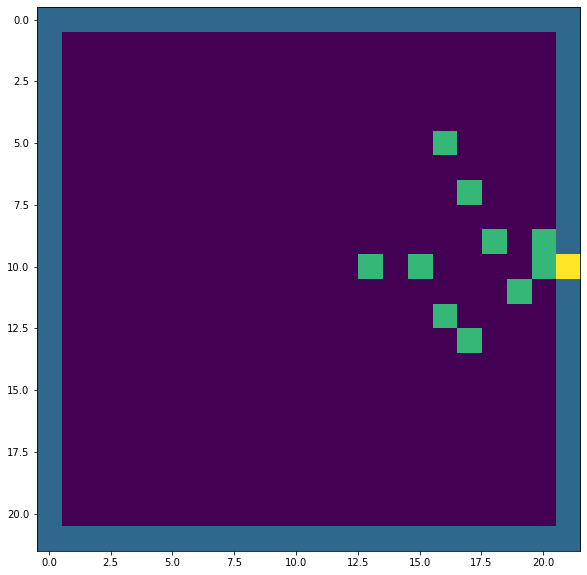

t = 12


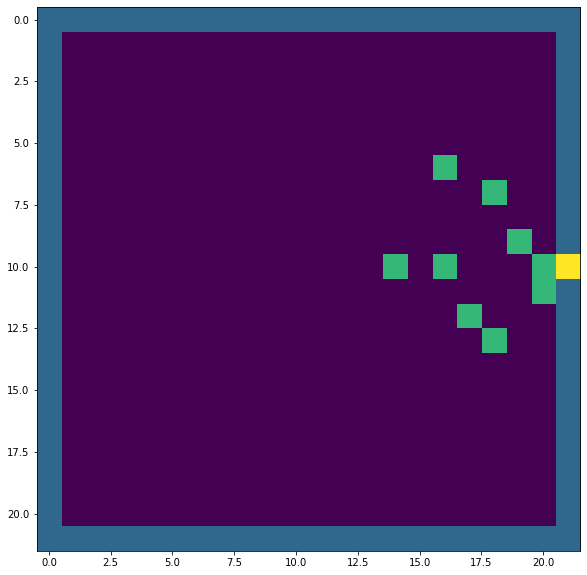

t = 13


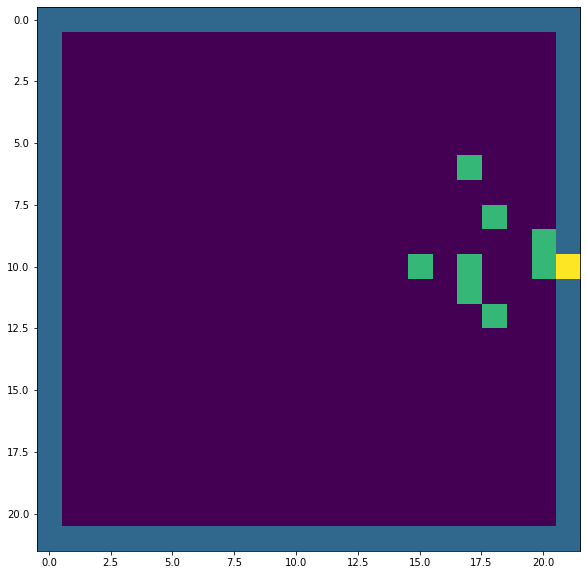

t = 14


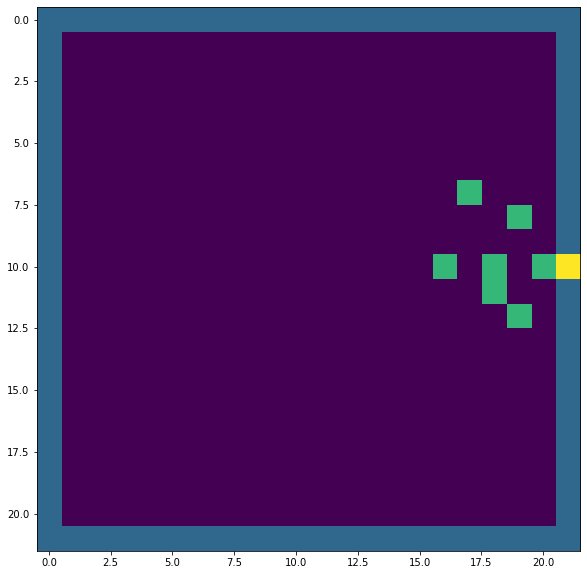

t = 15


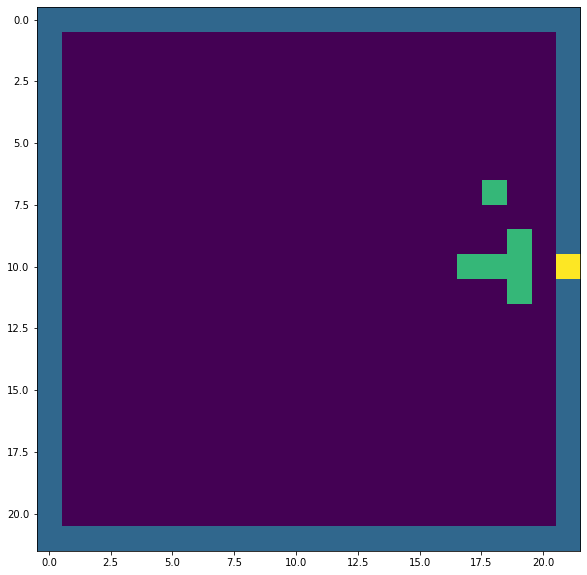

t = 16


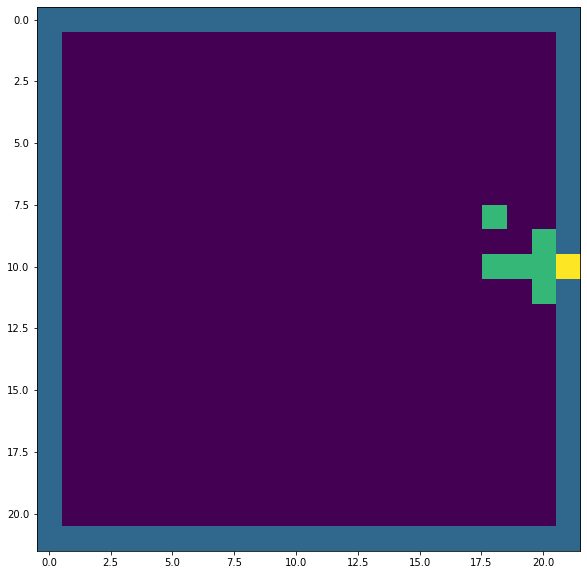

t = 17


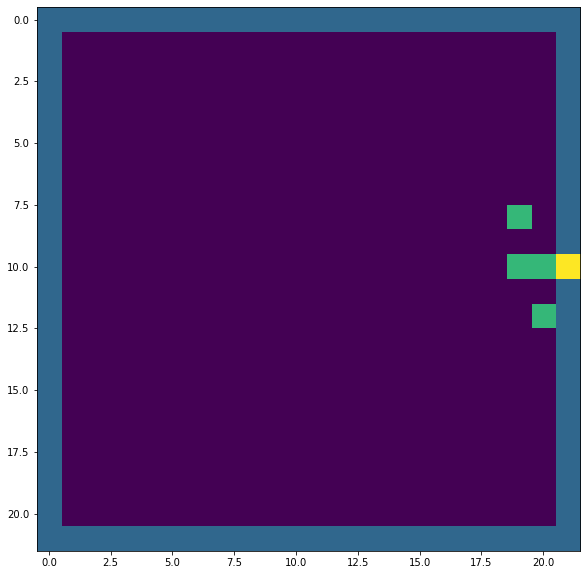

t = 18


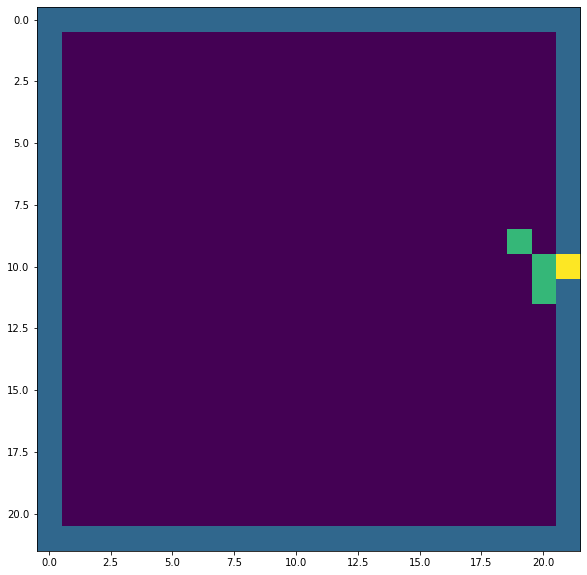

t = 19


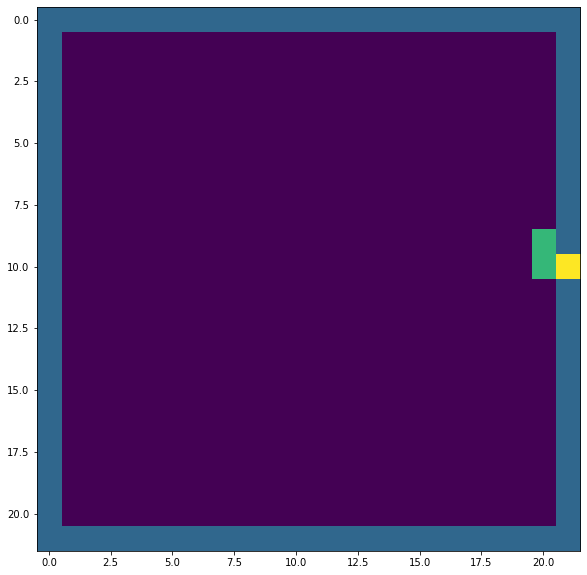

t = 20


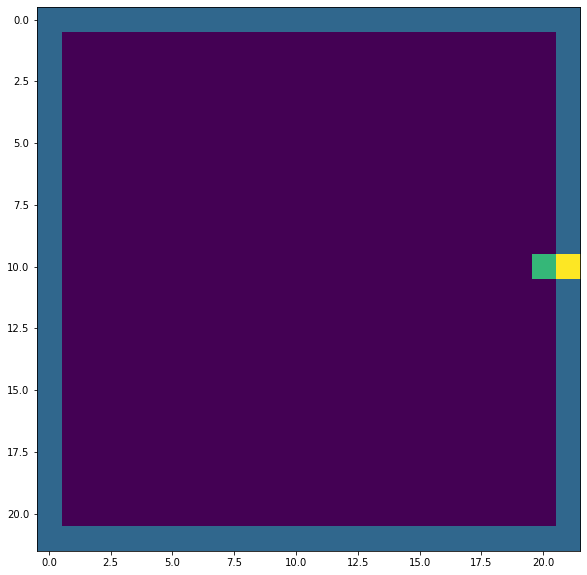

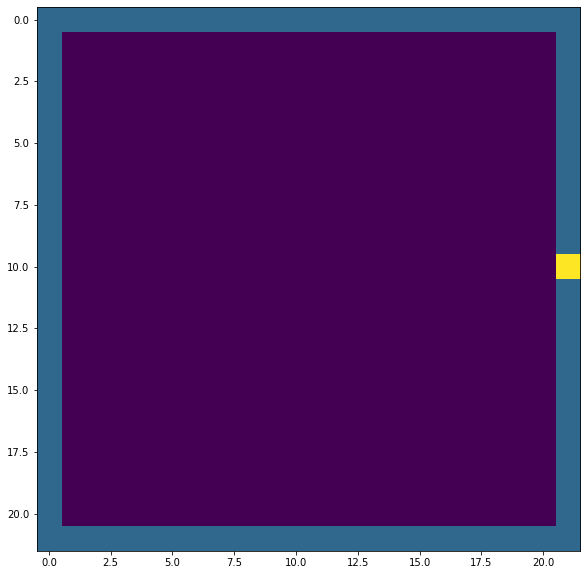

In [12]:
sim_return = simulate_evacuation(20, 10)
num_agents.append(sim_return[0])
ts.append(sim_return[1])

In [13]:
print(num_agents)
print(ts)

[10]
[21]


In [15]:
# create a .gif animation of the previous simulation
from PIL import Image
import glob
 
t = ts[-1]
# Create the frames
frames = []
imgs = []

for j in range(1,t+1):
    imgs.append("images/agents10pic"+str(j)+".png")
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# save into gif
frames[0].save('gifs/evac_simulation_agents10v2.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=50, loop=0)

#### Resulting gif

<img src='gifs/evac_simulation_agents10v2.gif' width=400>

## agents = 50

(12, 21)
t = 0


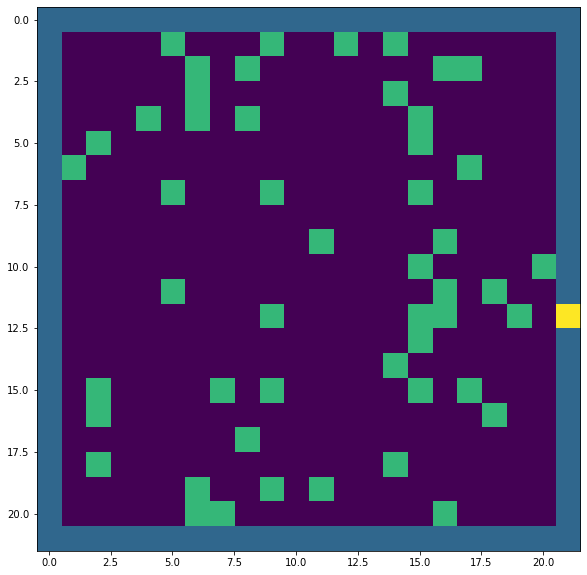

t = 1


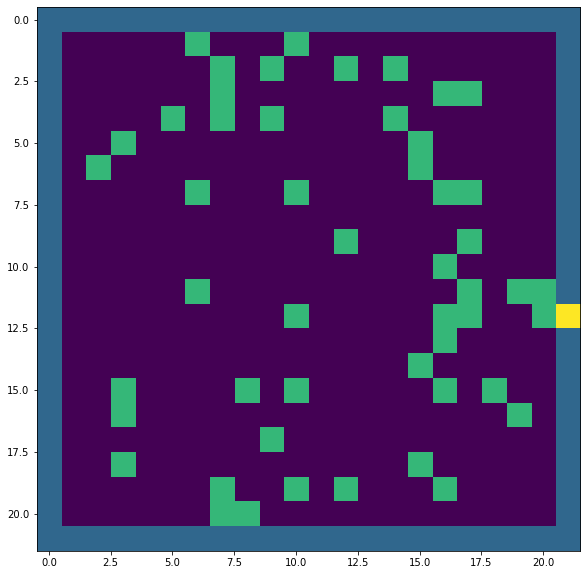

t = 2


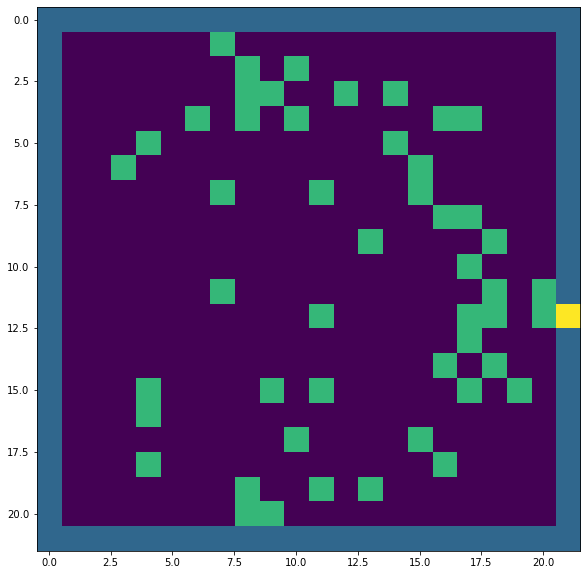

t = 3


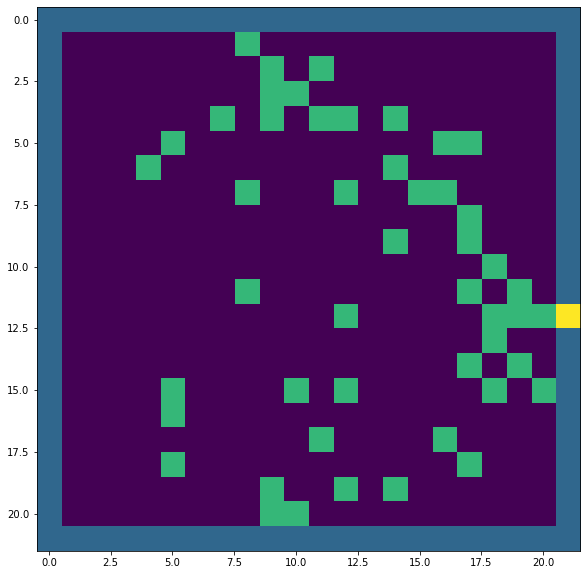

t = 4


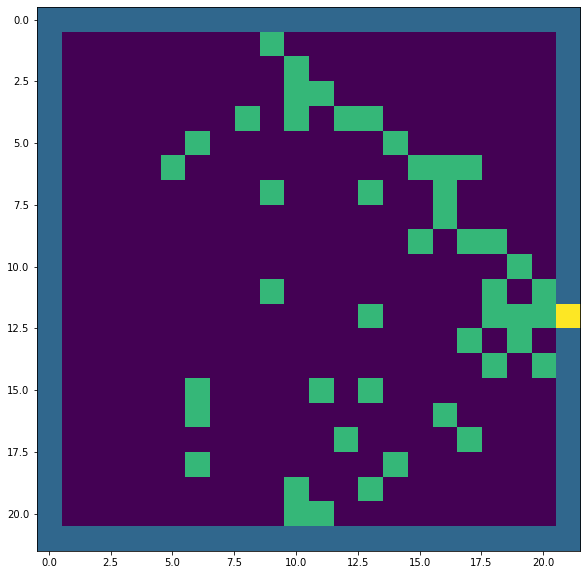

t = 5


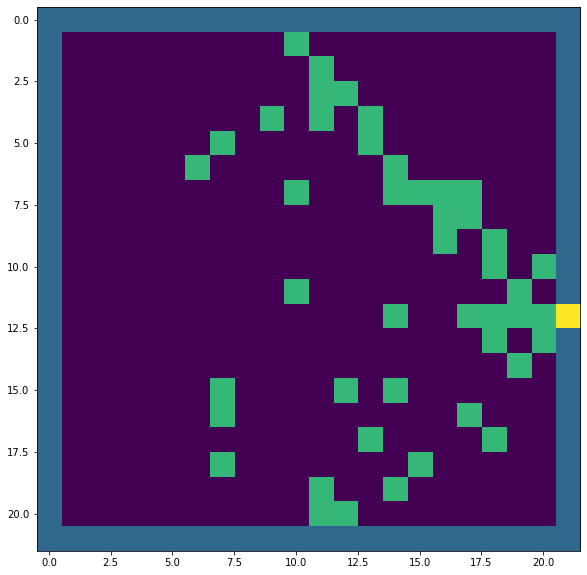

t = 6


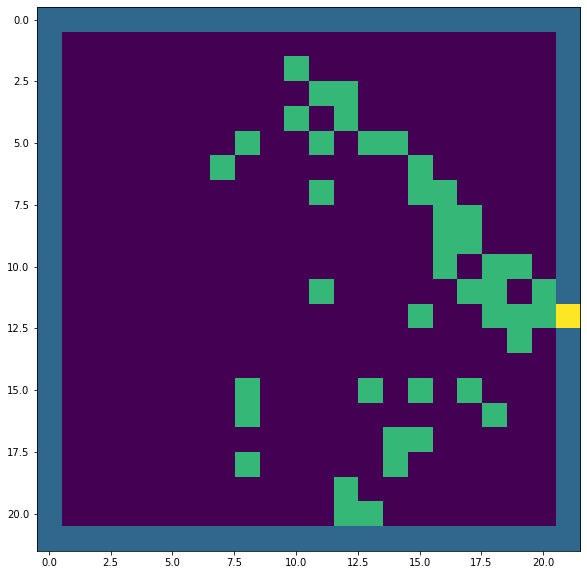

t = 7


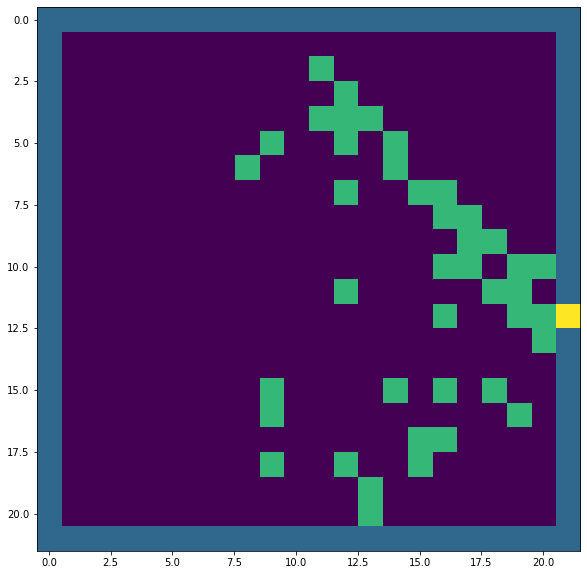

t = 8


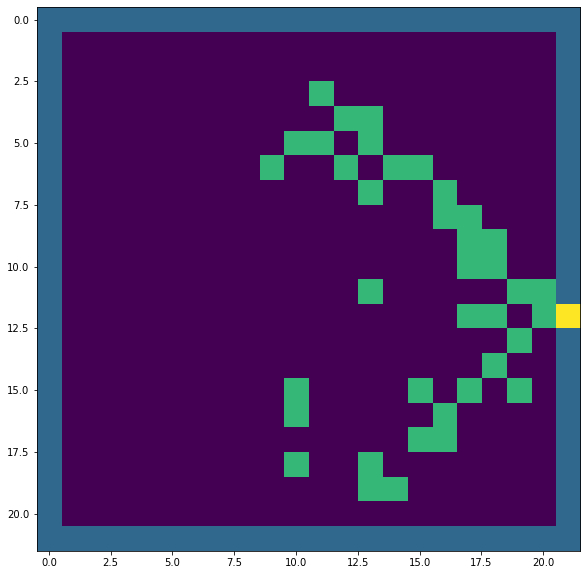

t = 9


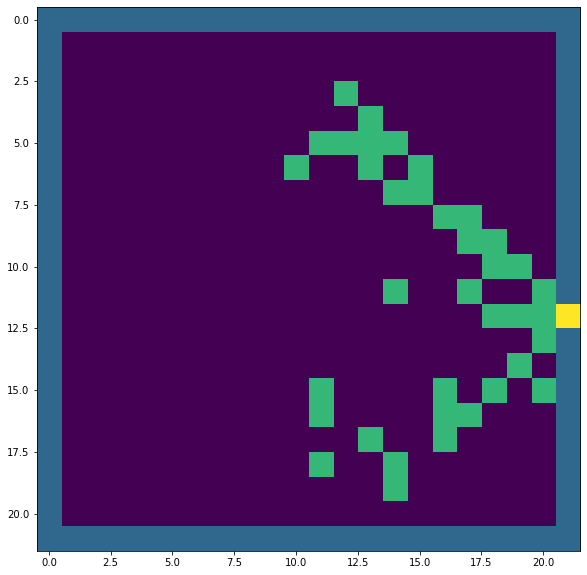

t = 10


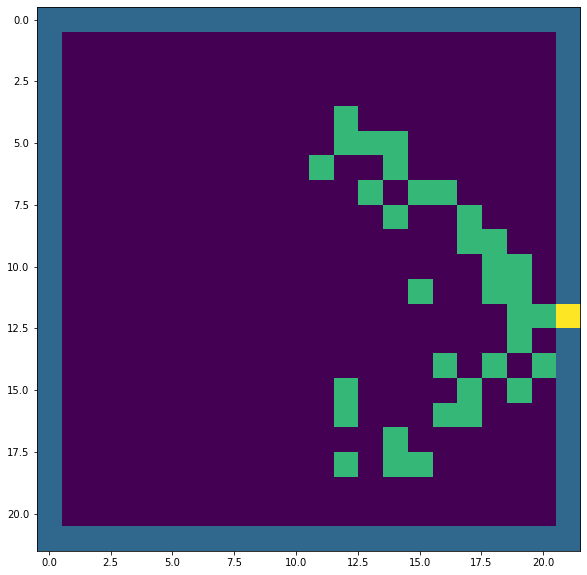

t = 11


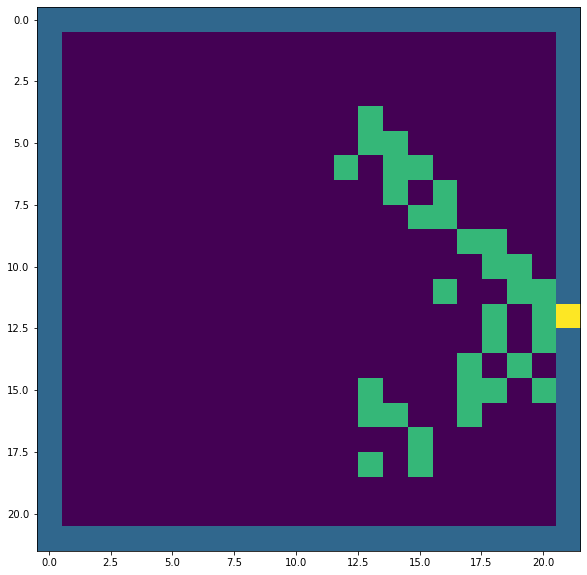

t = 12


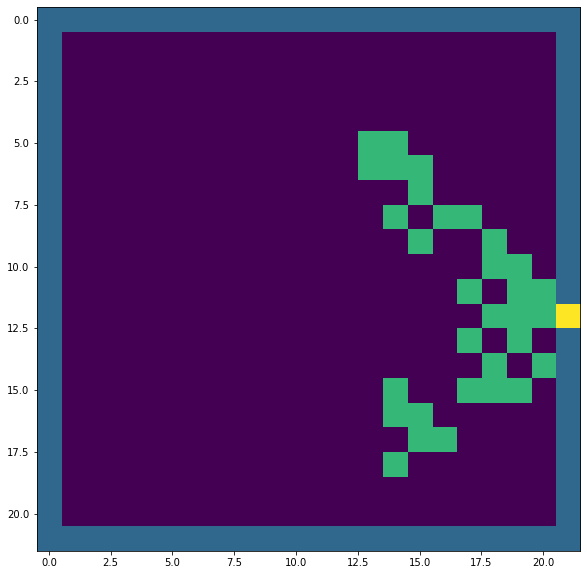

t = 13


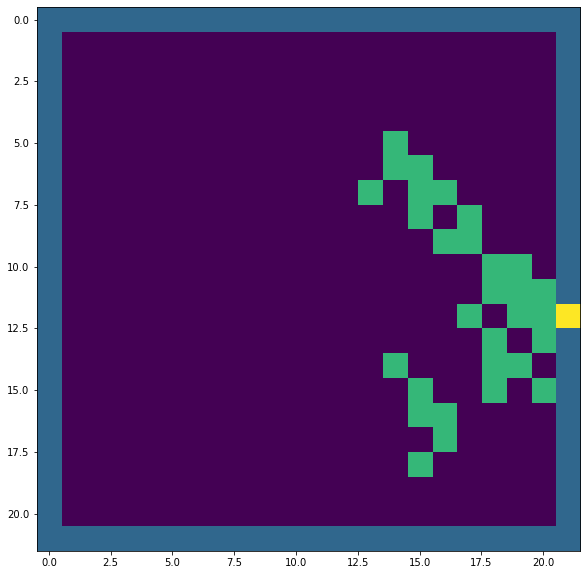

t = 14


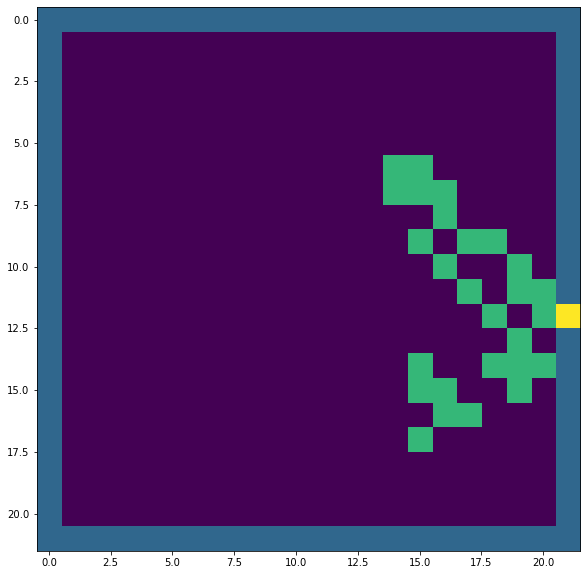

t = 15


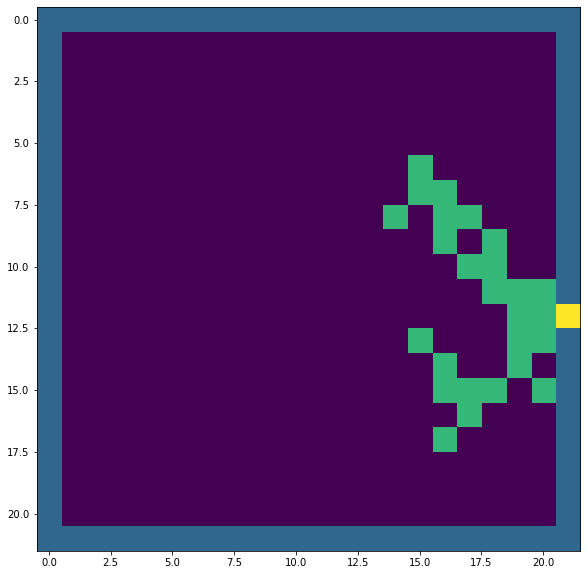

t = 16


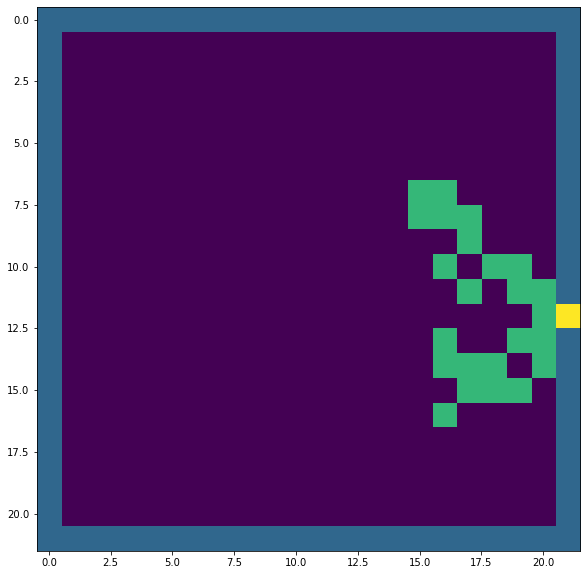

t = 17


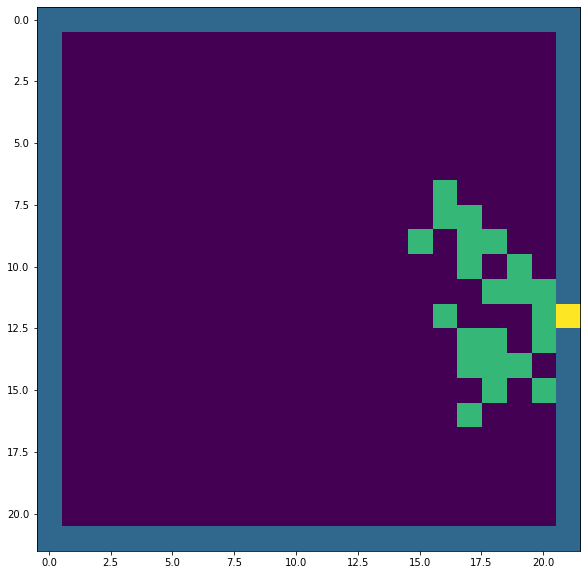

t = 18


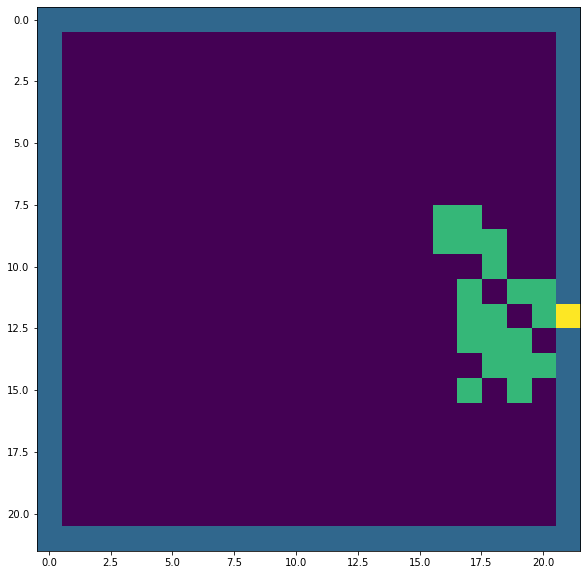

t = 19


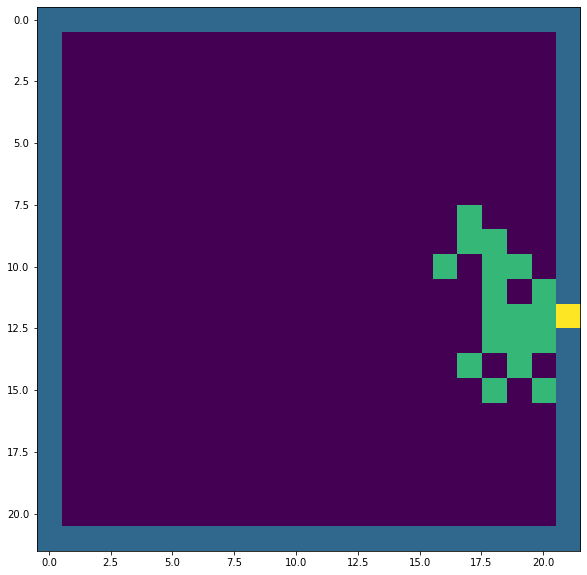

t = 20


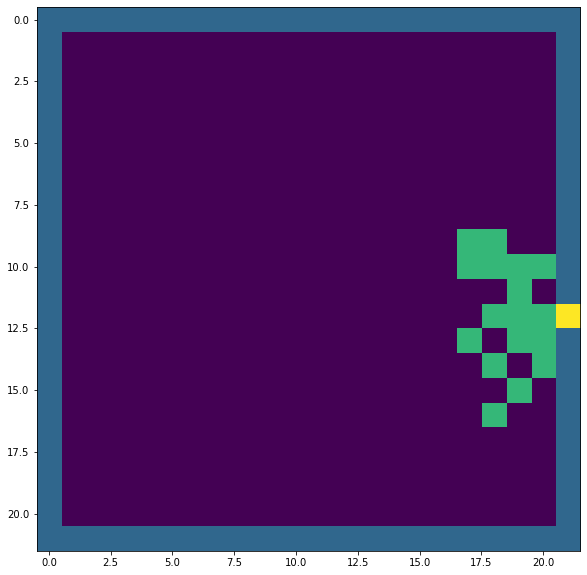

t = 21


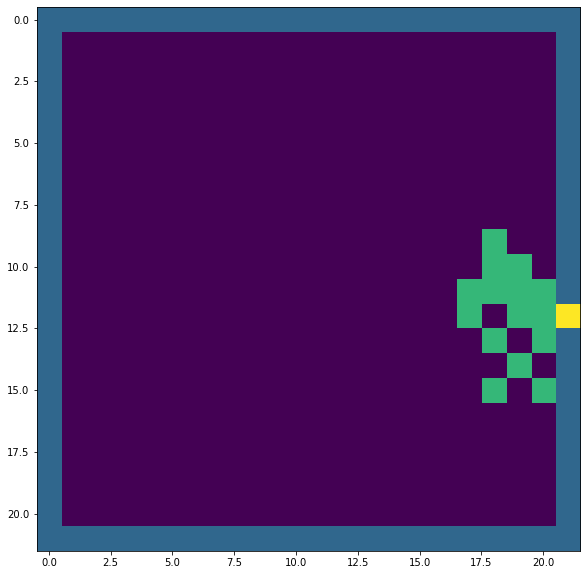

t = 22


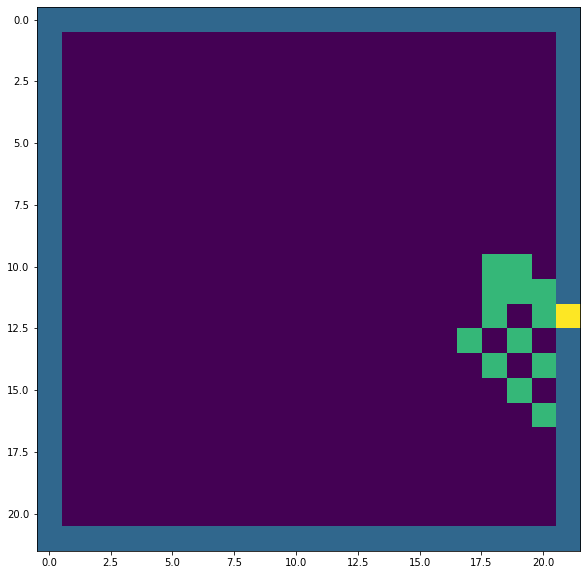

t = 23


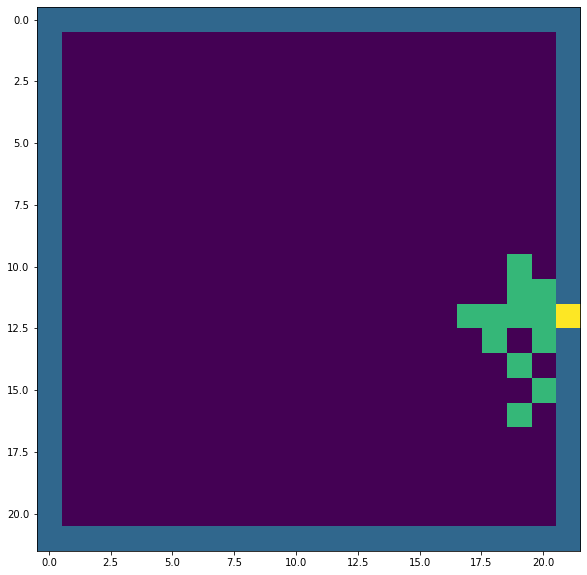

t = 24


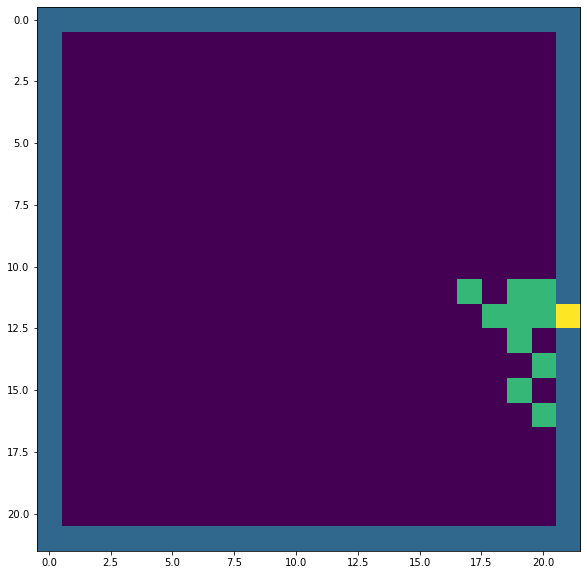

t = 25


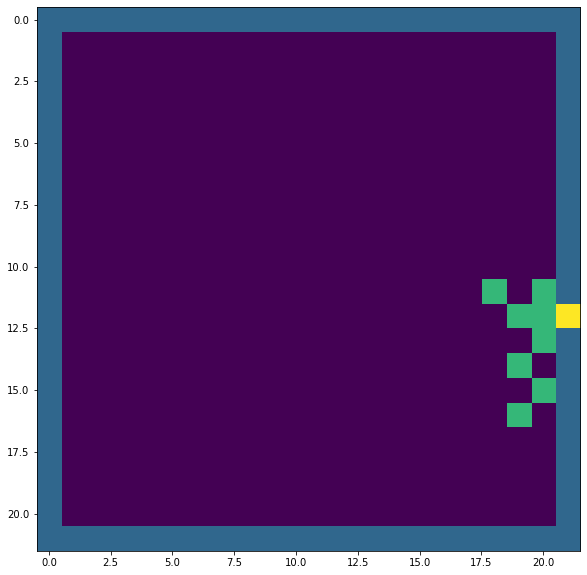

t = 26


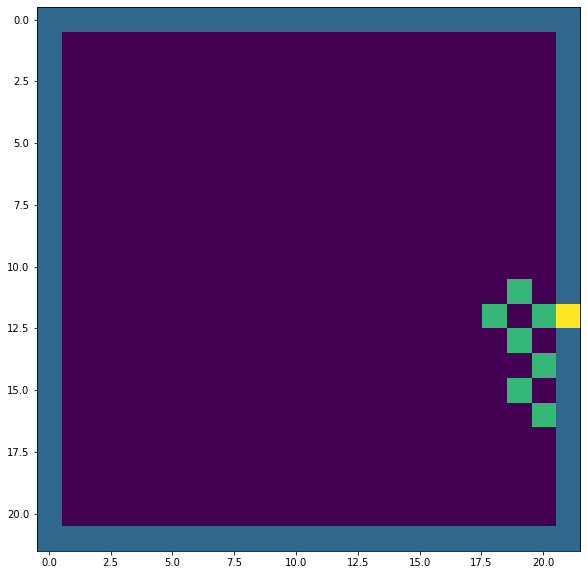

t = 27


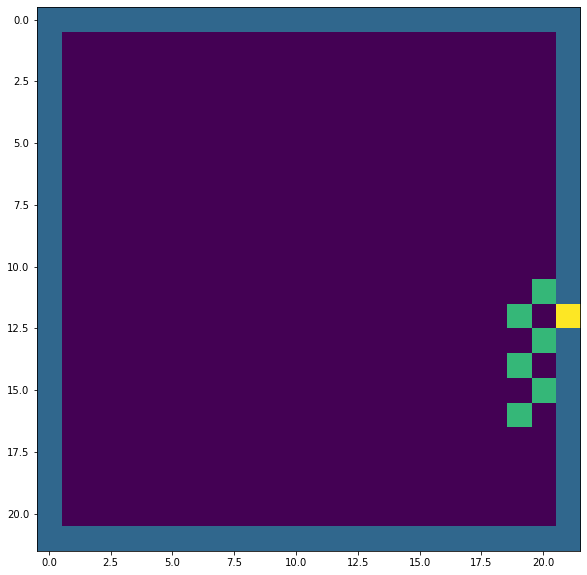

t = 28


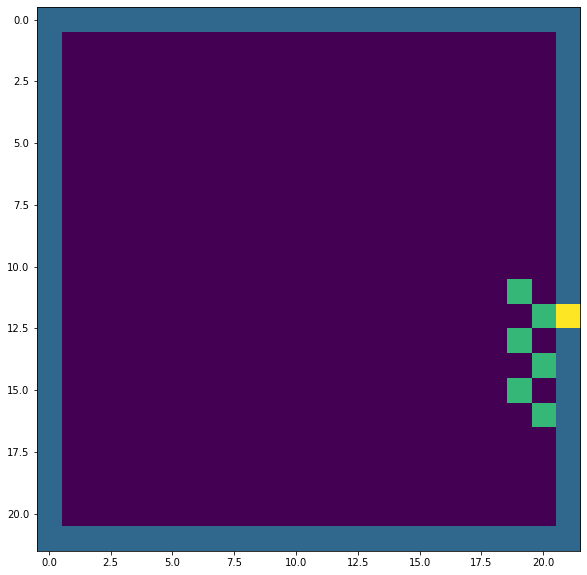

t = 29


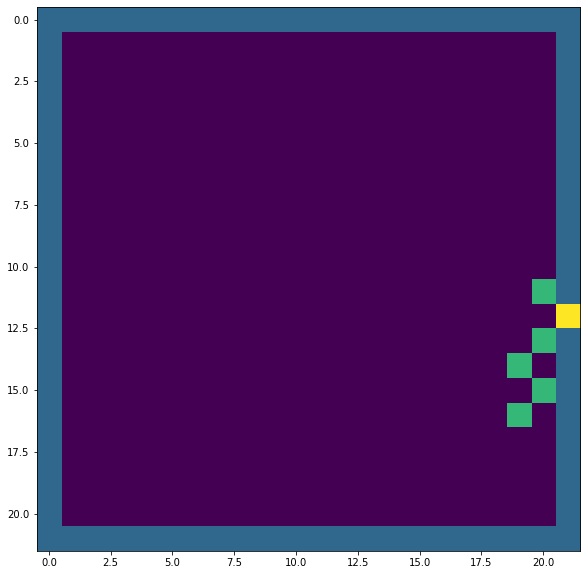

t = 30


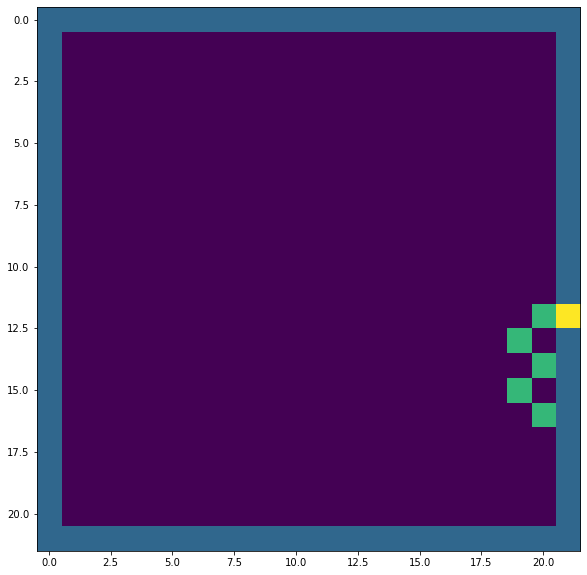

t = 31


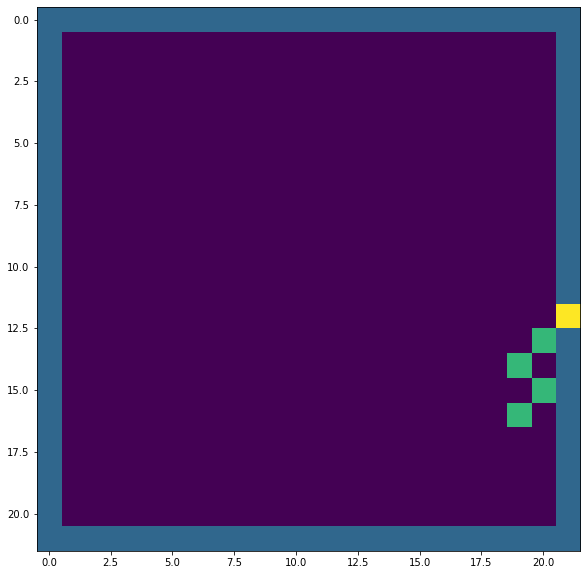

t = 32


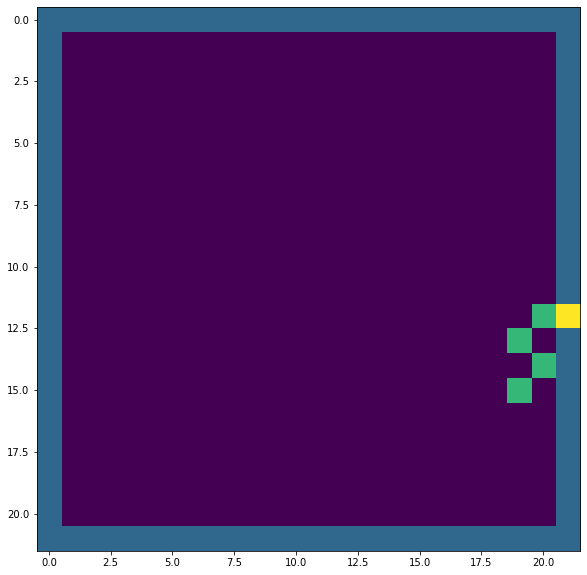

t = 33


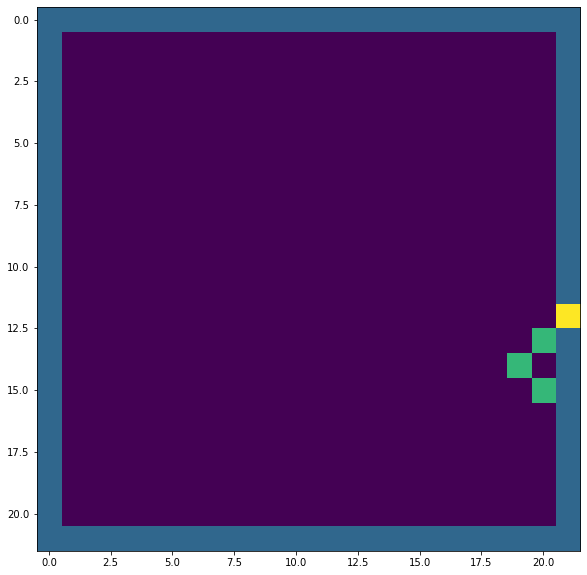

t = 34


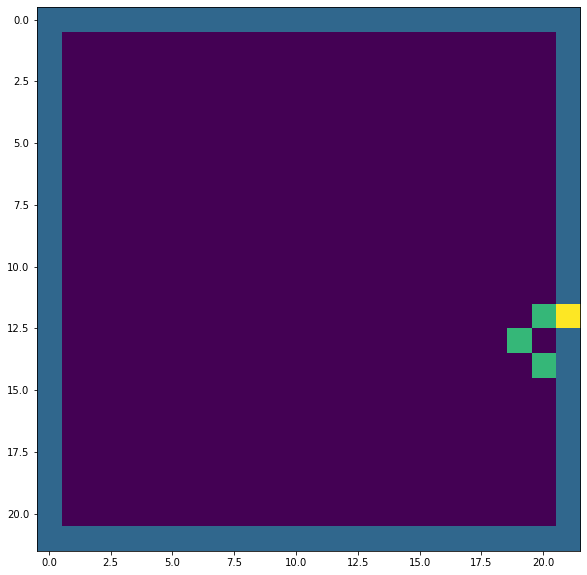

t = 35


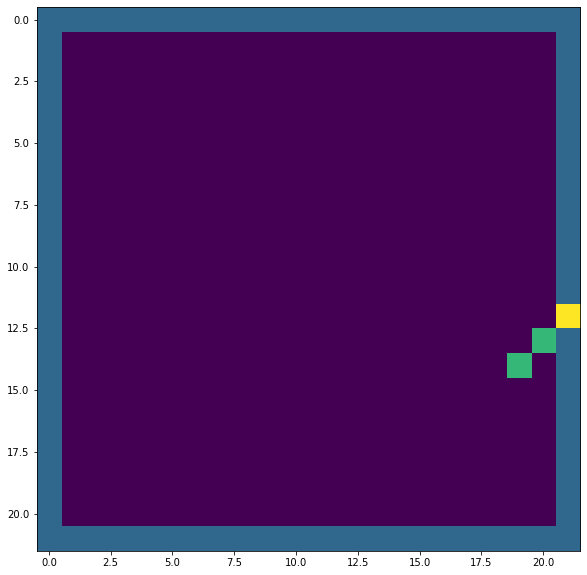

t = 36


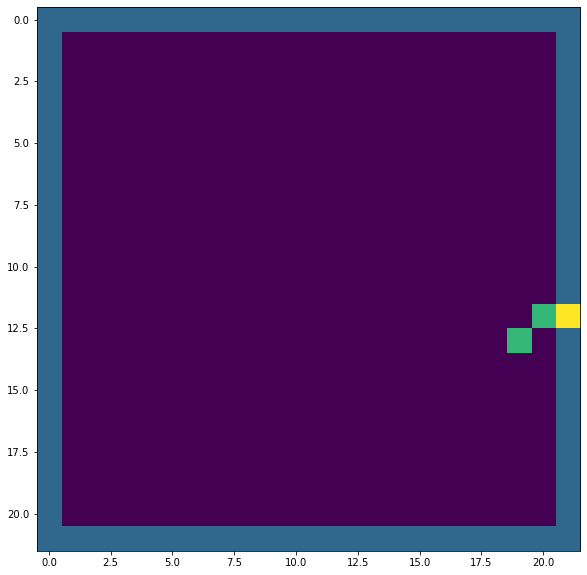

t = 37


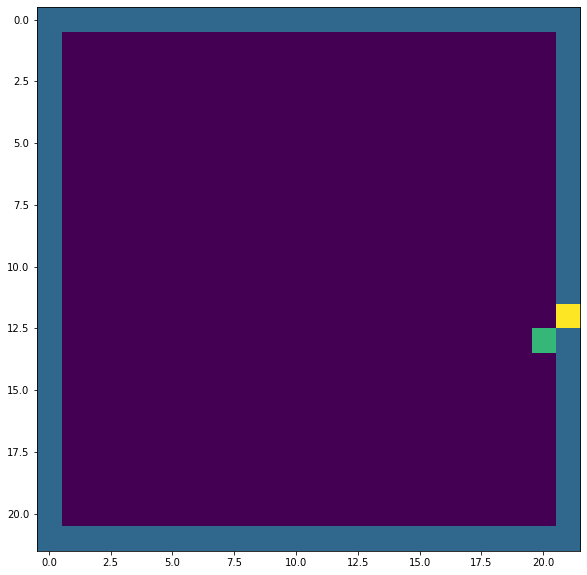

t = 38


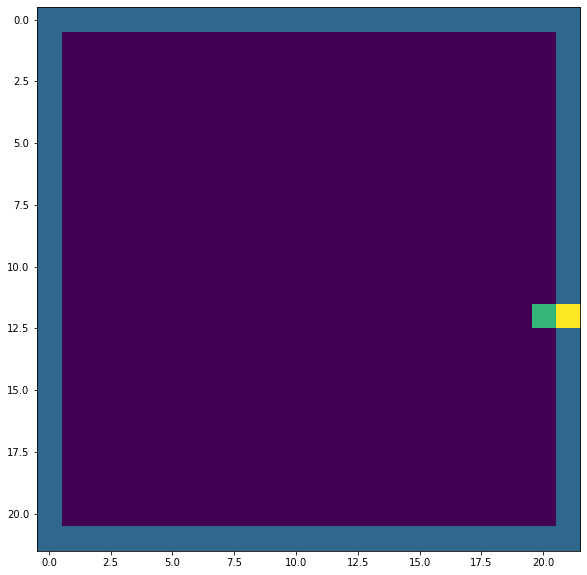

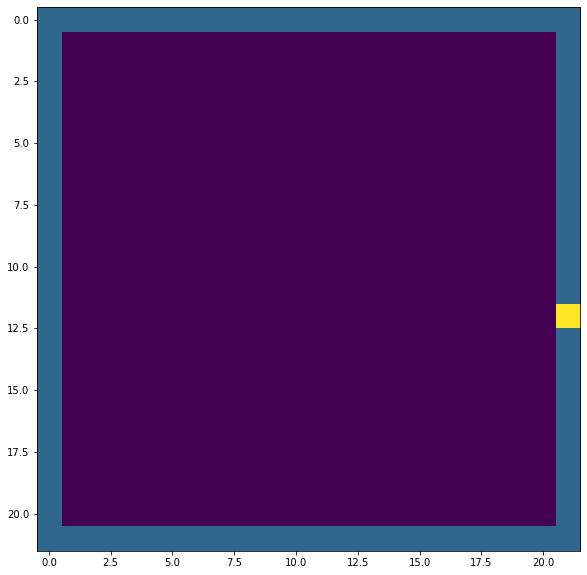

In [16]:
sim_return = simulate_evacuation(20, 50)
num_agents.append(sim_return[0])
ts.append(sim_return[1])

In [17]:
print(num_agents)
print(ts)

[10, 50]
[21, 39]


In [19]:
t = ts[-1]

# Create the frames
frames = []
imgs = []

for j in range(1,t+1):
    imgs.append("images/agents50pic"+str(j)+".png")

with imageio.get_writer('gifs/evac_simulation_agents50v3.gif', mode='I') as writer:
    for filename in imgs:
        image = imageio.imread(filename)
        writer.append_data(image)

<img src='gifs/evac_simulation_agents50v3.gif' width=400>

## agents = 100

(21, 19)
t = 0


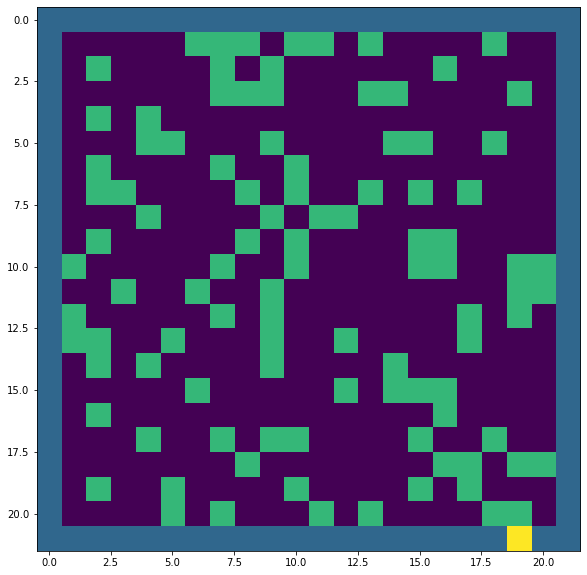

t = 1


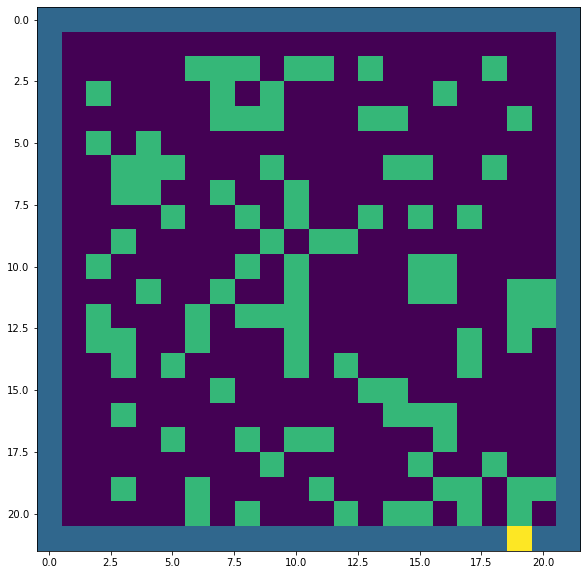

t = 2


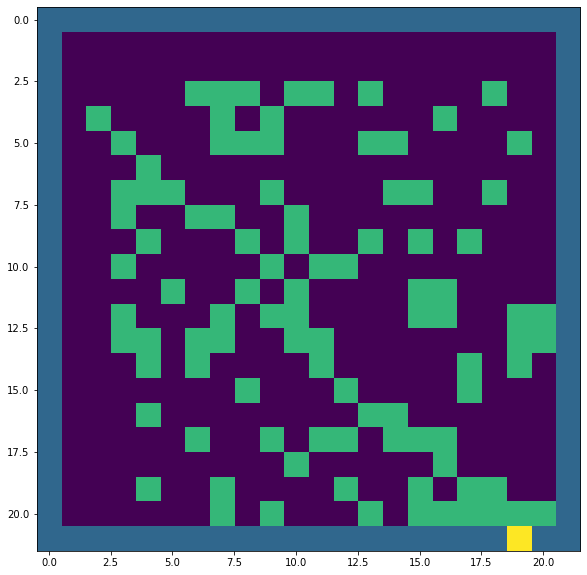

t = 3


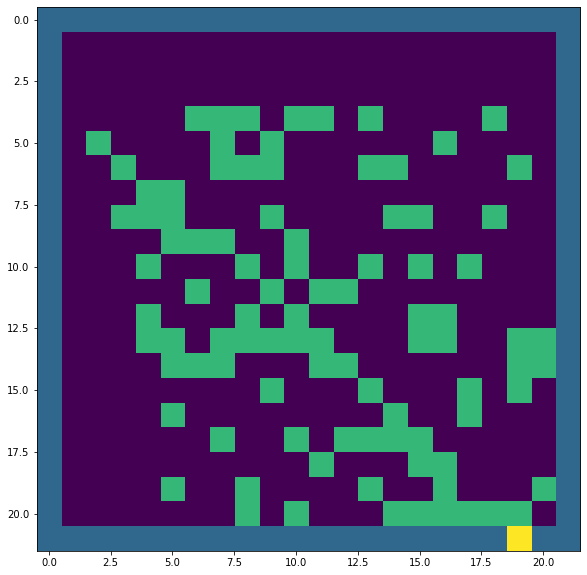

t = 4


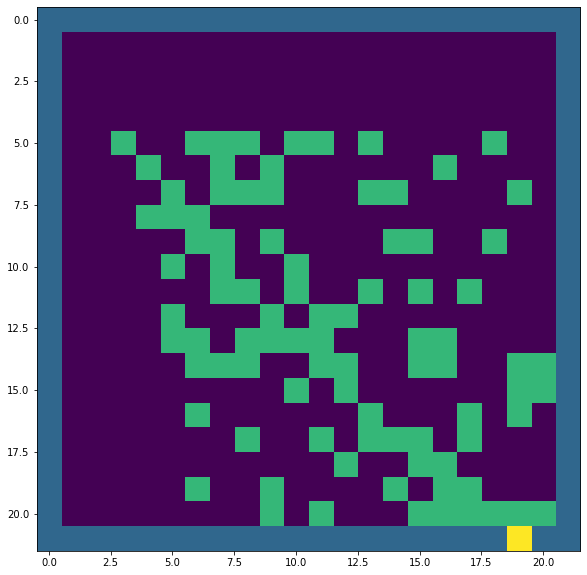

t = 5


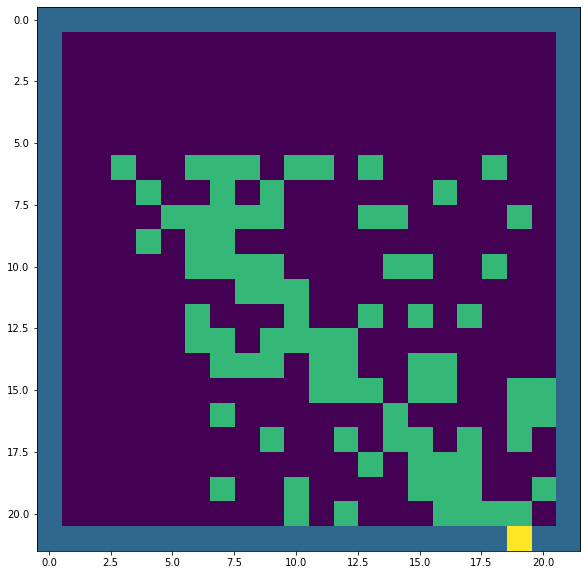

t = 6


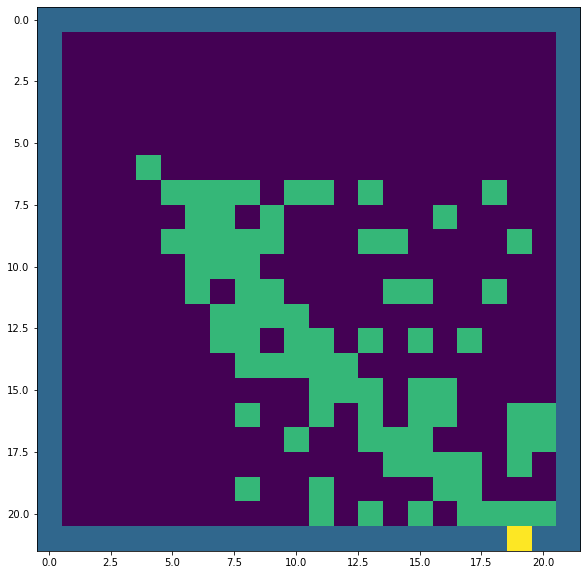

t = 7


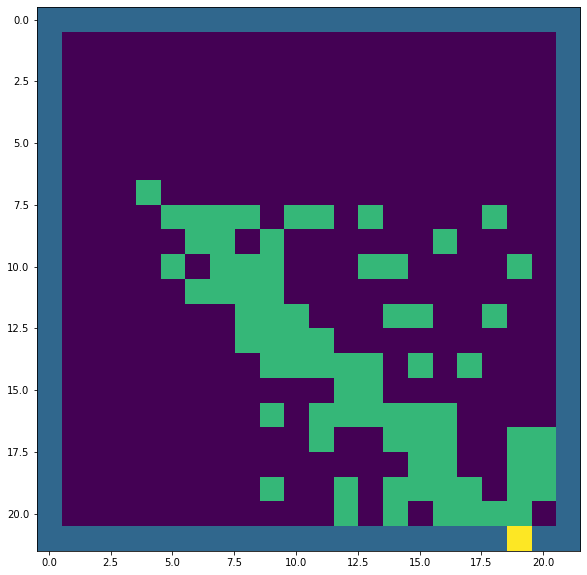

t = 8


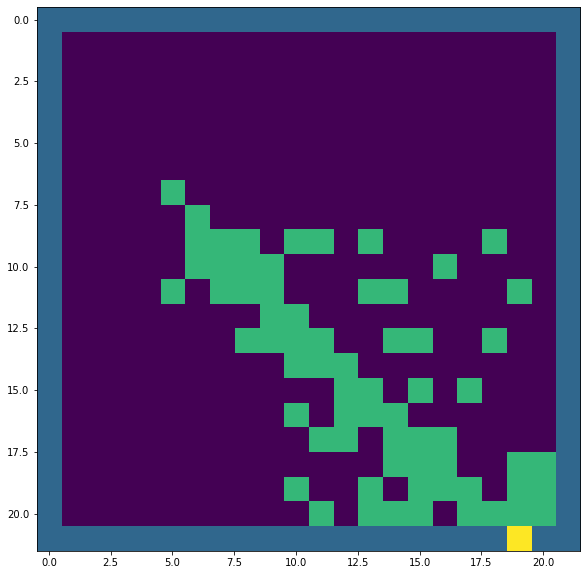

t = 9


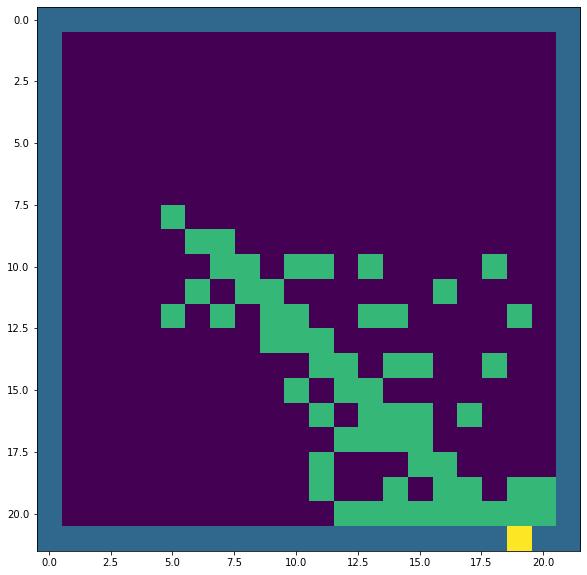

t = 10


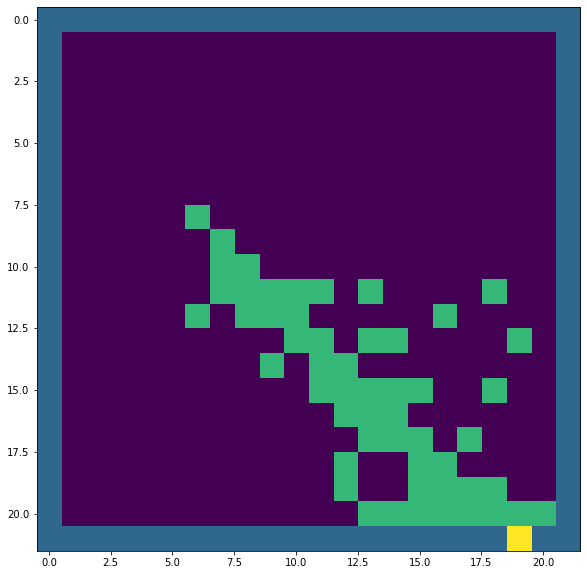

t = 11


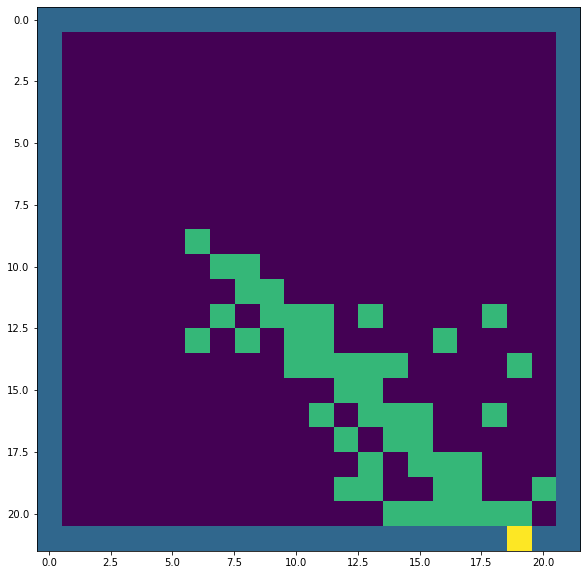

t = 12


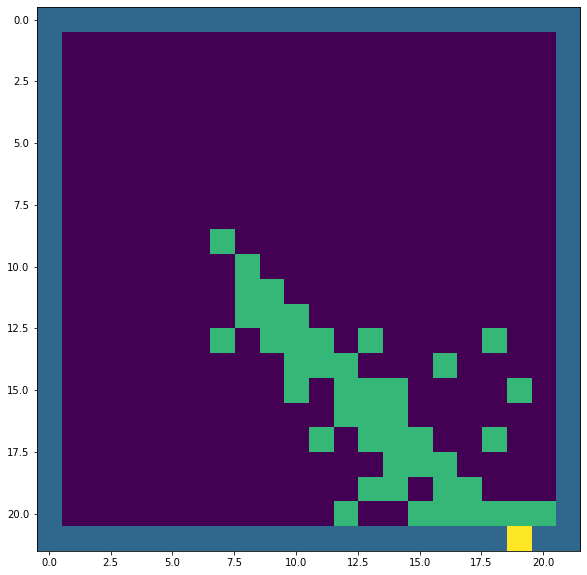

t = 13


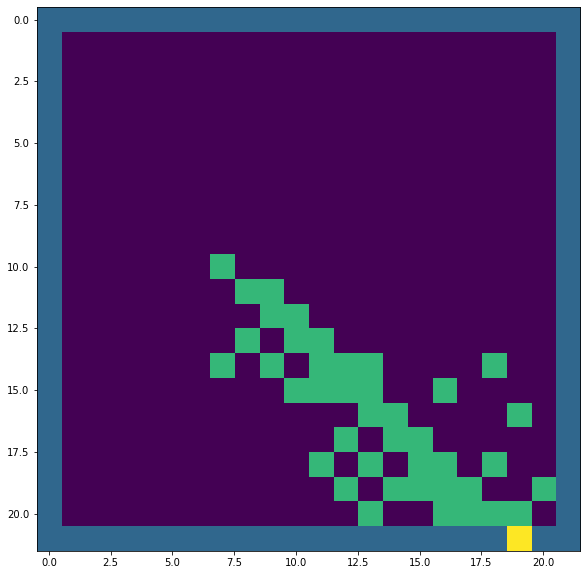

t = 14


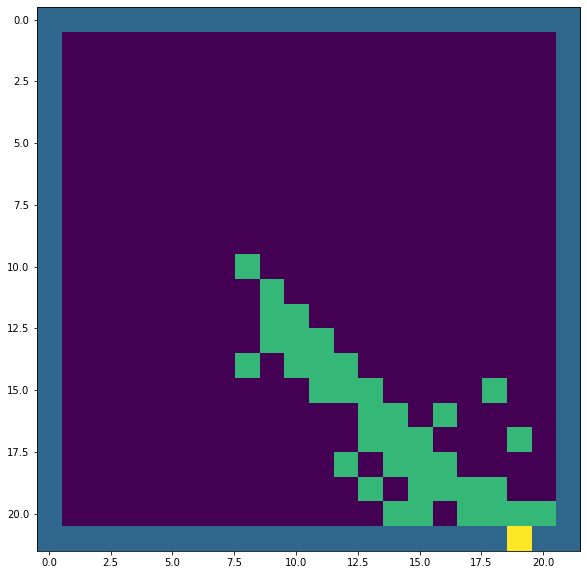

t = 15


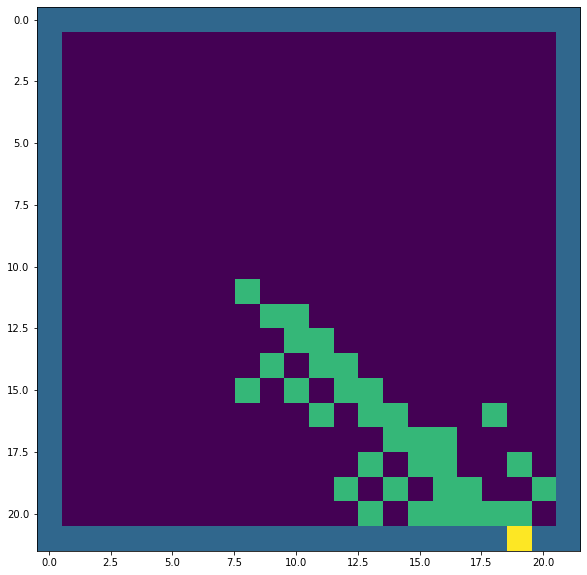

t = 16


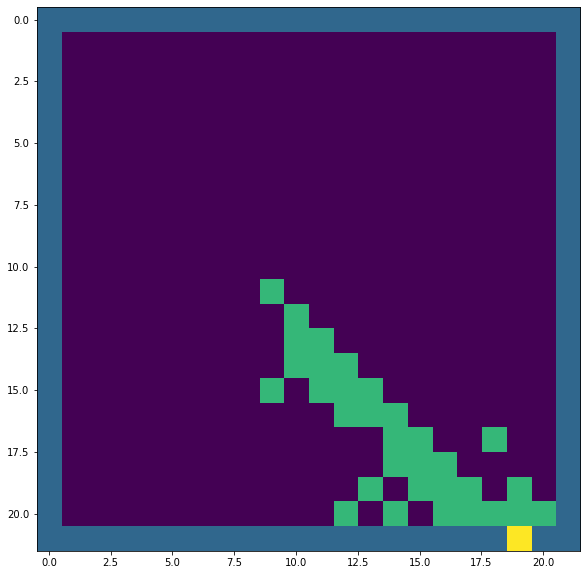

t = 17


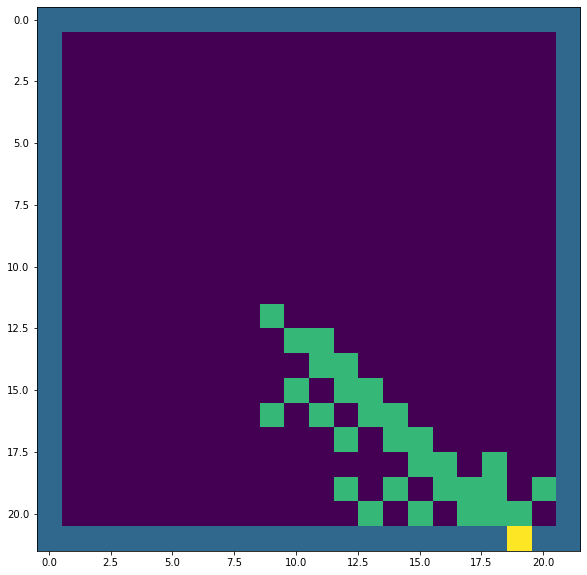

t = 18


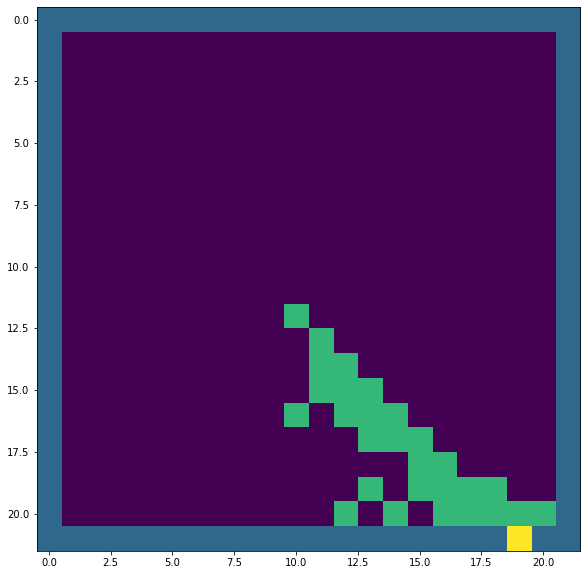

t = 19


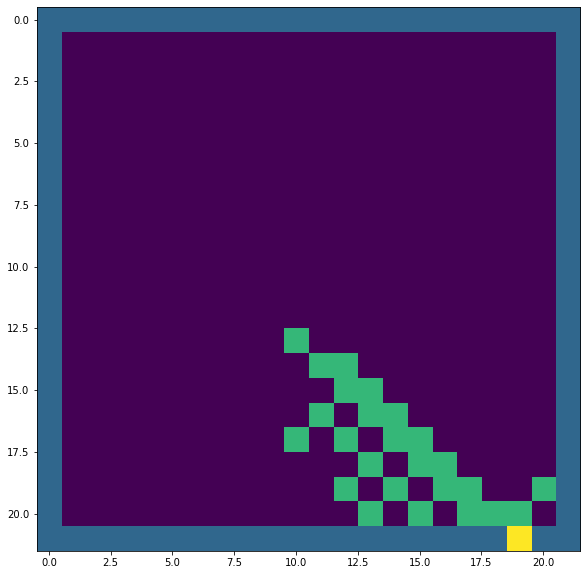

t = 20


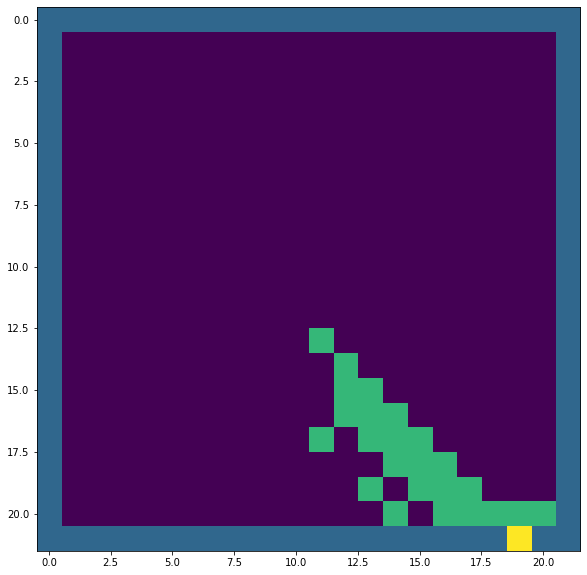

t = 21


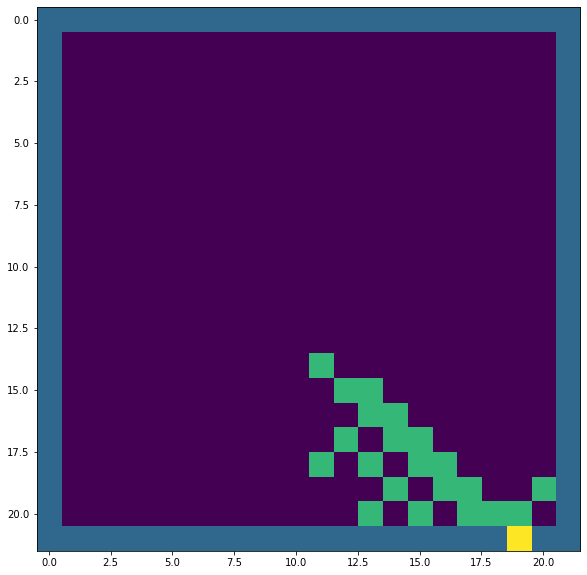

t = 22


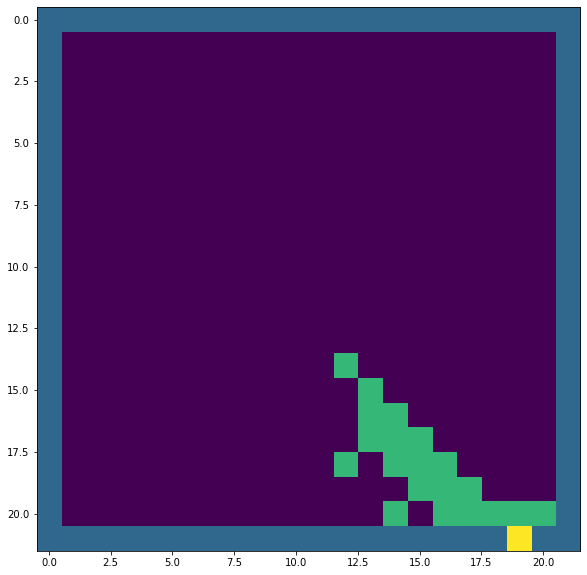

t = 23


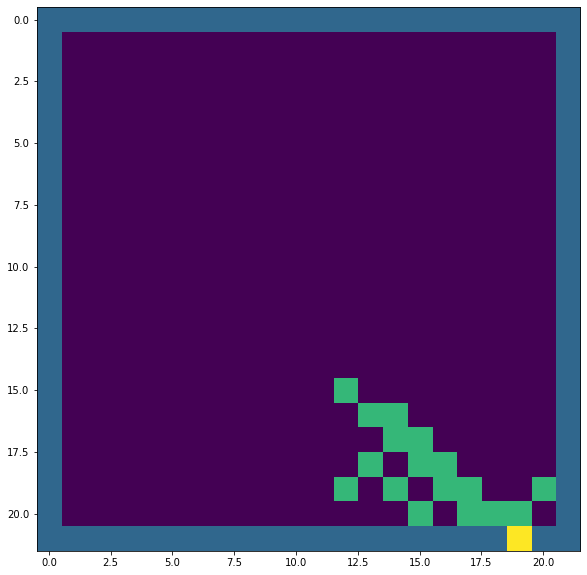

t = 24


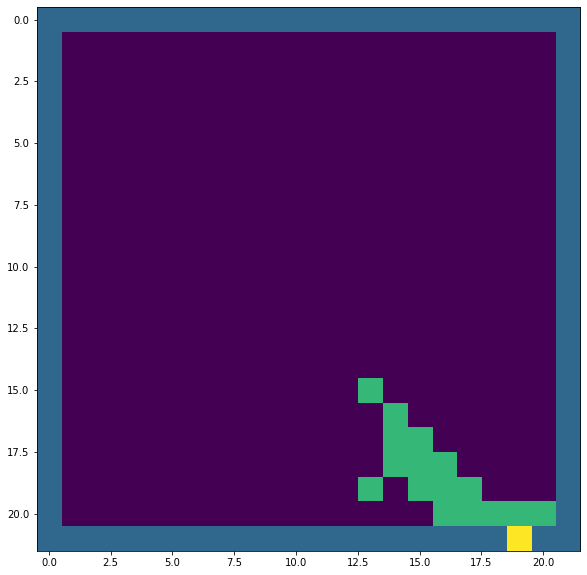

t = 25


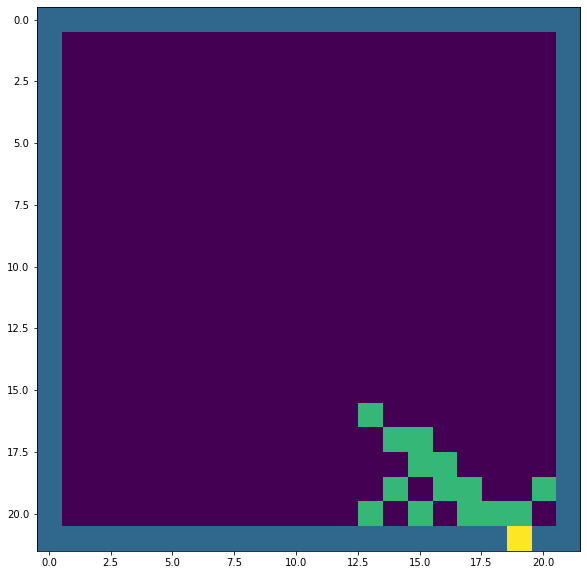

t = 26


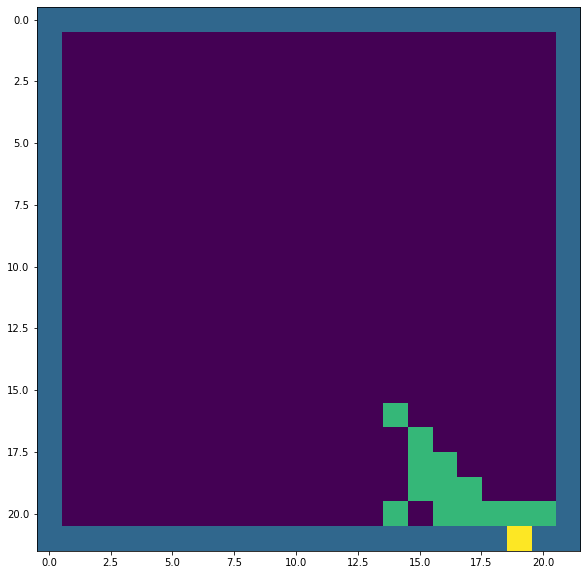

t = 27


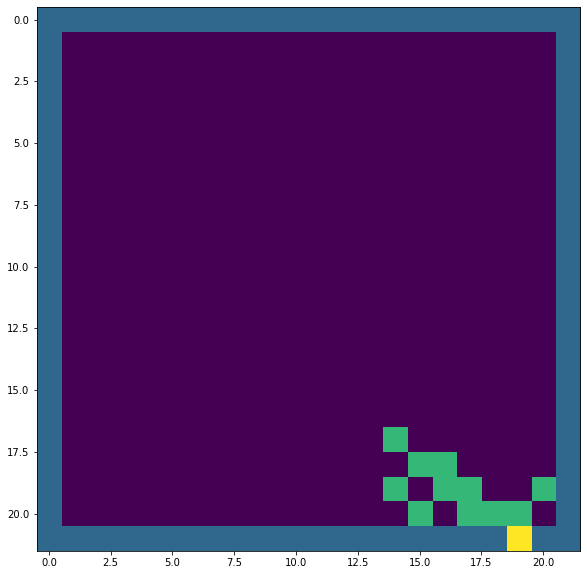

t = 28


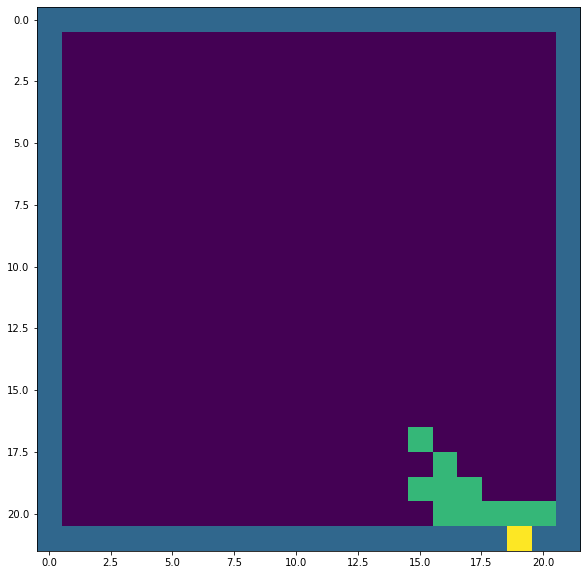

t = 29


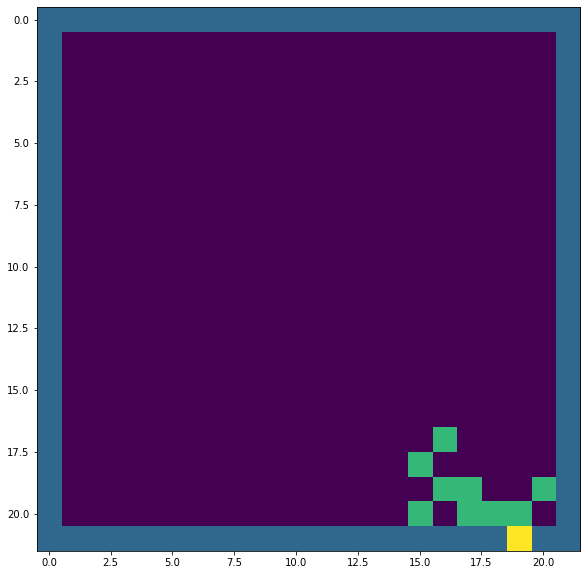

t = 30


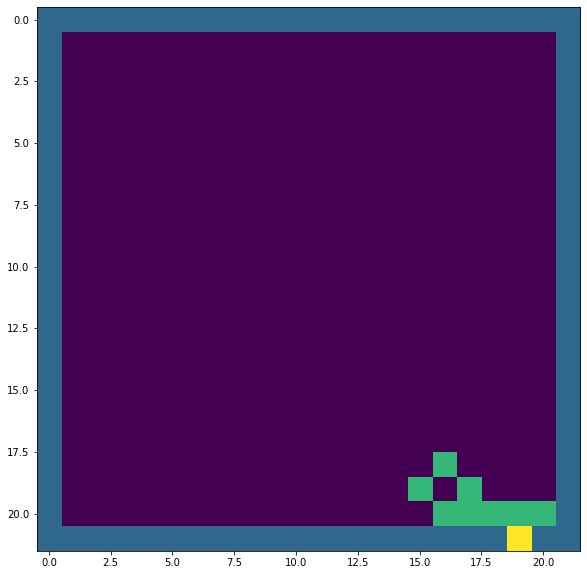

t = 31


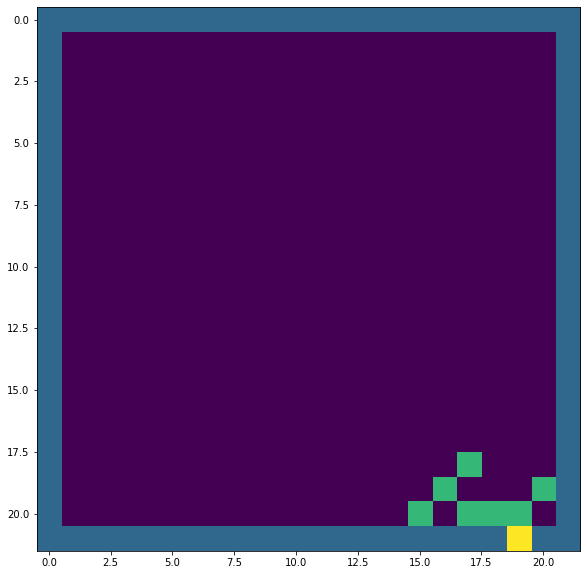

t = 32


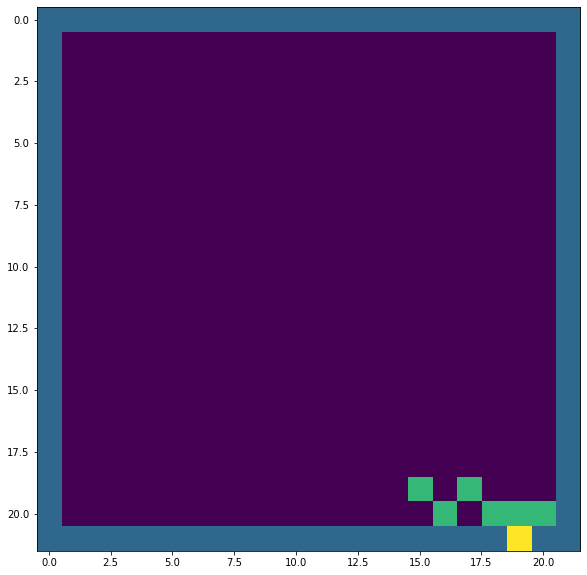

t = 33


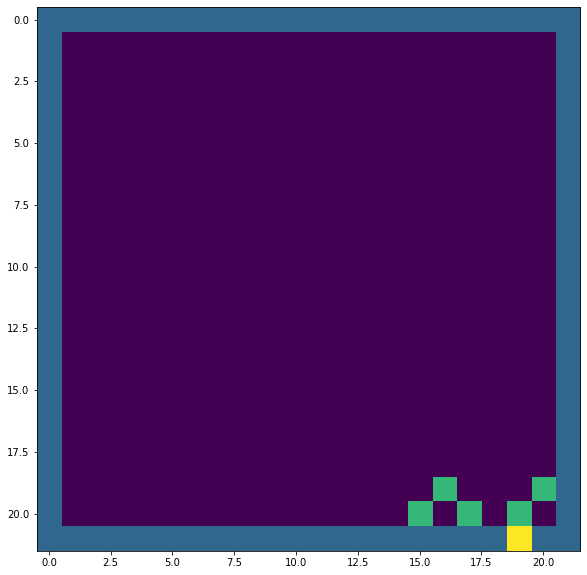

t = 34


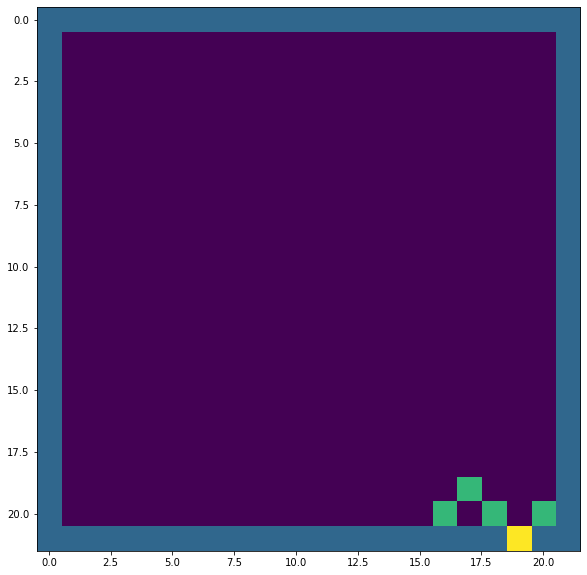

t = 35


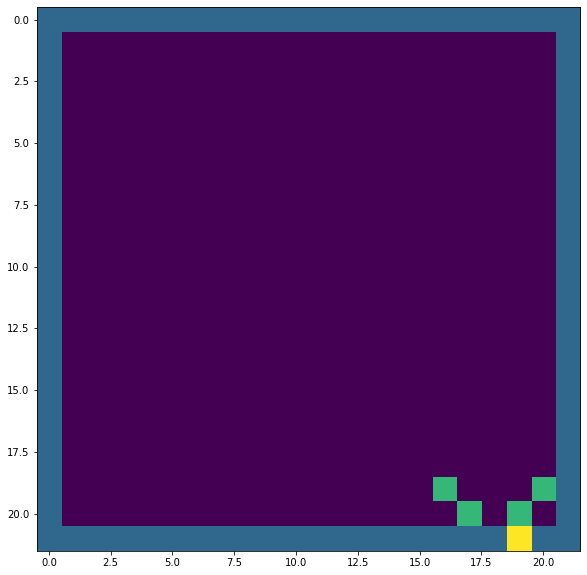

t = 36


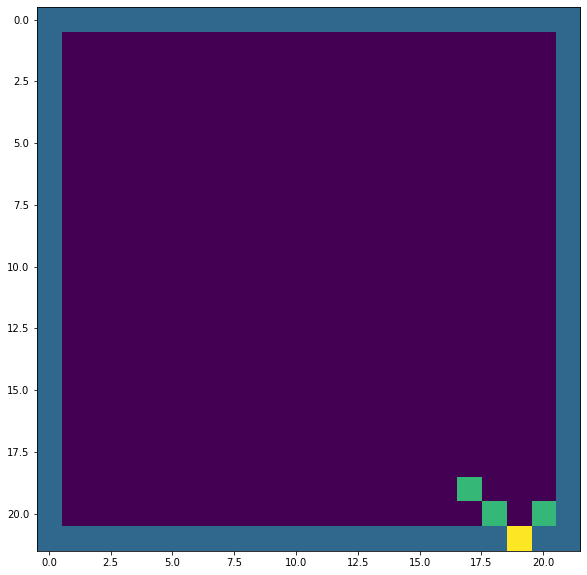

t = 37


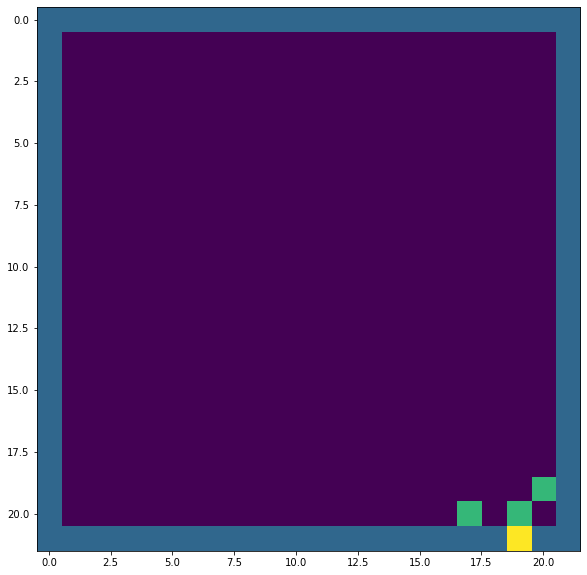

t = 38


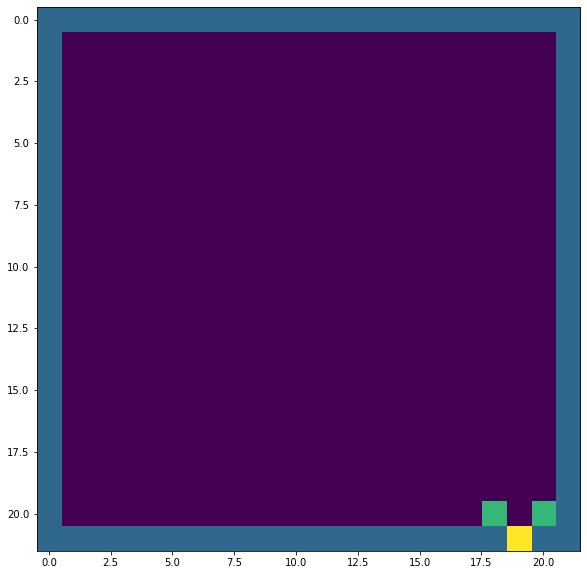

t = 39


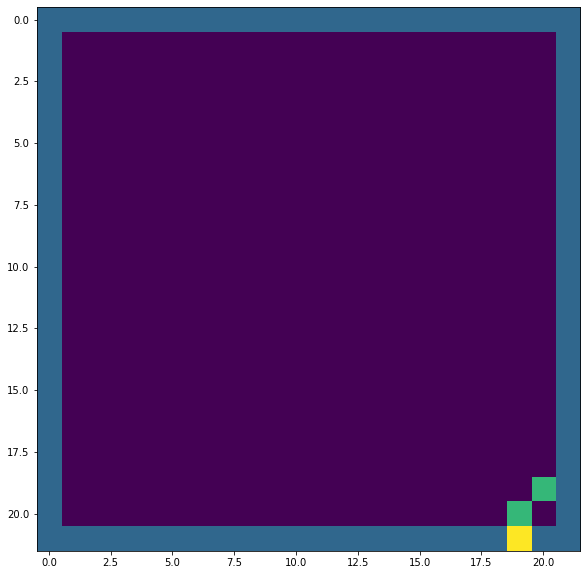

t = 40


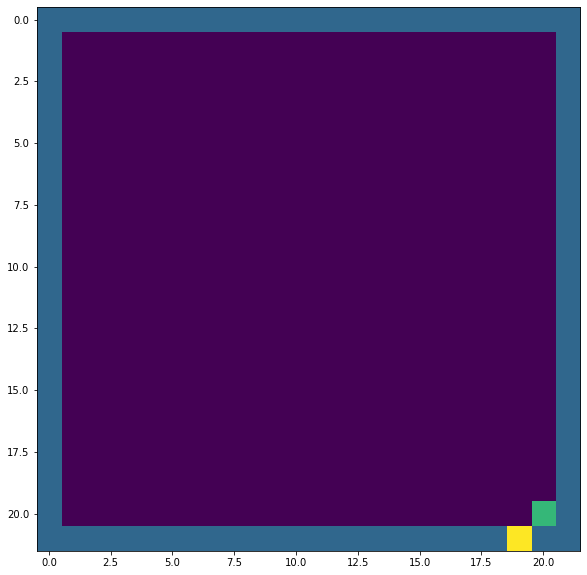

t = 41


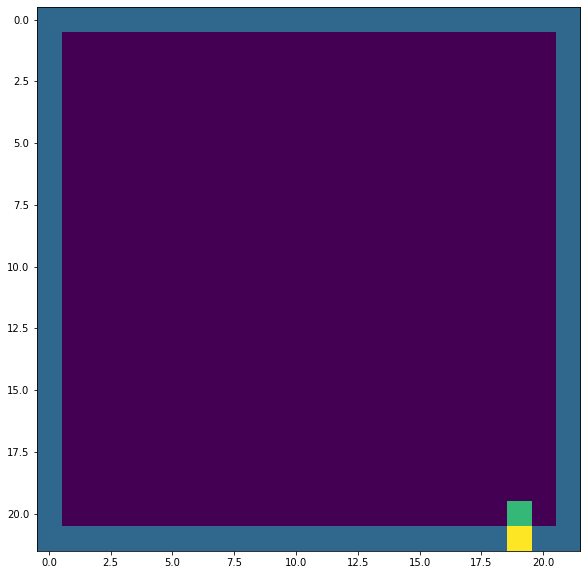

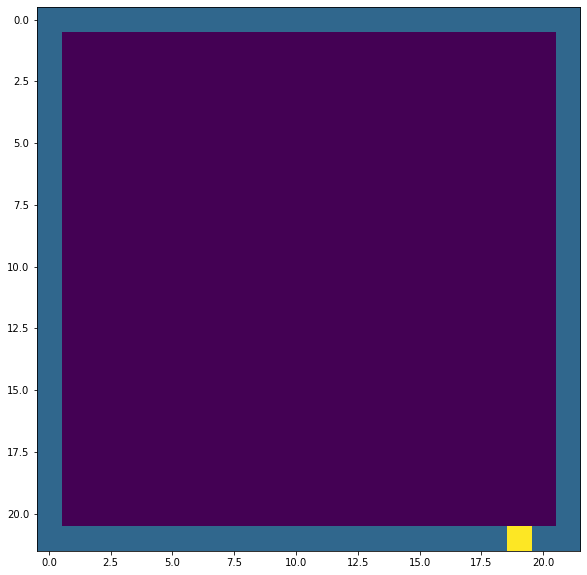

In [22]:
sim_return = simulate_evacuation(20, 100)
num_agents.append(sim_return[0])
ts.append(sim_return[1])

In [23]:
print(num_agents)
print(ts)

[10, 50, 100]
[21, 39, 42]


In [24]:
t = ts[-1]

# Create the frames
frames = []
imgs = []

for j in range(1,t+1):
    imgs.append("images/agents100pic"+str(j)+".png")

with imageio.get_writer('gifs/evac_simulation_agents100.gif', mode='I') as writer:
    for filename in imgs:
        image = imageio.imread(filename)
        writer.append_data(image)

<img src='gifs/evac_simulation_agents100.gif' width=400>

## agents = 150

(2, 0)
t = 0


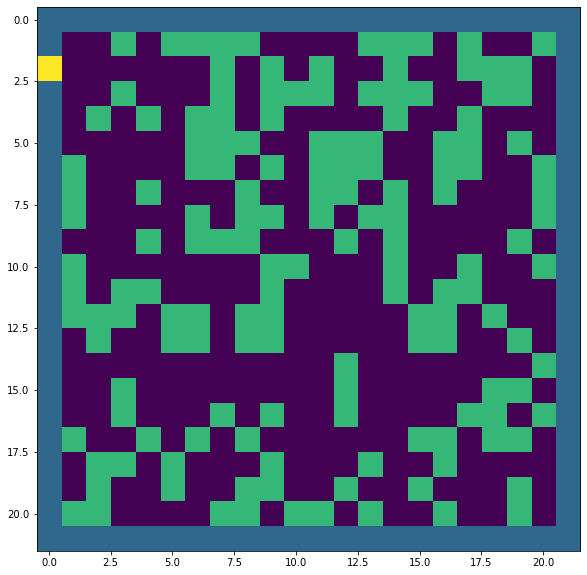

t = 1


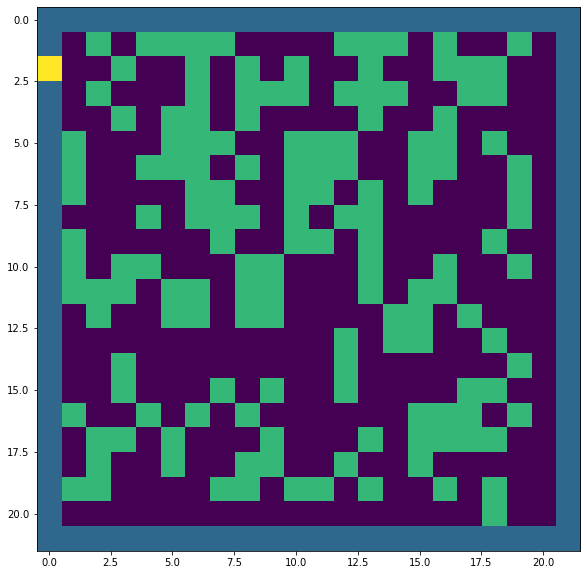

t = 2


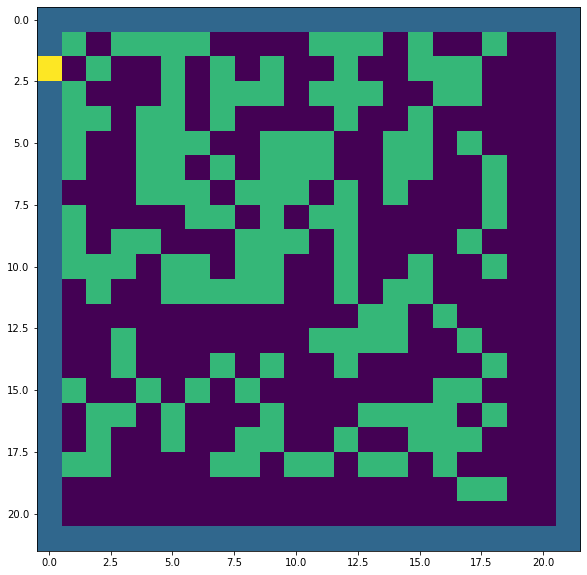

t = 3


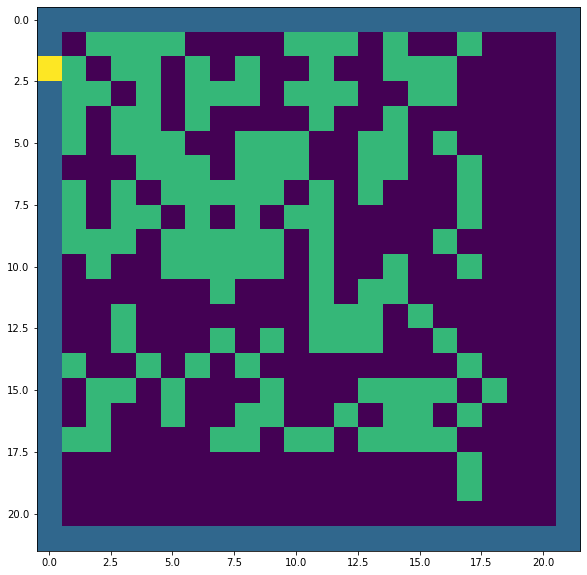

t = 4


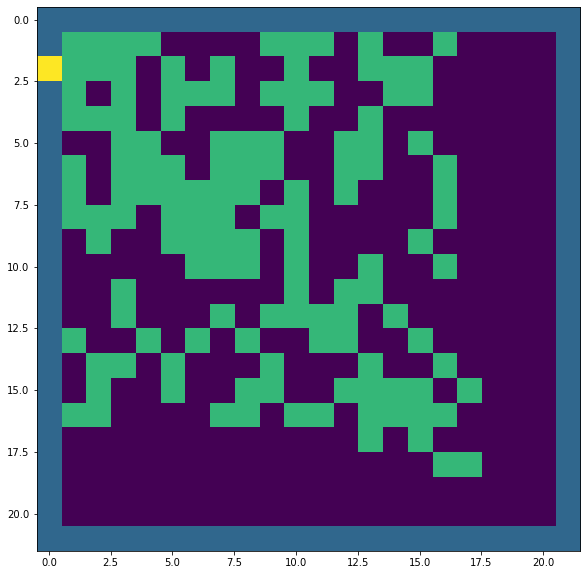

t = 5


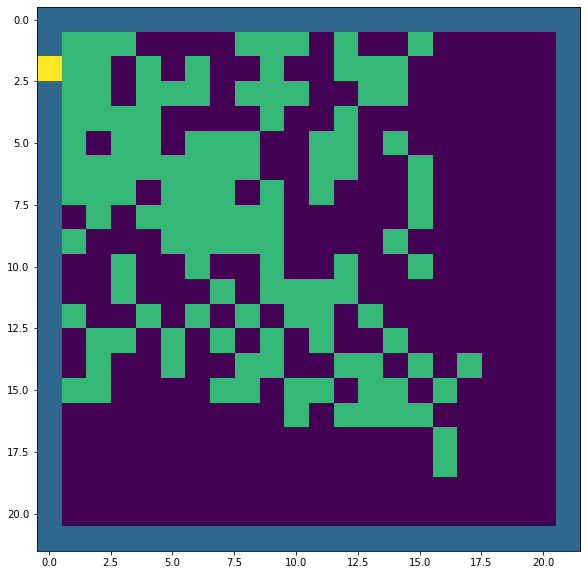

t = 6


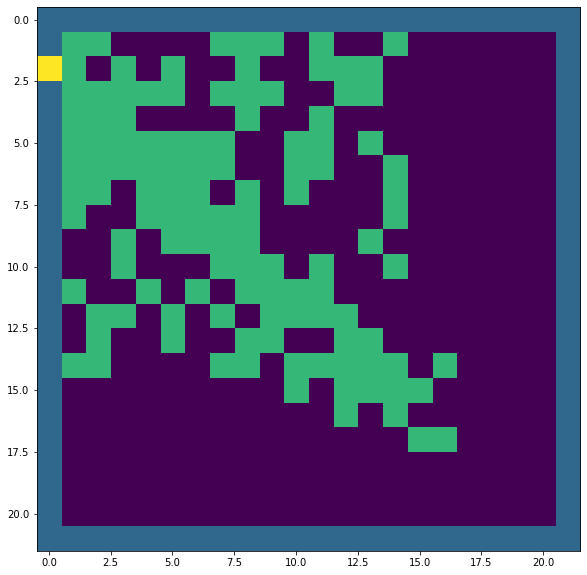

t = 7


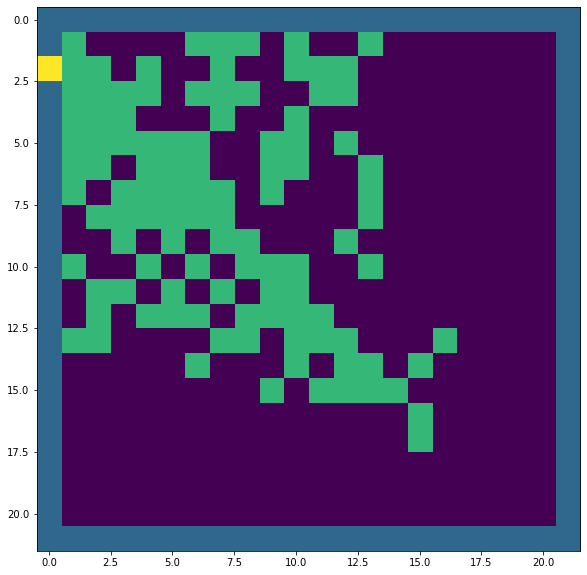

t = 8


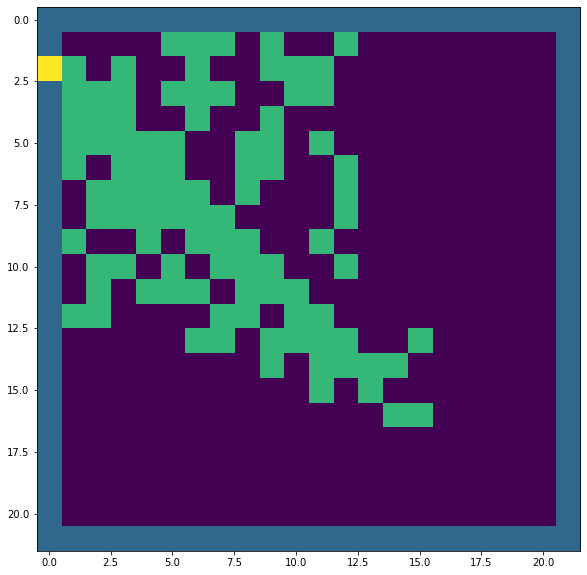

t = 9


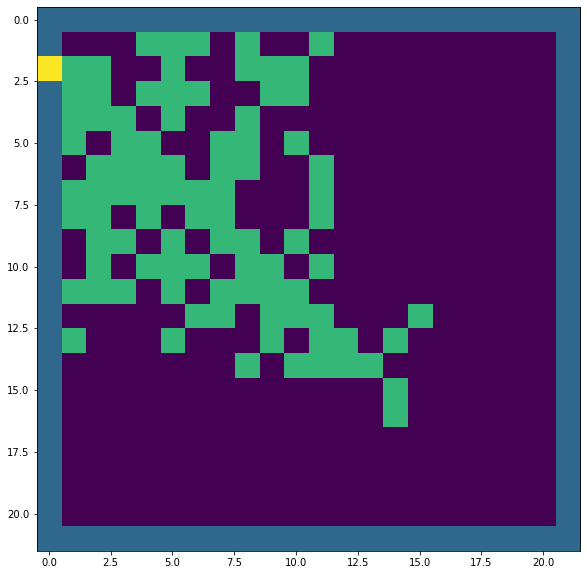

t = 10


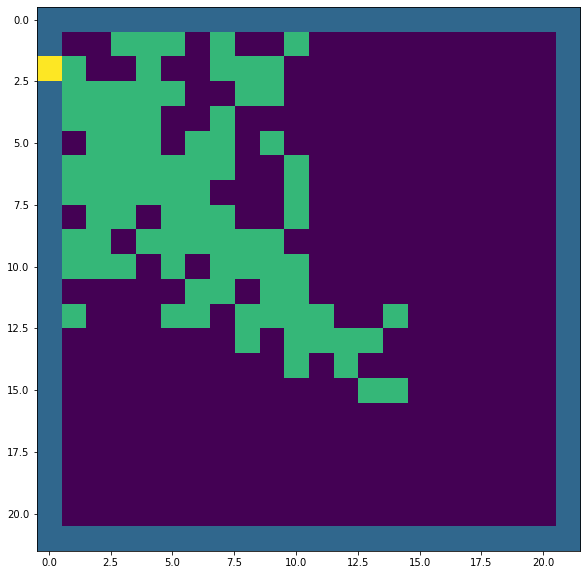

t = 11


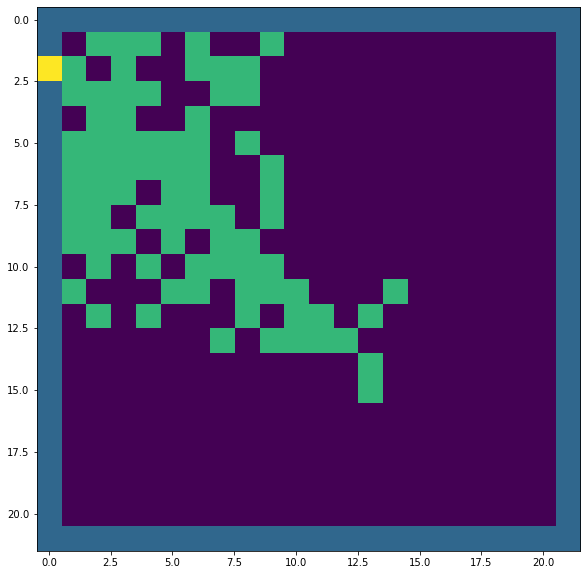

t = 12


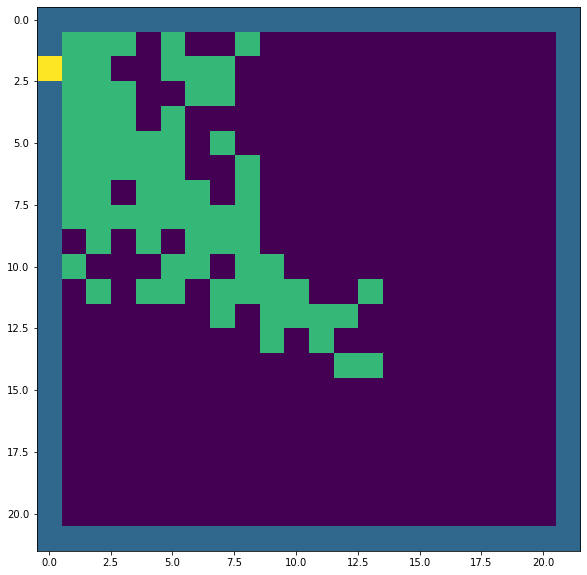

t = 13


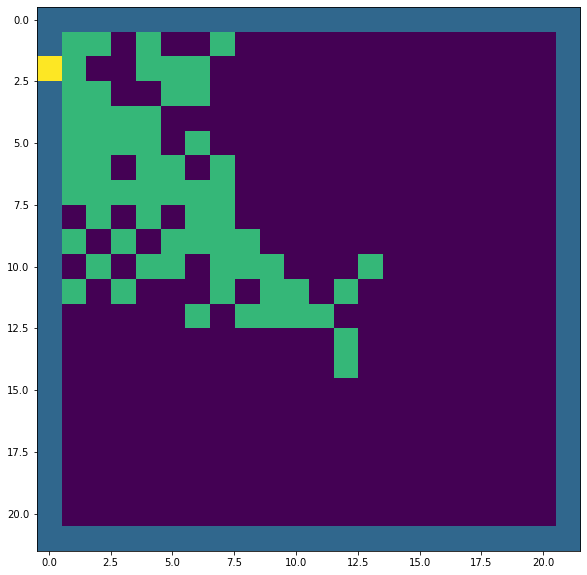

t = 14


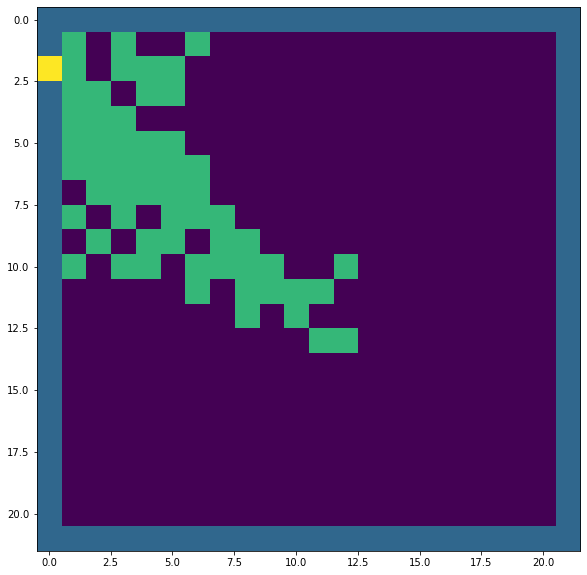

t = 15


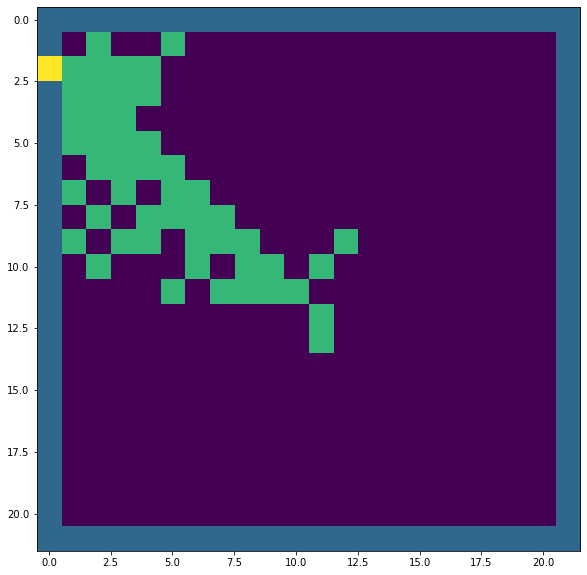

t = 16


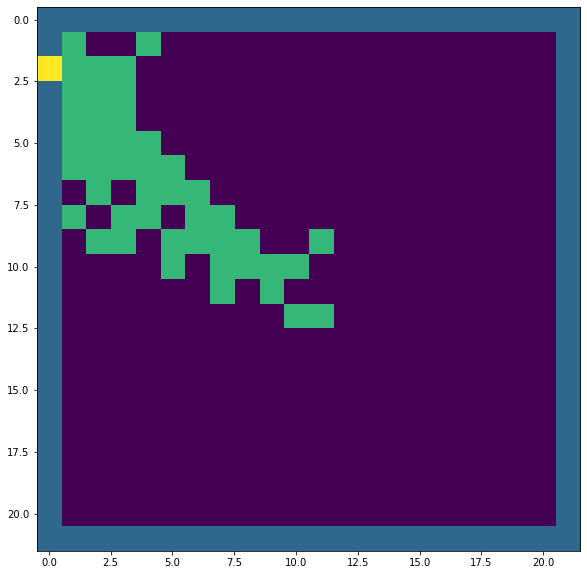

t = 17


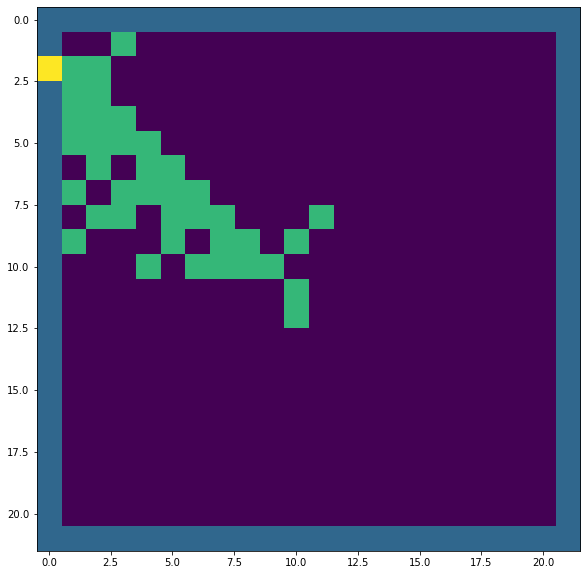

t = 18


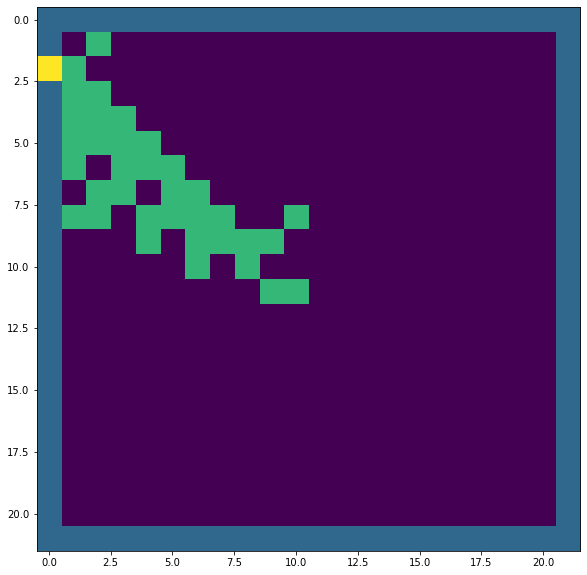

t = 19


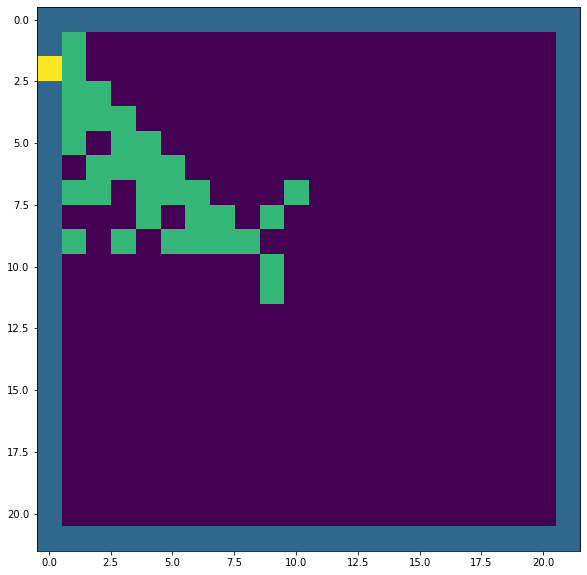

t = 20


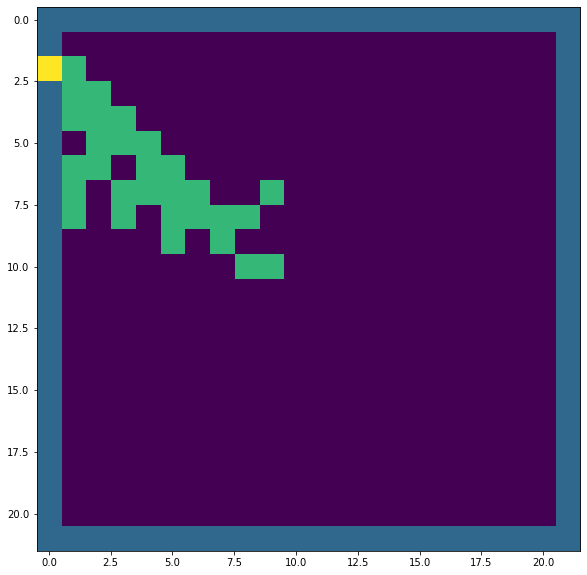

t = 21


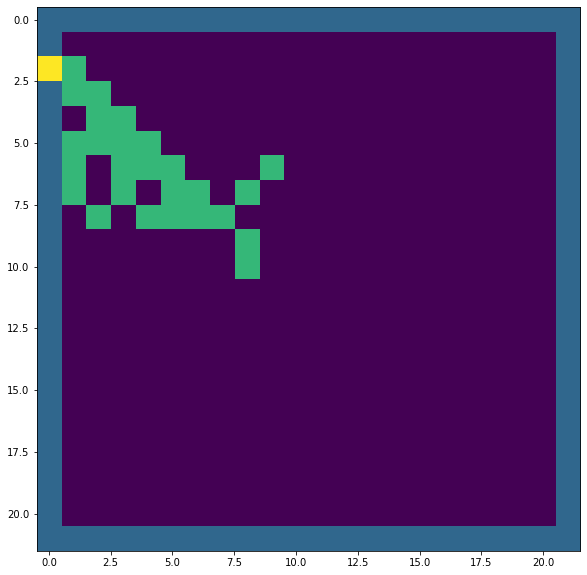

t = 22


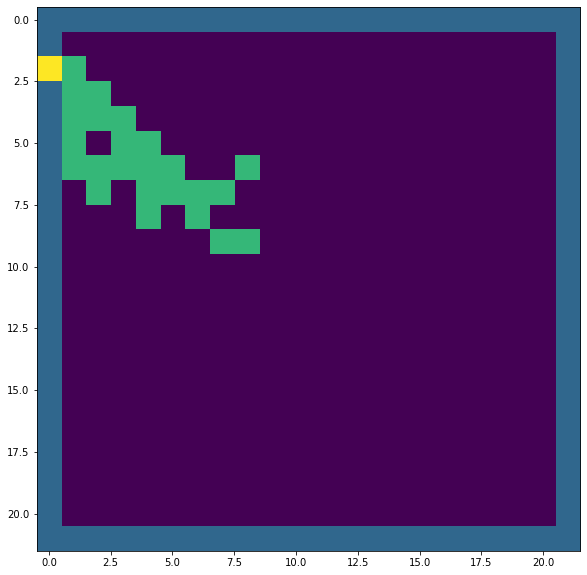

t = 23


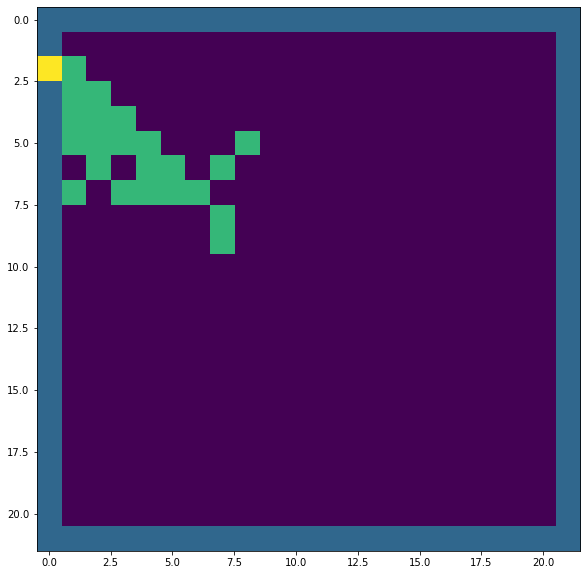

t = 24


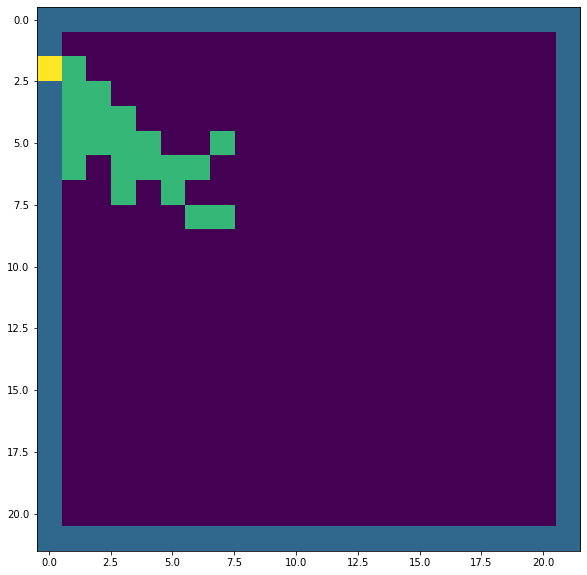

t = 25


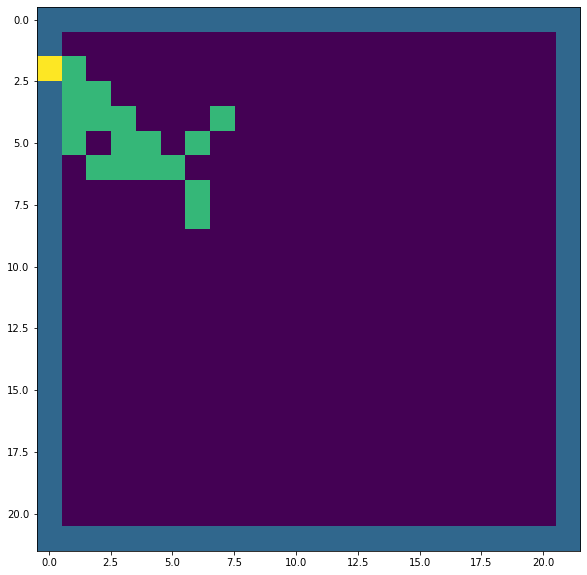

t = 26


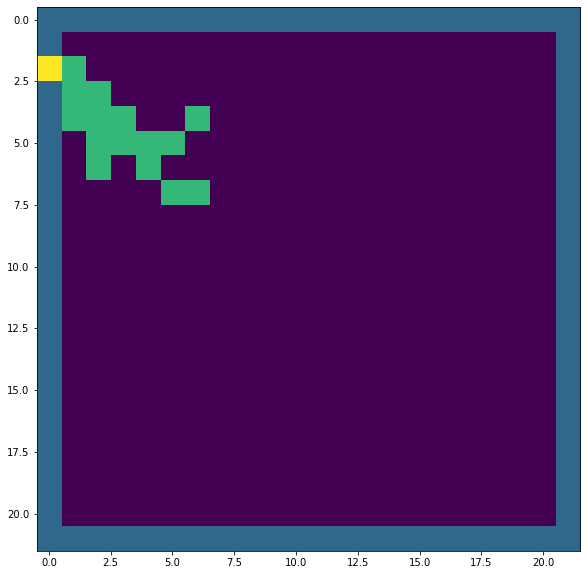

t = 27


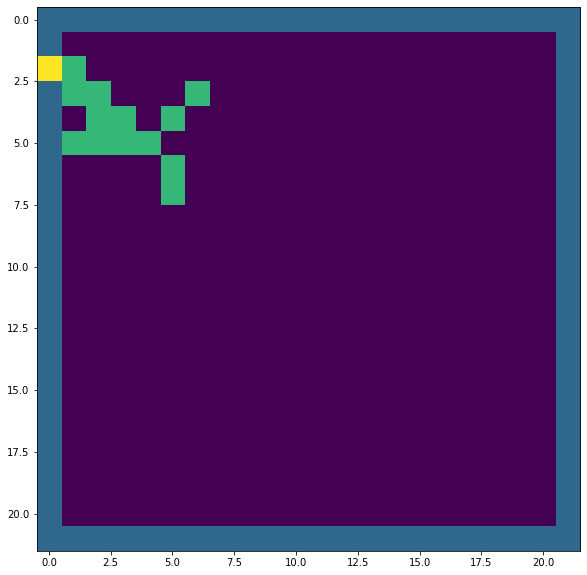

t = 28


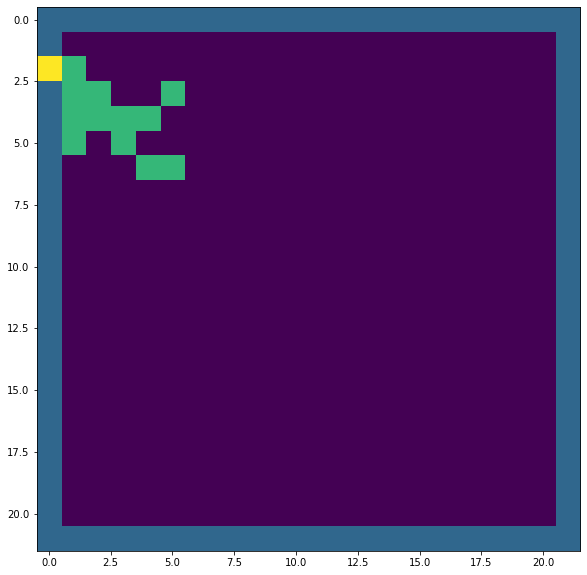

t = 29


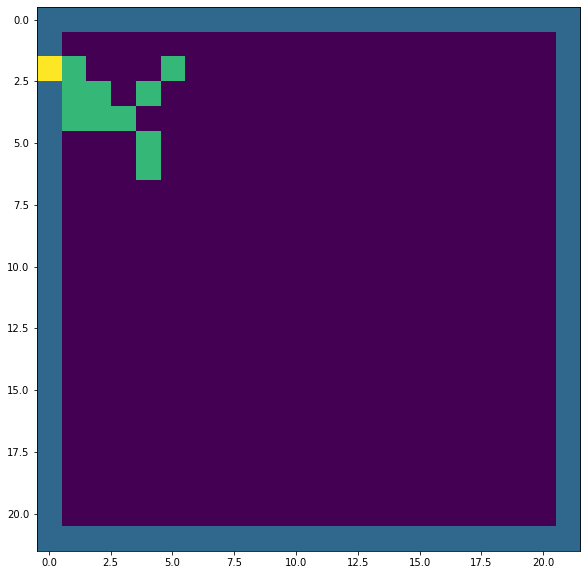

t = 30


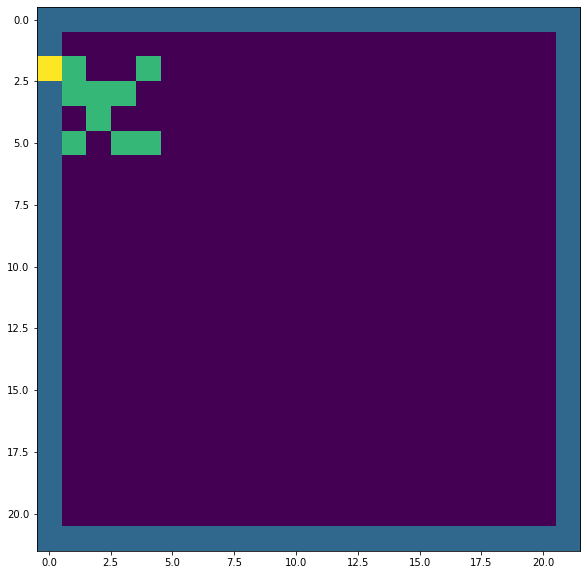

t = 31


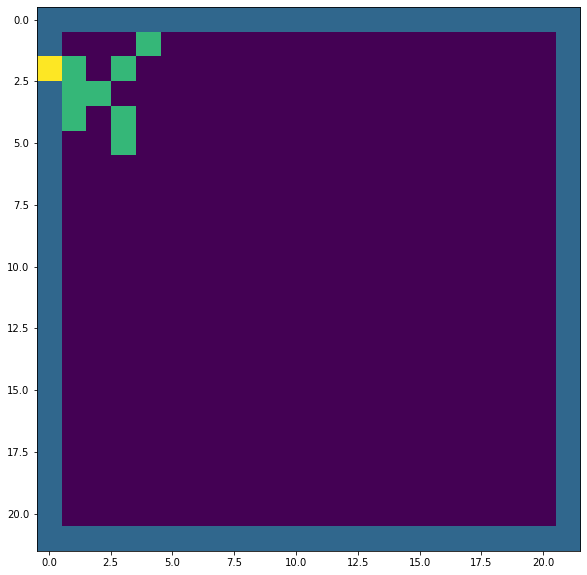

t = 32


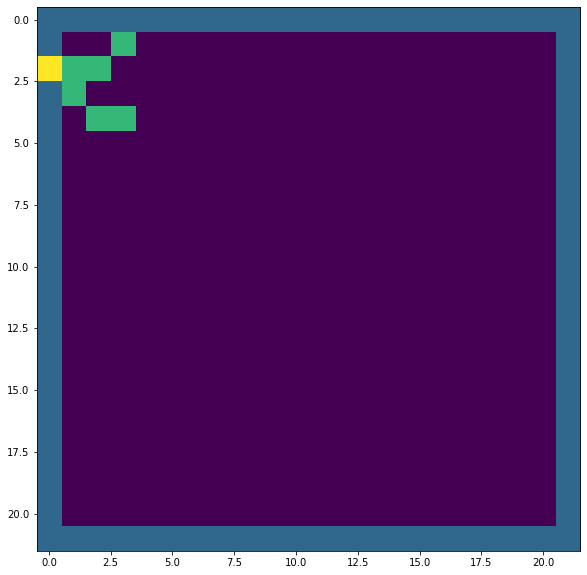

t = 33


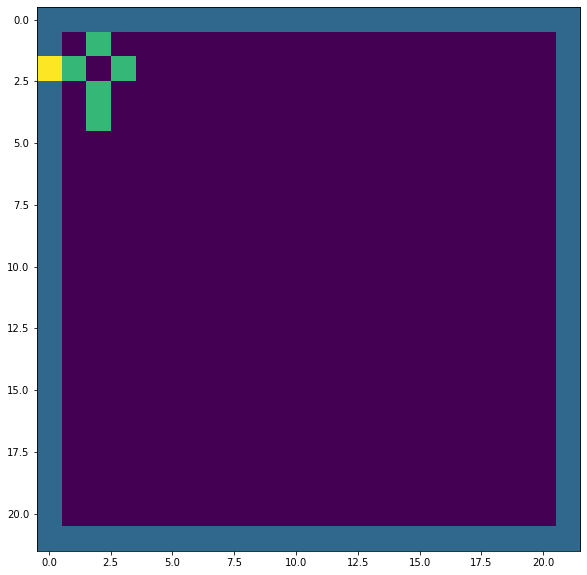

t = 34


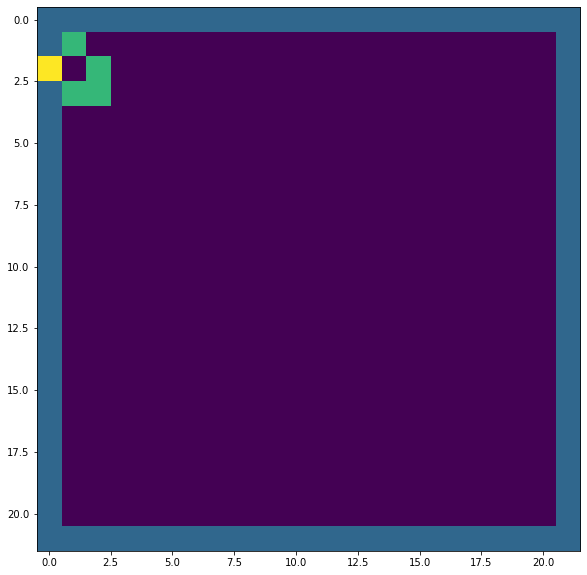

t = 35


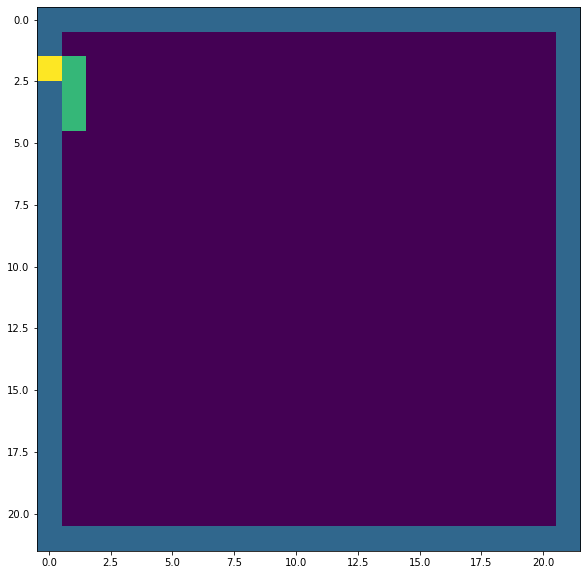

t = 36


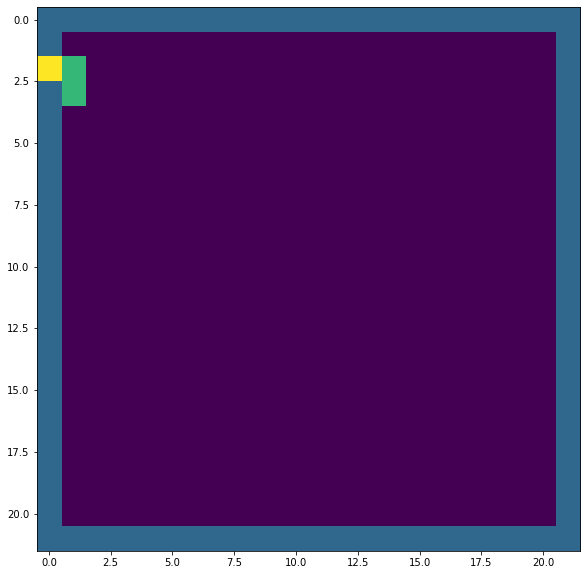

t = 37


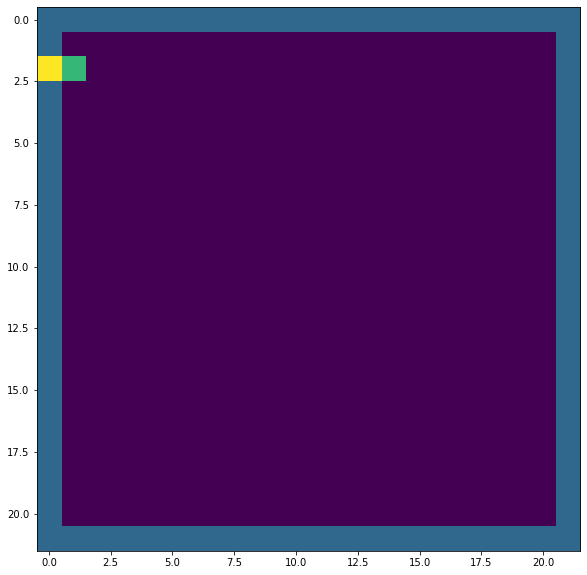

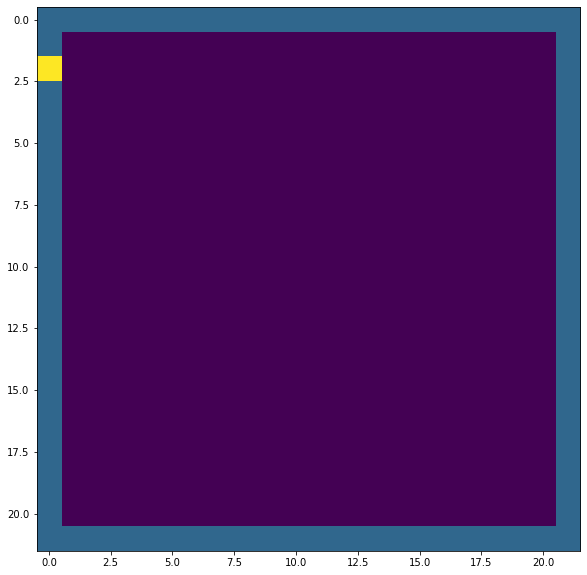

In [25]:
sim_return = simulate_evacuation(20, 150)
num_agents.append(sim_return[0])
ts.append(sim_return[1])

In [26]:
print(num_agents)
print(ts)

[10, 50, 100, 150]
[21, 39, 42, 38]


In [27]:
t = ts[-1]

# Create the frames
frames = []
imgs = []

for j in range(1,t+1):
    imgs.append("images/agents150pic"+str(j)+".png")

with imageio.get_writer('gifs/evac_simulation_agents150.gif', mode='I') as writer:
    for filename in imgs:
        image = imageio.imread(filename)
        writer.append_data(image)

<img src='gifs/evac_simulation_agents150.gif' width=400>

## agents = 200

(21, 16)
t = 0


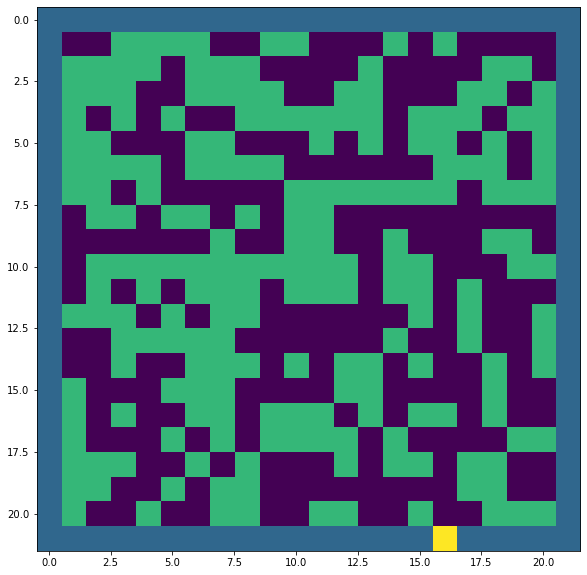

t = 1


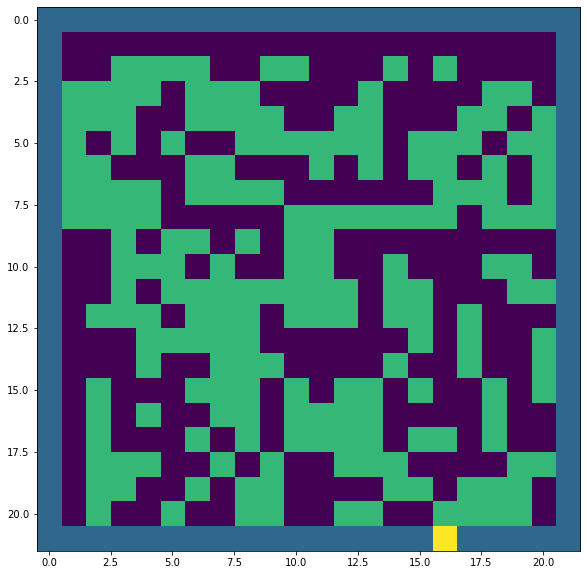

t = 2


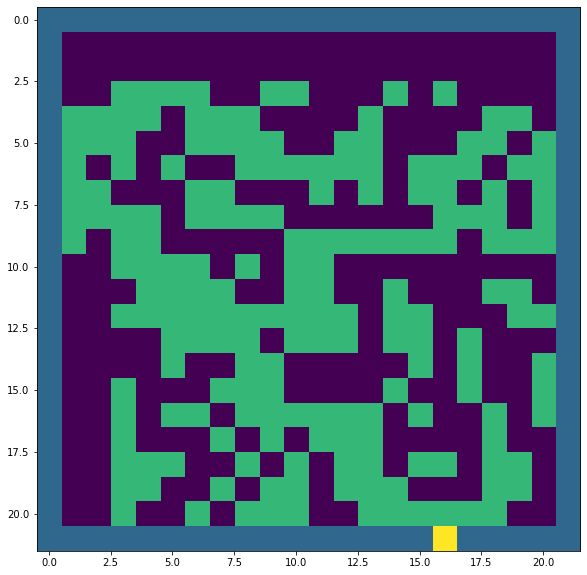

t = 3


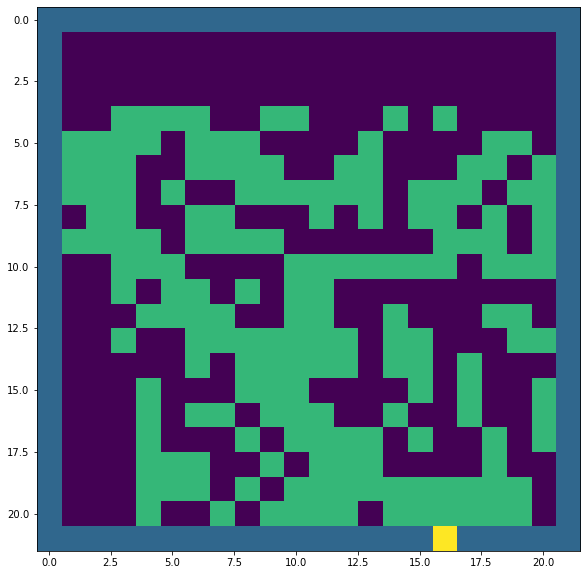

t = 4


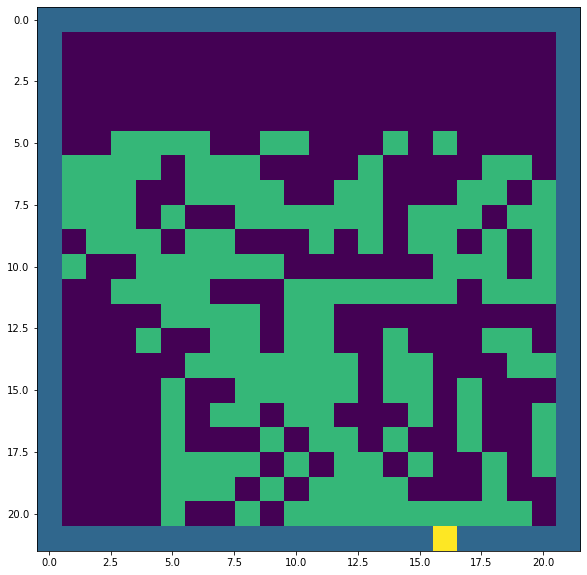

t = 5


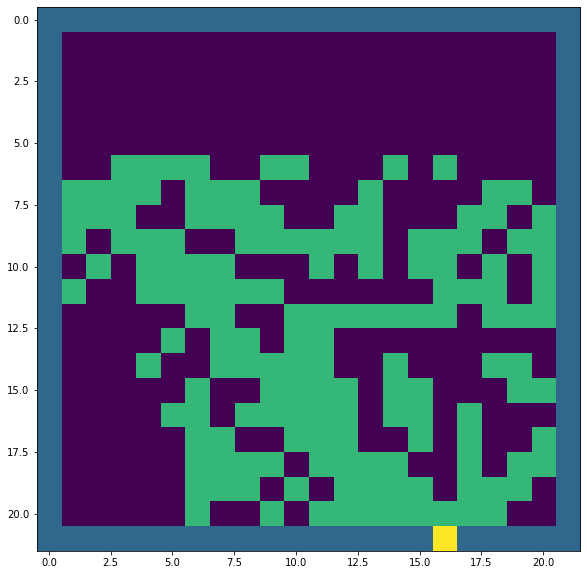

t = 6


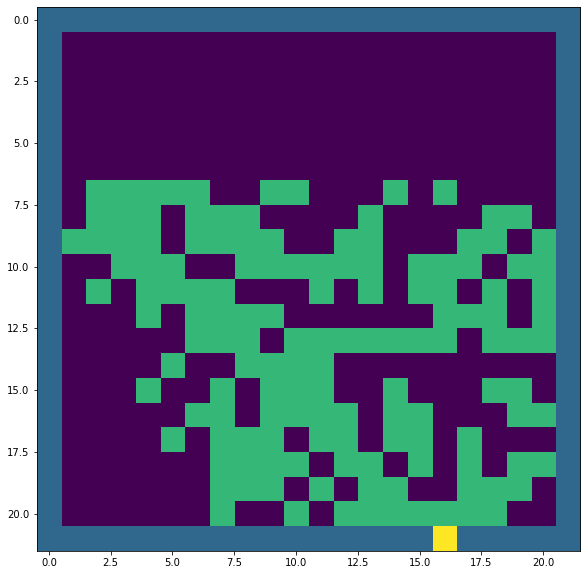

t = 7


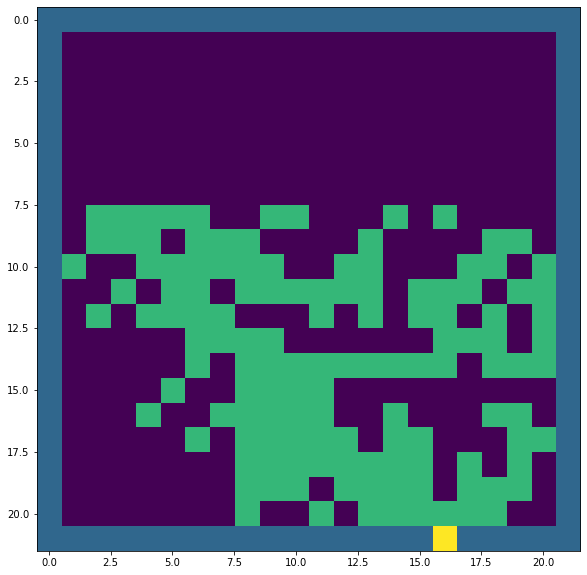

t = 8


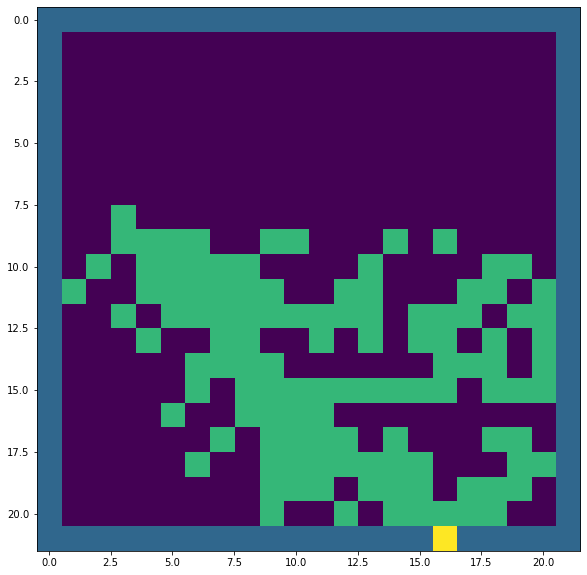

t = 9


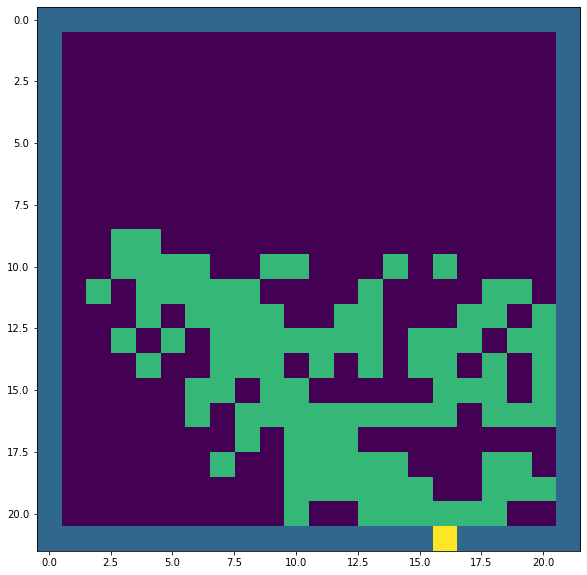

t = 10


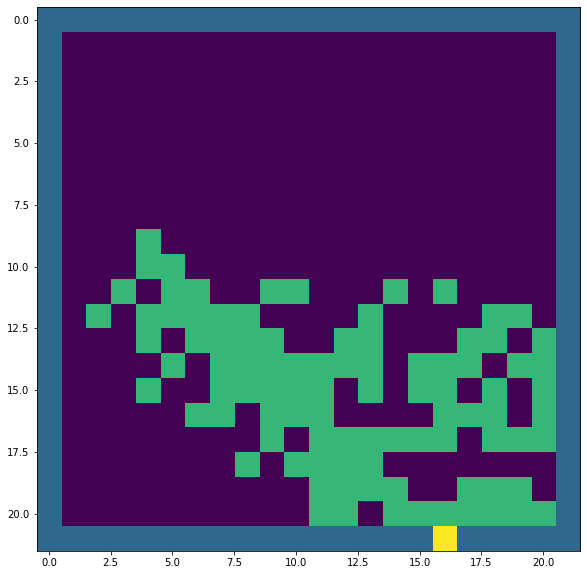

t = 11


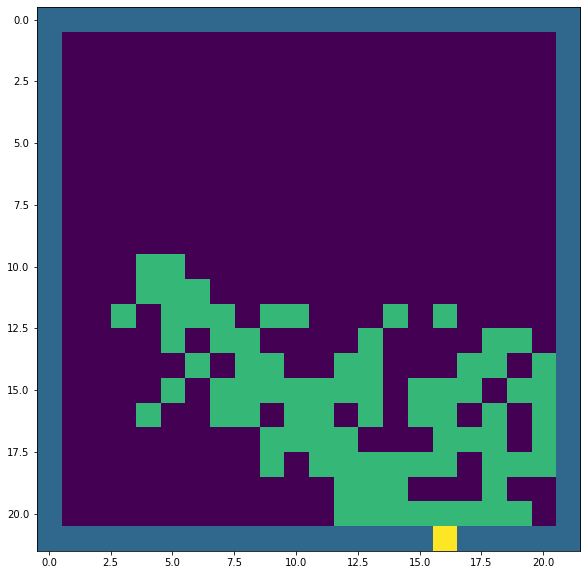

t = 12


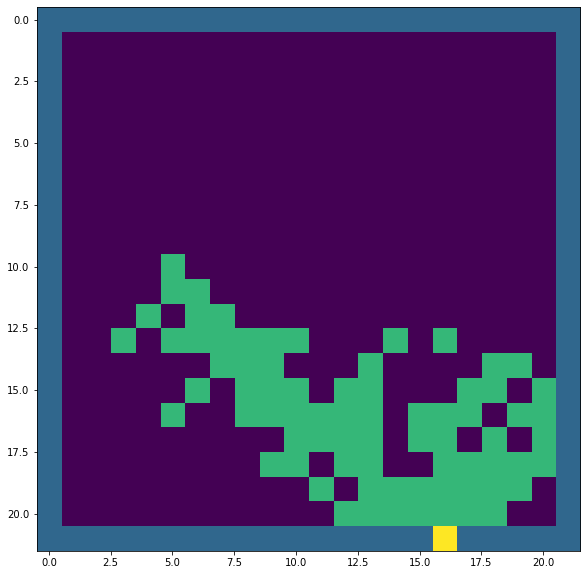

t = 13


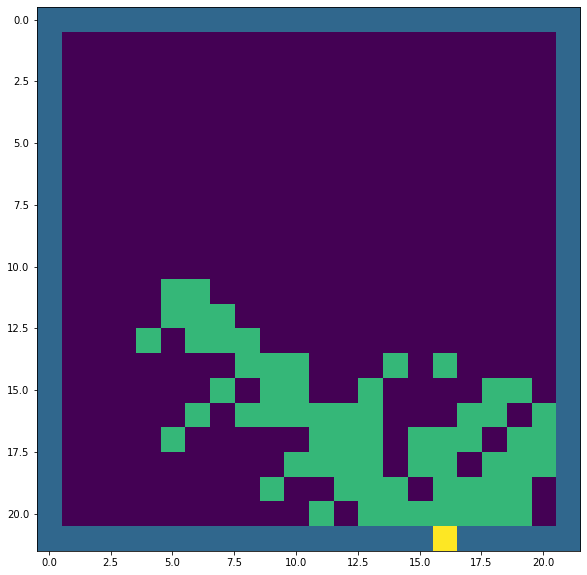

t = 14


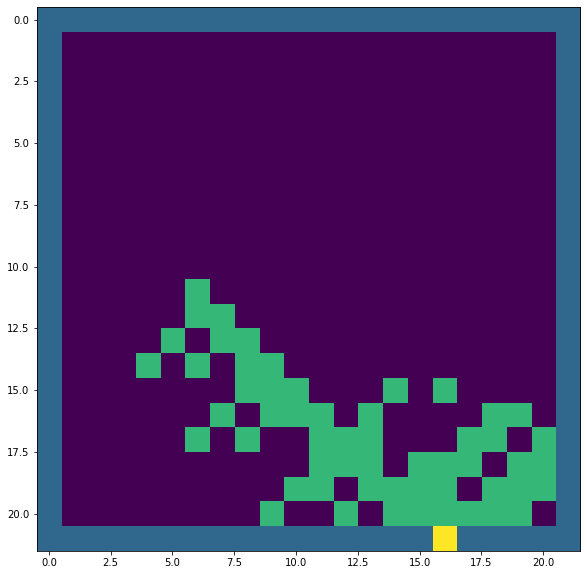

t = 15


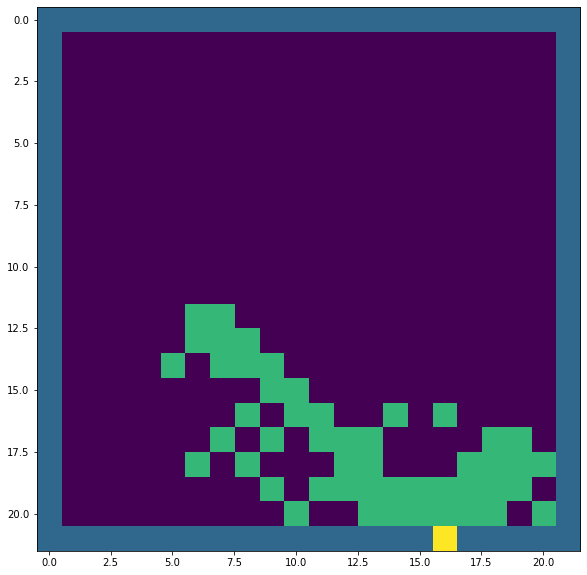

t = 16


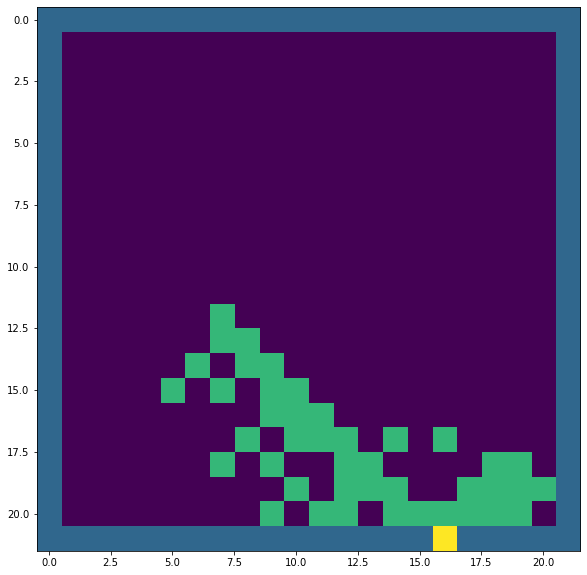

t = 17


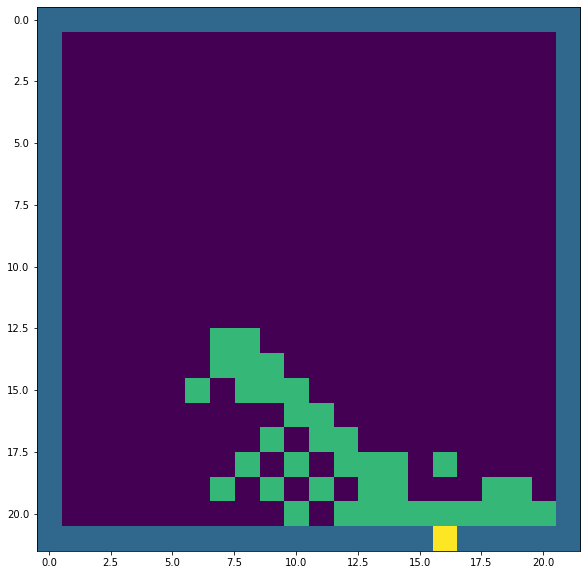

t = 18


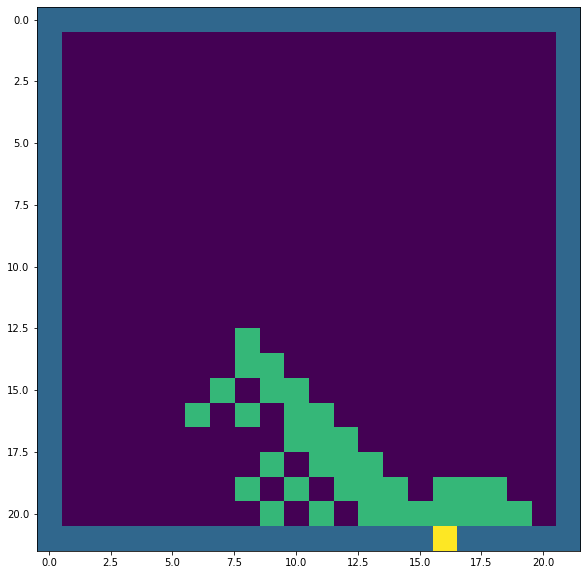

t = 19


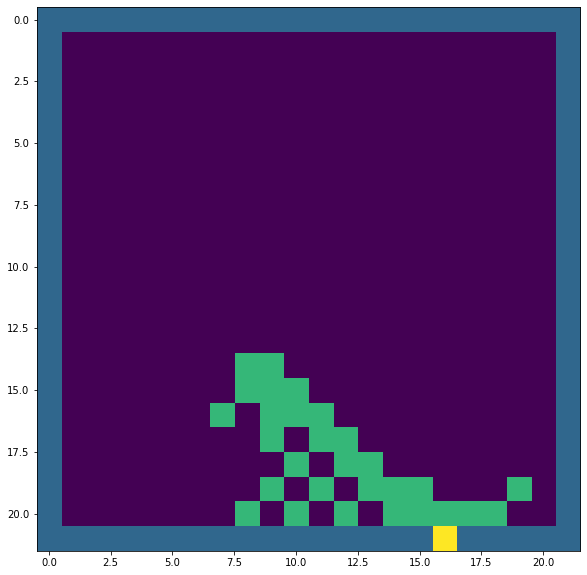

t = 20


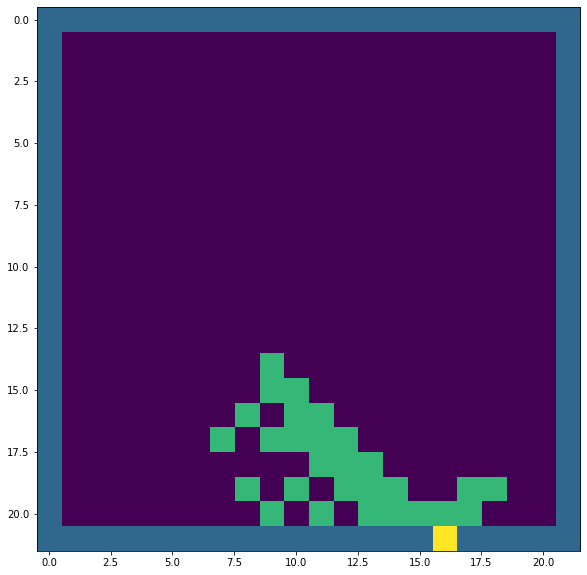

t = 21


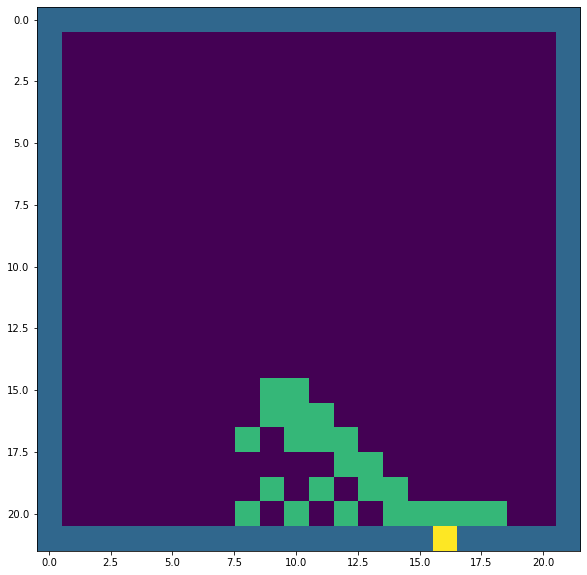

t = 22


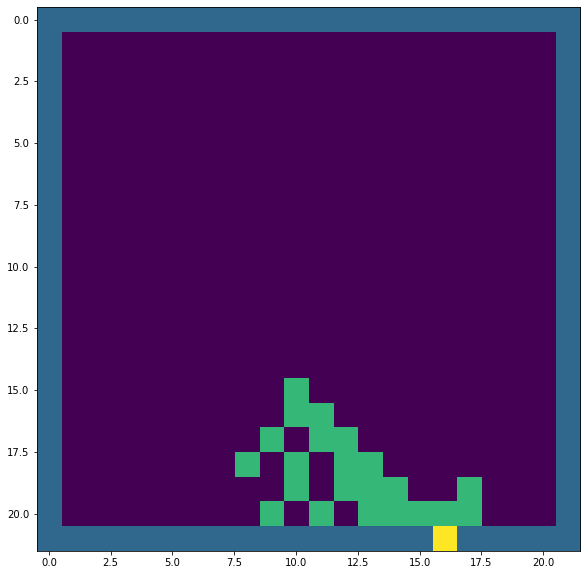

t = 23


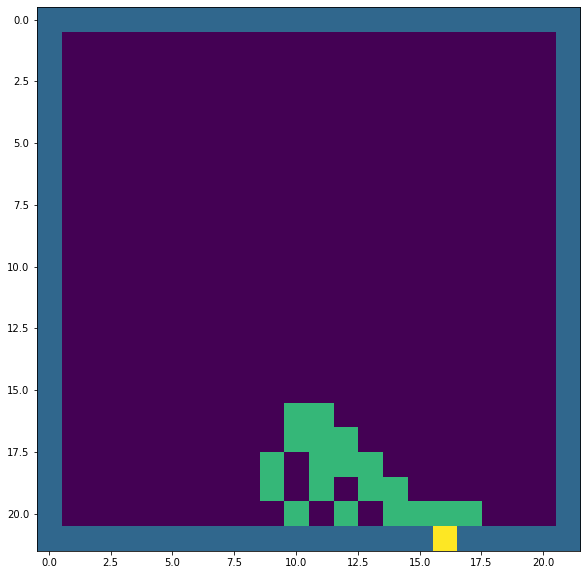

t = 24


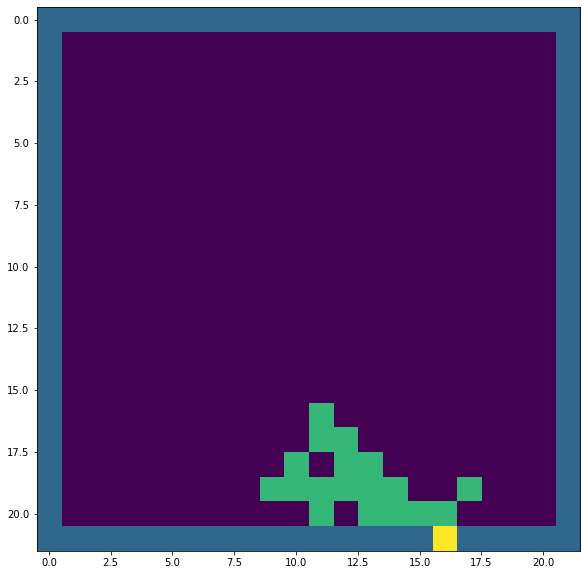

t = 25


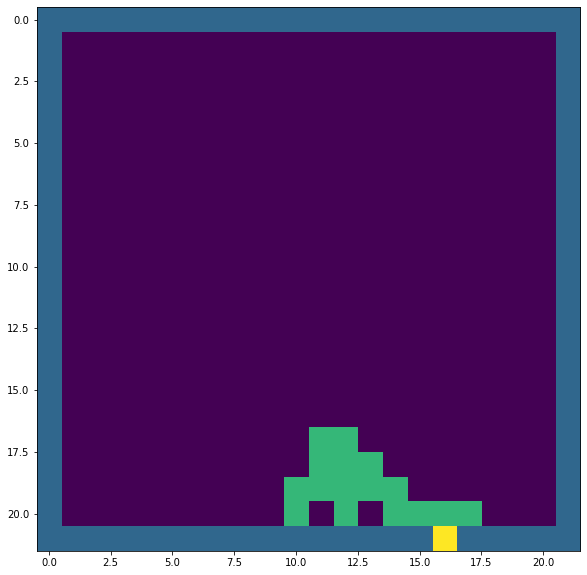

t = 26


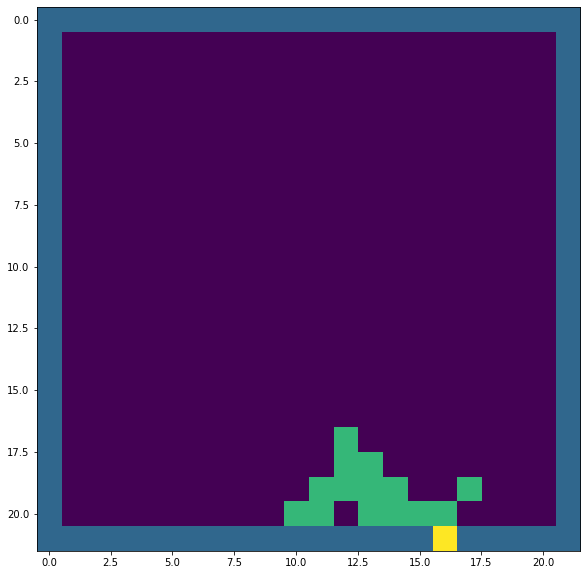

t = 27


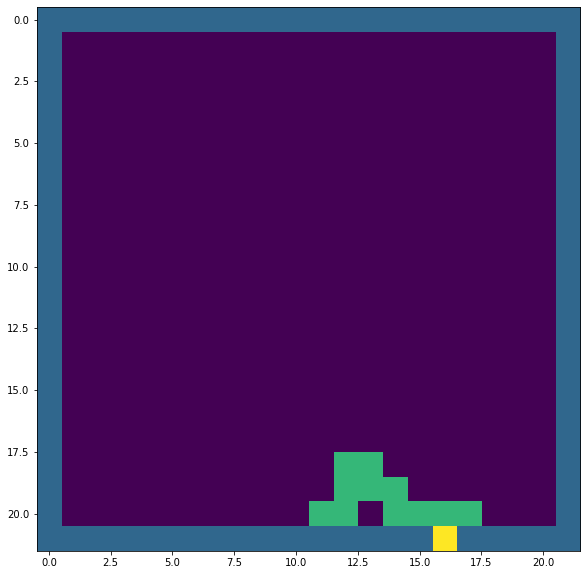

t = 28


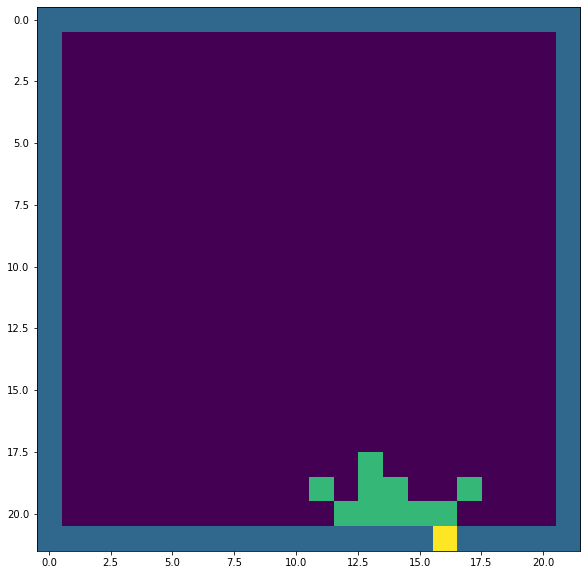

t = 29


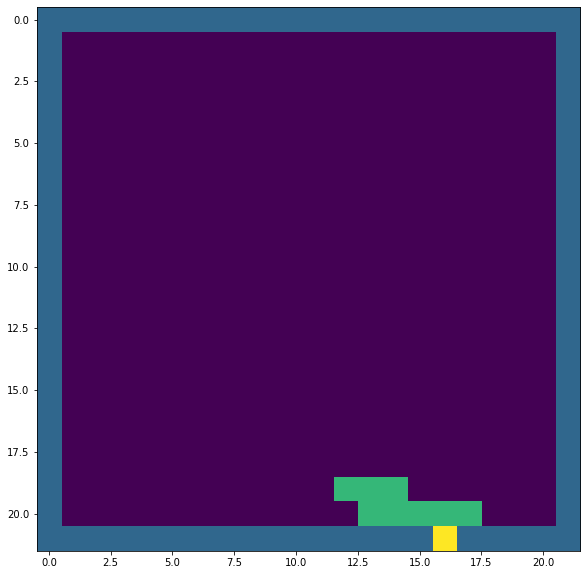

t = 30


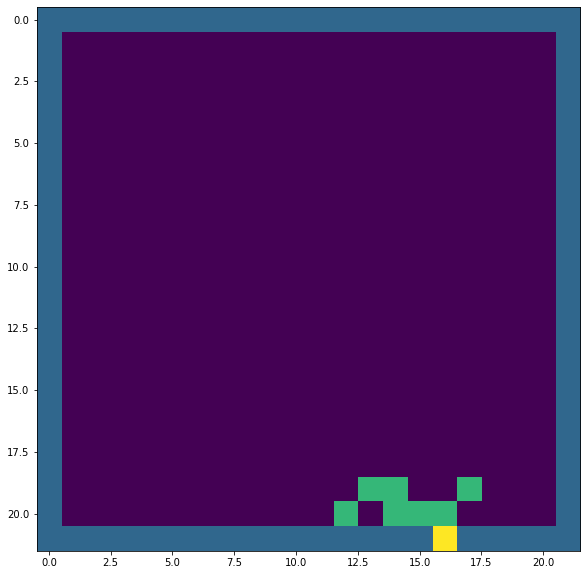

t = 31


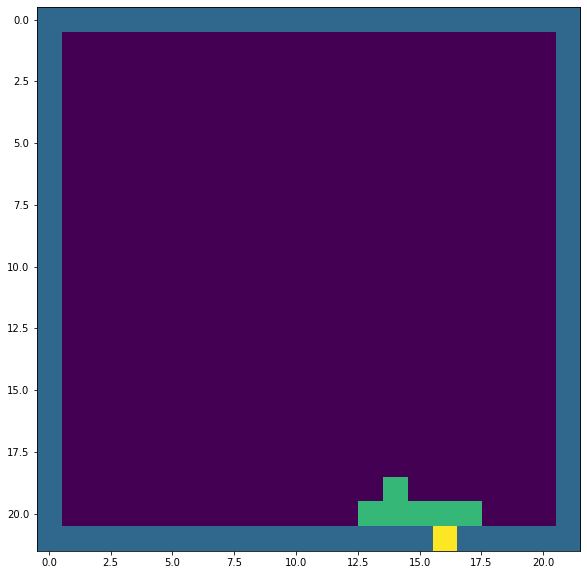

t = 32


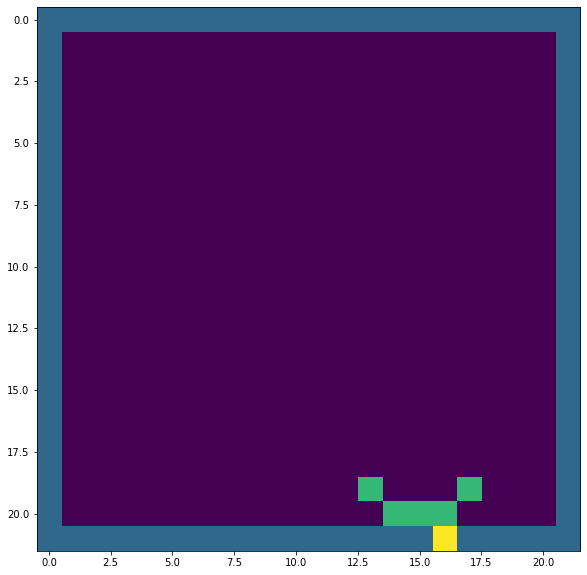

t = 33


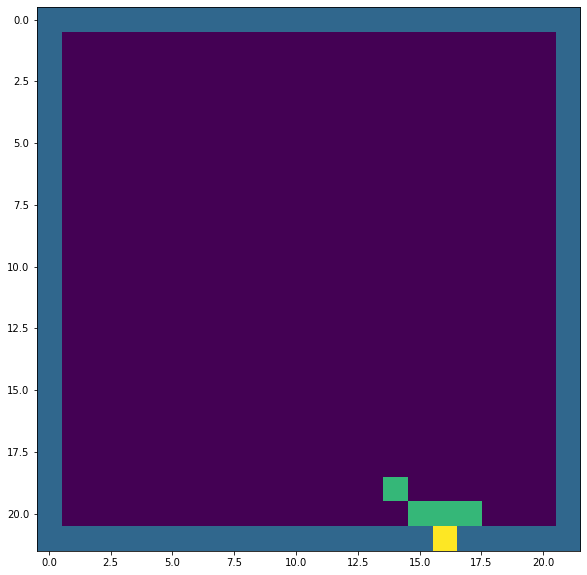

t = 34


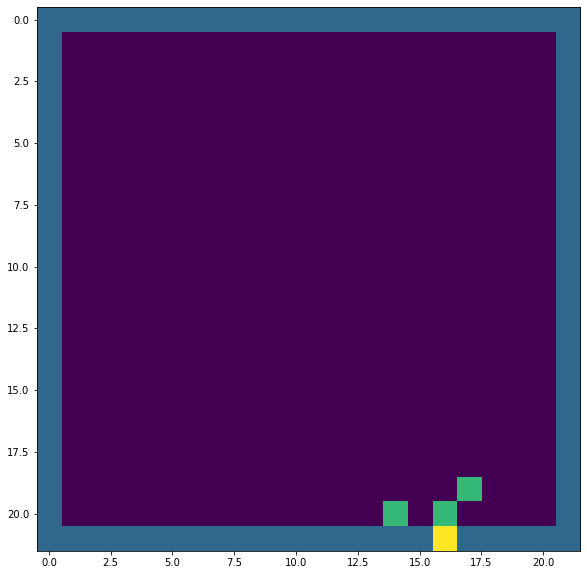

t = 35


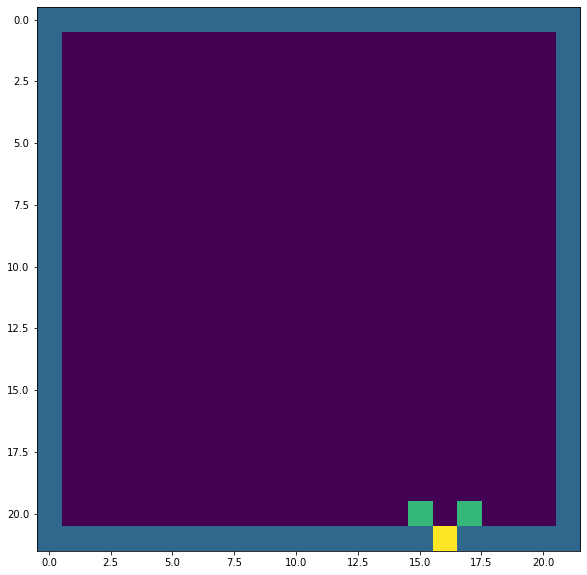

t = 36


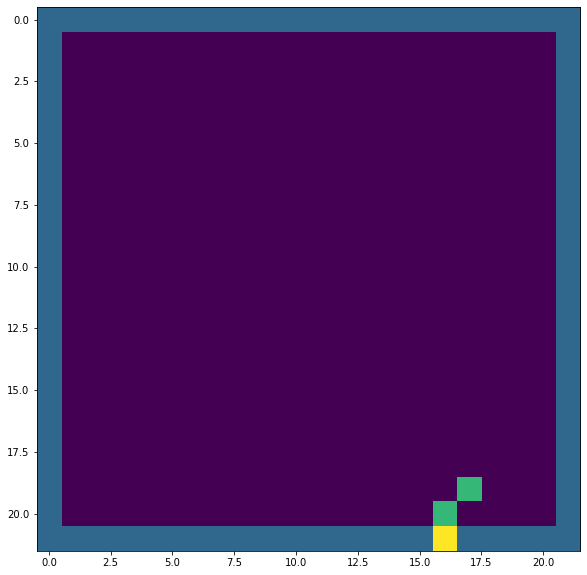

t = 37


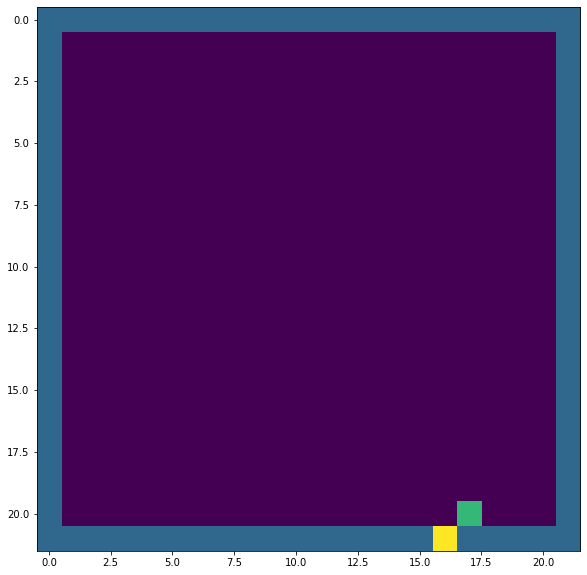

t = 38


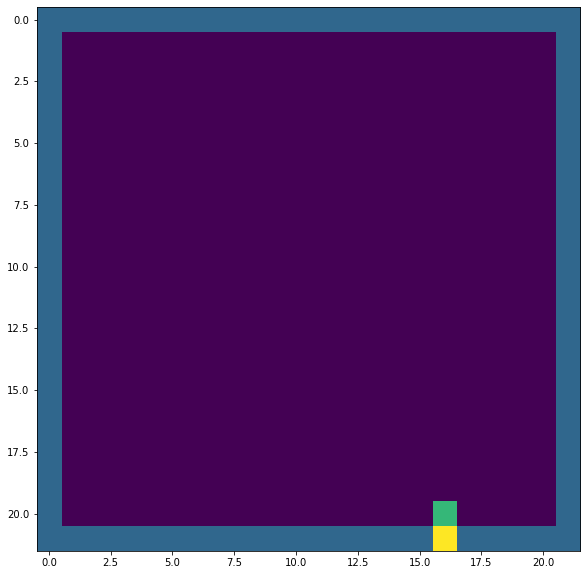

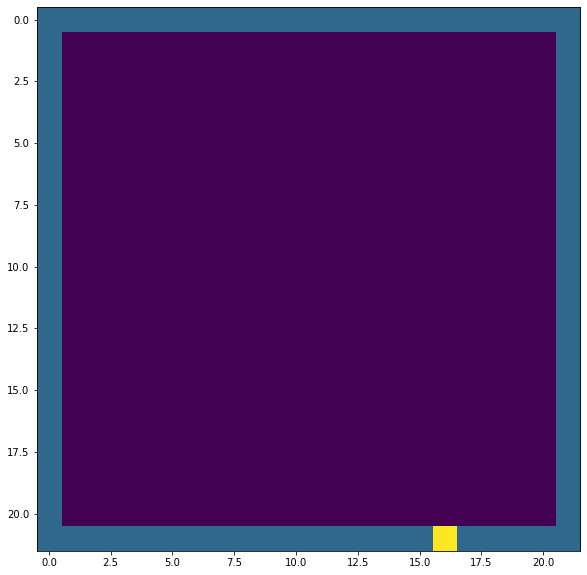

In [28]:
sim_return = simulate_evacuation(20, 200)
num_agents.append(sim_return[0])
ts.append(sim_return[1])

In [29]:
print(num_agents)
print(ts)

[10, 50, 100, 150, 200]
[21, 39, 42, 38, 39]


In [31]:
t = ts[-1]

# Create the frames
frames = []
imgs = []

for j in range(1,t+1):
    imgs.append("images/agents200pic"+str(j)+".png")

with imageio.get_writer('gifs/evac_simulation_agents200.gif', mode='I') as writer:
    for filename in imgs:
        image = imageio.imread(filename)
        writer.append_data(image)

<img src='gifs/evac_simulation_agents200.gif' width=400>

## agents = 250

(4, 0)
t = 0


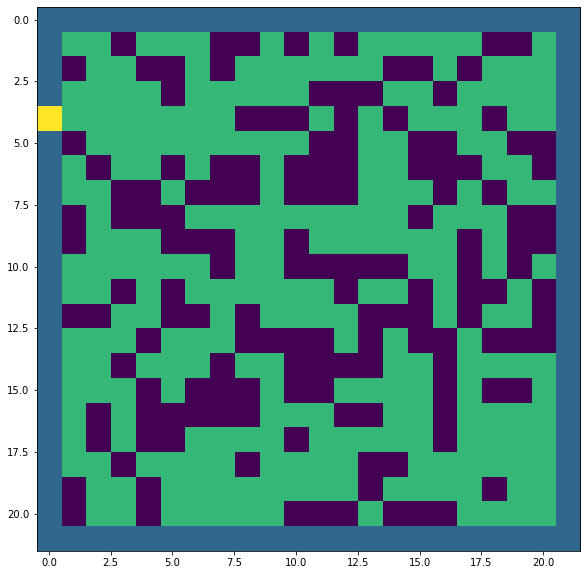

t = 1


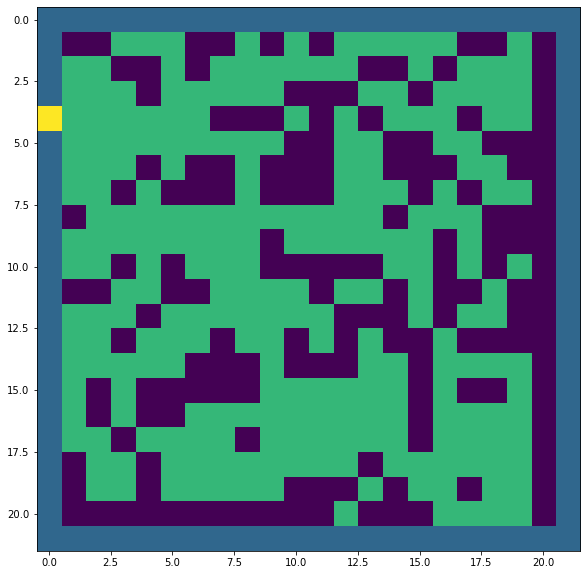

t = 2


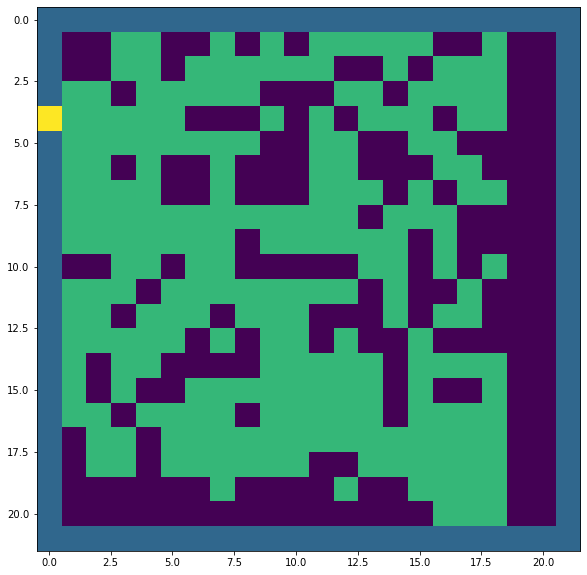

t = 3


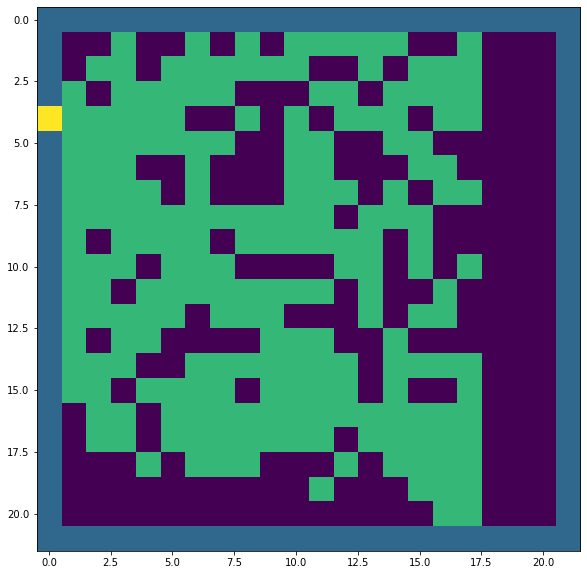

t = 4


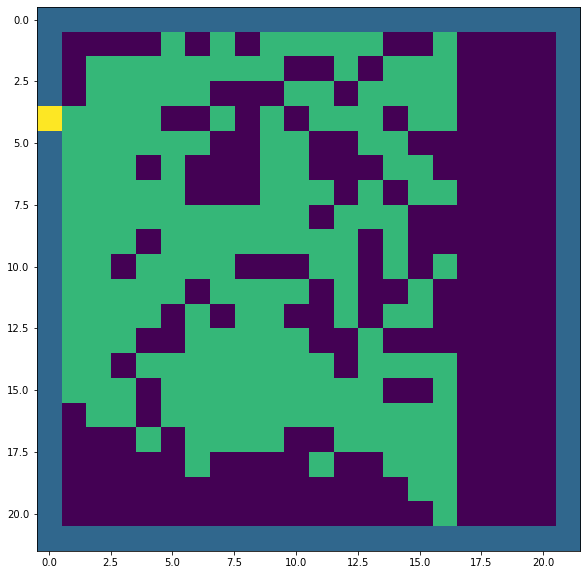

t = 5


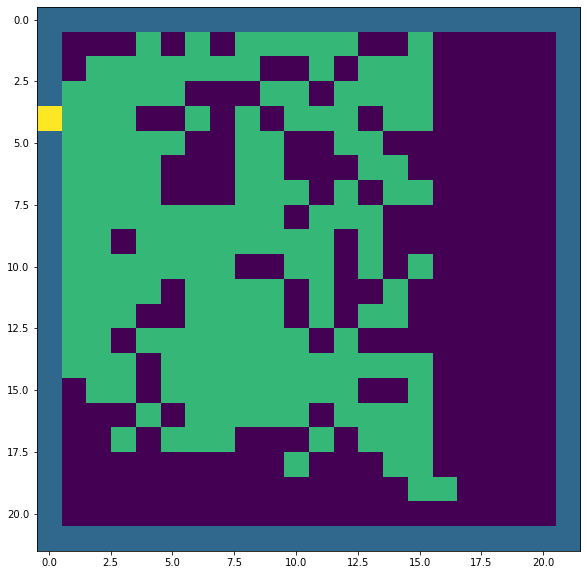

t = 6


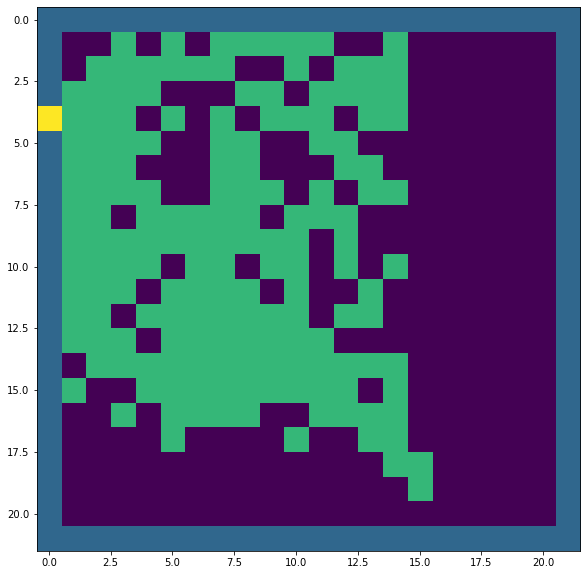

t = 7


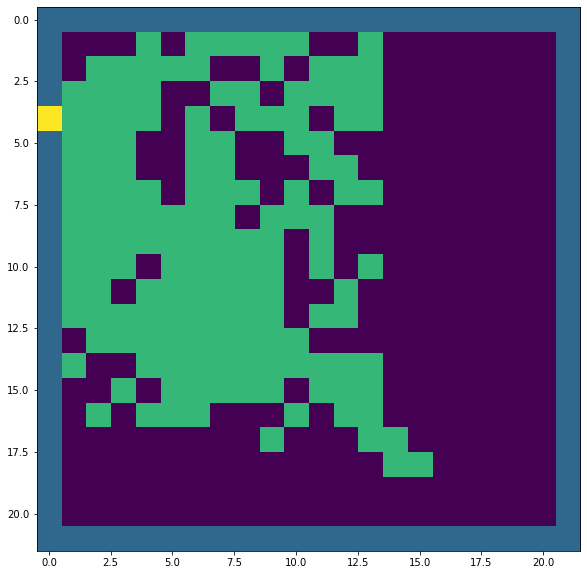

t = 8


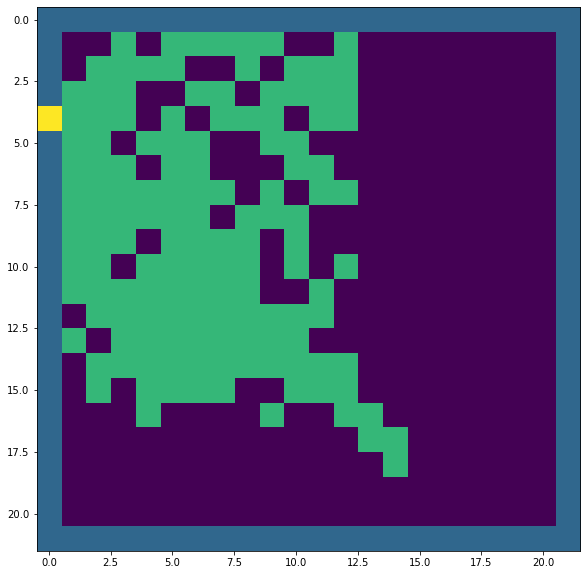

t = 9


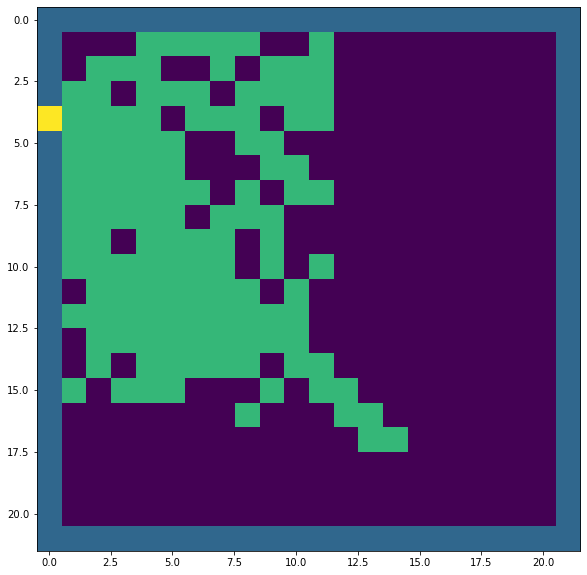

t = 10


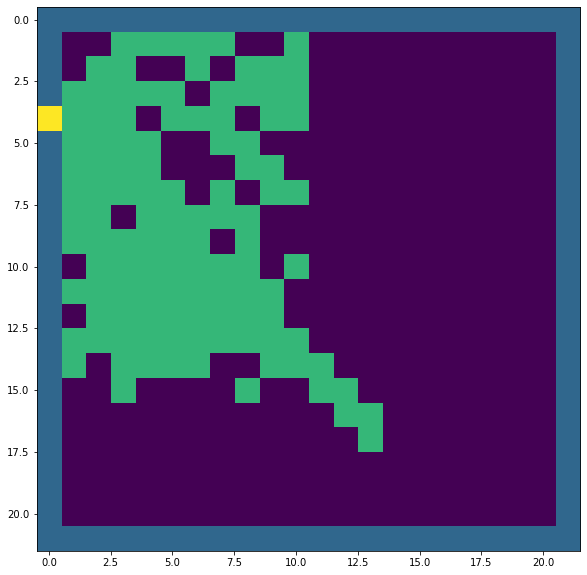

t = 11


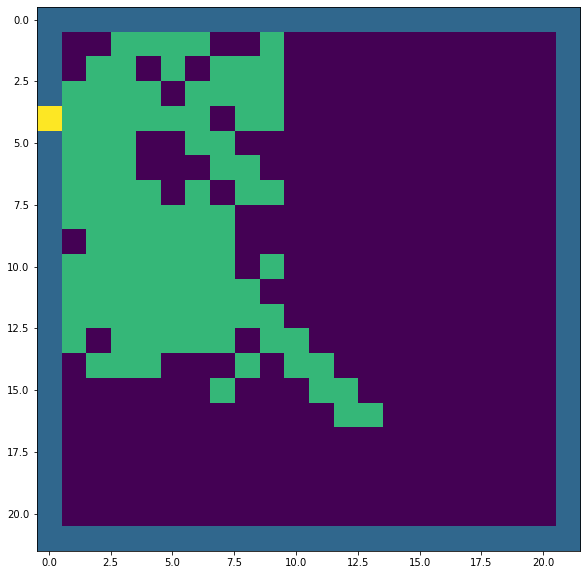

t = 12


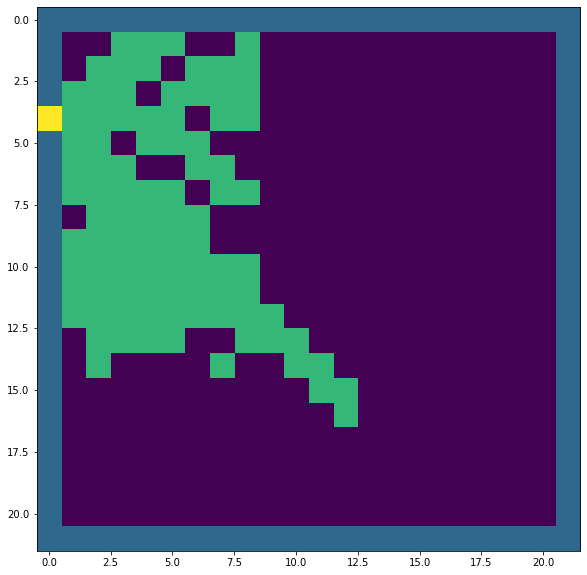

t = 13


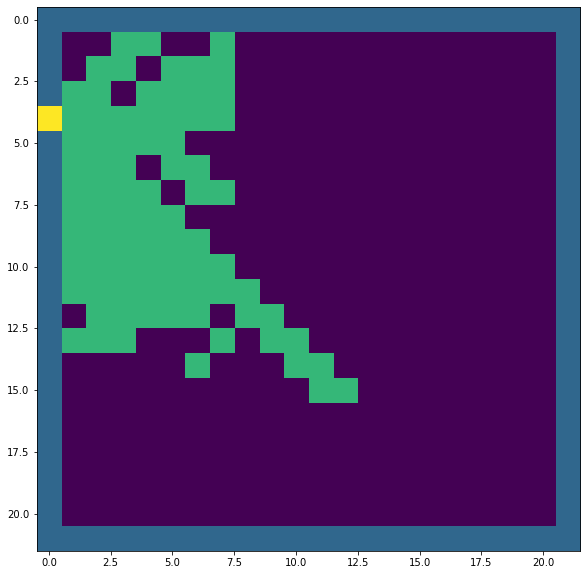

t = 14


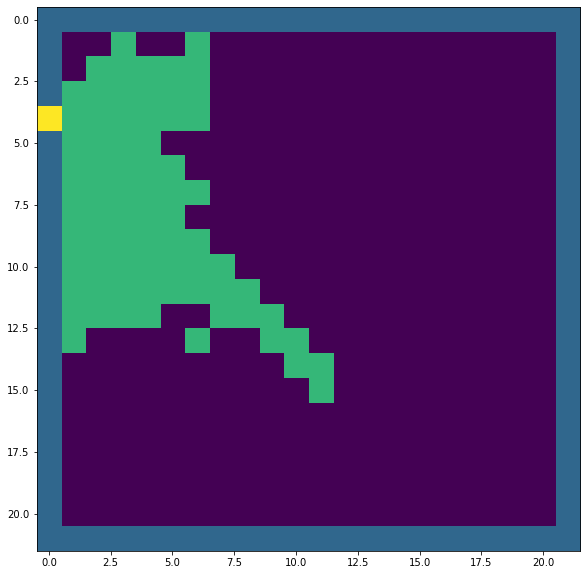

t = 15


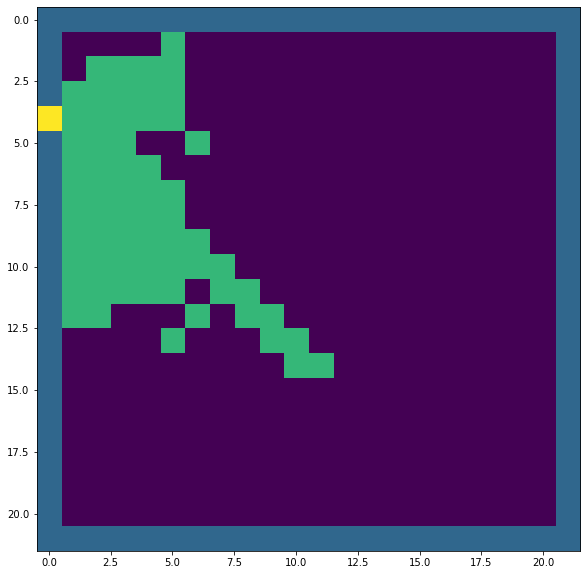

t = 16


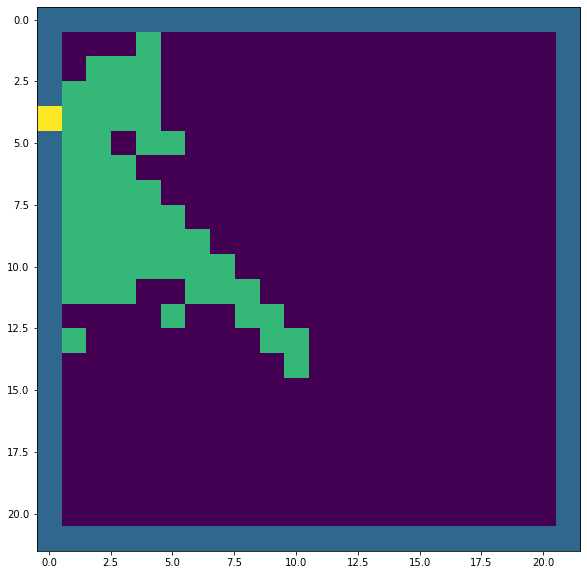

t = 17


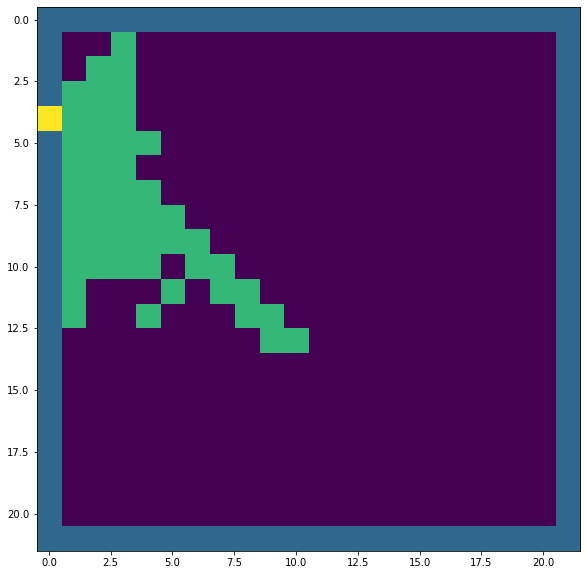

t = 18


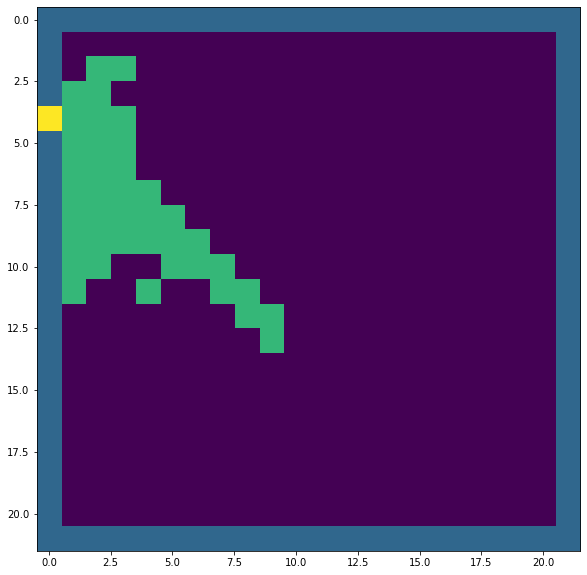

t = 19


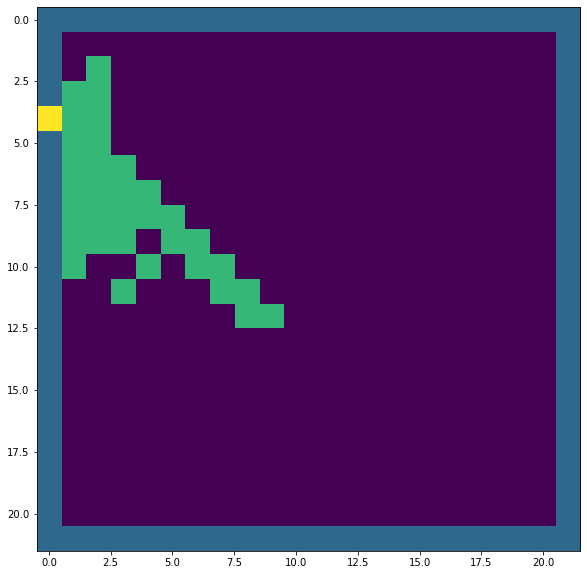

t = 20


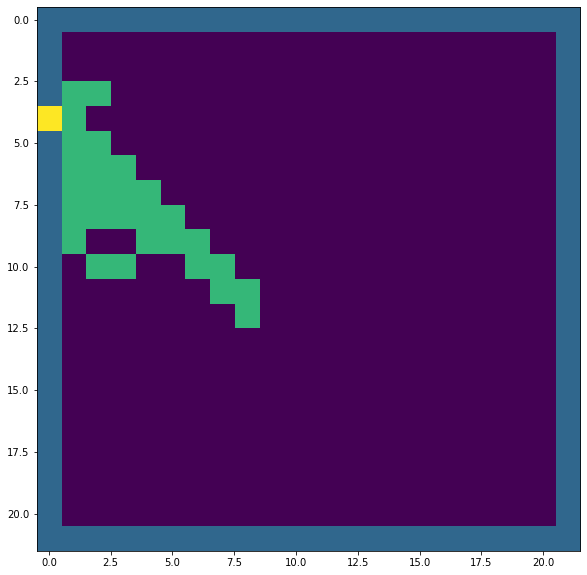

t = 21


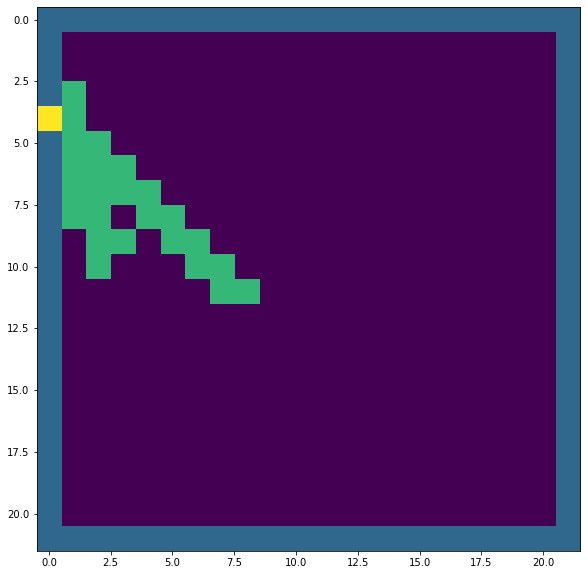

t = 22


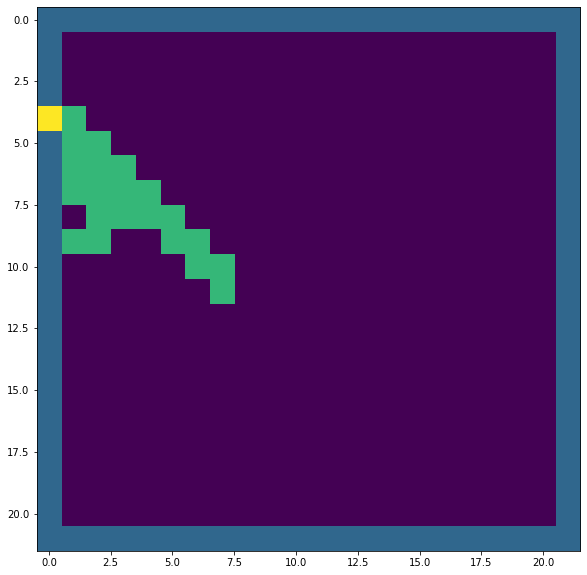

t = 23


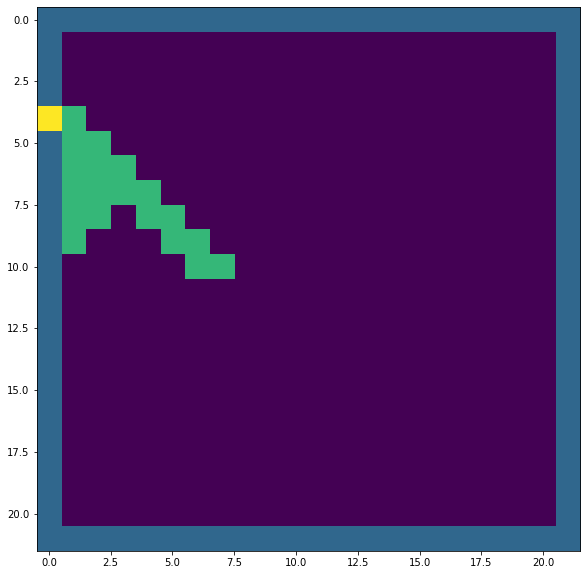

t = 24


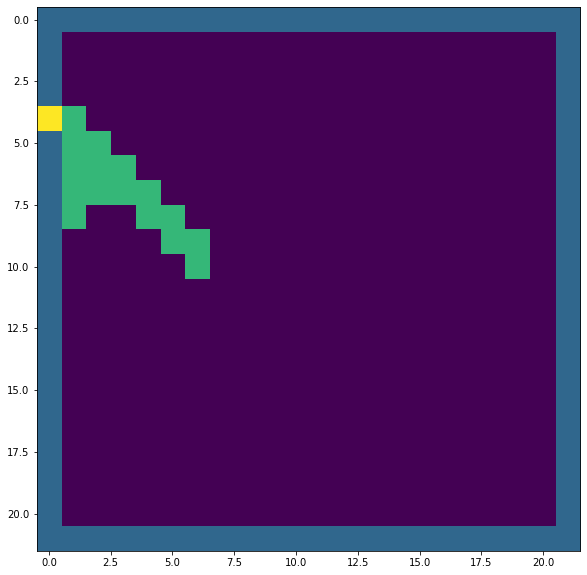

t = 25


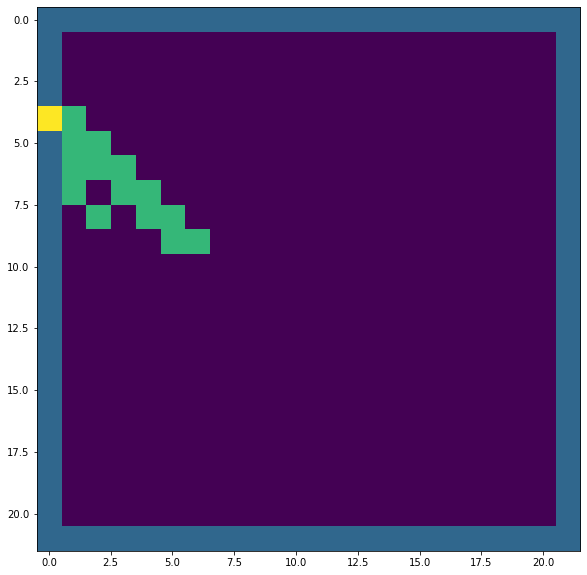

t = 26


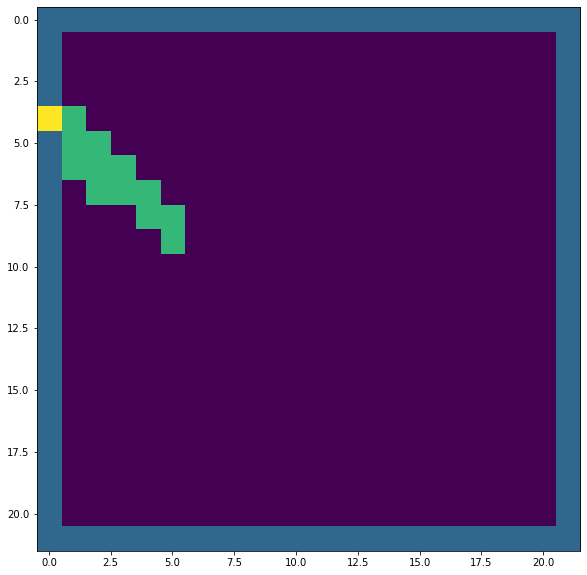

t = 27


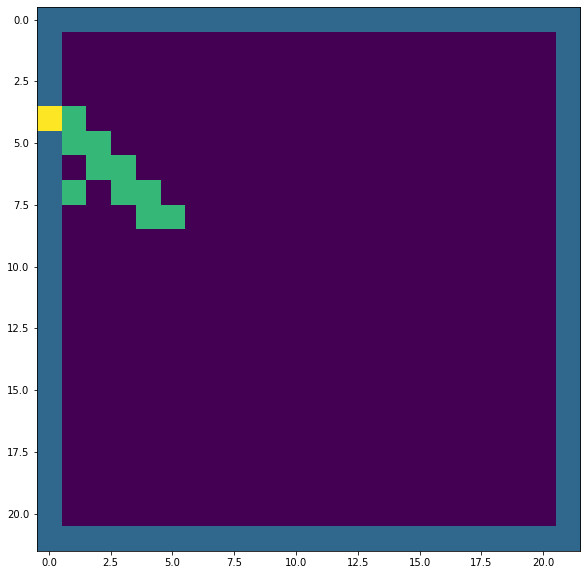

t = 28


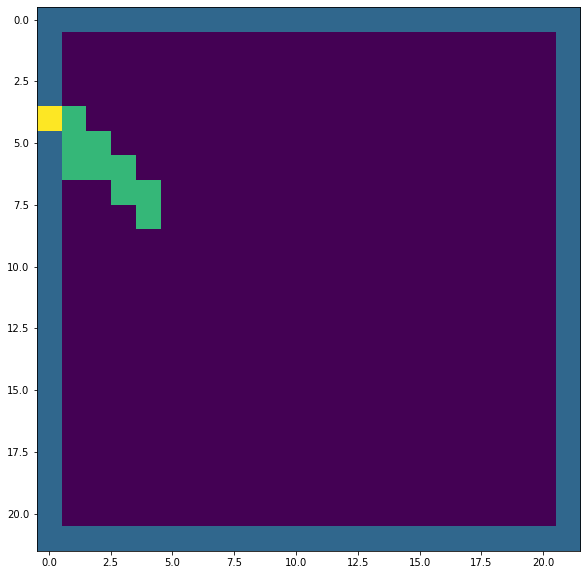

t = 29


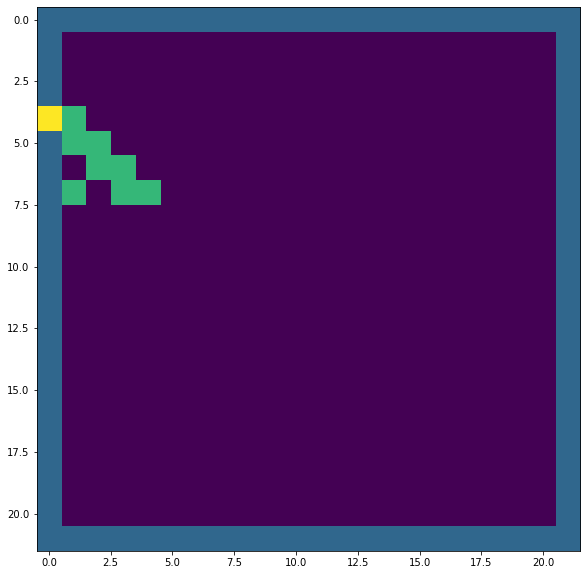

t = 30


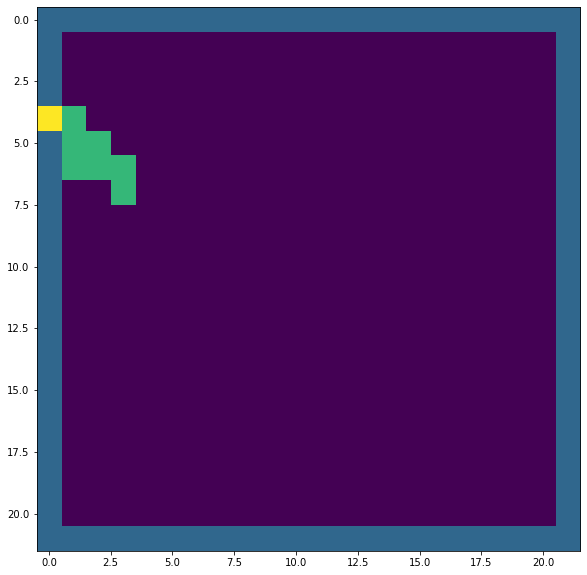

t = 31


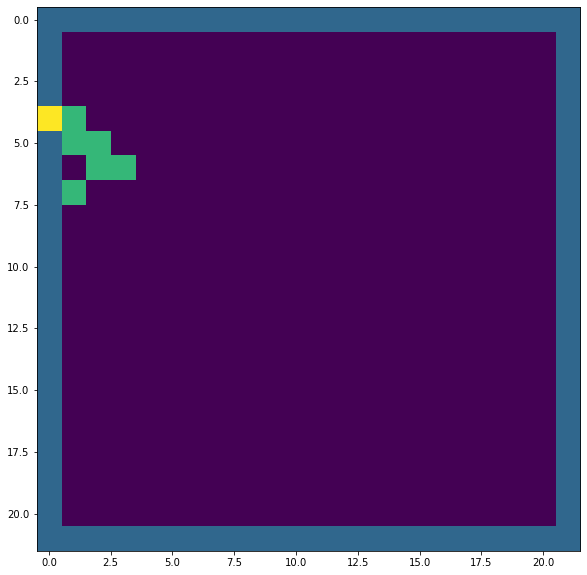

t = 32


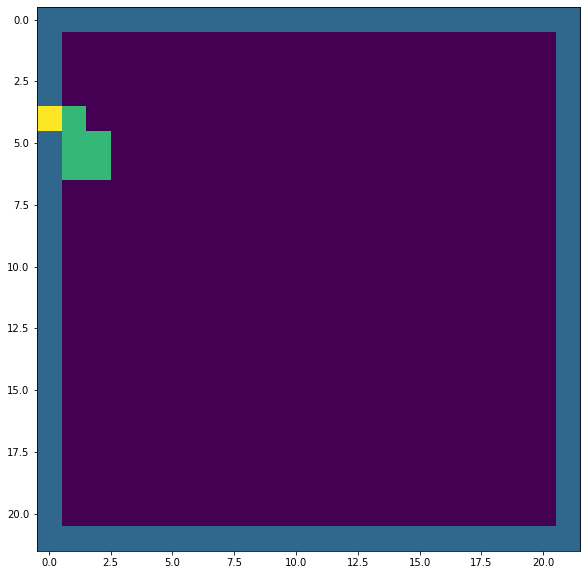

t = 33


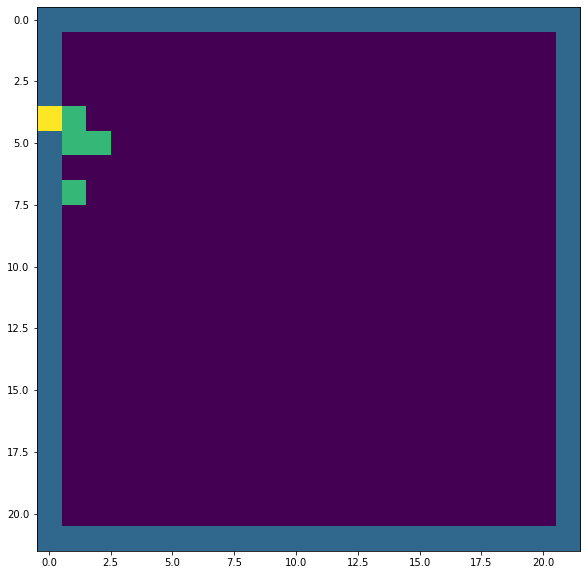

t = 34


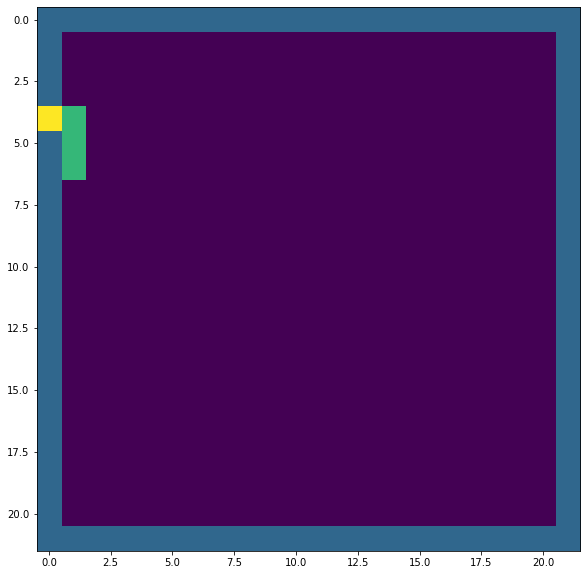

t = 35


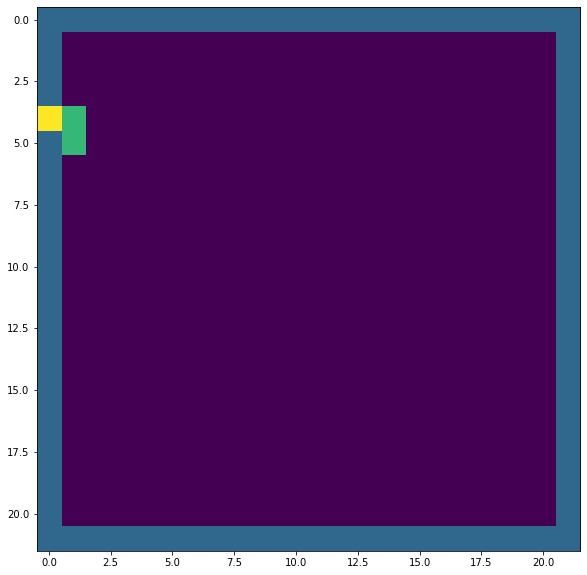

t = 36


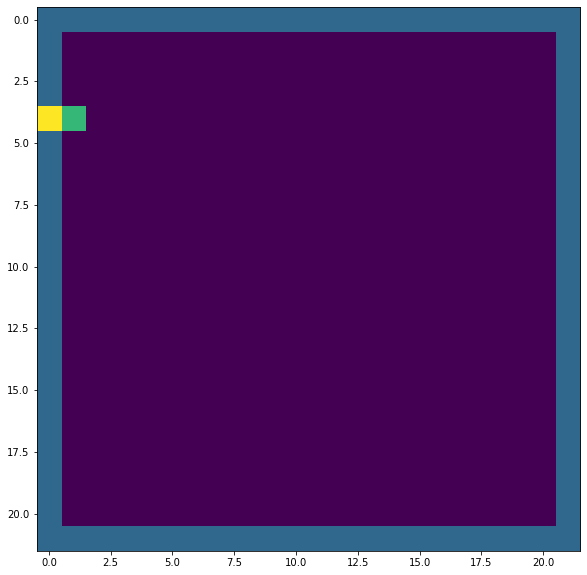

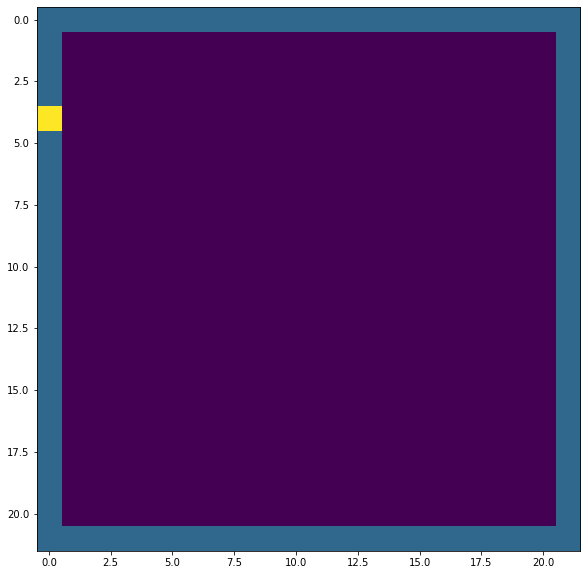

In [32]:
sim_return = simulate_evacuation(20, 250)
num_agents.append(sim_return[0])
ts.append(sim_return[1])

In [33]:
print(num_agents)
print(ts)

[10, 50, 100, 150, 200, 250]
[21, 39, 42, 38, 39, 37]


In [34]:
t = ts[-1]

# Create the frames
frames = []
imgs = []

for j in range(1,t+1):
    imgs.append("images/agents250pic"+str(j)+".png")

with imageio.get_writer('gifs/evac_simulation_agents250.gif', mode='I') as writer:
    for filename in imgs:
        image = imageio.imread(filename)
        writer.append_data(image)

<img src='gifs/evac_simulation_agents250.gif' width=400>

## agents = 300

(8, 0)
t = 0


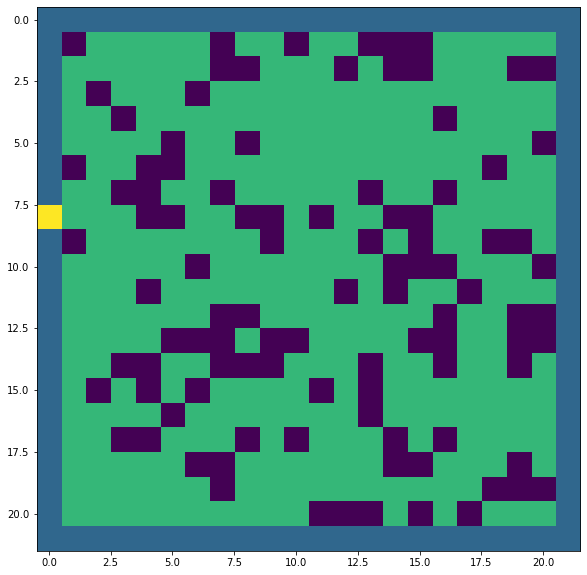

t = 1


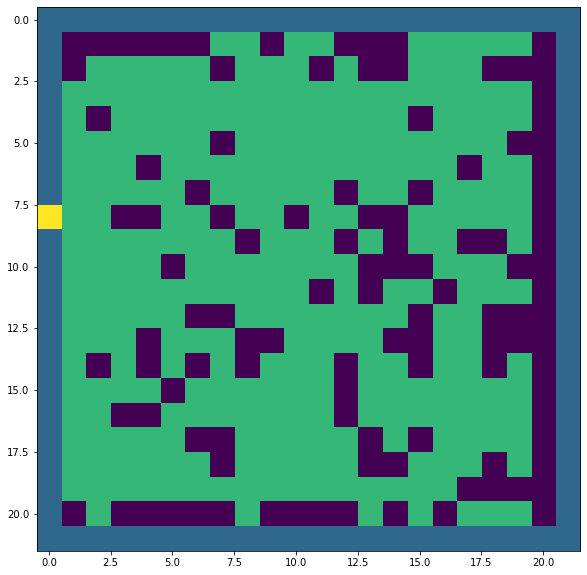

t = 2


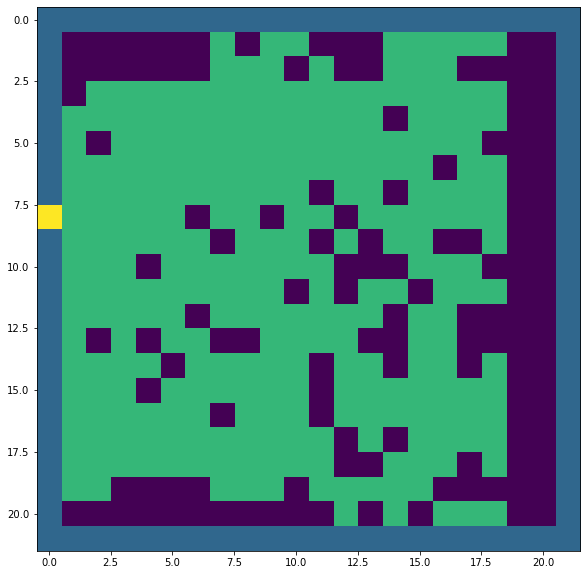

t = 3


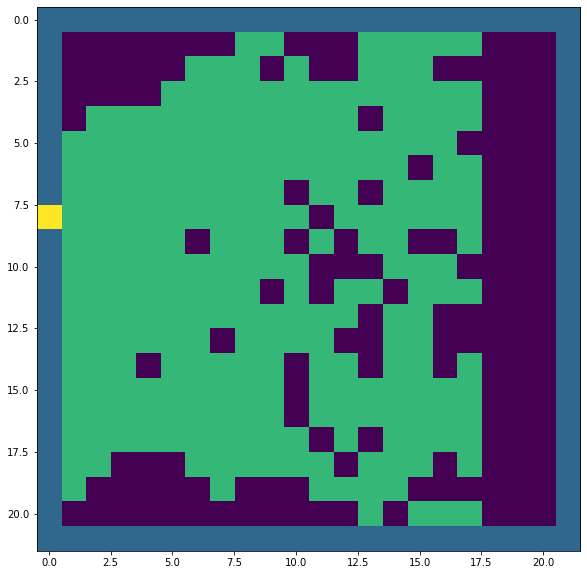

t = 4


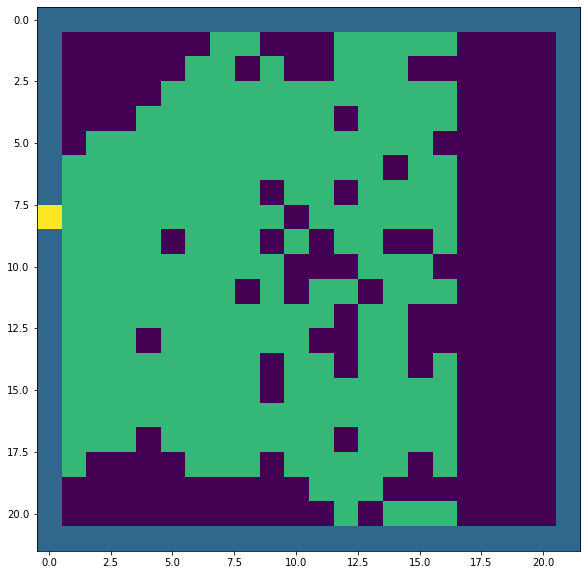

t = 5


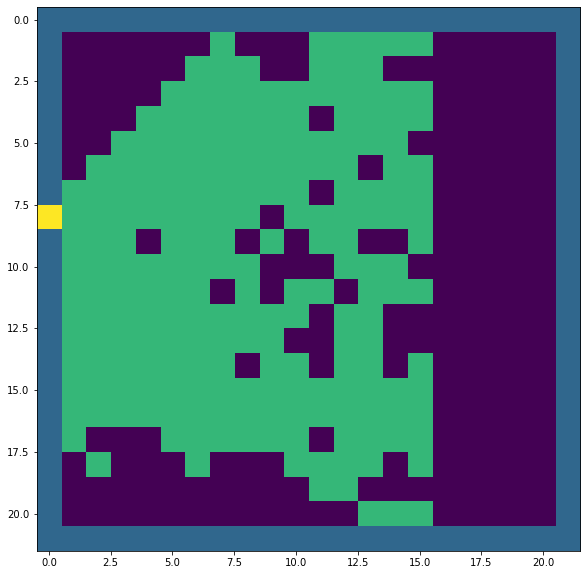

t = 6


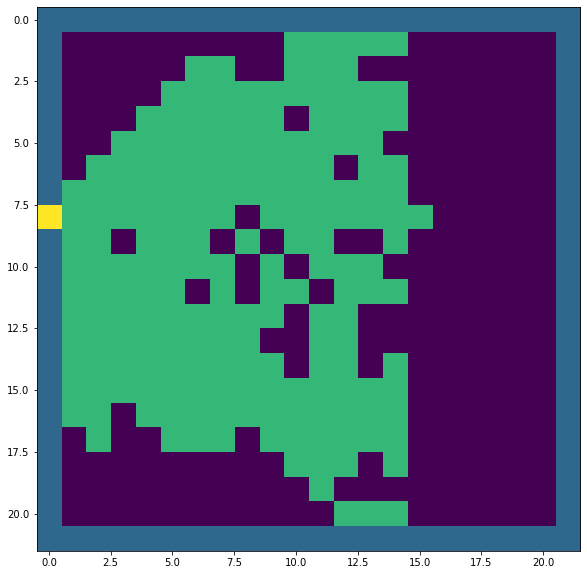

t = 7


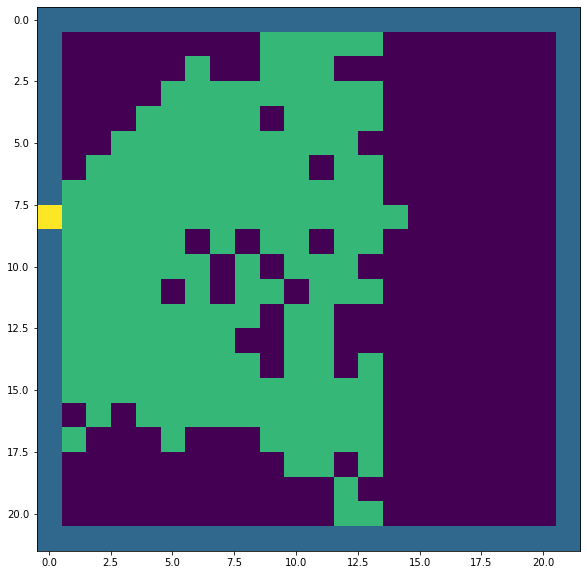

t = 8


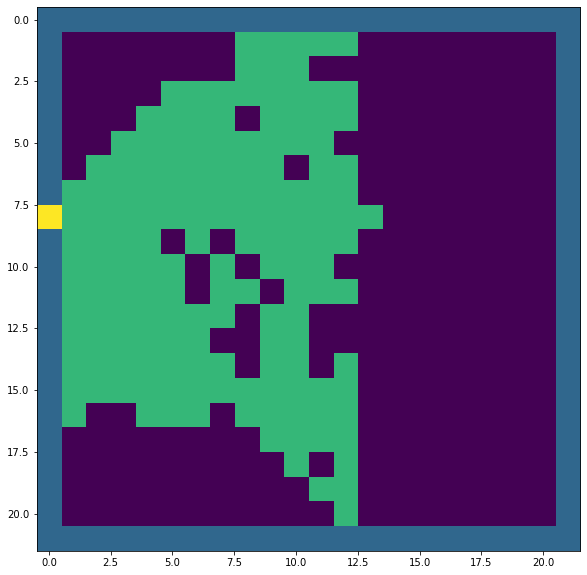

t = 9


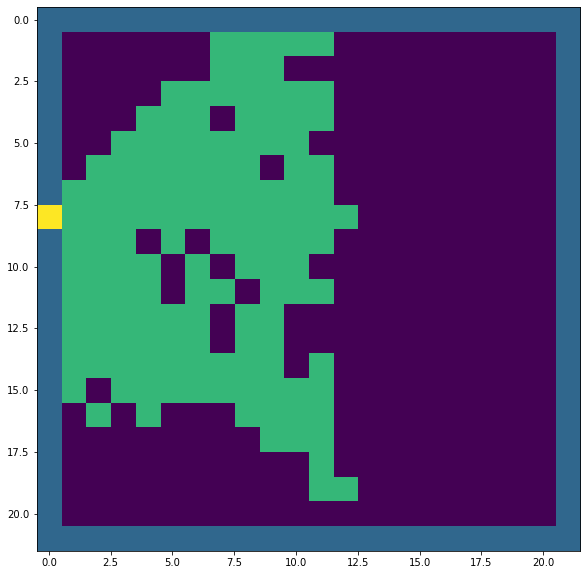

t = 10


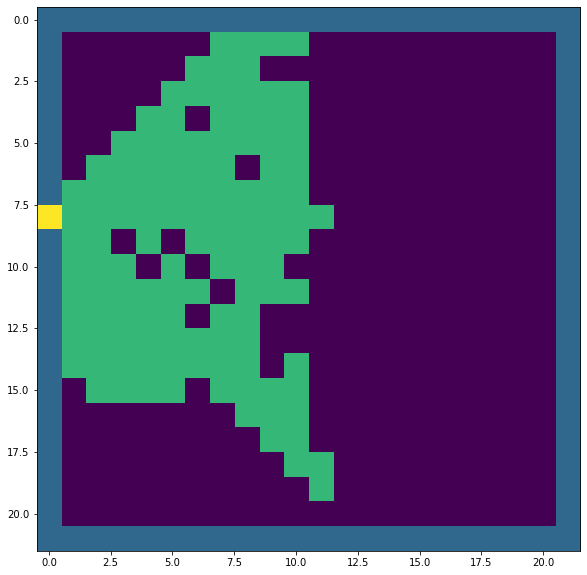

t = 11


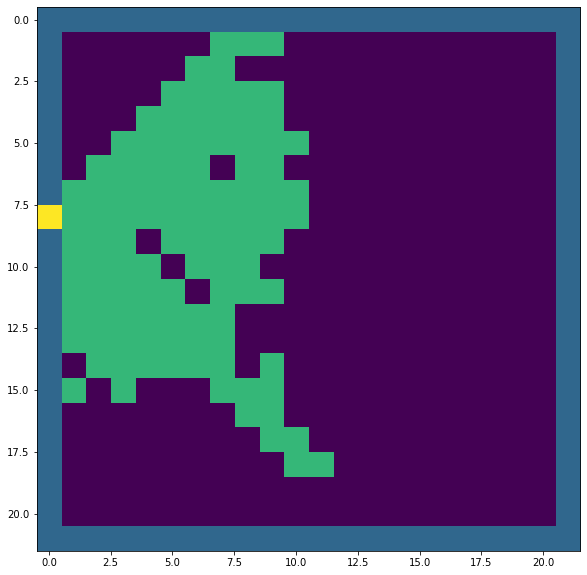

t = 12


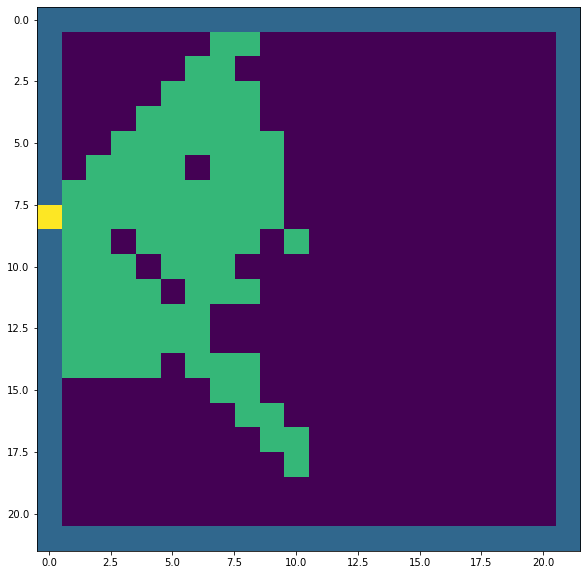

t = 13


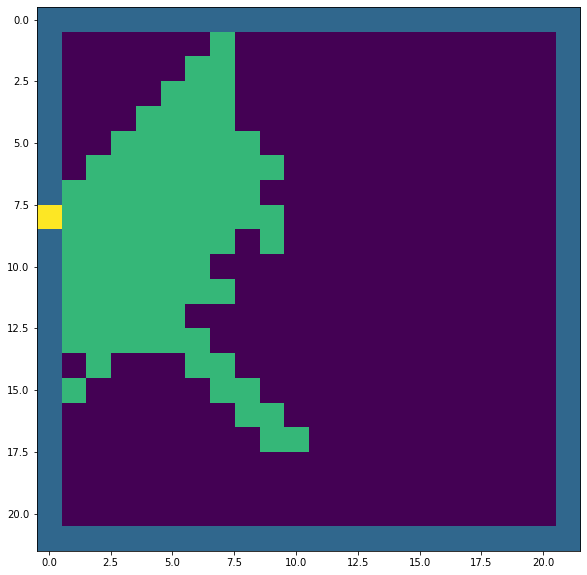

t = 14


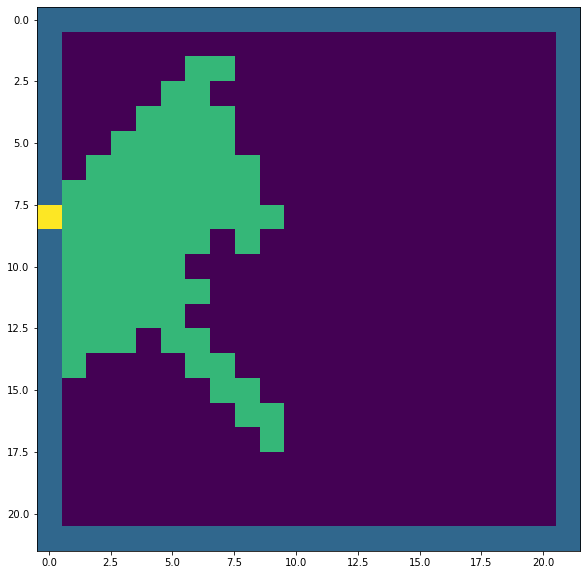

t = 15


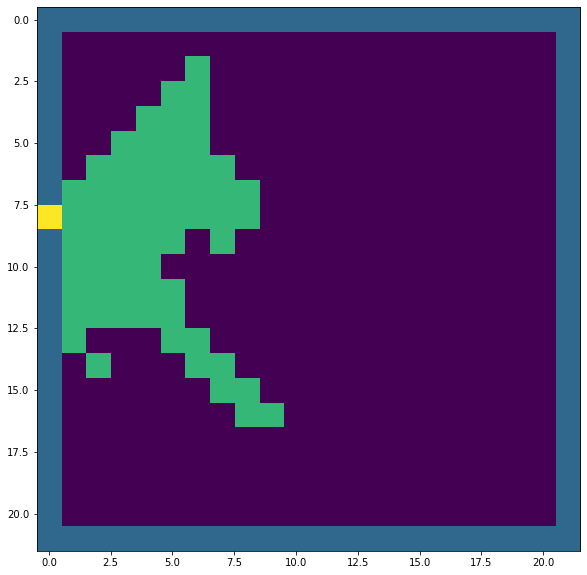

t = 16


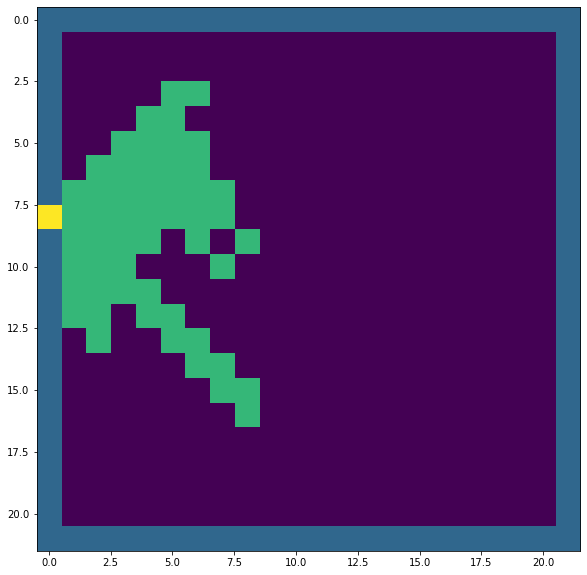

t = 17


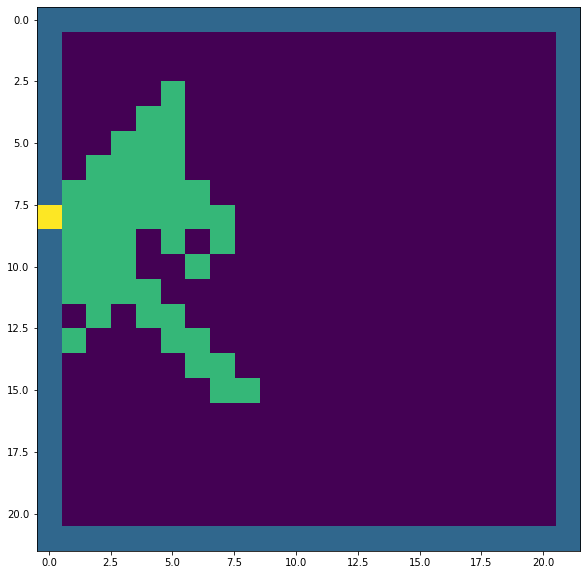

t = 18


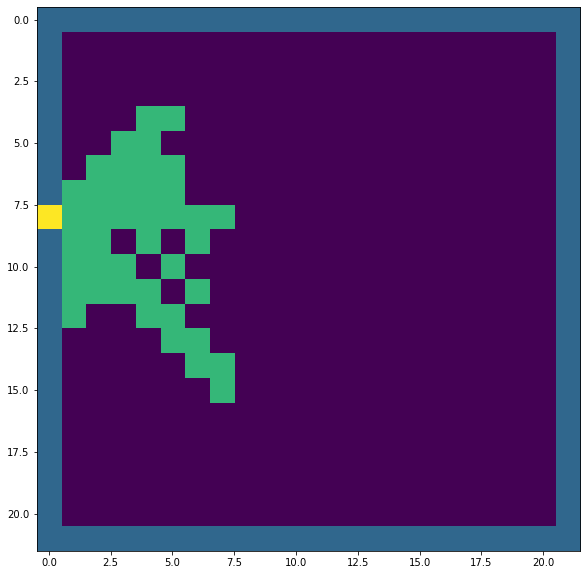

t = 19


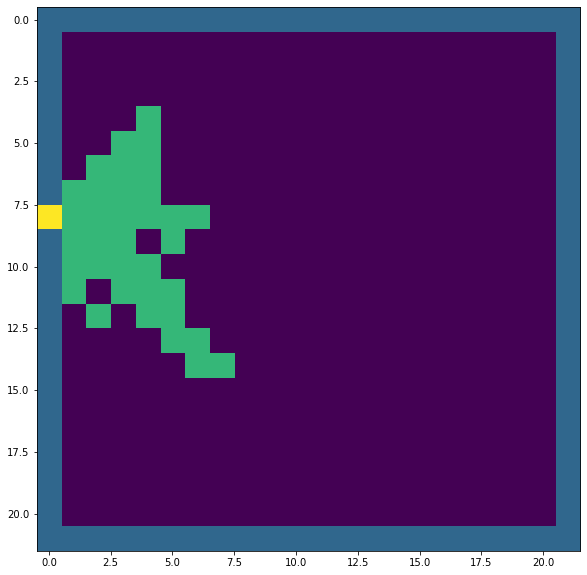

t = 20


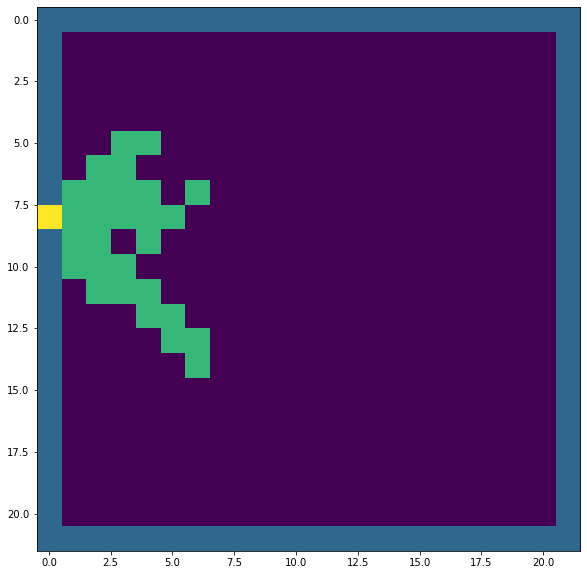

t = 21


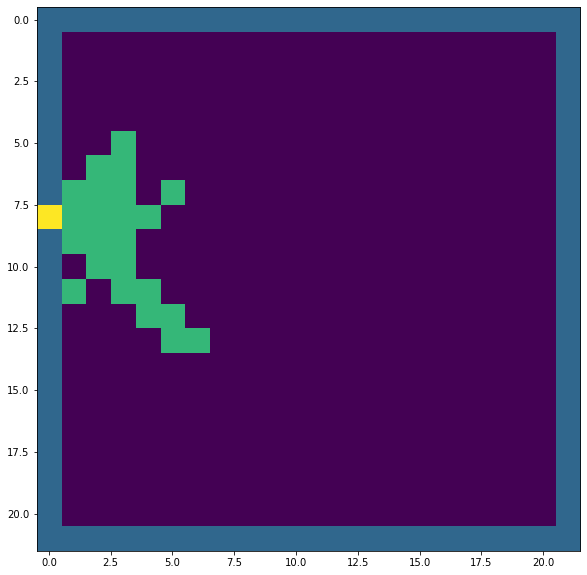

t = 22


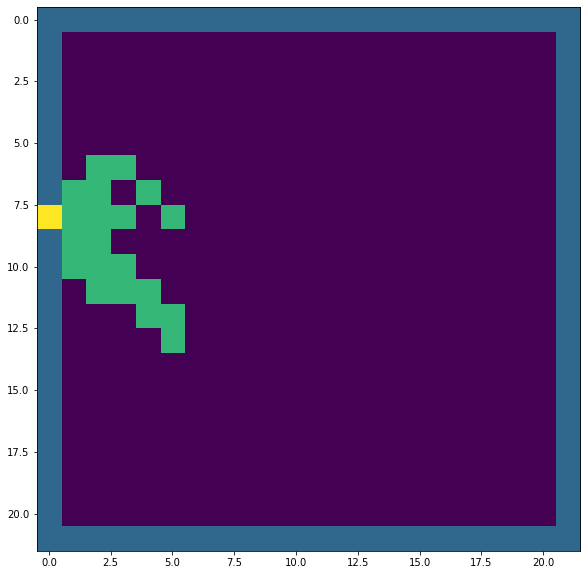

t = 23


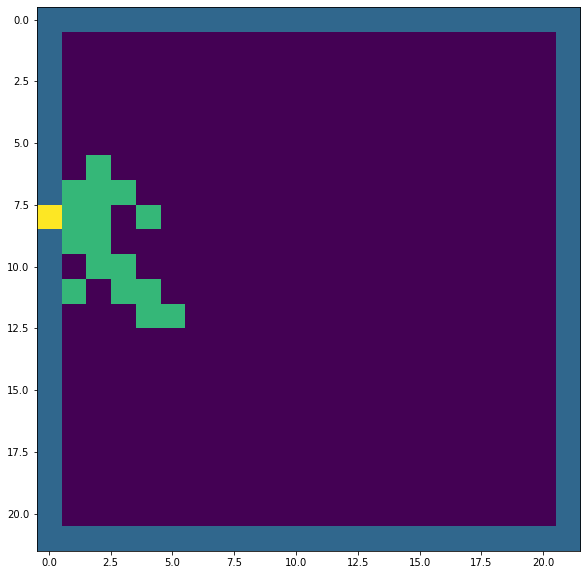

t = 24


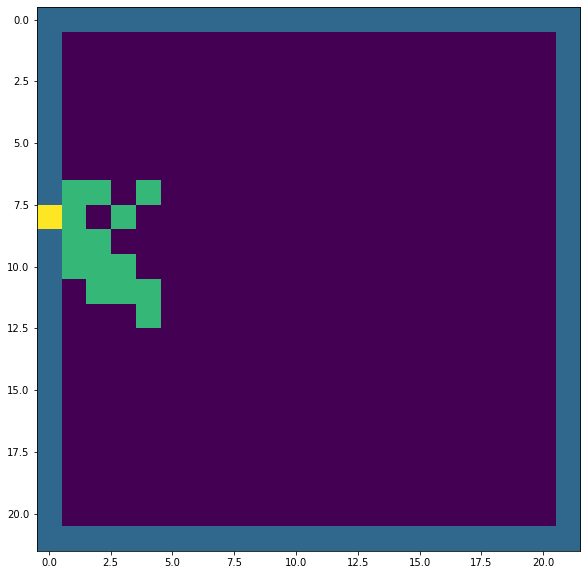

t = 25


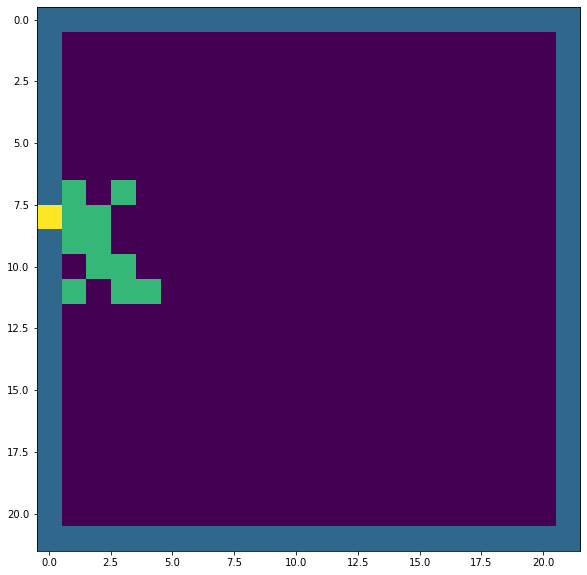

t = 26


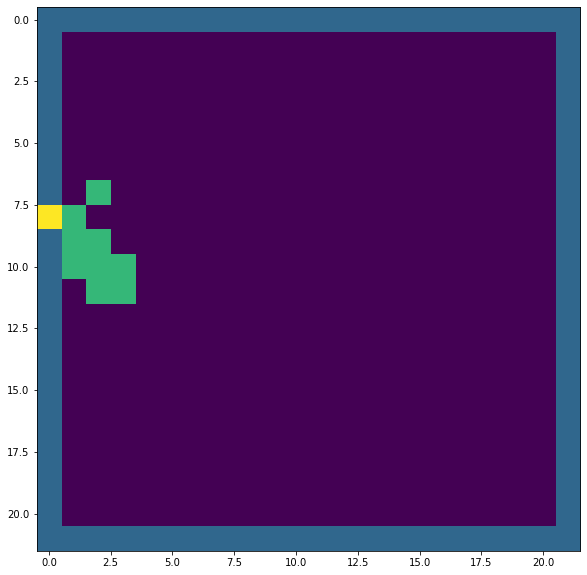

t = 27


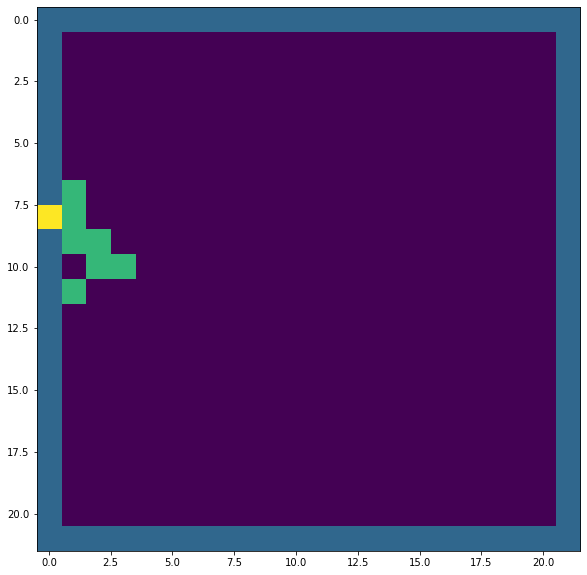

t = 28


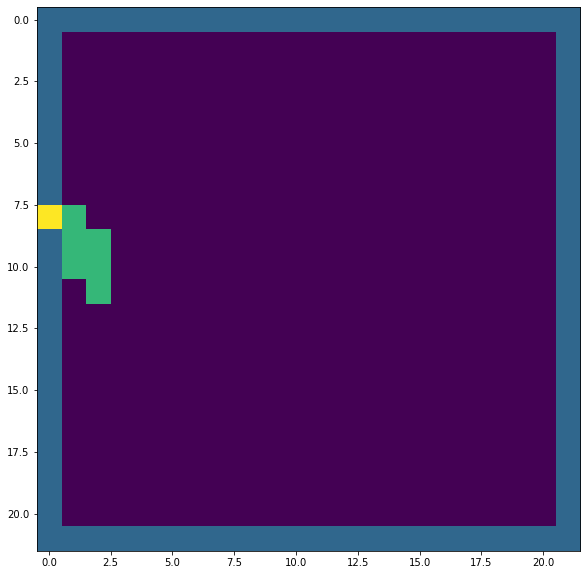

t = 29


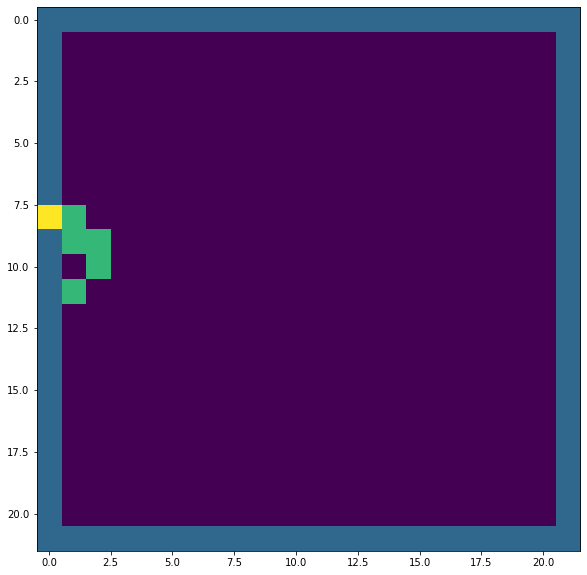

t = 30


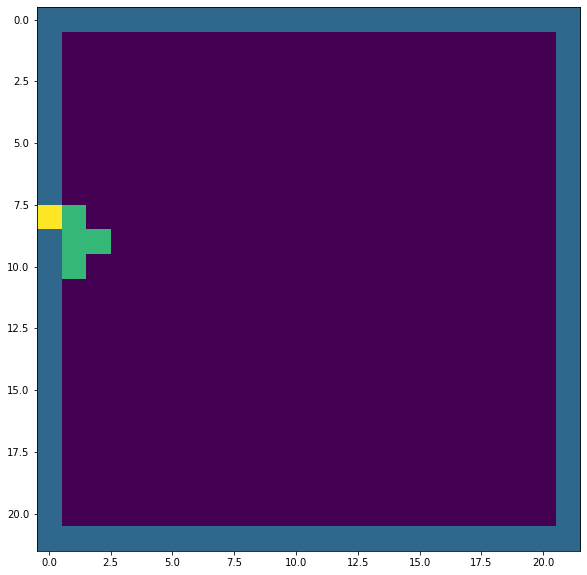

t = 31


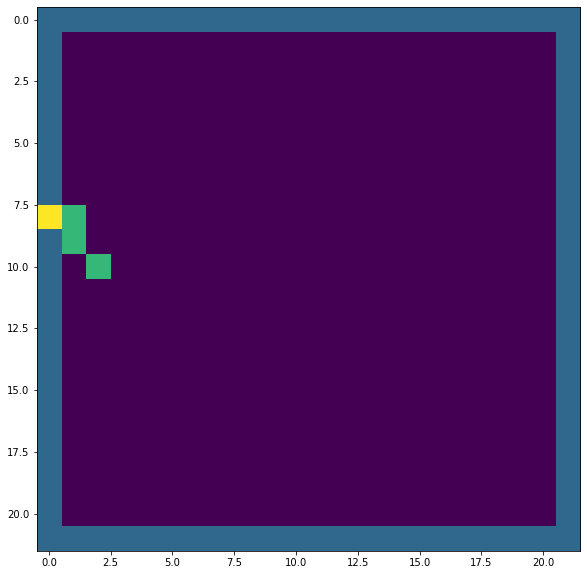

t = 32


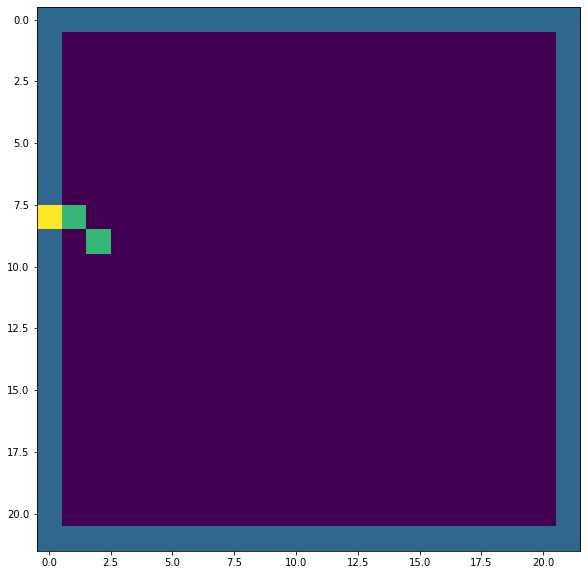

t = 33


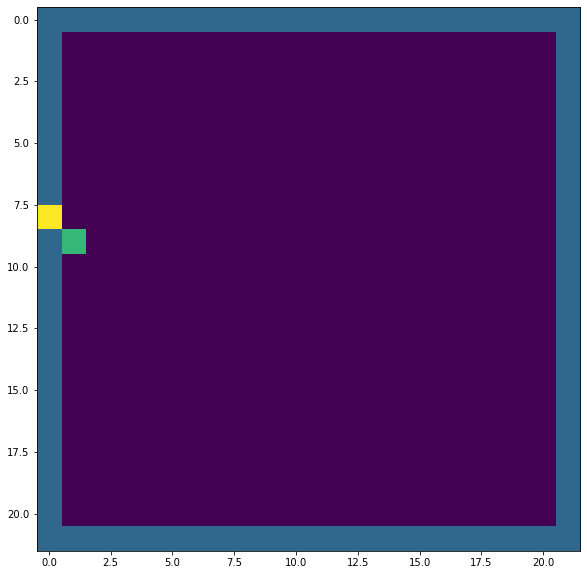

t = 34


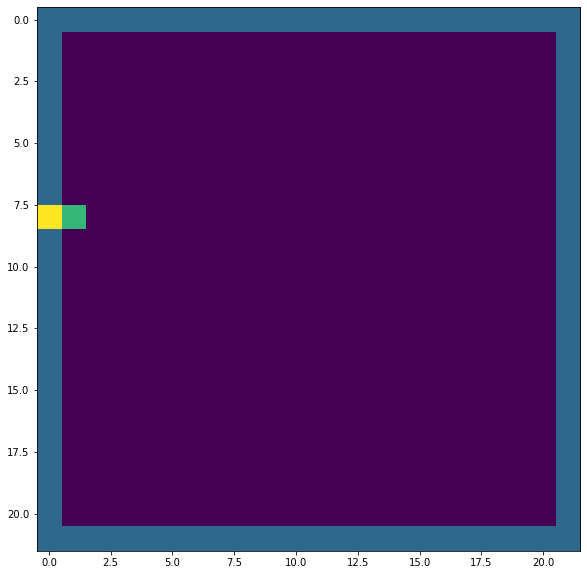

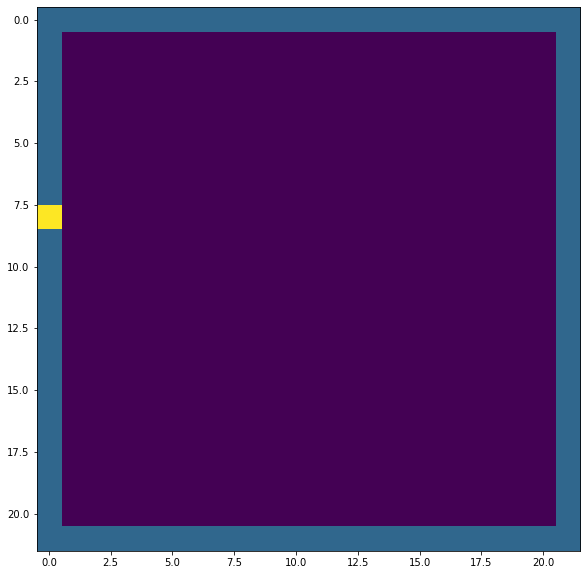

In [35]:
sim_return = simulate_evacuation(20, 300)
num_agents.append(sim_return[0])
ts.append(sim_return[1])

In [36]:
print(num_agents)
print(ts)

[10, 50, 100, 150, 200, 250, 300]
[21, 39, 42, 38, 39, 37, 35]


In [37]:
t = ts[-1]

# Create the frames
frames = []
imgs = []

for j in range(1,t+1):
    imgs.append("images/agents300pic"+str(j)+".png")

with imageio.get_writer('gifs/evac_simulation_agents300.gif', mode='I') as writer:
    for filename in imgs:
        image = imageio.imread(filename)
        writer.append_data(image)

<img src='gifs/evac_simulation_agents300.gif' width=400>

## agents = 350

(18, 0)
t = 0


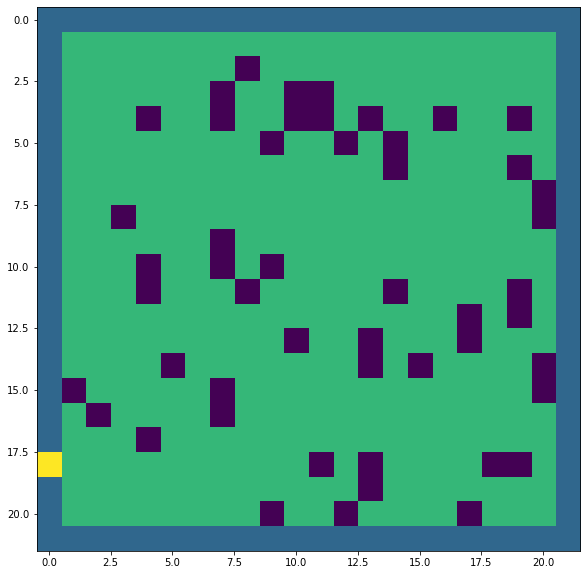

t = 1


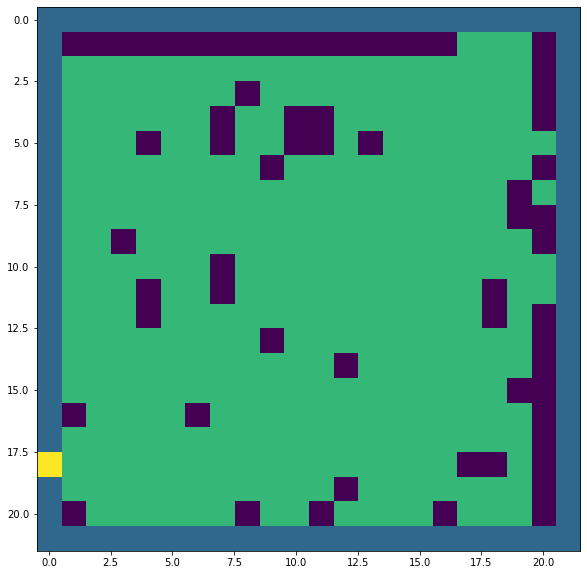

t = 2


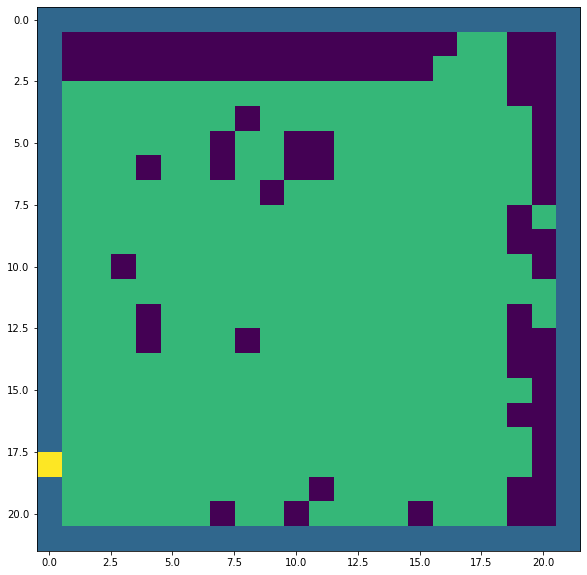

t = 3


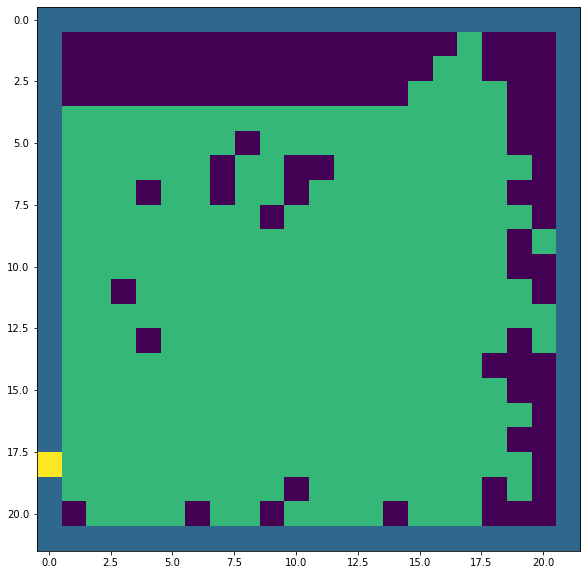

t = 4


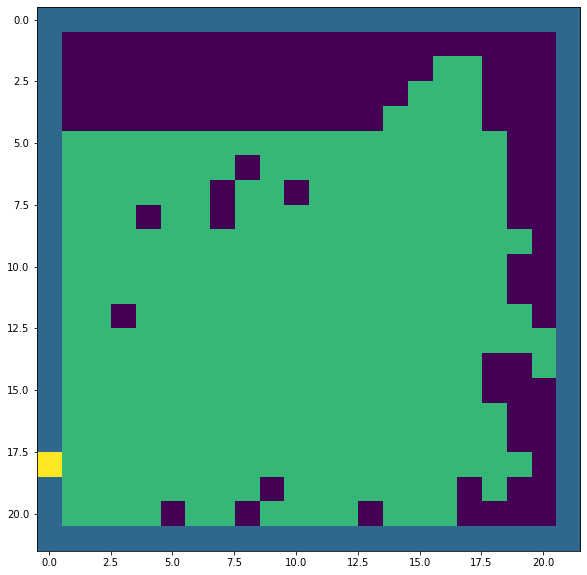

t = 5


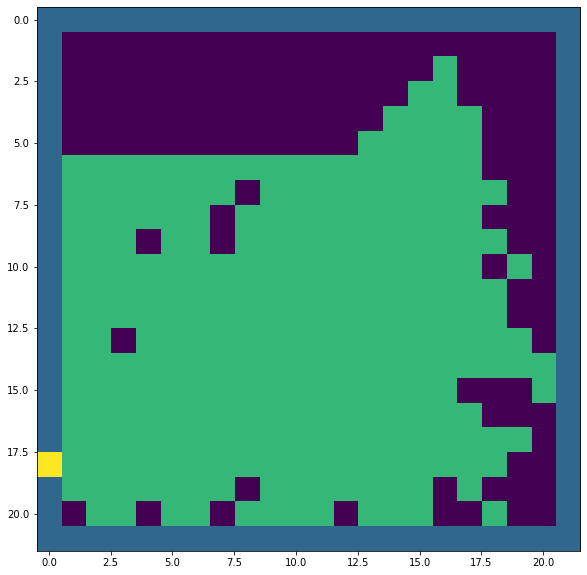

t = 6


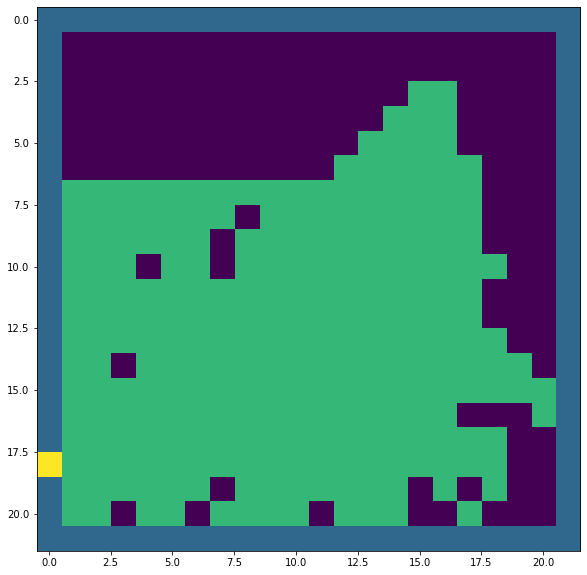

t = 7


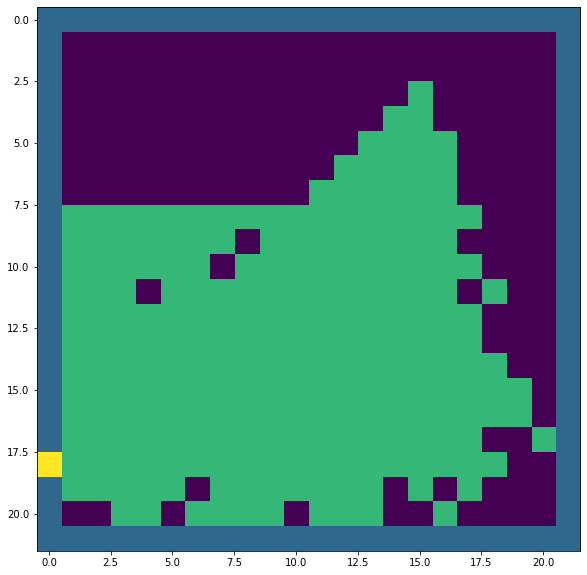

t = 8


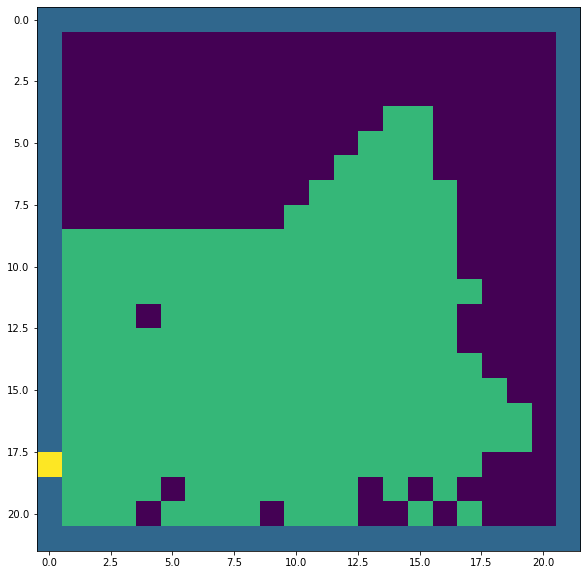

t = 9


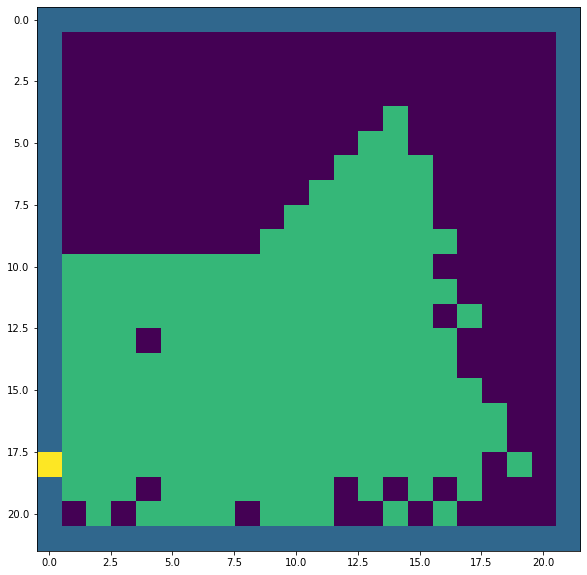

t = 10


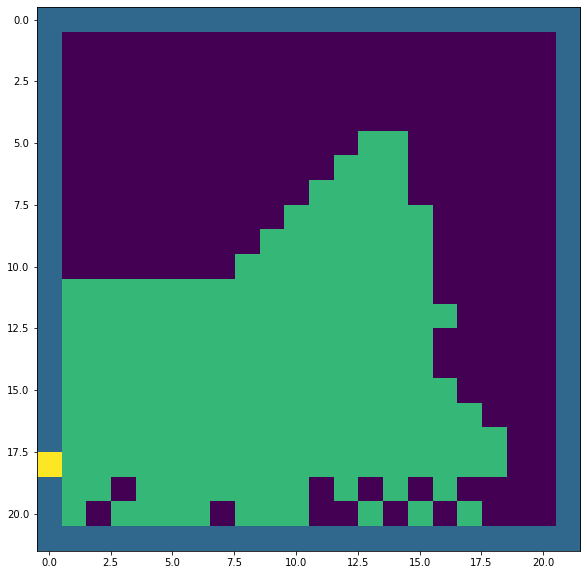

t = 11


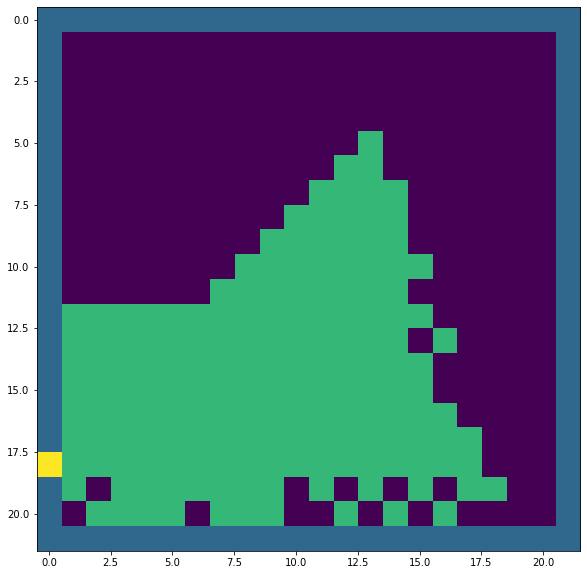

t = 12


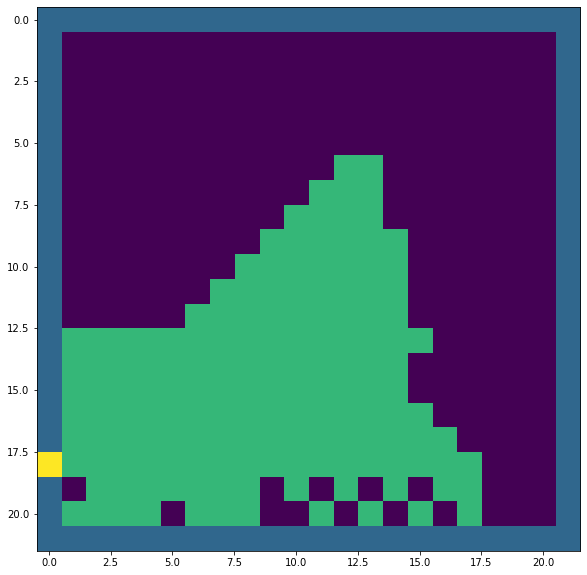

t = 13


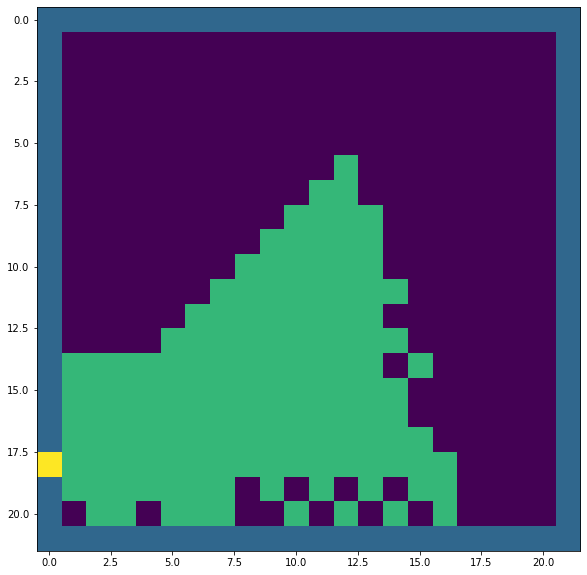

t = 14


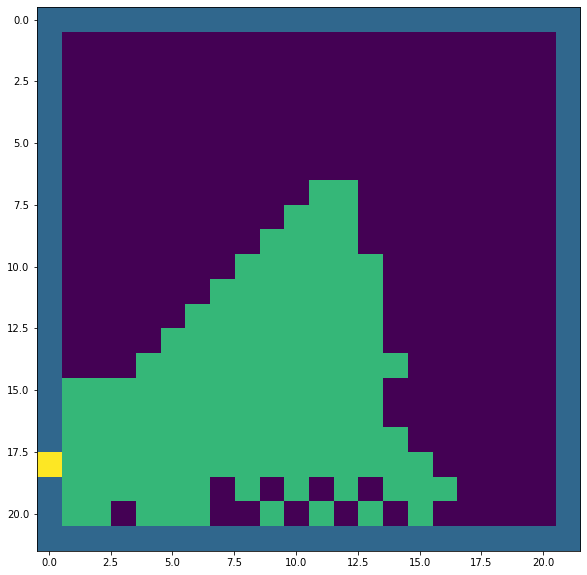

t = 15


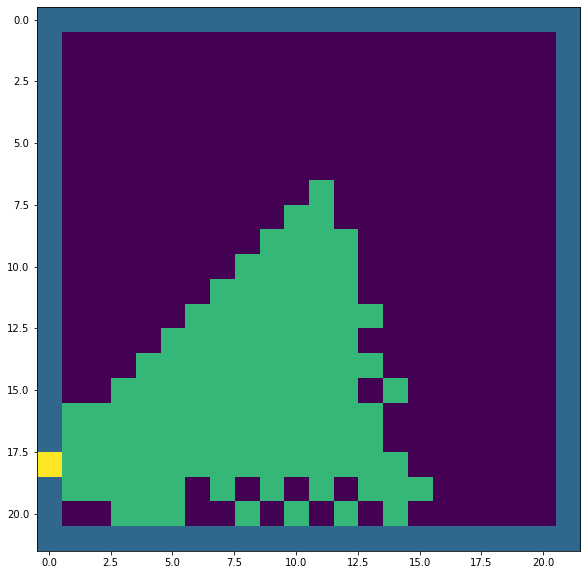

t = 16


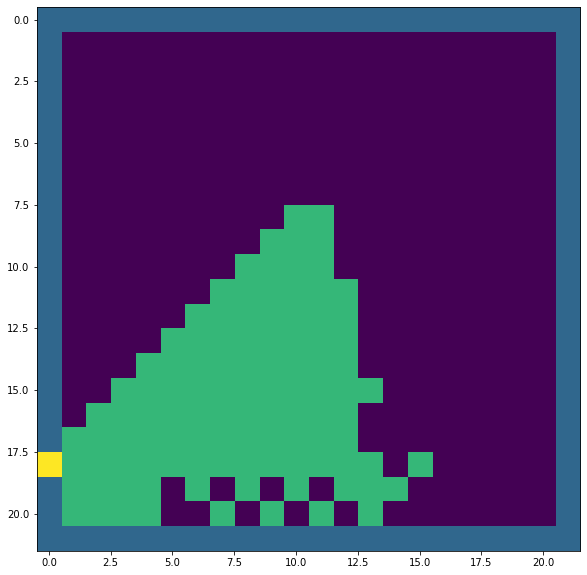

t = 17


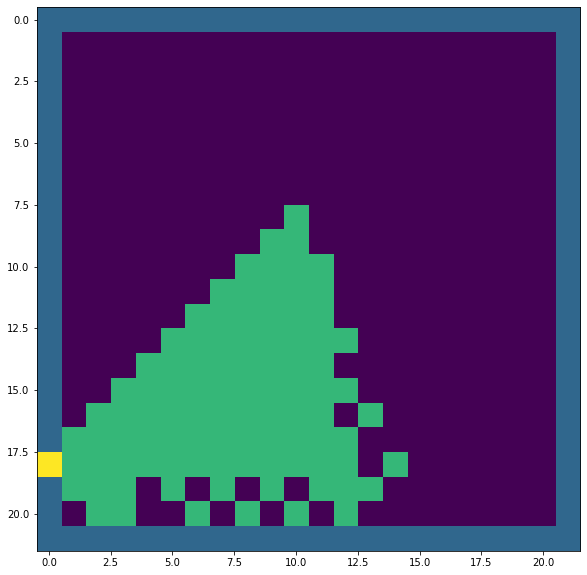

t = 18


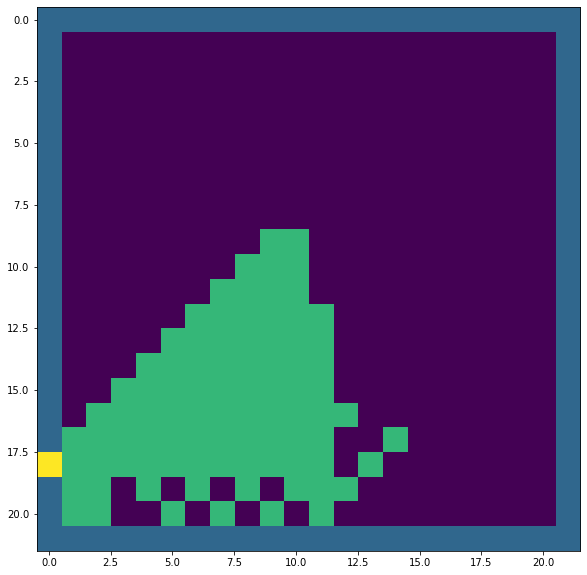

t = 19


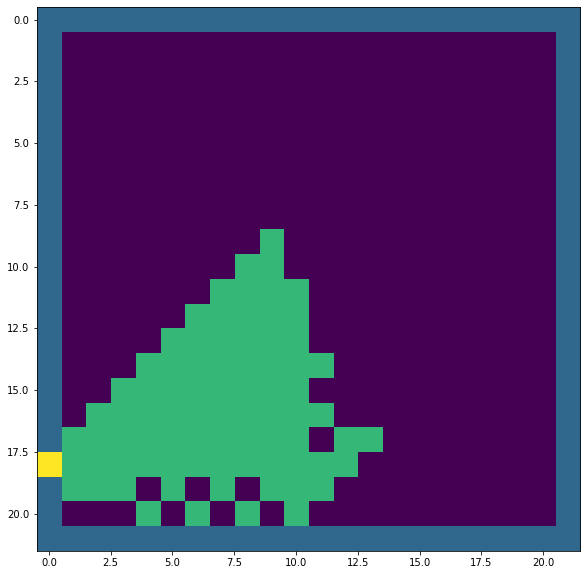

t = 20


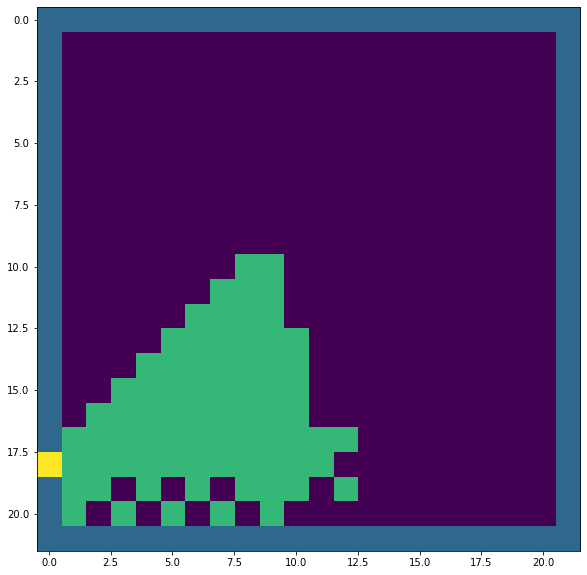

t = 21


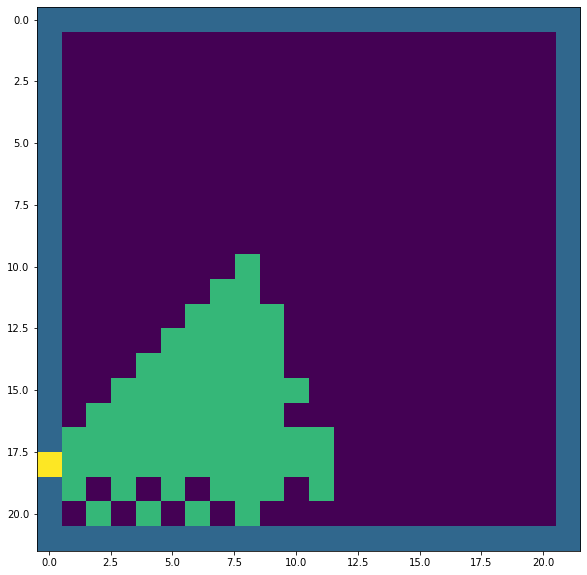

t = 22


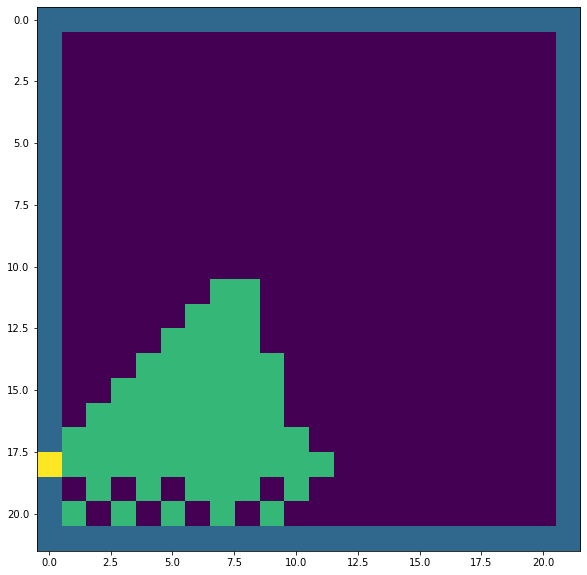

t = 23


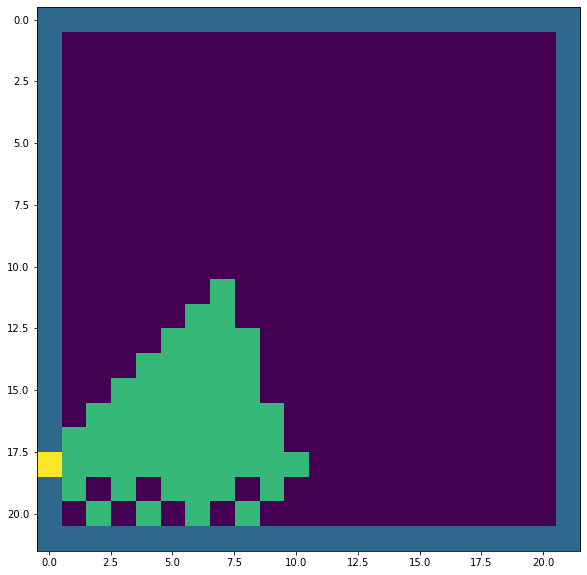

t = 24


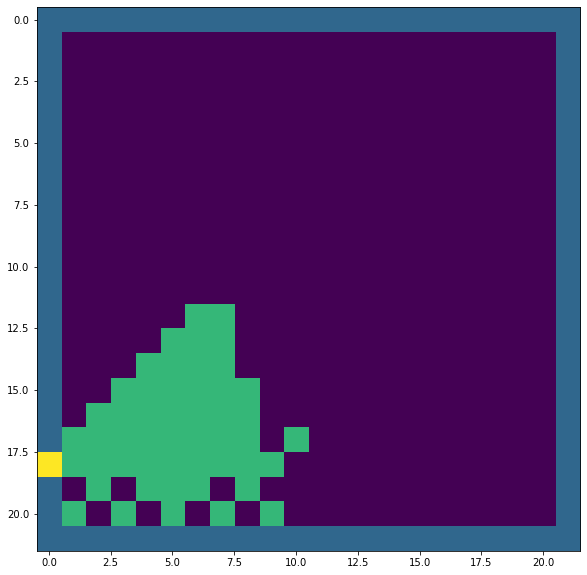

t = 25


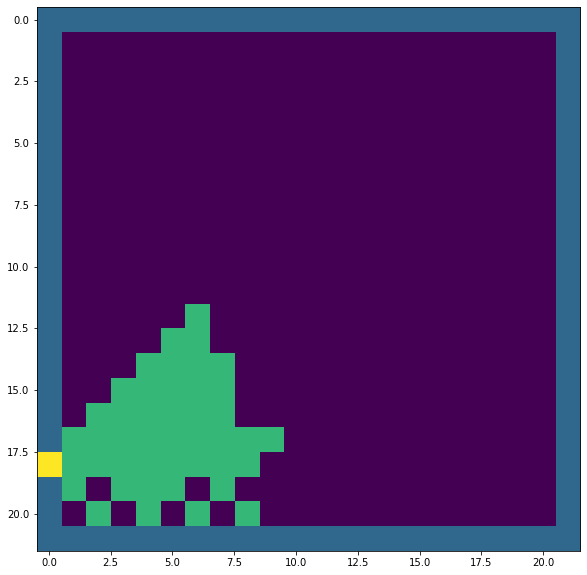

t = 26


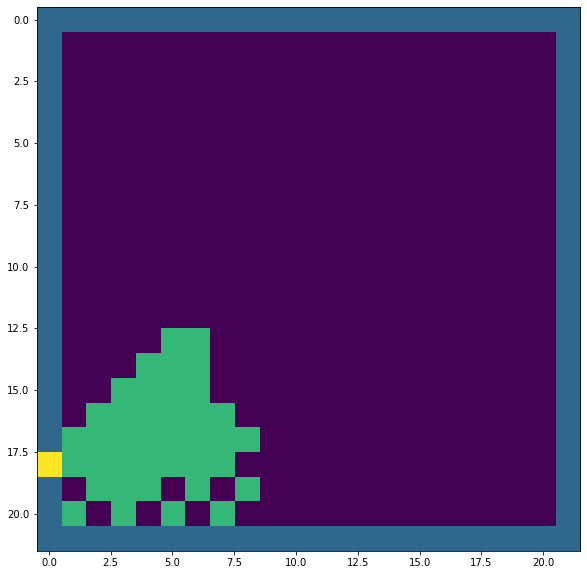

t = 27


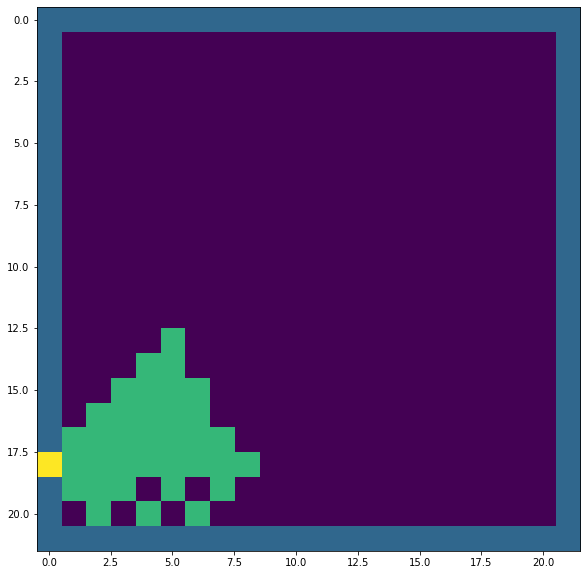

t = 28


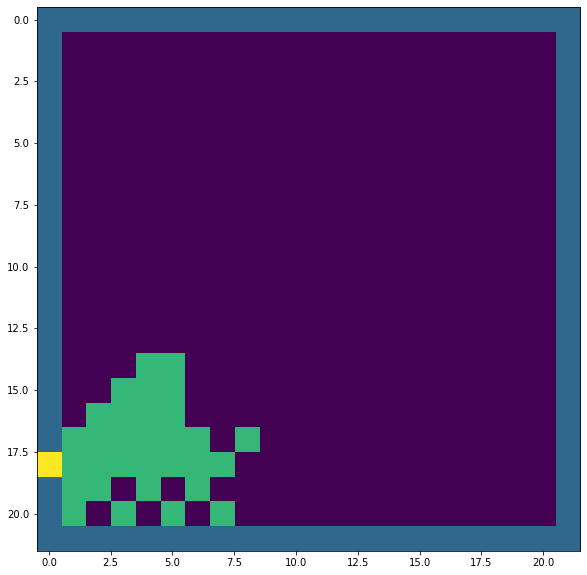

t = 29


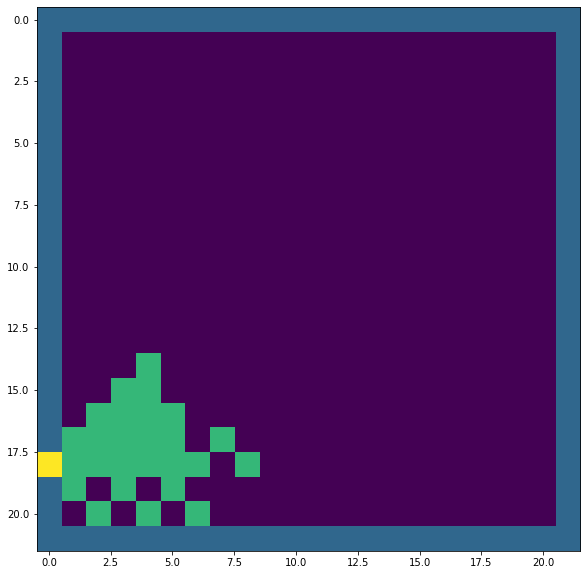

t = 30


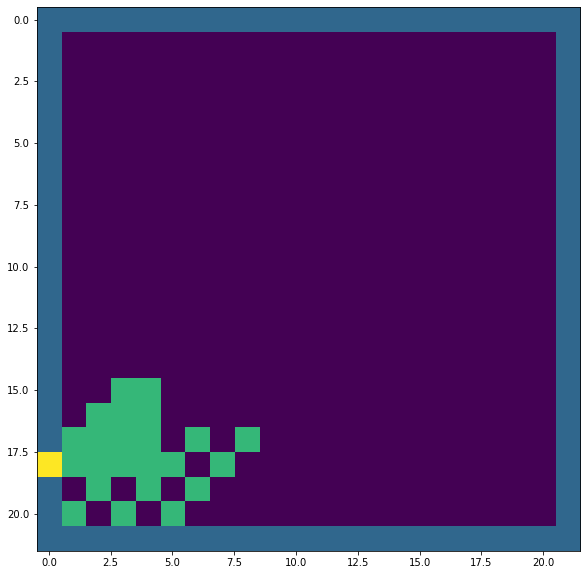

t = 31


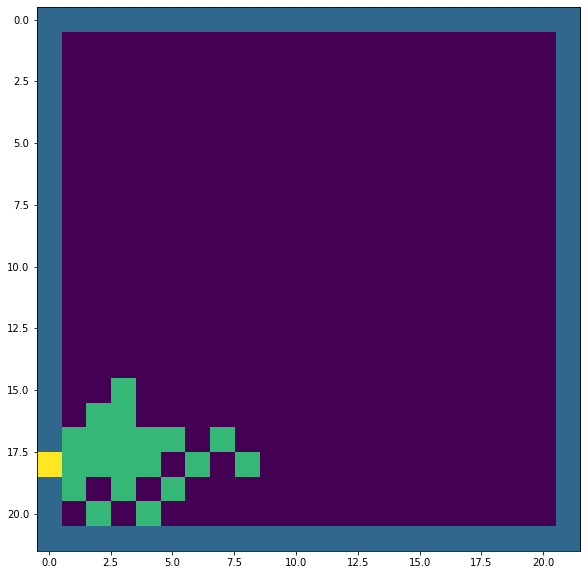

t = 32


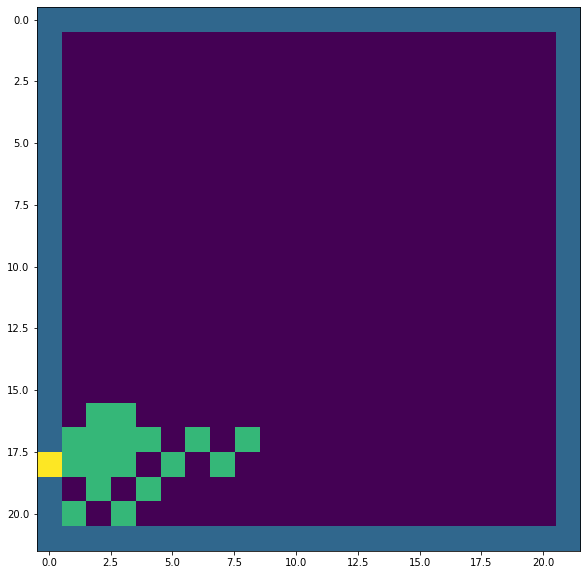

t = 33


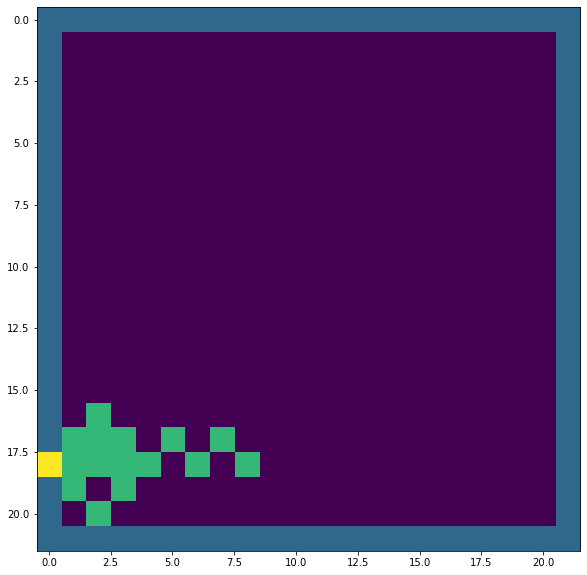

t = 34


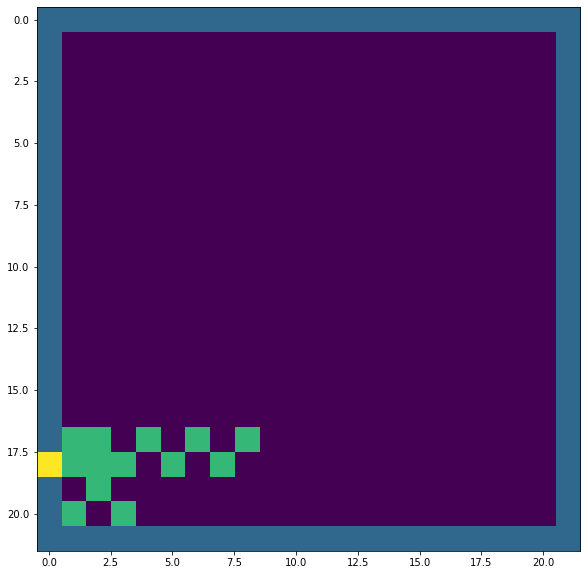

t = 35


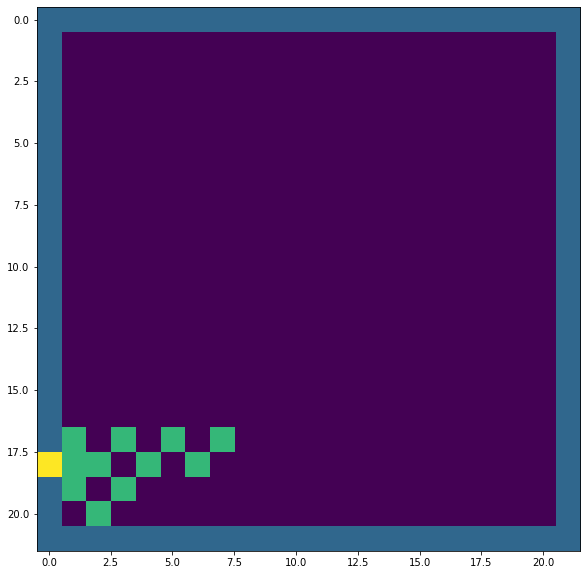

t = 36


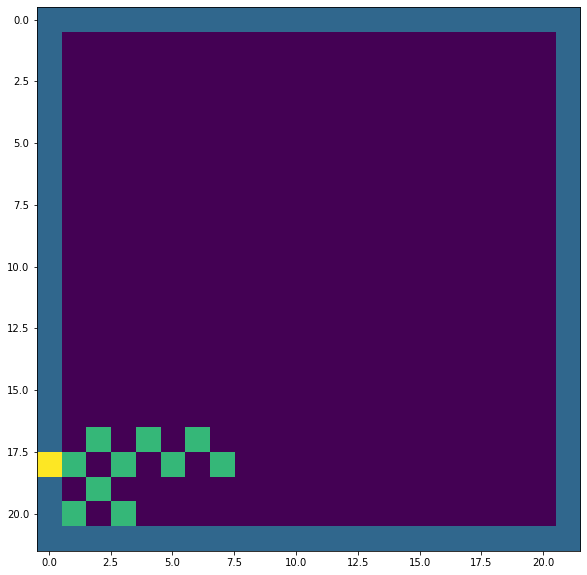

t = 37


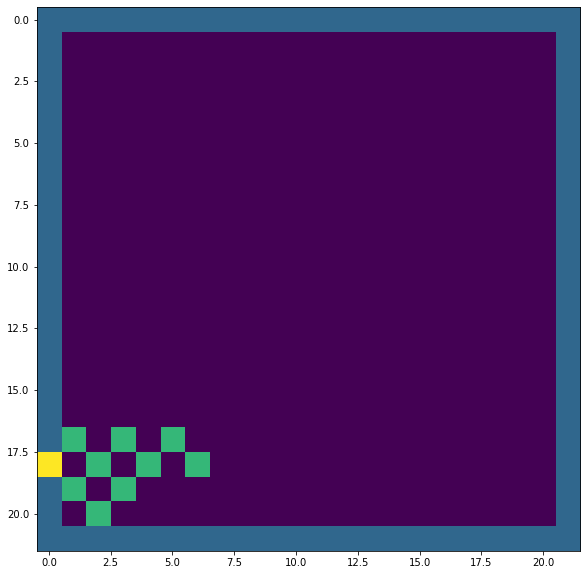

t = 38


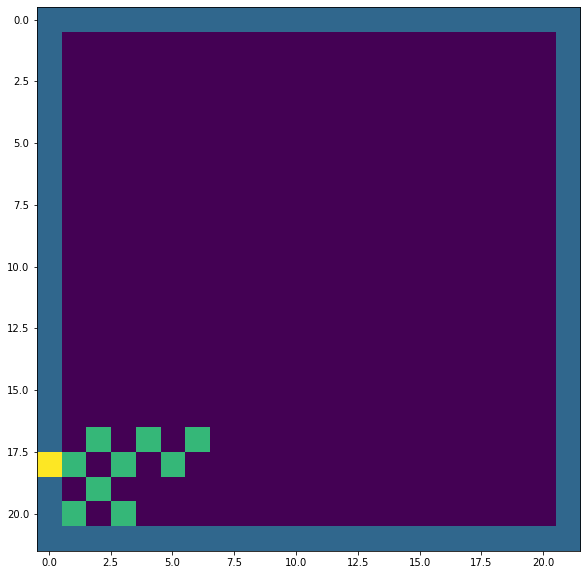

t = 39


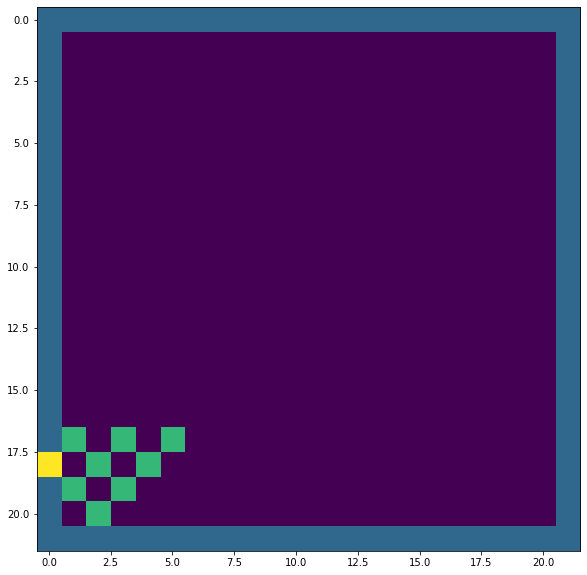

t = 40


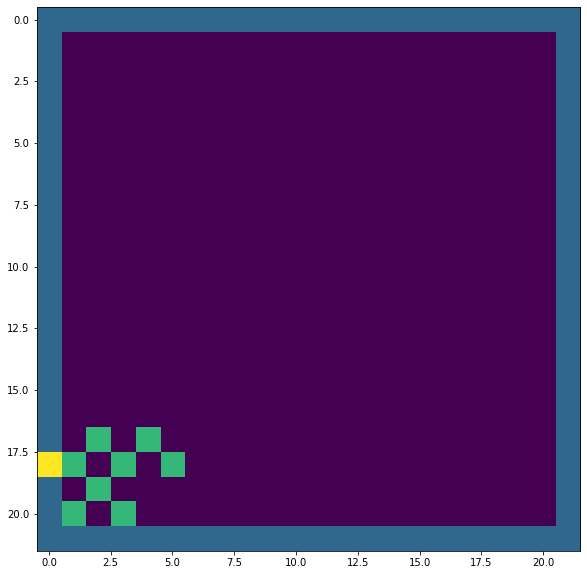

t = 41


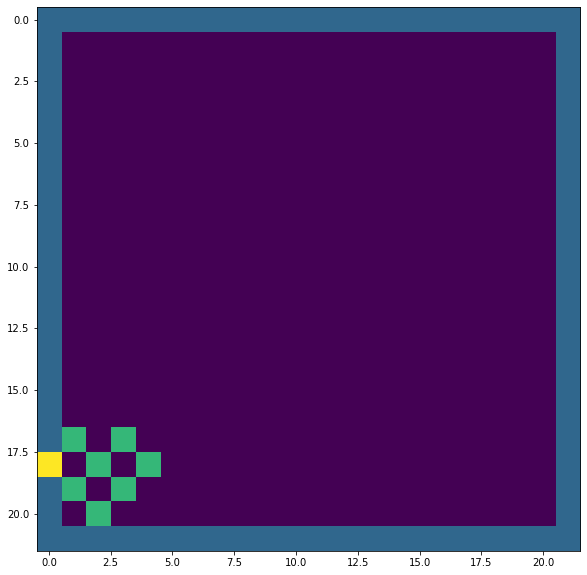

t = 42


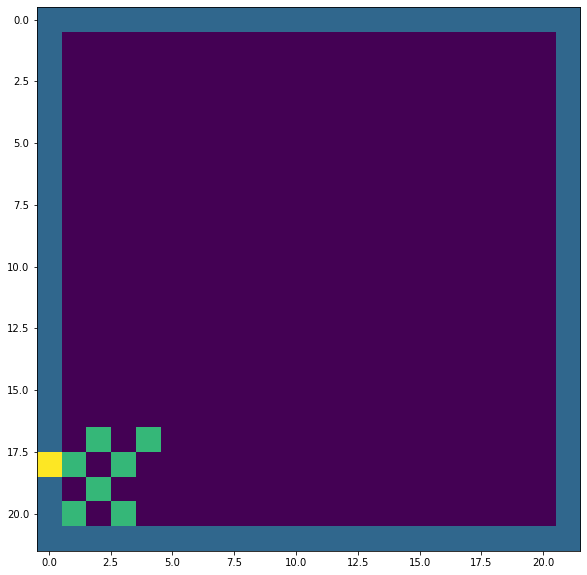

t = 43


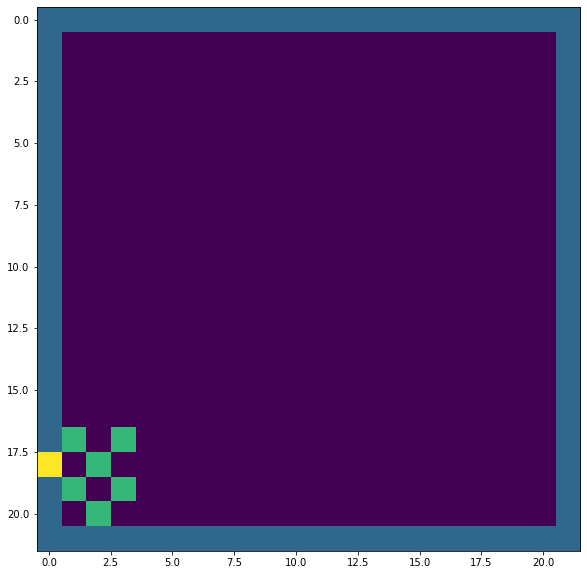

t = 44


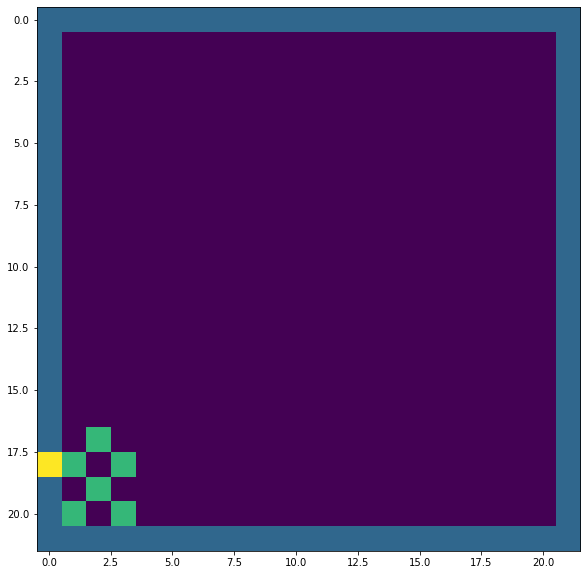

t = 45


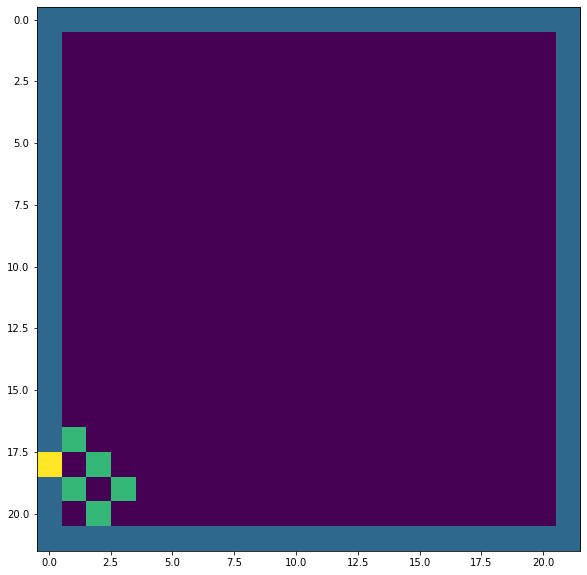

t = 46


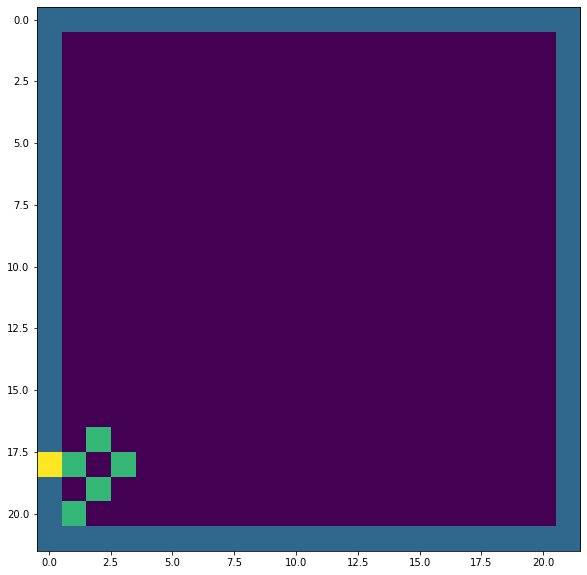

t = 47


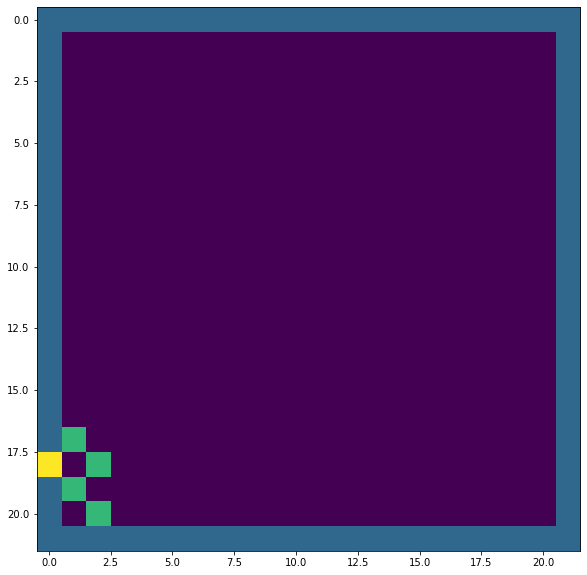

t = 48


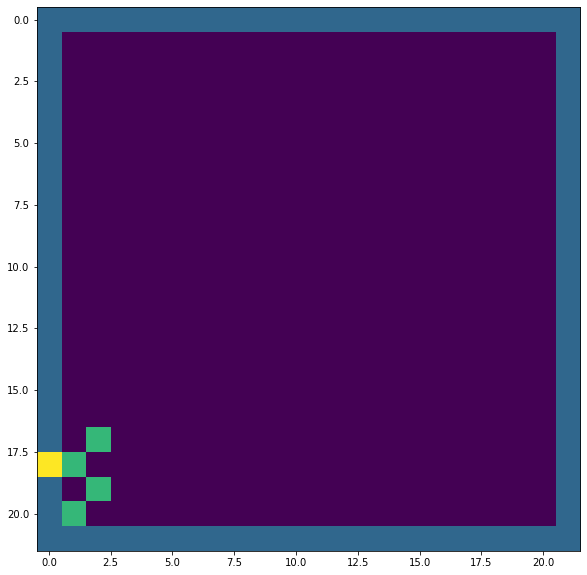

t = 49


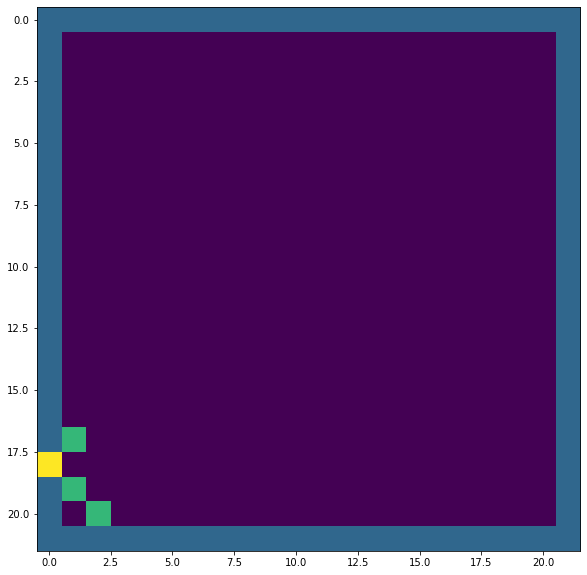

t = 50


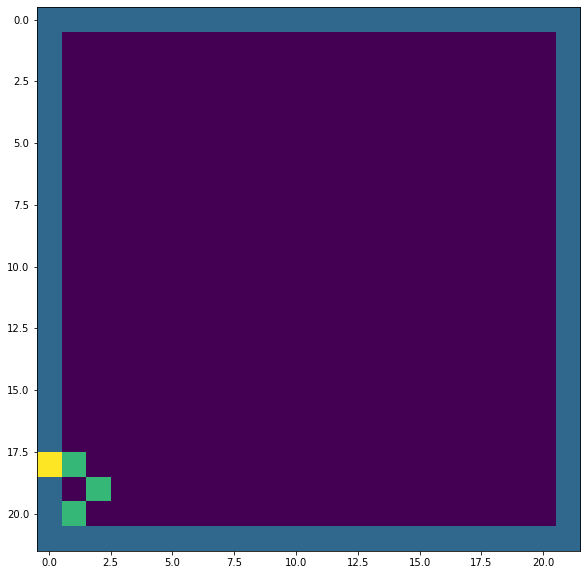

t = 51


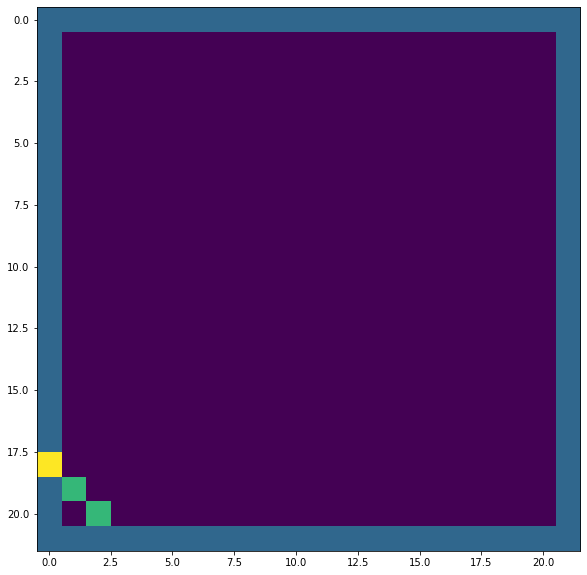

t = 52


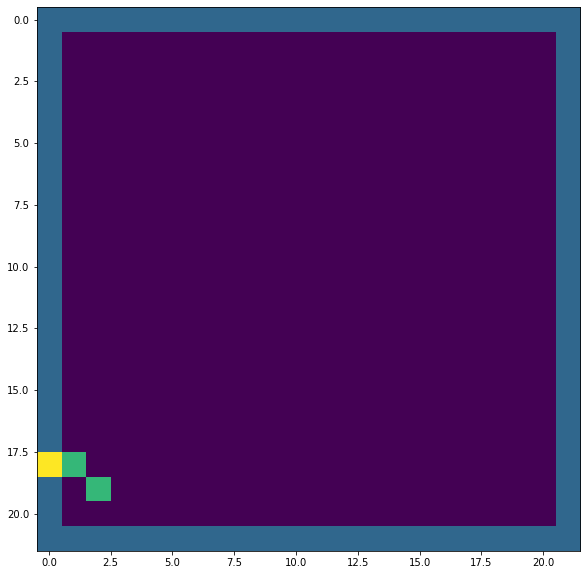

t = 53


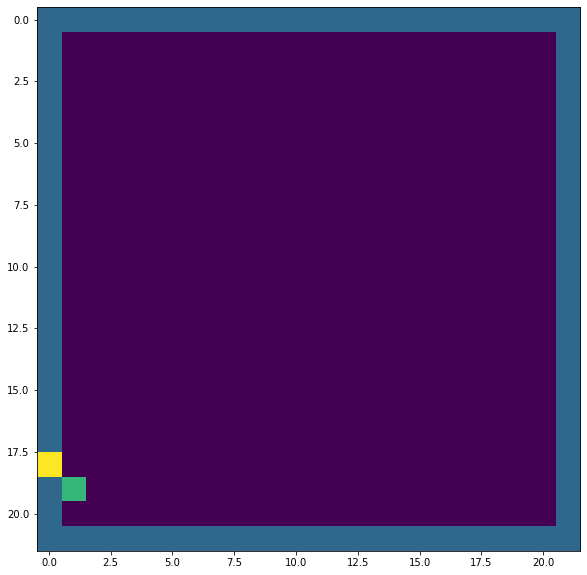

t = 54


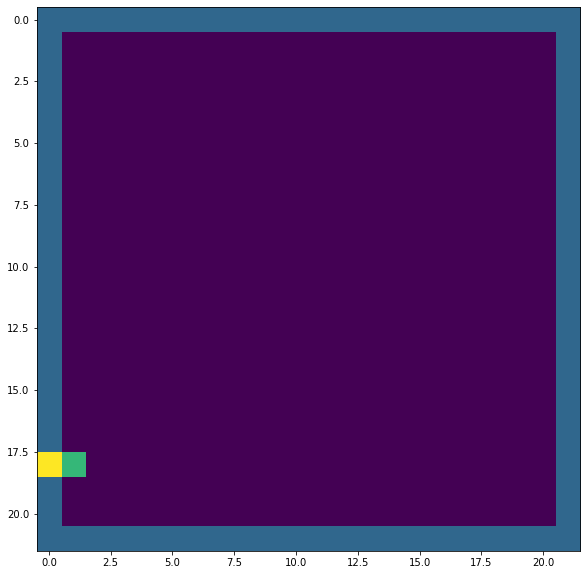

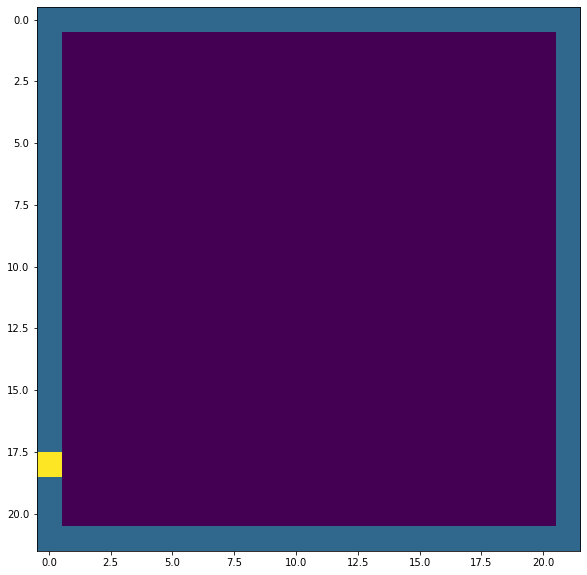

In [38]:
sim_return = simulate_evacuation(20, 350)
num_agents.append(sim_return[0])
ts.append(sim_return[1])

In [39]:
print(num_agents)
print(ts)

[10, 50, 100, 150, 200, 250, 300, 350]
[21, 39, 42, 38, 39, 37, 35, 55]


In [40]:
t = ts[-1]

# Create the frames
frames = []
imgs = []

for j in range(1,t+1):
    imgs.append("images/agents350pic"+str(j)+".png")

with imageio.get_writer('gifs/evac_simulation_agents350.gif', mode='I') as writer:
    for filename in imgs:
        image = imageio.imread(filename)
        writer.append_data(image)

<img src='gifs/evac_simulation_agents350.gif' width=400>

## Plotting the trend

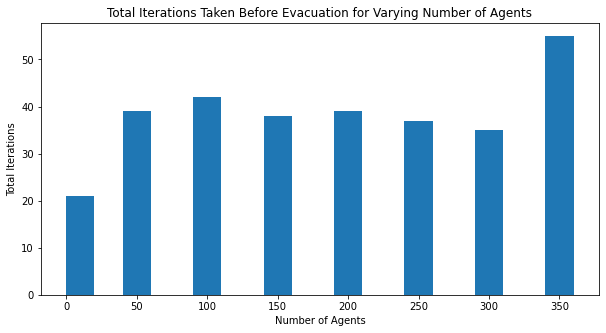

In [43]:
plt.figure(figsize=(10,5))
plt.bar(num_agents, ts, width=20)
plt.title('Total Iterations Taken Before Evacuation for Varying Number of Agents')
plt.xlabel('Number of Agents')
plt.ylabel('Total Iterations');

- The trend seems to be that as the number of agents increase with a fixed size room, the time or number of iterations it takes for all the agents to leave increases.

# Varying number of exits

## 1 exit

(0, 14)
t = 0


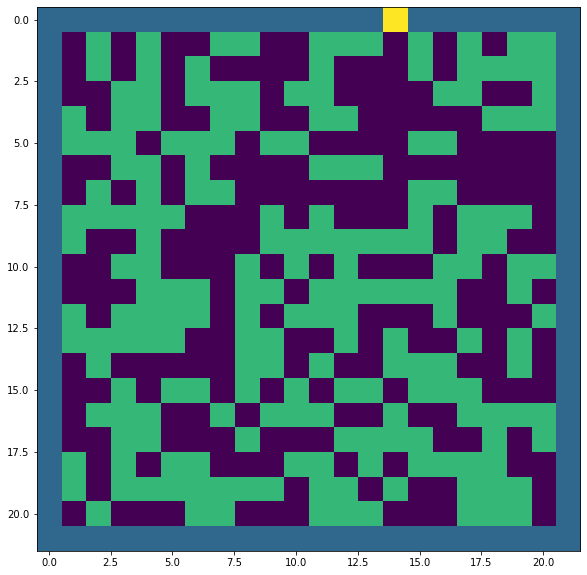

t = 1


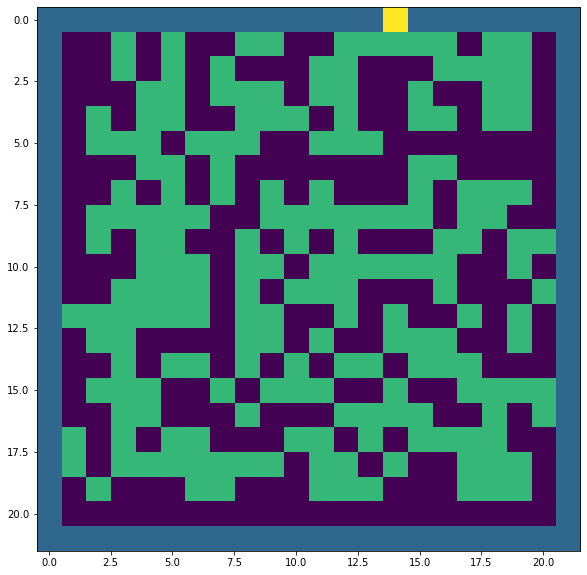

t = 2


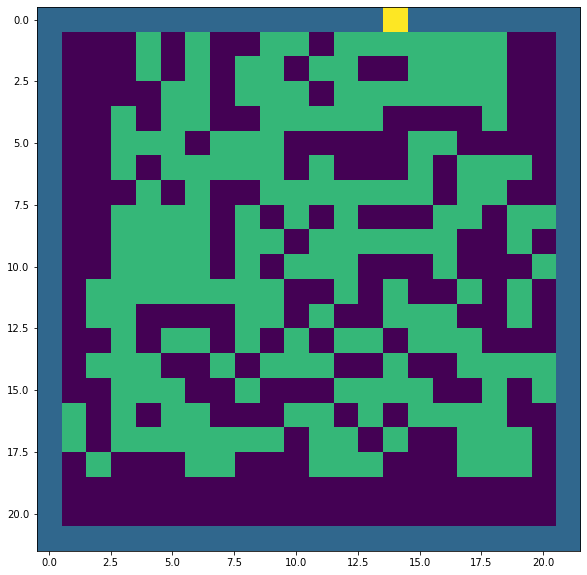

t = 3


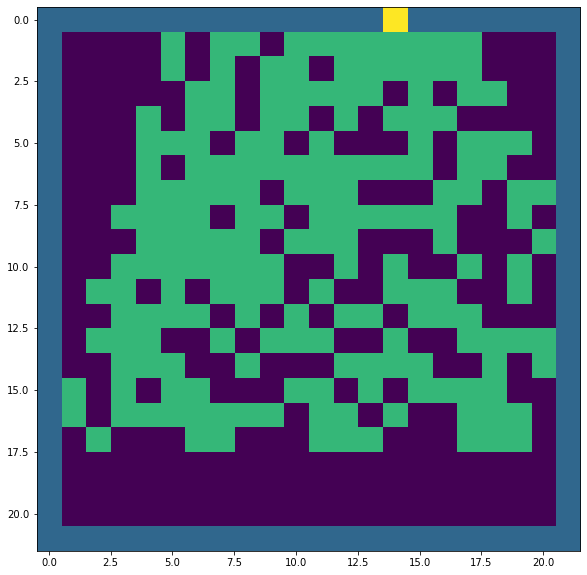

t = 4


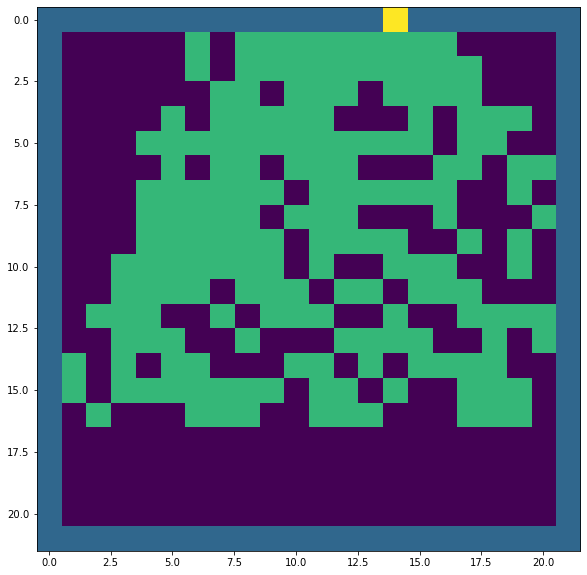

t = 5


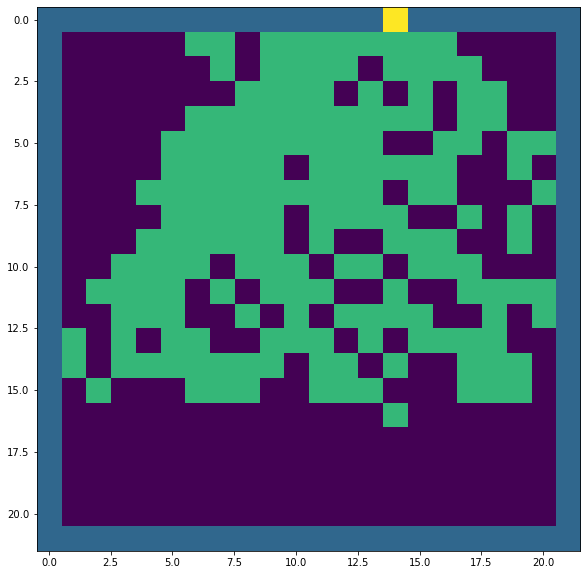

t = 6


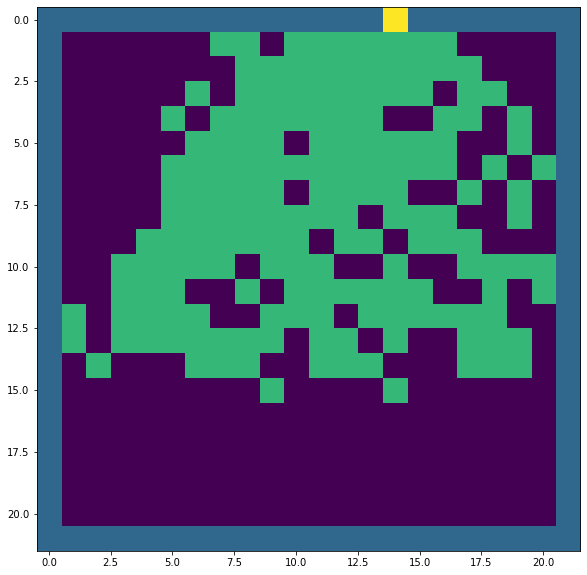

t = 7


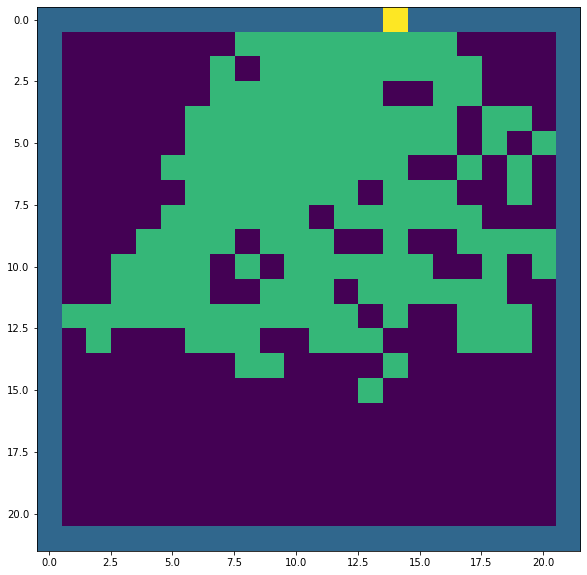

t = 8


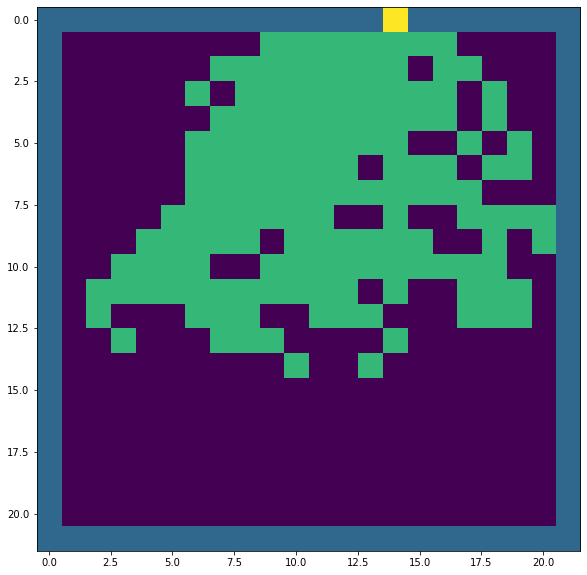

t = 9


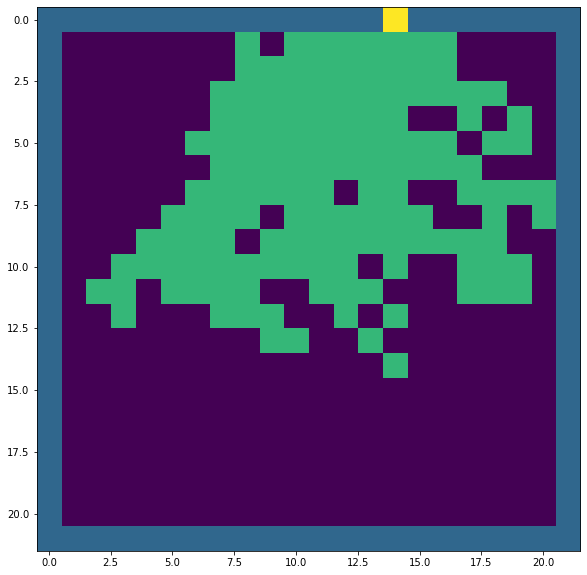

t = 10


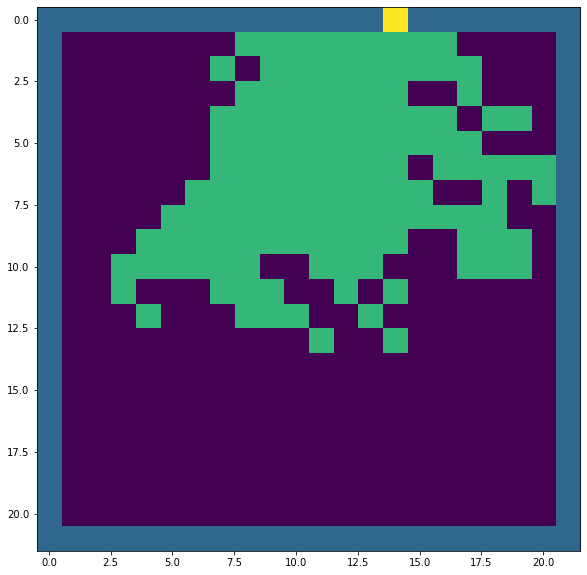

t = 11


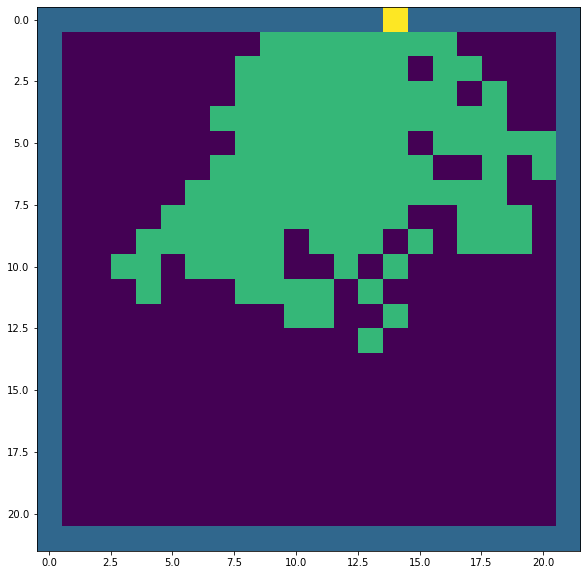

t = 12


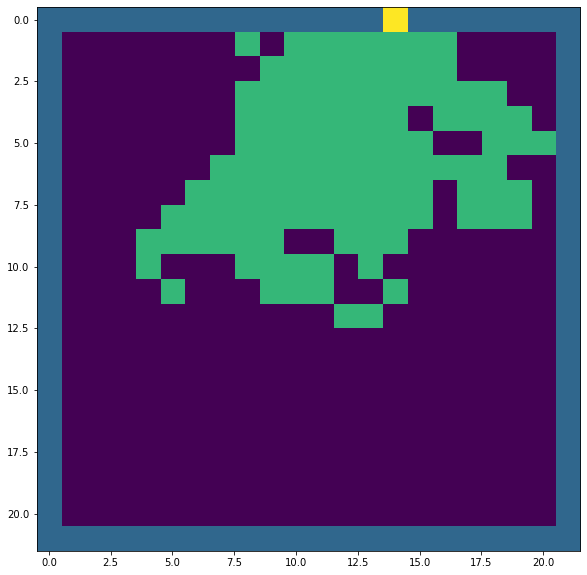

t = 13


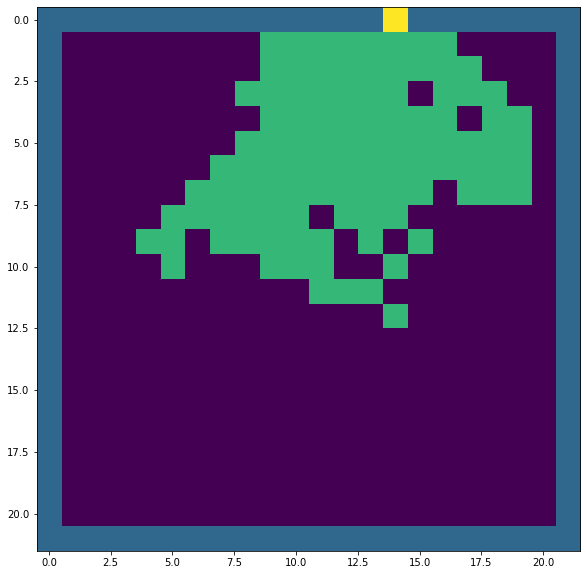

t = 14


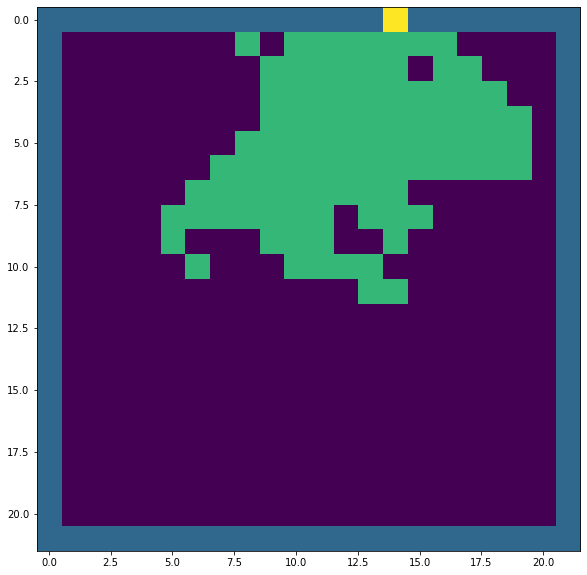

t = 15


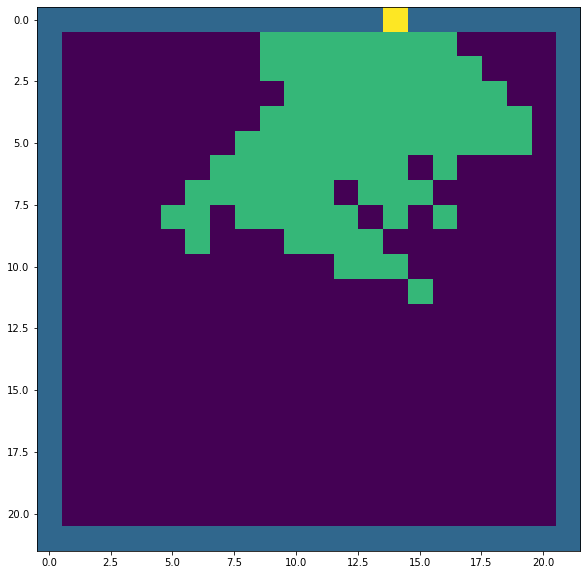

t = 16


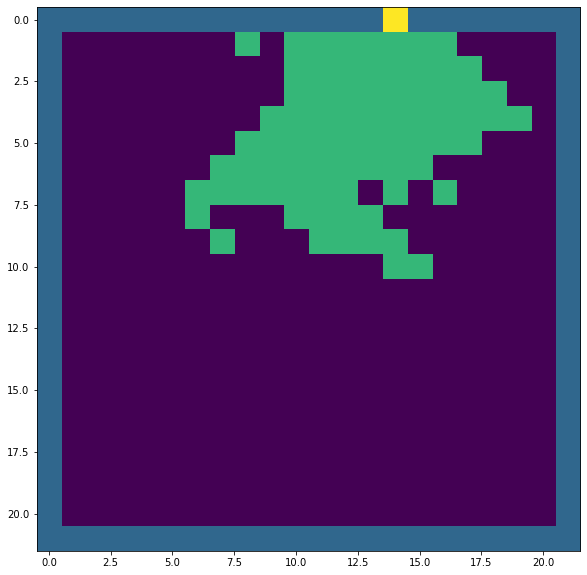

t = 17


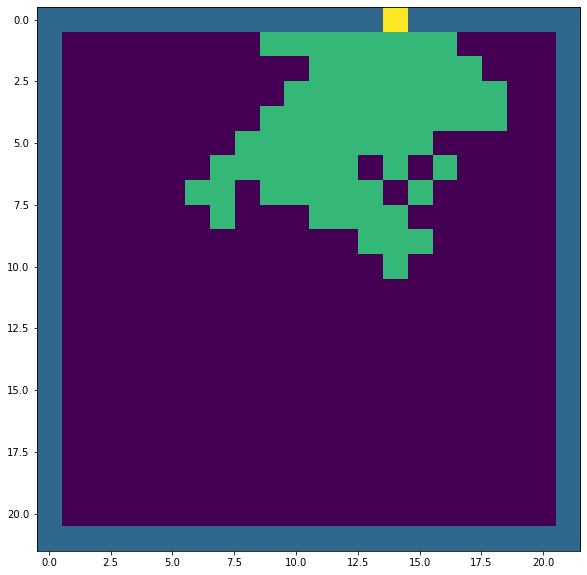

t = 18


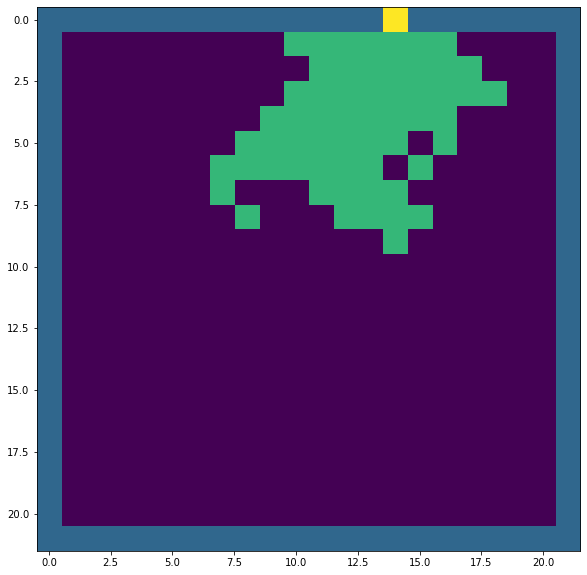

t = 19


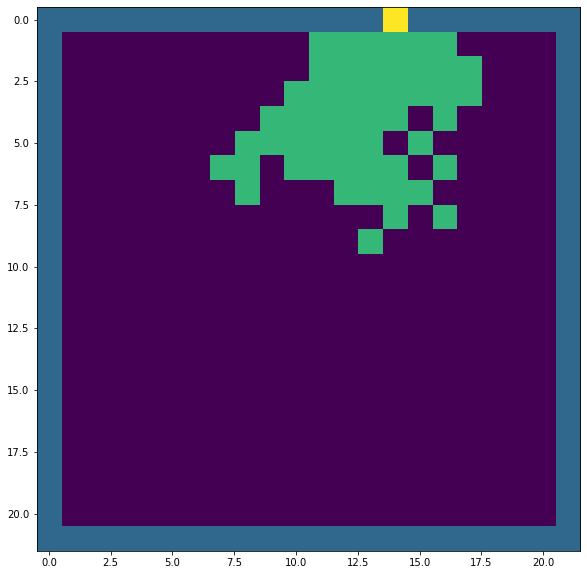

t = 20


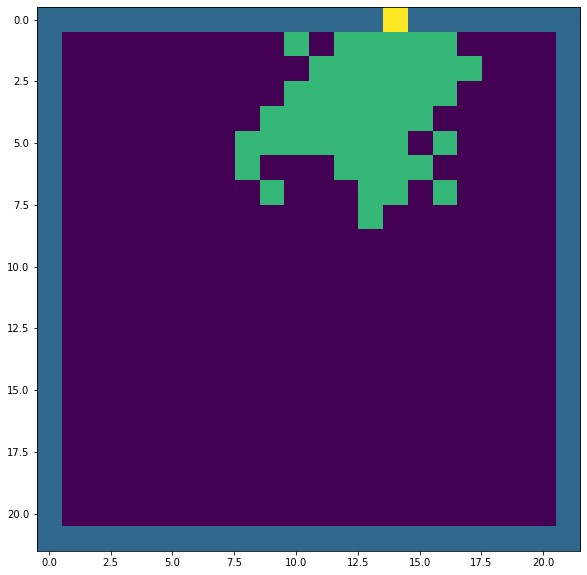

t = 21


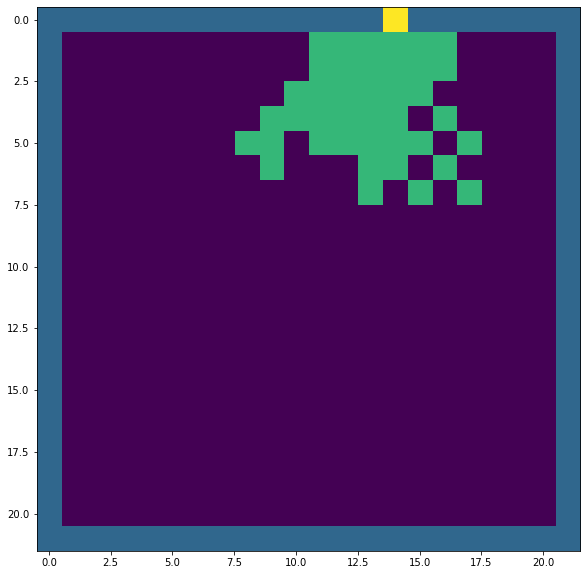

t = 22


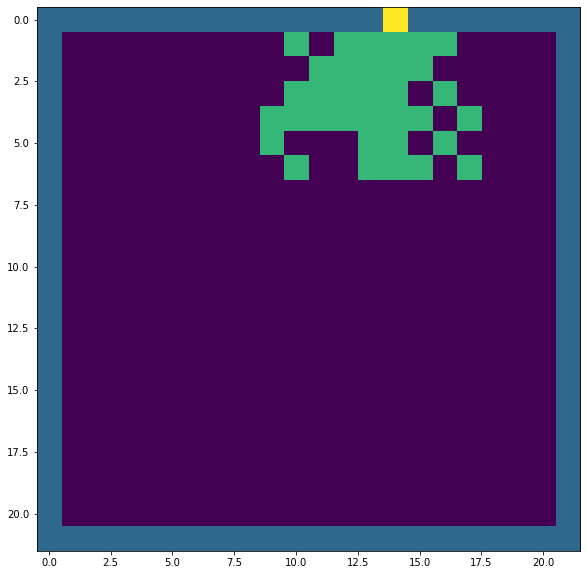

t = 23


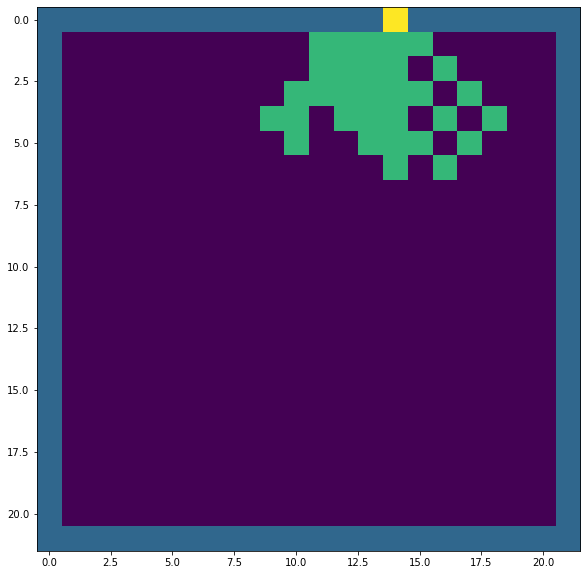

t = 24


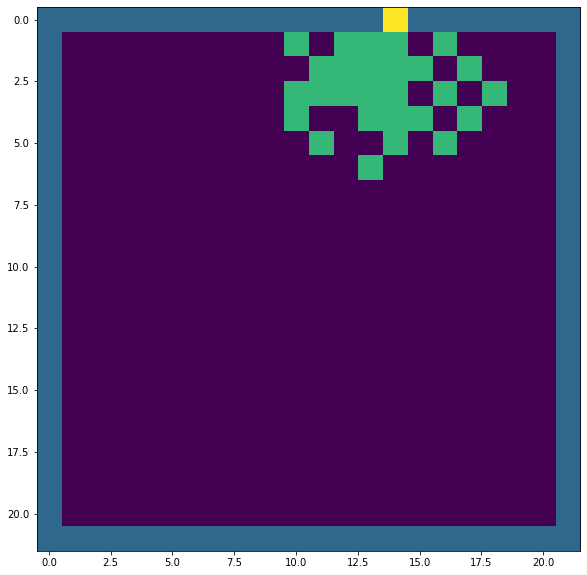

t = 25


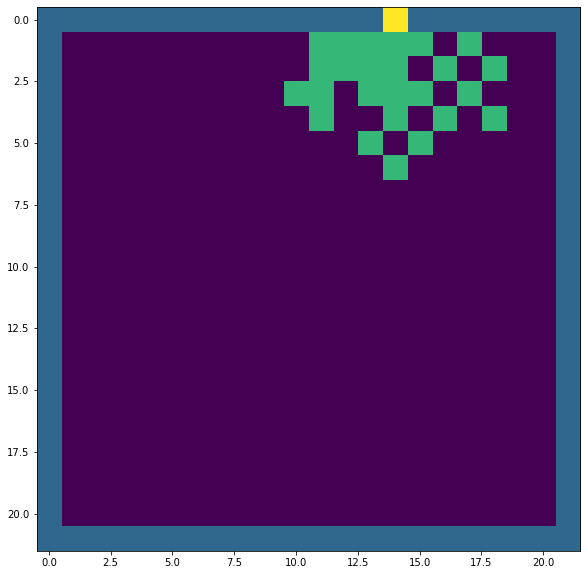

t = 26


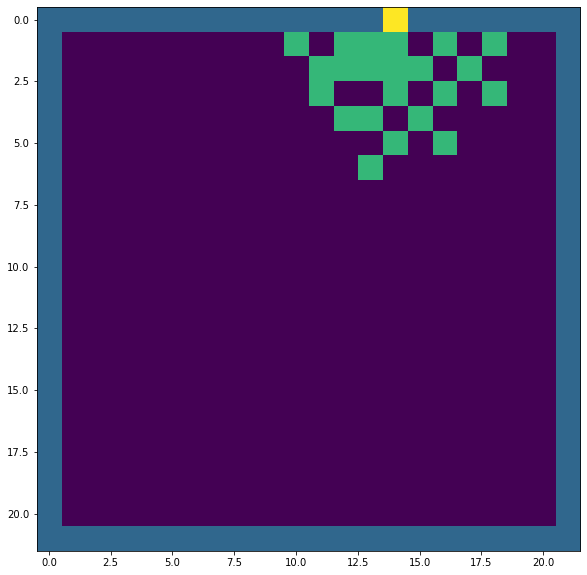

t = 27


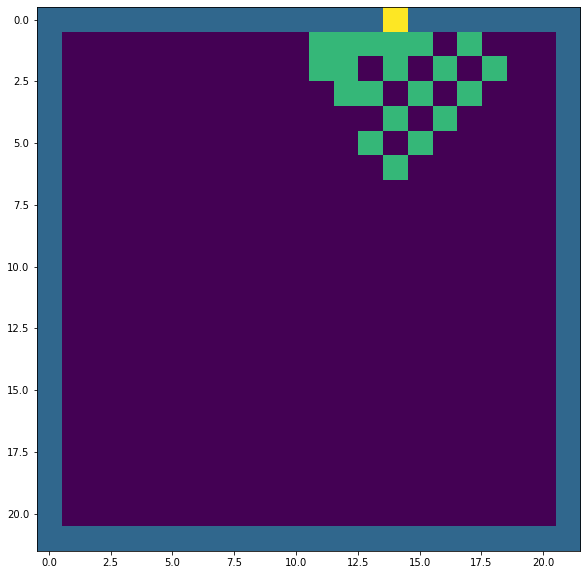

t = 28


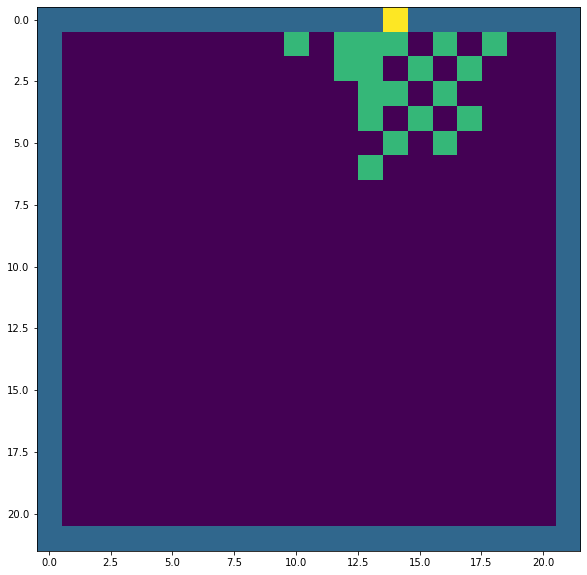

t = 29


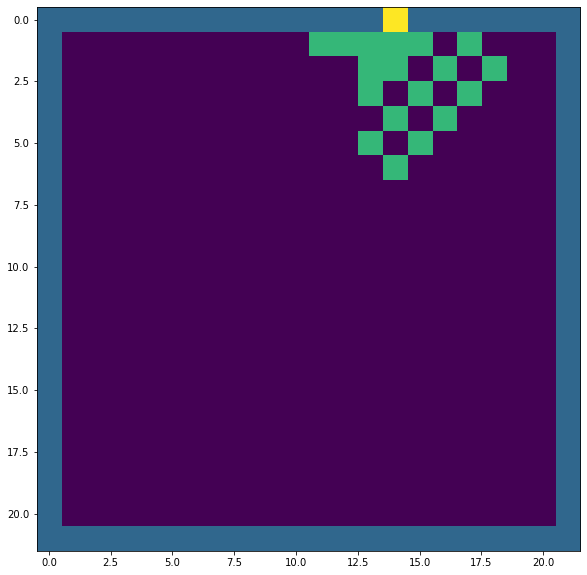

t = 30


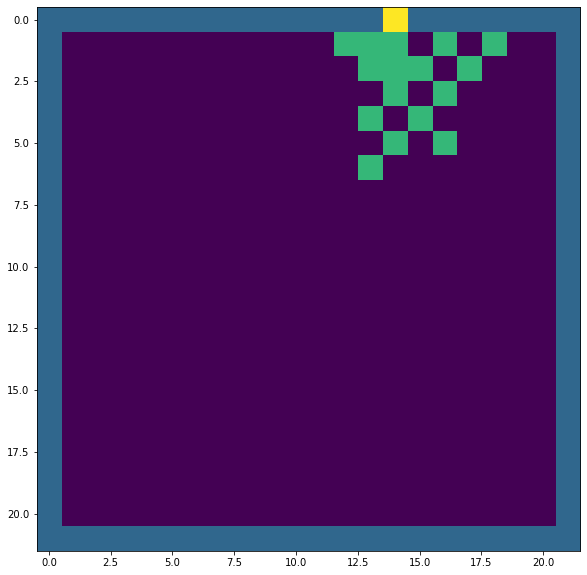

t = 31


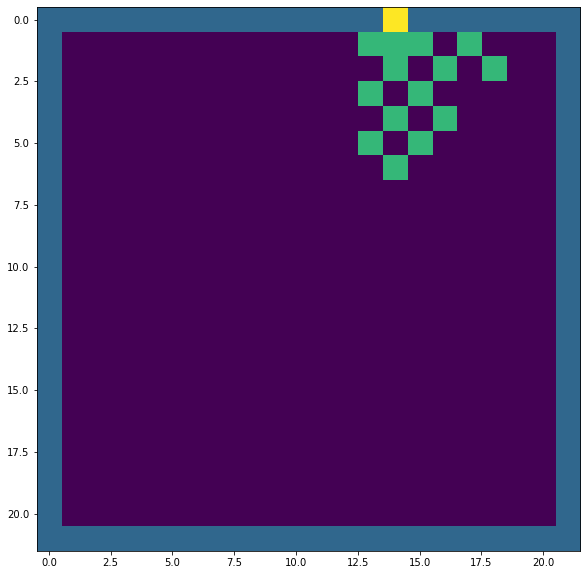

t = 32


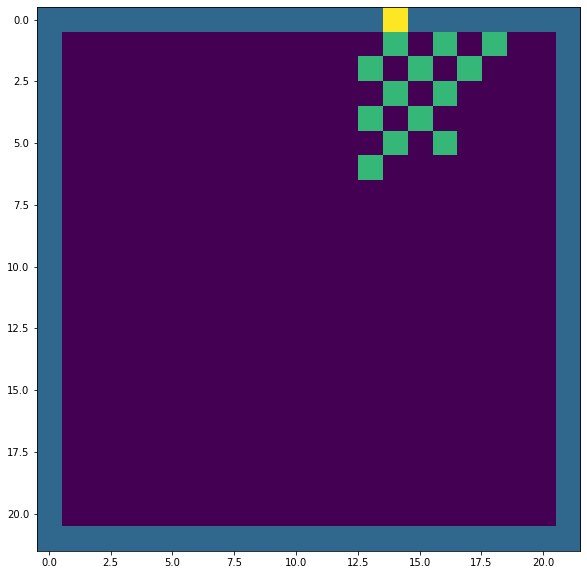

t = 33


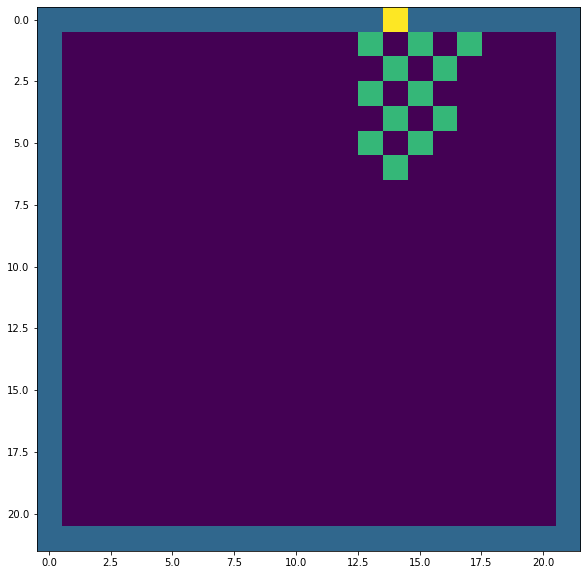

t = 34


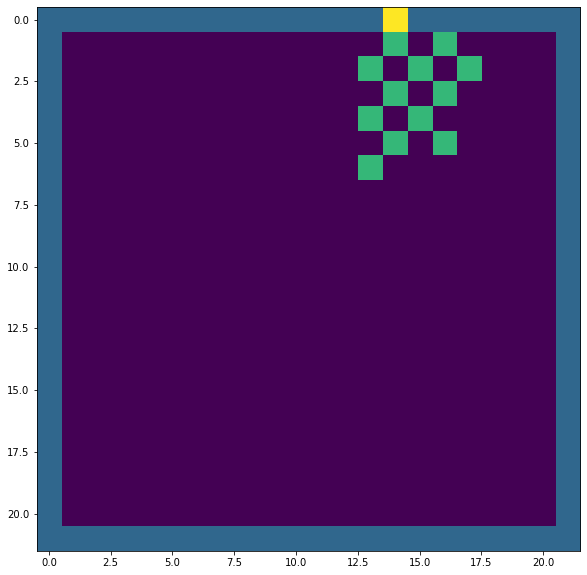

t = 35


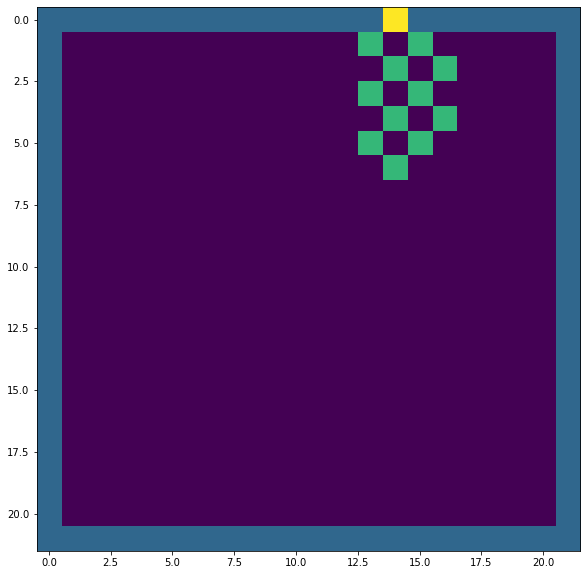

t = 36


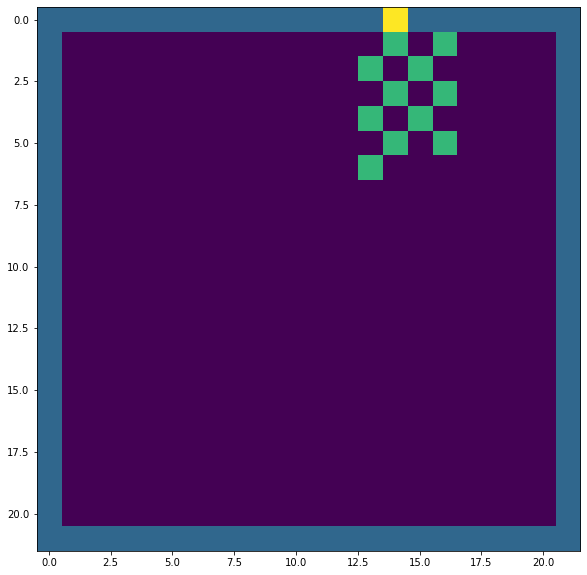

t = 37


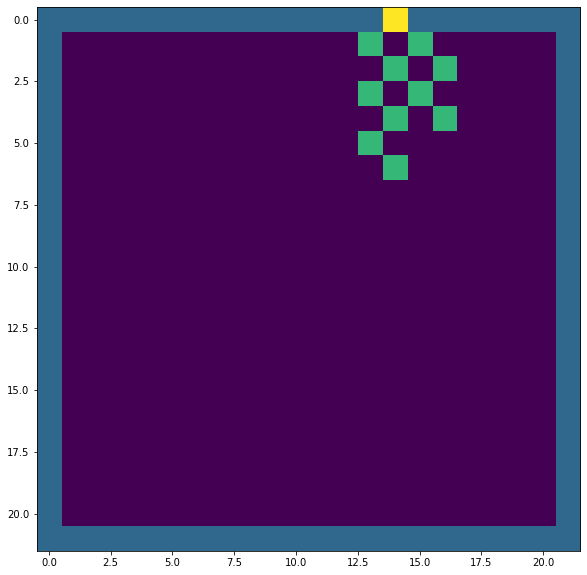

t = 38


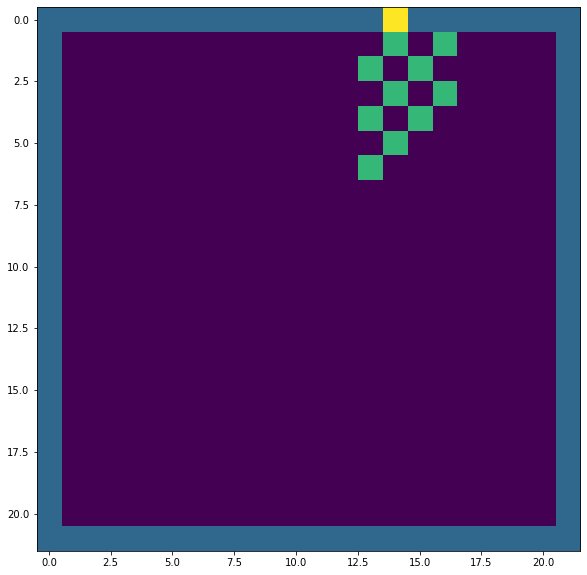

t = 39


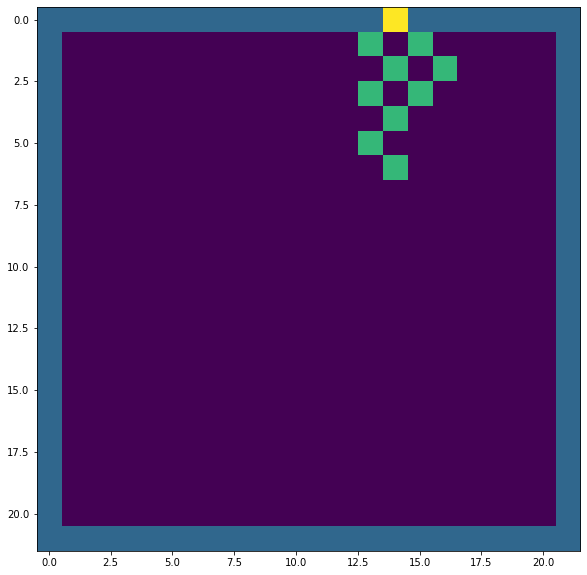

t = 40


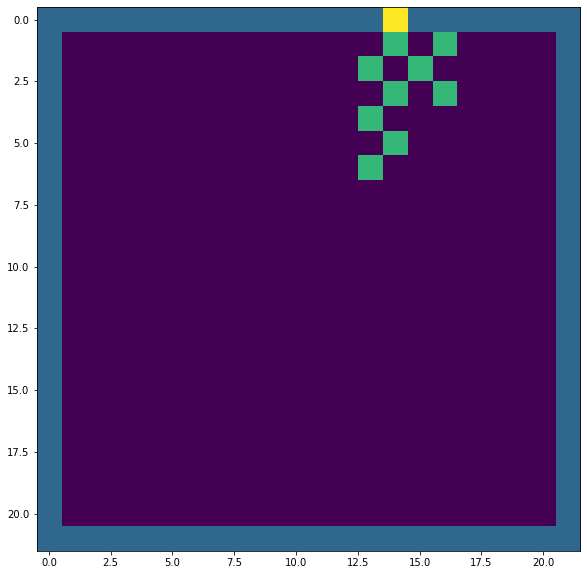

t = 41


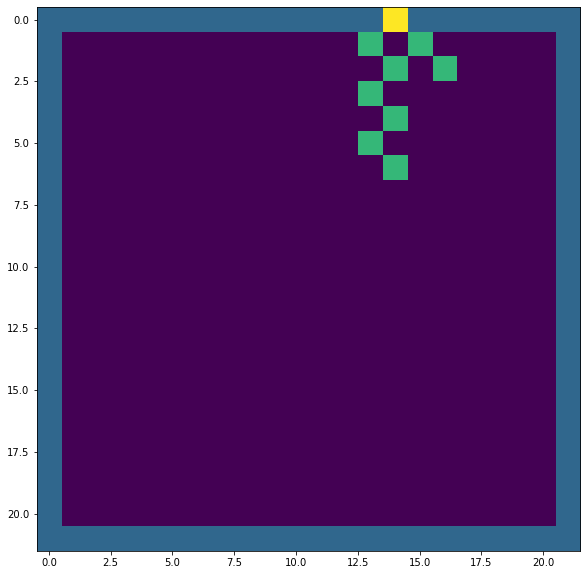

t = 42


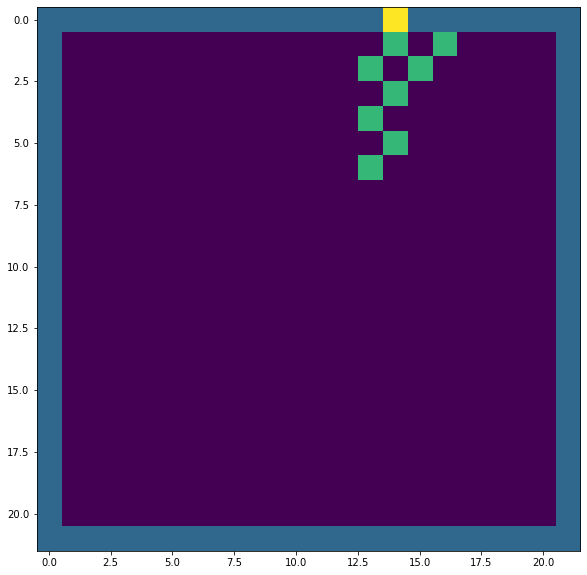

t = 43


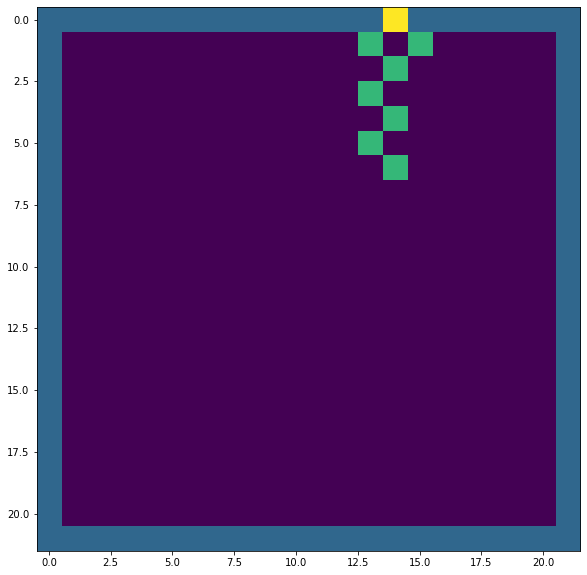

t = 44


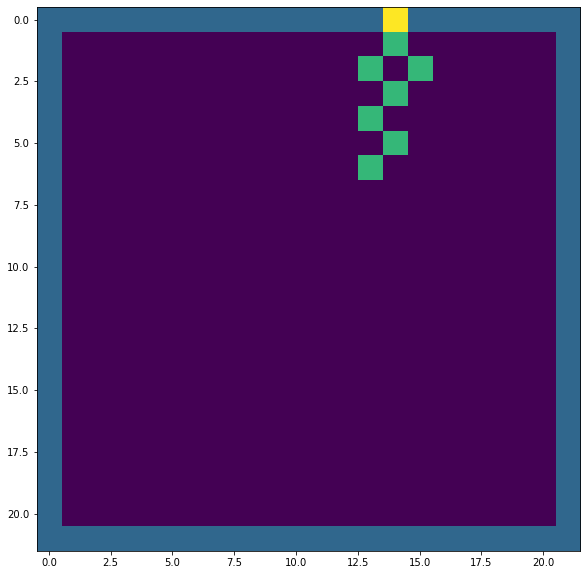

t = 45


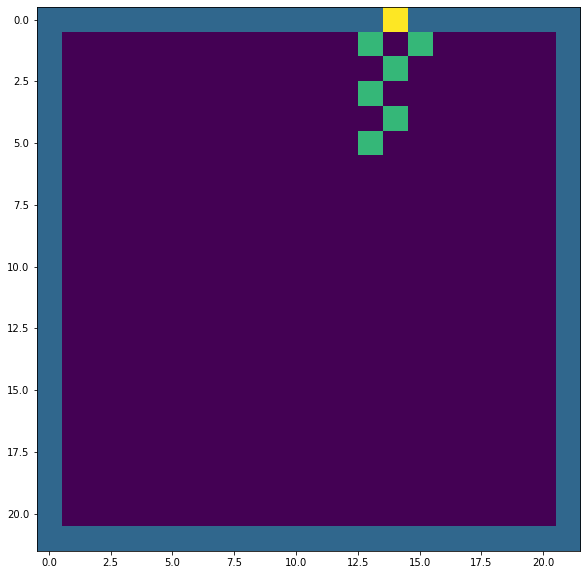

t = 46


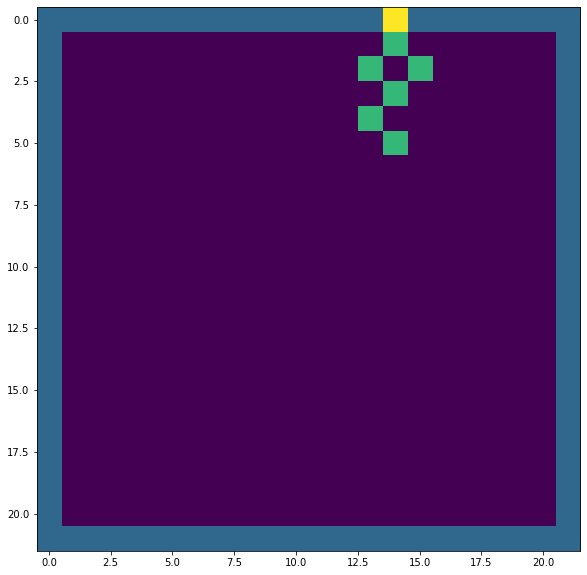

t = 47


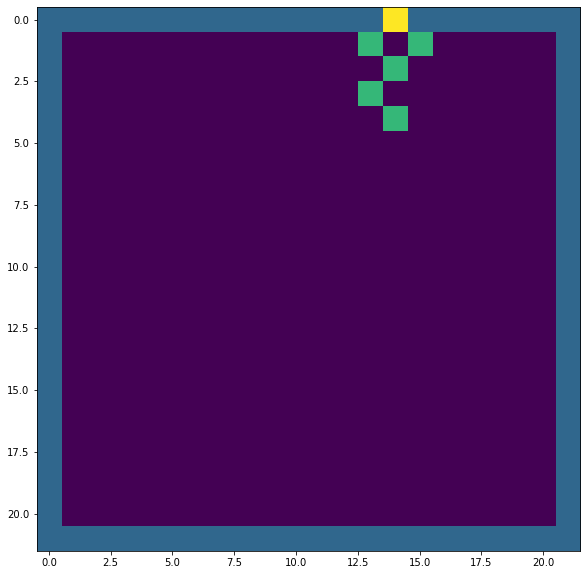

t = 48


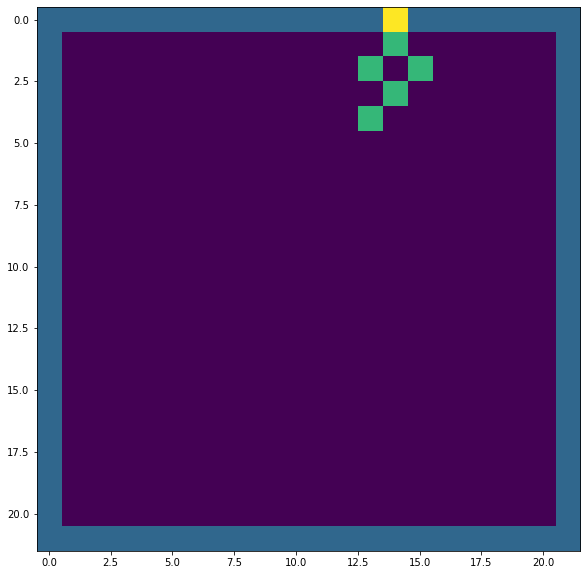

t = 49


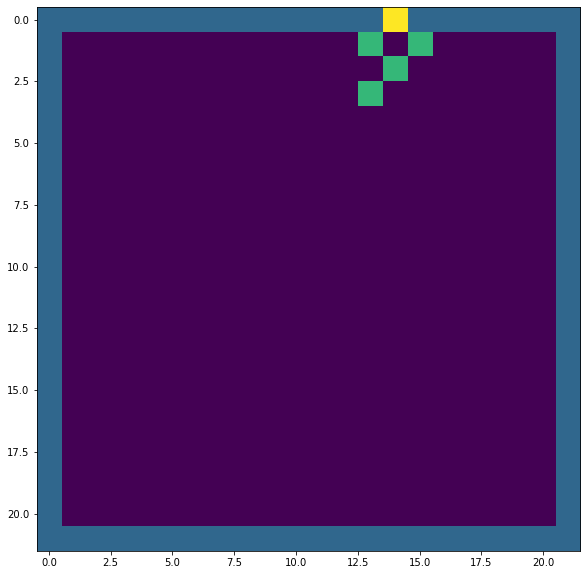

t = 50


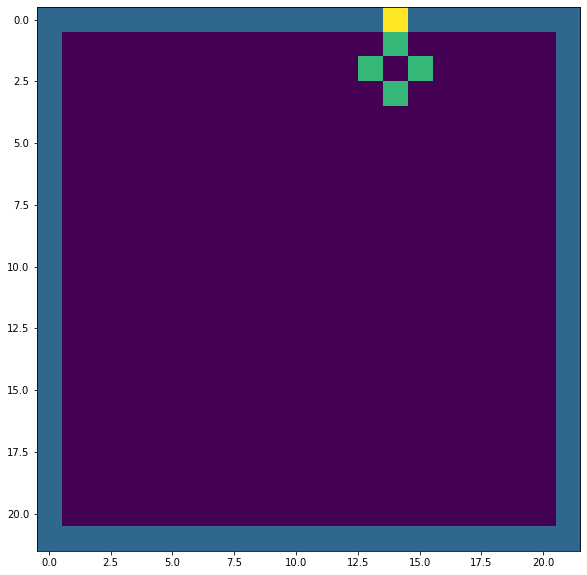

t = 51


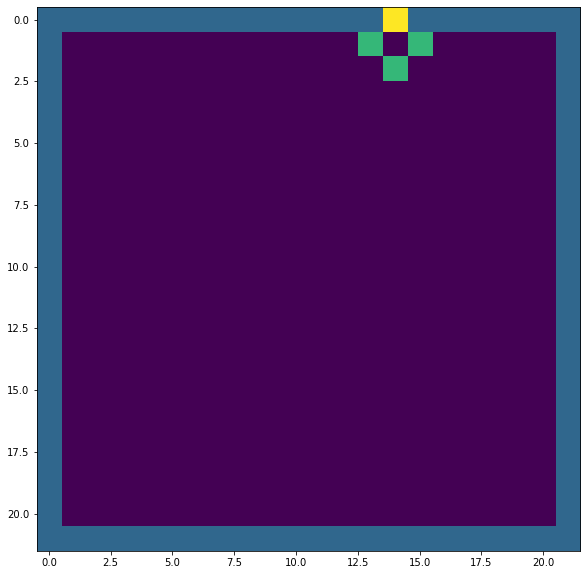

t = 52


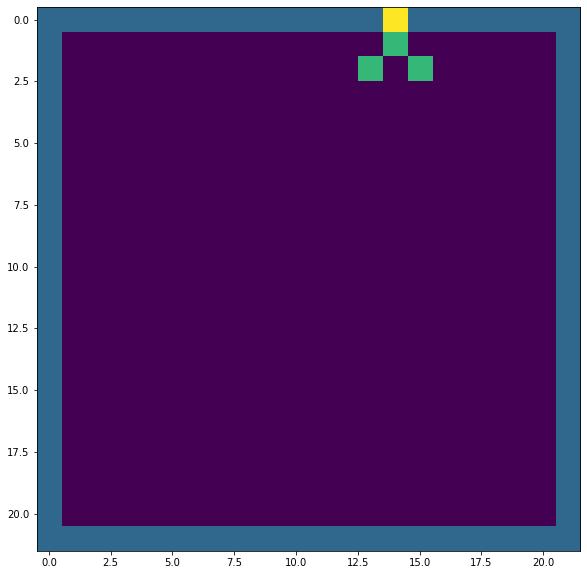

t = 53


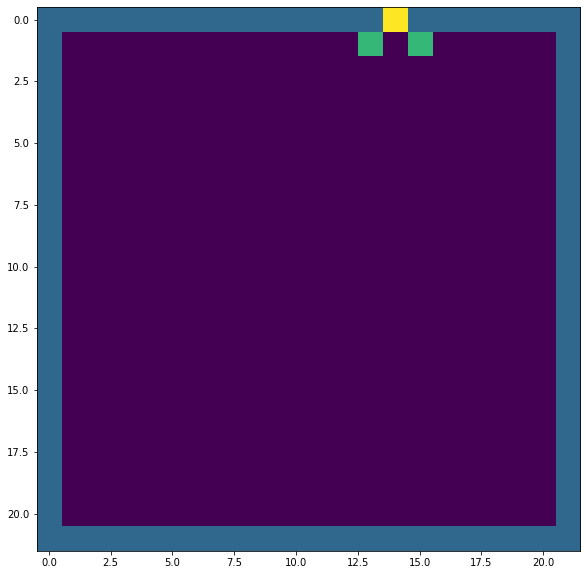

t = 54


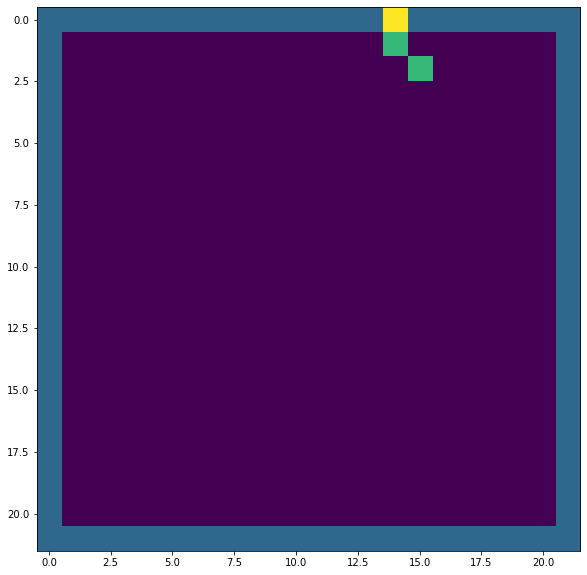

t = 55


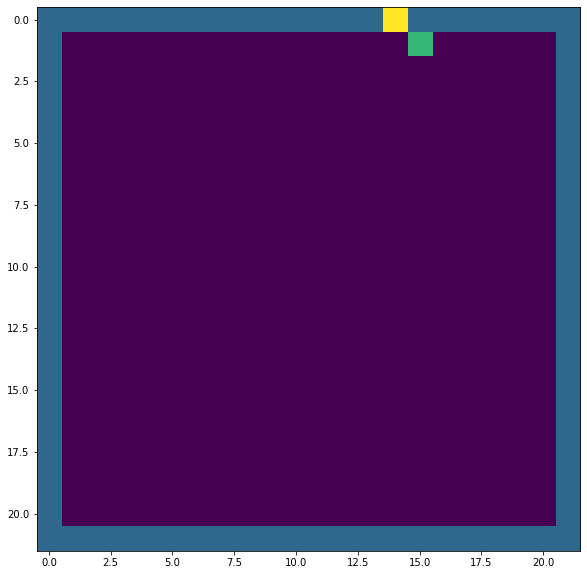

t = 56


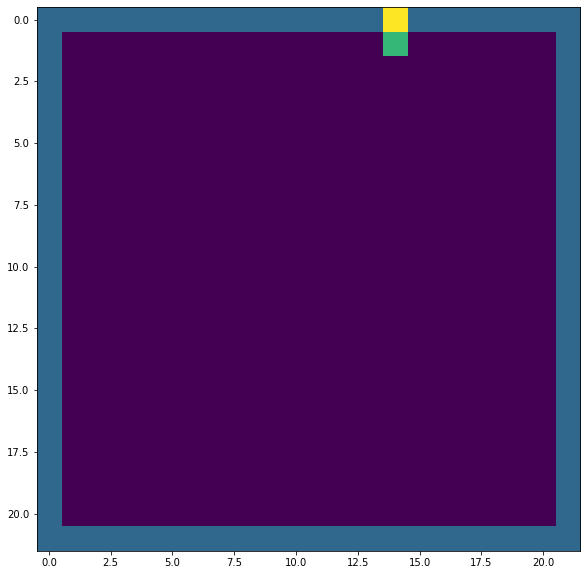

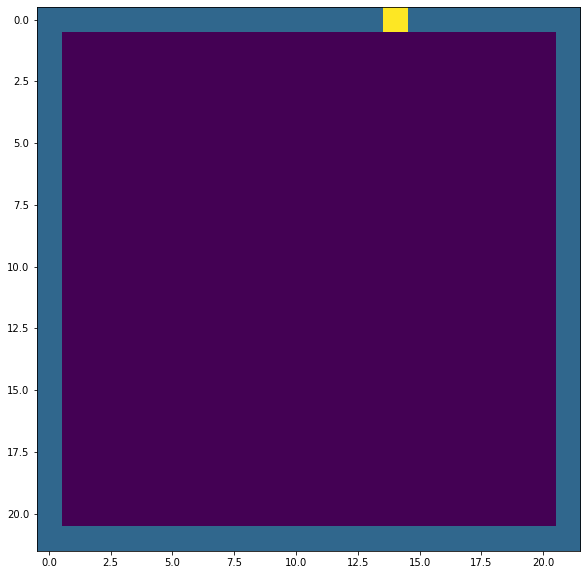

Total required iterations: 57


In [296]:
sim_return = simulate_evacuation(20, 200)
print('Total required iterations:', sim_return[1])

## 2 exits

(4, 0)
(5, 11)


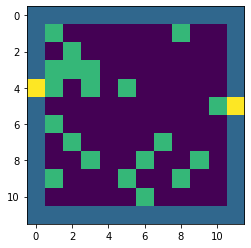

In [184]:
size = 20
n_agents = 200
n_exits = 2
room = room_grid(size,n_agents)
room = place_exit(room, size, n_exits)
plt.imshow(room);

t = 0


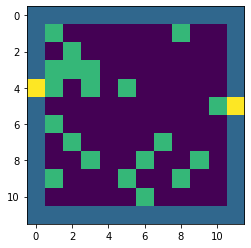

18
t = 1


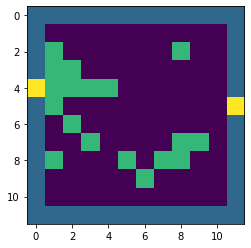

17
t = 2


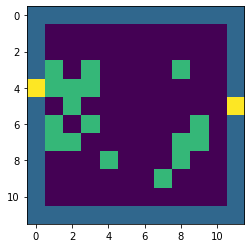

15
t = 3


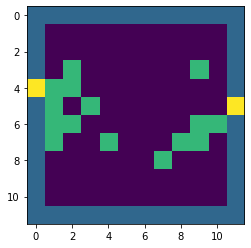

14
t = 4


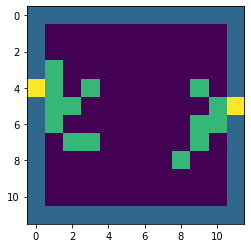

11
t = 5


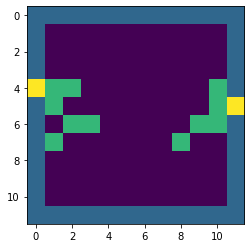

9
t = 6


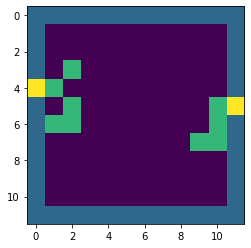

7
t = 7


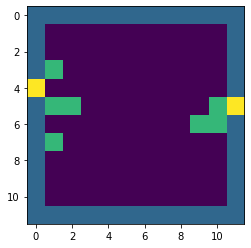

6
t = 8


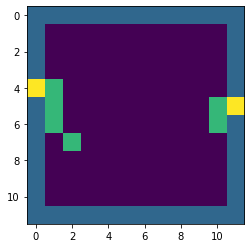

4
t = 9


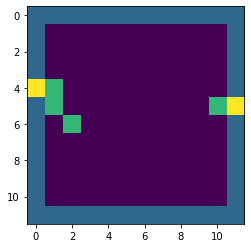

2
t = 10


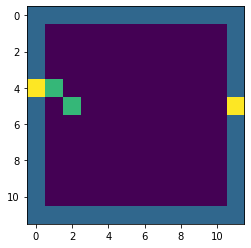

1
t = 11


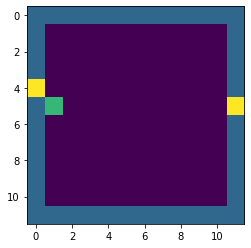

1
t = 12


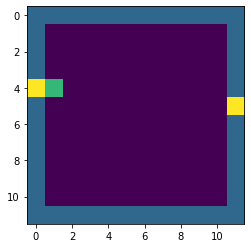

0


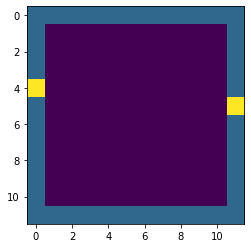

Total required iterations: 13


In [185]:
# get coordinates of exits
all_exit_coords = list(zip(np.where(room==2)[0], np.where(room==2)[1]))

# count agents left
agents_left = len(np.where(room==1)[0])

t=0
while agents_left > 0:
    print('t =', t)
    plt.imshow(room)
    plt.show()
    
    # get all agents coordinates
    all_agent_coords = list(zip(np.where(room==1)[0], np.where(room==1)[1]))
    
    # create dictionary of agents and their respective closest exit 
    # each agent targets the closest exit to it
    agent_exit_dict = {}
    for a in all_agent_coords:
        exit_dists = []
        for e in all_exit_coords:
            exit_dist = np.linalg.norm(np.asarray(a) - np.asarray(e))
            exit_dists.append(exit_dist)
        closest_exit = all_exit_coords[exit_dists.index(min(exit_dists))]
        agent_exit_dict[a] = closest_exit
    
    # get agents that will target respective exit
    exit1_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[0]]
    exit2_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[1]]  
    
    # get distances of all agents to exits, to determine order of movement
    exit1_agent_dists = []
    for a in exit1_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[0]))
        exit1_agent_dists.append(agent_dist)

    exit2_agent_dists = []
    for a in exit2_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[1]))
        exit2_agent_dists.append(agent_dist)

    # # combine lists
    exit1_agent_dist_lst = [(exit1_agents[i], exit1_agent_dists[i]) for i in range(len(exit1_agents))]
    exit1_agent_dist_lst
    exit2_agent_dist_lst = [(exit2_agents[i], exit2_agent_dists[i]) for i in range(len(exit2_agents))]
    exit_agent_dist_lst = exit1_agent_dist_lst + exit2_agent_dist_lst

    # determine order of movement for agents
    exit_agent_dist_lst = sorted(exit_agent_dist_lst, key = lambda x: x[1])
    agent_order = [i[0] for i in exit_agent_dist_lst]
    
    for agent_coords in agent_order:
        agent_r = agent_coords[0]
        agent_c = agent_coords[1]
        # if agent is beside an exit
        if is_beside_exit(agent_coords, room):
            # place becomes empty (exits room)
            room[agent_r][agent_c] = -1
            continue
        # if not, it decides where to move
        else:
            move_r, move_c = decide_move(agent_coords, size, room, agent_exit_dict[agent_coords])
            room[agent_r][agent_c] = -1
            room[move_r][move_c] = 1
    agents_left = len(np.where(room==1)[0])
    print(agents_left)
    t = int(t)
    t = t + 1
plt.imshow(room)
plt.show()
print('Total required iterations:', t)

## 3 exits

(0, 2)
(0, 8)
(5, 11)


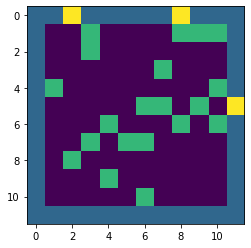

In [189]:
size = 10
n_agents = 20
n_exits = 3
room = room_grid(size,n_agents)
room = place_exit(room, size, n_exits)
plt.imshow(room);

t = 0


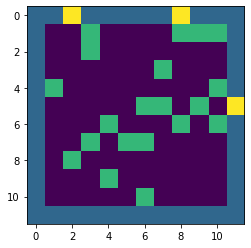

19
t = 1


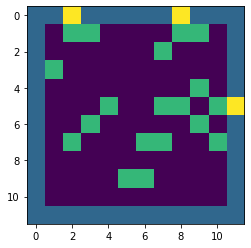

16
t = 2


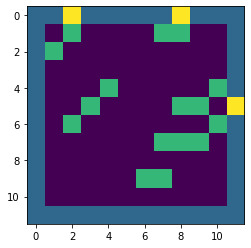

13
t = 3


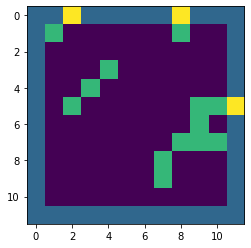

11
t = 4


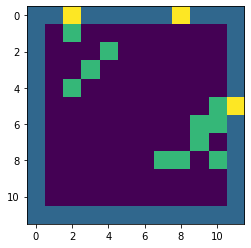

9
t = 5


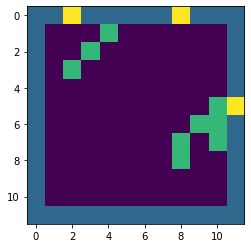

8
t = 6


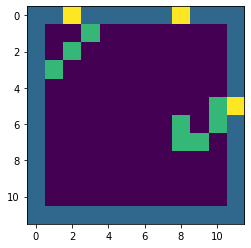

7
t = 7


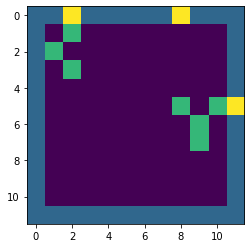

5
t = 8


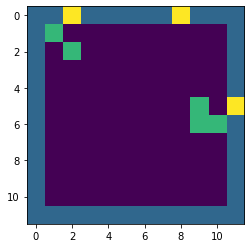

5
t = 9


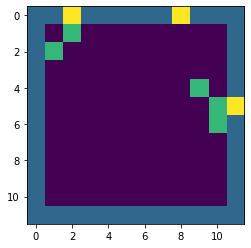

3
t = 10


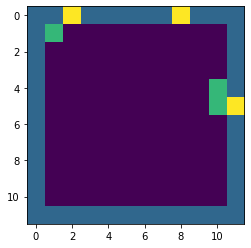

2
t = 11


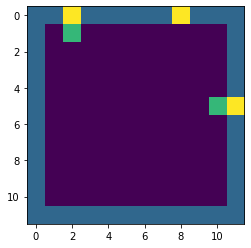

0


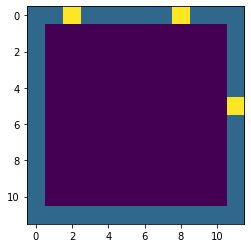

Total required iterations: 12


In [190]:
# get coordinates of exits
all_exit_coords = list(zip(np.where(room==2)[0], np.where(room==2)[1]))

# count agents left
agents_left = len(np.where(room==1)[0])

t=0
while agents_left > 0:
    print('t =', t)
    plt.imshow(room)
    plt.show()
    
    # get all agents coordinates
    all_agent_coords = list(zip(np.where(room==1)[0], np.where(room==1)[1]))
    
    # create dictionary of agents and their respective closest exit 
    # each agent targets the closest exit to it
    agent_exit_dict = {}
    for a in all_agent_coords:
        exit_dists = []
        for e in all_exit_coords:
            exit_dist = np.linalg.norm(np.asarray(a) - np.asarray(e))
            exit_dists.append(exit_dist)
        closest_exit = all_exit_coords[exit_dists.index(min(exit_dists))]
        agent_exit_dict[a] = closest_exit
    
    # get agents that will target respective exit
    exit1_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[0]]
    exit2_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[1]] 
    exit3_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[2]]  
    
    # get distances of all agents to exits, to determine order of movement
    exit1_agent_dists = []
    for a in exit1_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[0]))
        exit1_agent_dists.append(agent_dist)

    exit2_agent_dists = []
    for a in exit2_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[1]))
        exit2_agent_dists.append(agent_dist)
        
    exit3_agent_dists = []
    for a in exit3_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[2]))
        exit3_agent_dists.append(agent_dist)

    # # combine lists
    exit1_agent_dist_lst = [(exit1_agents[i], exit1_agent_dists[i]) for i in range(len(exit1_agents))]
    exit2_agent_dist_lst = [(exit2_agents[i], exit2_agent_dists[i]) for i in range(len(exit2_agents))]
    exit3_agent_dist_lst = [(exit3_agents[i], exit3_agent_dists[i]) for i in range(len(exit3_agents))]
    exit_agent_dist_lst = exit1_agent_dist_lst + exit2_agent_dist_lst + exit3_agent_dist_lst

    # determine order of movement for agents
    exit_agent_dist_lst = sorted(exit_agent_dist_lst, key = lambda x: x[1])
    agent_order = [i[0] for i in exit_agent_dist_lst]
    
    for agent_coords in agent_order:
        agent_r = agent_coords[0]
        agent_c = agent_coords[1]
        # if agent is beside an exit
        if is_beside_exit(agent_coords, room):
            # place becomes empty (exits room)
            room[agent_r][agent_c] = -1
            continue
        # if not, it decides where to move
        else:
            move_r, move_c = decide_move(agent_coords, size, room, agent_exit_dict[agent_coords])
            room[agent_r][agent_c] = -1
            room[move_r][move_c] = 1
    agents_left = len(np.where(room==1)[0])
    print(agents_left)
    t = int(t)
    t = t + 1
plt.imshow(room)
plt.show()
print('Total required iterations:', t)

## 4 exits

(0, 3)
(11, 4)
(8, 11)
(0, 7)


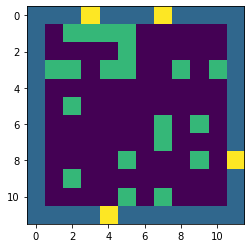

In [212]:
size = 10
n_agents = 20
n_exits = 4
room = room_grid(size,n_agents)
room = place_exit(room, size, n_exits)
plt.imshow(room);

t = 0


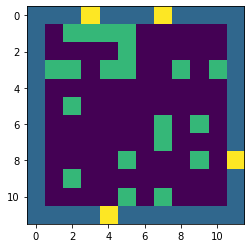

19
t = 1


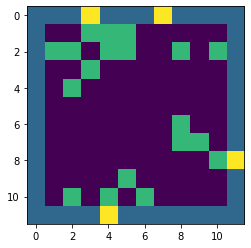

16
t = 2


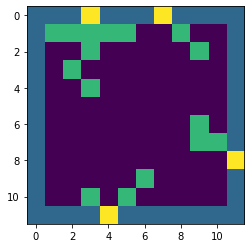

15
t = 3


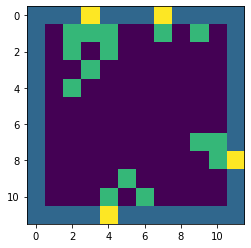

10
t = 4


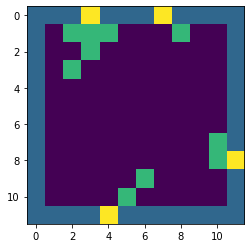

8
t = 5


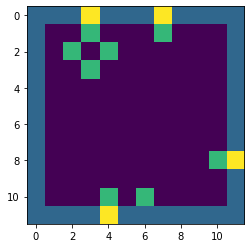

4
t = 6


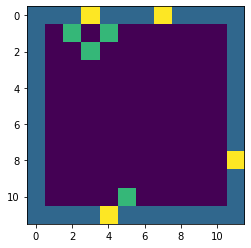

4
t = 7


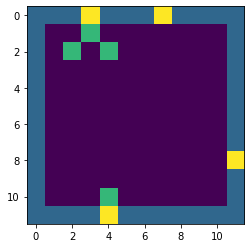

2
t = 8


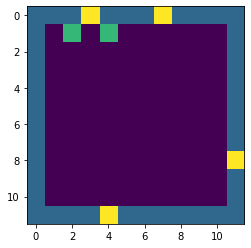

2
t = 9


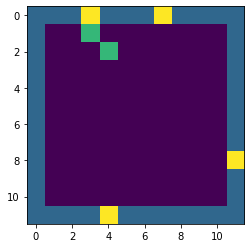

1
t = 10


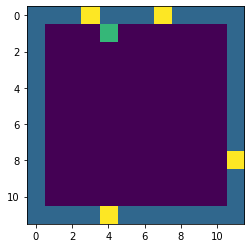

1
t = 11


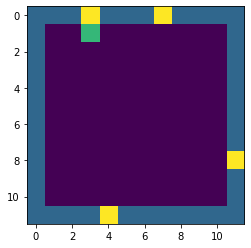

0


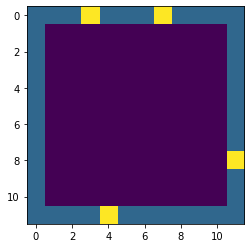

Total required iterations: 12


In [213]:
# get coordinates of exits
all_exit_coords = list(zip(np.where(room==2)[0], np.where(room==2)[1]))

# count agents left
agents_left = len(np.where(room==1)[0])

t=0
while agents_left > 0:
    print('t =', t)
    plt.imshow(room)
    plt.show()
    
    # get all agents coordinates
    all_agent_coords = list(zip(np.where(room==1)[0], np.where(room==1)[1]))
    
    # create dictionary of agents and their respective closest exit 
    # each agent targets the closest exit to it
    agent_exit_dict = {}
    for a in all_agent_coords:
        exit_dists = []
        for e in all_exit_coords:
            exit_dist = np.linalg.norm(np.asarray(a) - np.asarray(e))
            exit_dists.append(exit_dist)
        closest_exit = all_exit_coords[exit_dists.index(min(exit_dists))]
        agent_exit_dict[a] = closest_exit
    
    # get agents that will target respective exit
    exit1_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[0]]
    exit2_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[1]] 
    exit3_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[2]]  
    exit4_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[3]]  

    
    # get distances of all agents to exits, to determine order of movement
    exit1_agent_dists = []
    for a in exit1_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[0]))
        exit1_agent_dists.append(agent_dist)

    exit2_agent_dists = []
    for a in exit2_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[1]))
        exit2_agent_dists.append(agent_dist)
        
    exit3_agent_dists = []
    for a in exit3_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[2]))
        exit3_agent_dists.append(agent_dist)
        
    exit4_agent_dists = []
    for a in exit4_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[3]))
        exit4_agent_dists.append(agent_dist)

    # # combine lists
    exit1_agent_dist_lst = [(exit1_agents[i], exit1_agent_dists[i]) for i in range(len(exit1_agents))]
    exit2_agent_dist_lst = [(exit2_agents[i], exit2_agent_dists[i]) for i in range(len(exit2_agents))]
    exit3_agent_dist_lst = [(exit3_agents[i], exit3_agent_dists[i]) for i in range(len(exit3_agents))]
    exit4_agent_dist_lst = [(exit4_agents[i], exit4_agent_dists[i]) for i in range(len(exit4_agents))]
    exit_agent_dist_lst = exit1_agent_dist_lst + exit2_agent_dist_lst + exit3_agent_dist_lst + exit4_agent_dist_lst

    # determine order of movement for agents
    exit_agent_dist_lst = sorted(exit_agent_dist_lst, key = lambda x: x[1])
    agent_order = [i[0] for i in exit_agent_dist_lst]
    
    for agent_coords in agent_order:
        agent_r = agent_coords[0]
        agent_c = agent_coords[1]
        # if agent is beside an exit
        if is_beside_exit(agent_coords, room):
            # place becomes empty (exits room)
            room[agent_r][agent_c] = -1
            continue
        # if not, it decides where to move
        else:
            move_r, move_c = decide_move(agent_coords, size, room, agent_exit_dict[agent_coords])
            room[agent_r][agent_c] = -1
            room[move_r][move_c] = 1
    agents_left = len(np.where(room==1)[0])
    print(agents_left)
    t = int(t)
    t = t + 1
plt.imshow(room)
plt.show()
print('Total required iterations:', t)

- From these experiments, it appears that adding more exits will lead to fewer total required iterations before all agents exit the room. However, the placement of the exits seems to be important, which will be explored next.

# Varying positions of exits

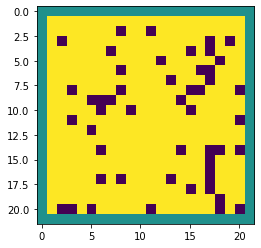

In [285]:
# use the same room and agent distribution
size = 20
n_agents = 350
orig_room = room_grid(size,n_agents)
plt.imshow(orig_room);

## All exits on one side

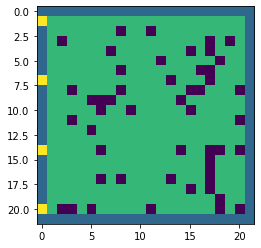

In [286]:
room = orig_room.copy()

room[1][0] = 2
room[7][0] = 2
room[14][0] = 2
room[20][0] = 2

# get coordinates of exits
all_exit_coords = [(1,0), (7,0), (14,0), (20,0)]

plt.imshow(room);

t = 0


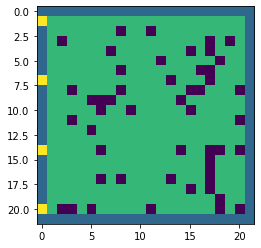

328
t = 1


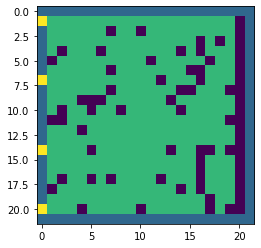

307
t = 2


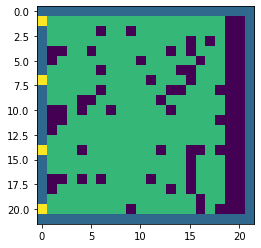

289
t = 3


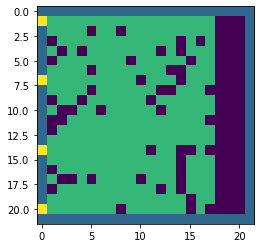

274
t = 4


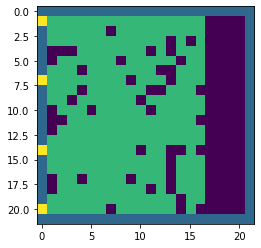

255
t = 5


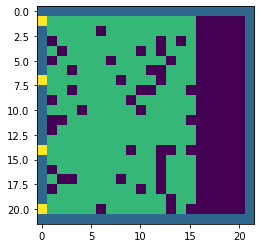

240
t = 6


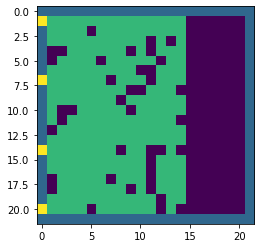

219
t = 7


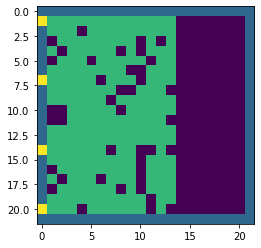

200
t = 8


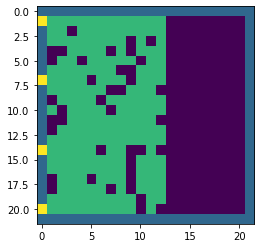

182
t = 9


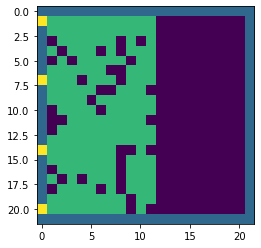

163
t = 10


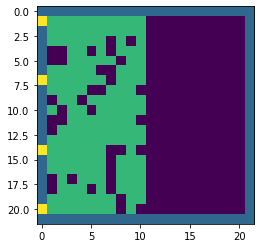

146
t = 11


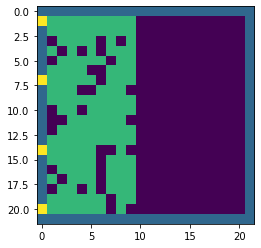

128
t = 12


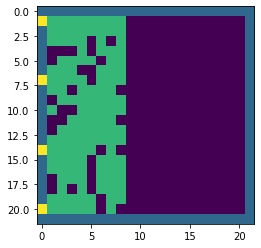

112
t = 13


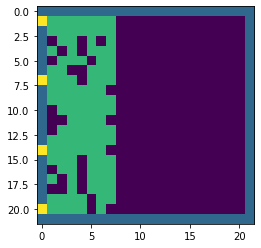

96
t = 14


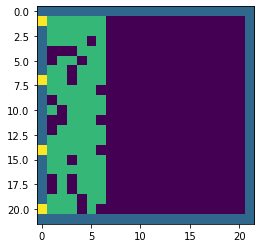

82
t = 15


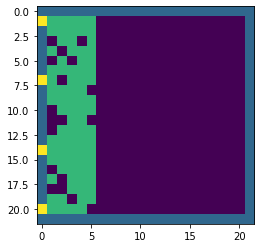

66
t = 16


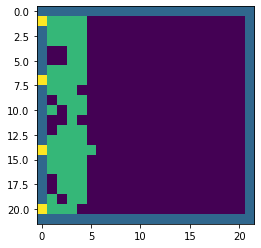

49
t = 17


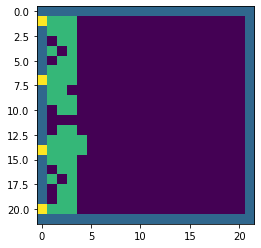

38
t = 18


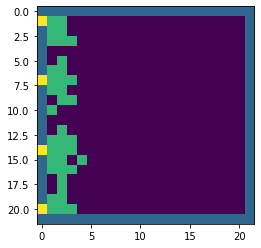

29
t = 19


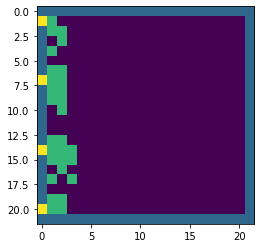

21
t = 20


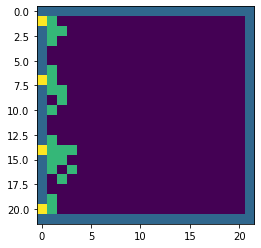

15
t = 21


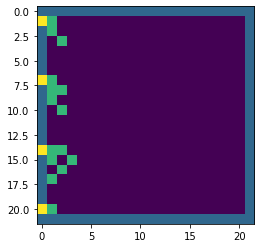

11
t = 22


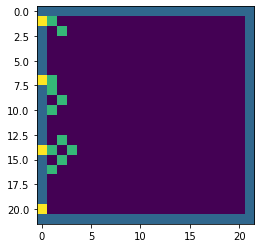

8
t = 23


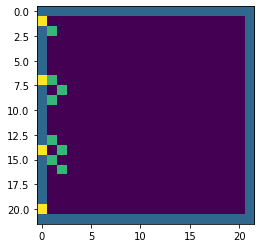

7
t = 24


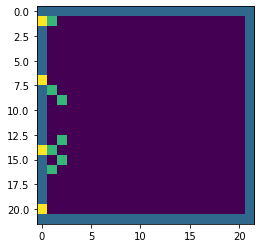

5
t = 25


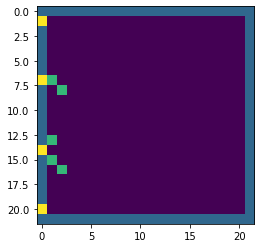

4
t = 26


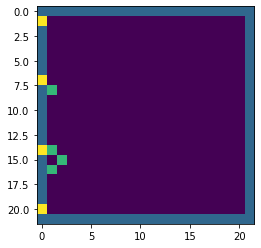

3
t = 27


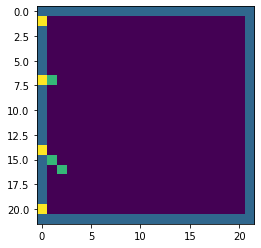

2
t = 28


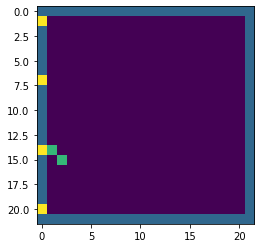

1
t = 29


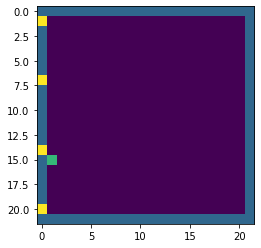

1
t = 30


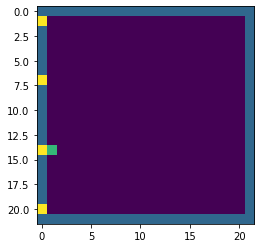

0


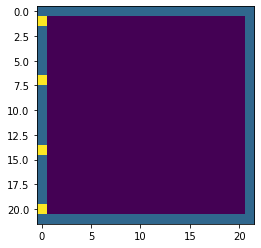

Total required iterations: 31


In [287]:
# count agents left
agents_left = len(np.where(room==1)[0])

t=0
while agents_left > 0:
    print('t =', t)
    plt.imshow(room)
    plt.show()
    
    # get all agents coordinates
    all_agent_coords = list(zip(np.where(room==1)[0], np.where(room==1)[1]))
    
    # create dictionary of agents and their respective closest exit 
    # each agent targets the closest exit to it
    agent_exit_dict = {}
    for a in all_agent_coords:
        exit_dists = []
        for e in all_exit_coords:
            exit_dist = np.linalg.norm(np.asarray(a) - np.asarray(e))
            exit_dists.append(exit_dist)
        closest_exit = all_exit_coords[exit_dists.index(min(exit_dists))]
        agent_exit_dict[a] = closest_exit
    
    # get agents that will target respective exit
    exit1_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[0]]
    exit2_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[1]] 
    exit3_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[2]]  
    exit4_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[3]]  

    
    # get distances of all agents to exits, to determine order of movement
    exit1_agent_dists = []
    for a in exit1_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[0]))
        exit1_agent_dists.append(agent_dist)

    exit2_agent_dists = []
    for a in exit2_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[1]))
        exit2_agent_dists.append(agent_dist)
        
    exit3_agent_dists = []
    for a in exit3_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[2]))
        exit3_agent_dists.append(agent_dist)
        
    exit4_agent_dists = []
    for a in exit4_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[3]))
        exit4_agent_dists.append(agent_dist)

    # # combine lists
    exit1_agent_dist_lst = [(exit1_agents[i], exit1_agent_dists[i]) for i in range(len(exit1_agents))]
    exit2_agent_dist_lst = [(exit2_agents[i], exit2_agent_dists[i]) for i in range(len(exit2_agents))]
    exit3_agent_dist_lst = [(exit3_agents[i], exit3_agent_dists[i]) for i in range(len(exit3_agents))]
    exit4_agent_dist_lst = [(exit4_agents[i], exit4_agent_dists[i]) for i in range(len(exit4_agents))]
    exit_agent_dist_lst = exit1_agent_dist_lst + exit2_agent_dist_lst + exit3_agent_dist_lst + exit4_agent_dist_lst

    # determine order of movement for agents
    exit_agent_dist_lst = sorted(exit_agent_dist_lst, key = lambda x: x[1])
    agent_order = [i[0] for i in exit_agent_dist_lst]
    
    for agent_coords in agent_order:
        agent_r = agent_coords[0]
        agent_c = agent_coords[1]
        # if agent is beside an exit
        if is_beside_exit(agent_coords, room):
            # place becomes empty (exits room)
            room[agent_r][agent_c] = -1
            continue
        # if not, it decides where to move
        else:
            move_r, move_c = decide_move(agent_coords, size, room, agent_exit_dict[agent_coords])
            room[agent_r][agent_c] = -1
            room[move_r][move_c] = 1
    agents_left = len(np.where(room==1)[0])
    print(agents_left)
    t = int(t)
    t = t + 1
plt.imshow(room)
plt.show()
print('Total required iterations:', t)

## Exits one on each side (evenly distributed)

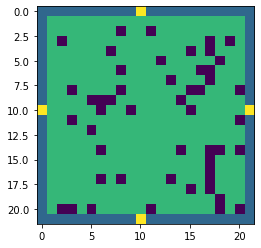

In [288]:
room = orig_room.copy()

room[0][10] = 2
room[10][0] = 2
room[21][10] = 2
room[10][21] = 2

# get coordinates of exits
all_exit_coords = [(0,10), (10,0), (21,10), (10,21)]

plt.imshow(room);

t = 0


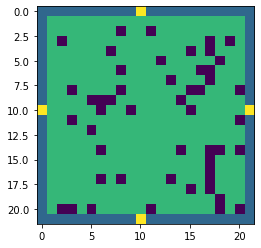

306
t = 1


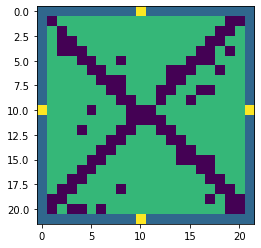

253
t = 2


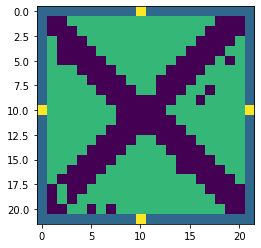

202
t = 3


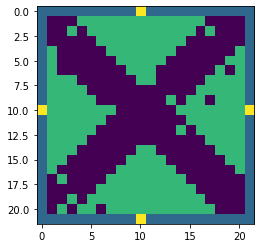

157
t = 4


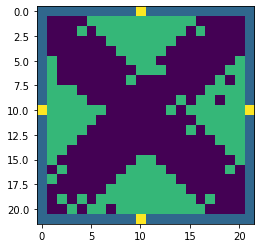

124
t = 5


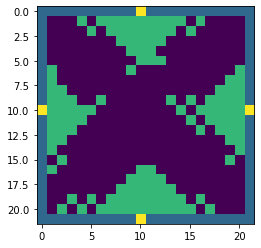

95
t = 6


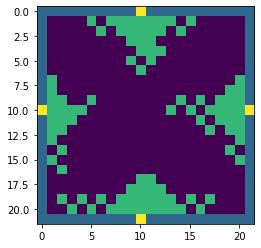

74
t = 7


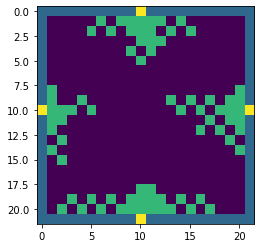

61
t = 8


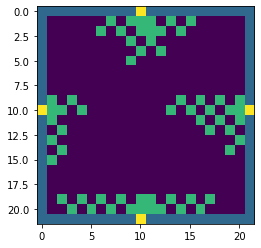

55
t = 9


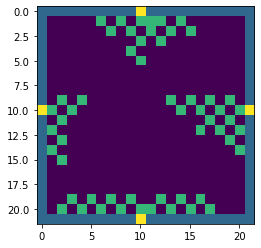

51
t = 10


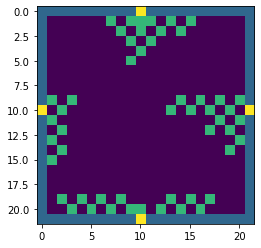

49
t = 11


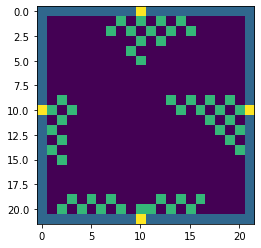

45
t = 12


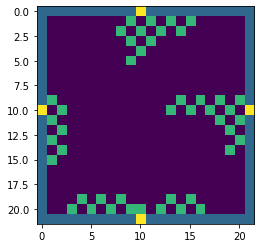

44
t = 13


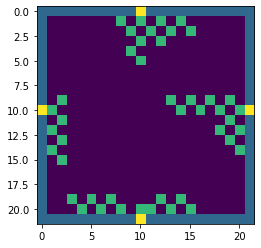

40
t = 14


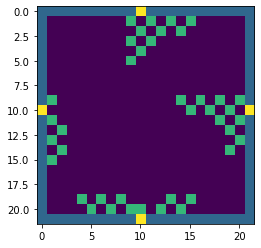

39
t = 15


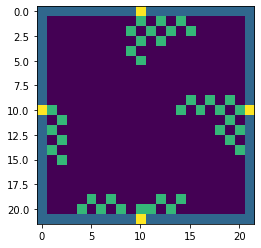

35
t = 16


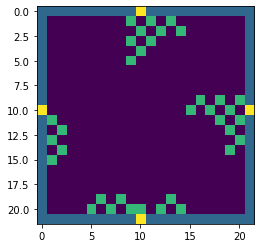

34
t = 17


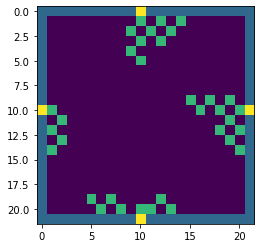

30
t = 18


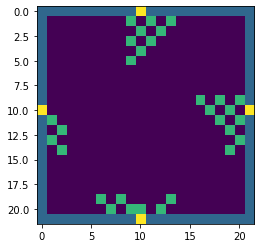

29
t = 19


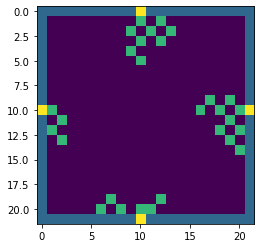

25
t = 20


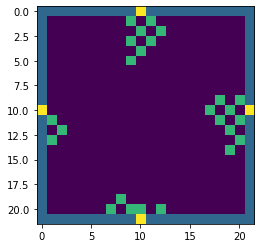

24
t = 21


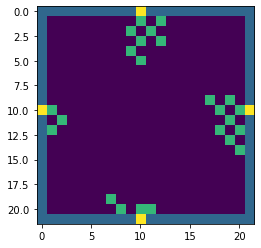

20
t = 22


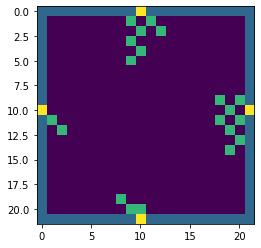

19
t = 23


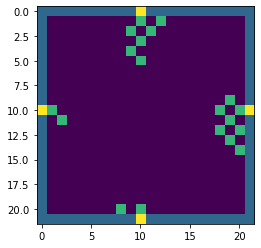

15
t = 24


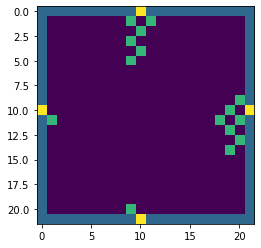

15
t = 25


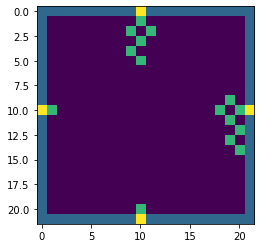

11
t = 26


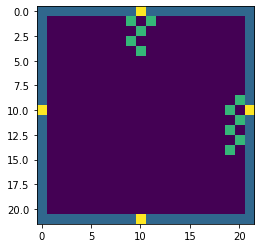

11
t = 27


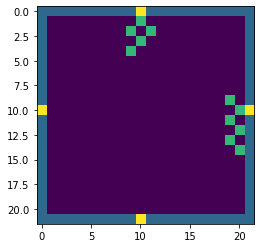

9
t = 28


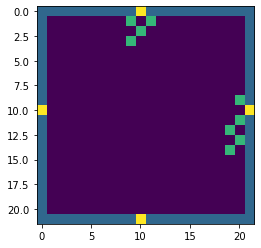

9
t = 29


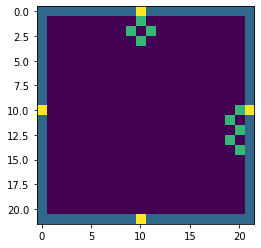

7
t = 30


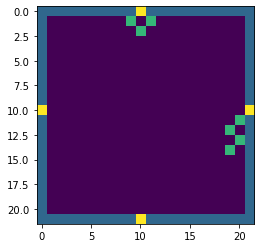

7
t = 31


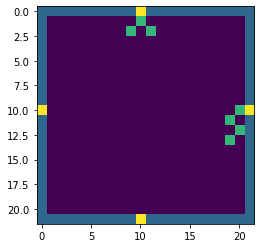

5
t = 32


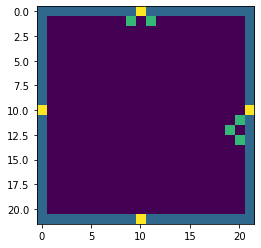

5
t = 33


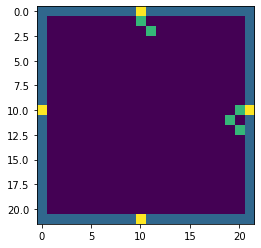

3
t = 34


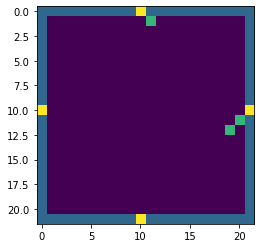

3
t = 35


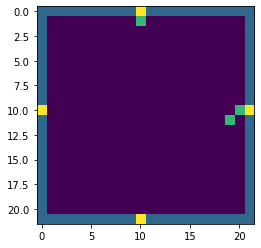

1
t = 36


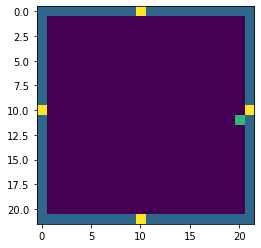

1
t = 37


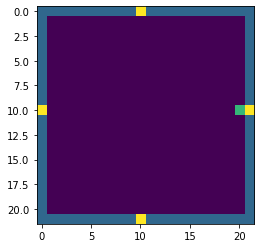

0


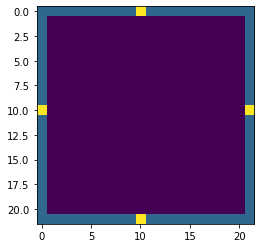

Total required iterations: 38


In [289]:
# count agents left
agents_left = len(np.where(room==1)[0])

t=0
while agents_left > 0:
    print('t =', t)
    plt.imshow(room)
    plt.show()
    
    # get all agents coordinates
    all_agent_coords = list(zip(np.where(room==1)[0], np.where(room==1)[1]))
    
    # create dictionary of agents and their respective closest exit 
    # each agent targets the closest exit to it
    agent_exit_dict = {}
    for a in all_agent_coords:
        exit_dists = []
        for e in all_exit_coords:
            exit_dist = np.linalg.norm(np.asarray(a) - np.asarray(e))
            exit_dists.append(exit_dist)
        closest_exit = all_exit_coords[exit_dists.index(min(exit_dists))]
        agent_exit_dict[a] = closest_exit
    
    # get agents that will target respective exit
    exit1_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[0]]
    exit2_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[1]] 
    exit3_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[2]]  
    exit4_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[3]]  

    
    # get distances of all agents to exits, to determine order of movement
    exit1_agent_dists = []
    for a in exit1_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[0]))
        exit1_agent_dists.append(agent_dist)

    exit2_agent_dists = []
    for a in exit2_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[1]))
        exit2_agent_dists.append(agent_dist)
        
    exit3_agent_dists = []
    for a in exit3_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[2]))
        exit3_agent_dists.append(agent_dist)
        
    exit4_agent_dists = []
    for a in exit4_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[3]))
        exit4_agent_dists.append(agent_dist)

    # # combine lists
    exit1_agent_dist_lst = [(exit1_agents[i], exit1_agent_dists[i]) for i in range(len(exit1_agents))]
    exit2_agent_dist_lst = [(exit2_agents[i], exit2_agent_dists[i]) for i in range(len(exit2_agents))]
    exit3_agent_dist_lst = [(exit3_agents[i], exit3_agent_dists[i]) for i in range(len(exit3_agents))]
    exit4_agent_dist_lst = [(exit4_agents[i], exit4_agent_dists[i]) for i in range(len(exit4_agents))]
    exit_agent_dist_lst = exit1_agent_dist_lst + exit2_agent_dist_lst + exit3_agent_dist_lst + exit4_agent_dist_lst

    # determine order of movement for agents
    exit_agent_dist_lst = sorted(exit_agent_dist_lst, key = lambda x: x[1])
    agent_order = [i[0] for i in exit_agent_dist_lst]
    
    for agent_coords in agent_order:
        agent_r = agent_coords[0]
        agent_c = agent_coords[1]
        # if agent is beside an exit
        if is_beside_exit(agent_coords, room):
            # place becomes empty (exits room)
            room[agent_r][agent_c] = -1
            continue
        # if not, it decides where to move
        else:
            move_r, move_c = decide_move(agent_coords, size, room, agent_exit_dict[agent_coords])
            room[agent_r][agent_c] = -1
            room[move_r][move_c] = 1
    agents_left = len(np.where(room==1)[0])
    print(agents_left)
    t = int(t)
    t = t + 1
plt.imshow(room)
plt.show()
print('Total required iterations:', t)

## Exits near each corner (evenly distributed)

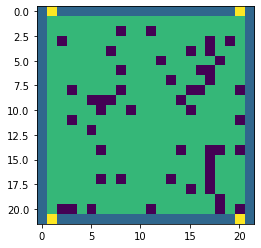

In [290]:
room = orig_room.copy()

room[0][1] = 2
room[21][1] = 2
room[0][20] = 2
room[21][20] = 2

# get coordinates of exits
all_exit_coords = [(0,1), (21,1), (0,20), (21,20)]

plt.imshow(room);

t = 0


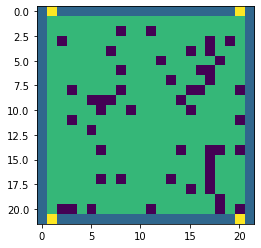

317
t = 1


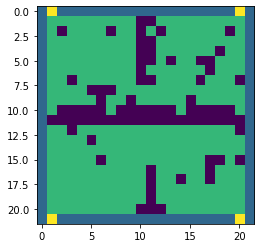

279
t = 2


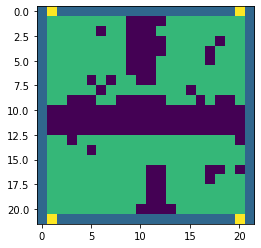

242
t = 3


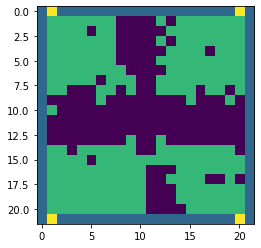

207
t = 4


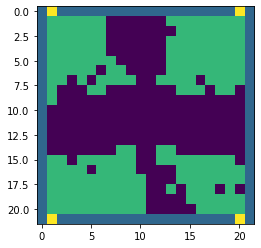

175
t = 5


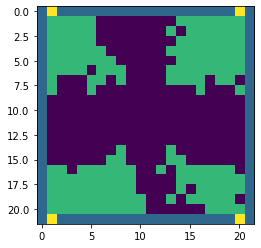

148
t = 6


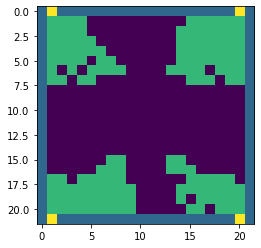

123
t = 7


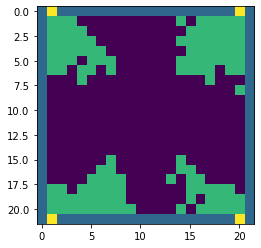

104
t = 8


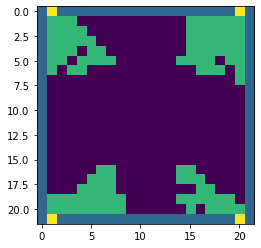

86
t = 9


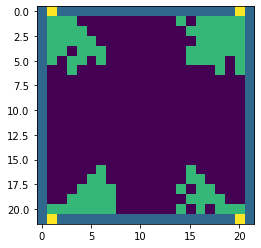

72
t = 10


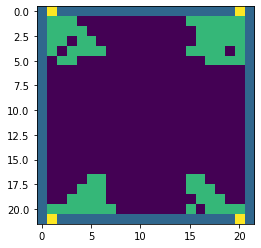

59
t = 11


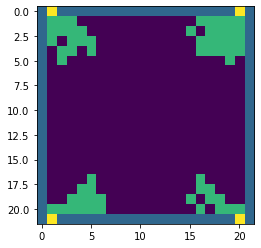

48
t = 12


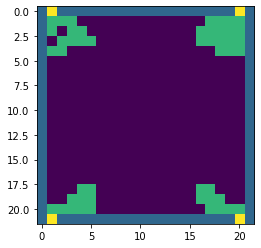

39
t = 13


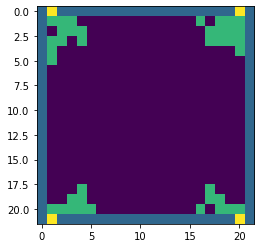

31
t = 14


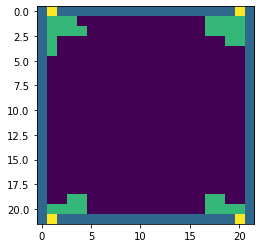

24
t = 15


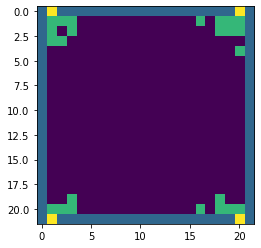

20
t = 16


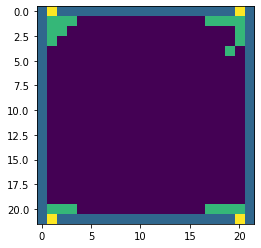

15
t = 17


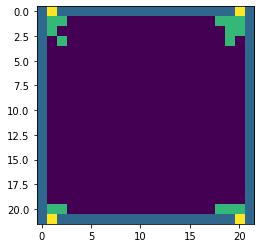

11
t = 18


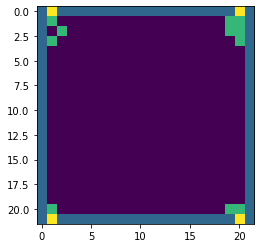

6
t = 19


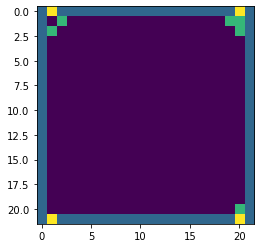

4
t = 20


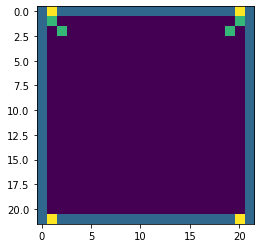

2
t = 21


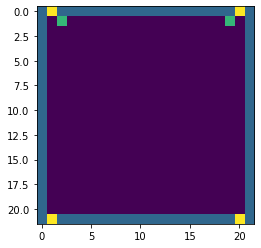

2
t = 22


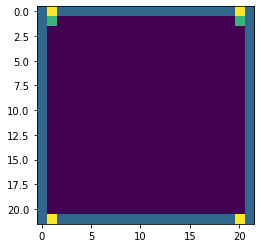

0


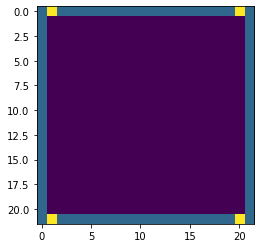

Total required iterations: 23


In [291]:
# count agents left
agents_left = len(np.where(room==1)[0])

t=0
while agents_left > 0:
    print('t =', t)
    plt.imshow(room)
    plt.show()
    
    # get all agents coordinates
    all_agent_coords = list(zip(np.where(room==1)[0], np.where(room==1)[1]))
    
    # create dictionary of agents and their respective closest exit 
    # each agent targets the closest exit to it
    agent_exit_dict = {}
    for a in all_agent_coords:
        exit_dists = []
        for e in all_exit_coords:
            exit_dist = np.linalg.norm(np.asarray(a) - np.asarray(e))
            exit_dists.append(exit_dist)
        closest_exit = all_exit_coords[exit_dists.index(min(exit_dists))]
        agent_exit_dict[a] = closest_exit
    
    # get agents that will target respective exit
    exit1_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[0]]
    exit2_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[1]] 
    exit3_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[2]]  
    exit4_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[3]]  

    
    # get distances of all agents to exits, to determine order of movement
    exit1_agent_dists = []
    for a in exit1_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[0]))
        exit1_agent_dists.append(agent_dist)

    exit2_agent_dists = []
    for a in exit2_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[1]))
        exit2_agent_dists.append(agent_dist)
        
    exit3_agent_dists = []
    for a in exit3_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[2]))
        exit3_agent_dists.append(agent_dist)
        
    exit4_agent_dists = []
    for a in exit4_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[3]))
        exit4_agent_dists.append(agent_dist)

    # # combine lists
    exit1_agent_dist_lst = [(exit1_agents[i], exit1_agent_dists[i]) for i in range(len(exit1_agents))]
    exit2_agent_dist_lst = [(exit2_agents[i], exit2_agent_dists[i]) for i in range(len(exit2_agents))]
    exit3_agent_dist_lst = [(exit3_agents[i], exit3_agent_dists[i]) for i in range(len(exit3_agents))]
    exit4_agent_dist_lst = [(exit4_agents[i], exit4_agent_dists[i]) for i in range(len(exit4_agents))]
    exit_agent_dist_lst = exit1_agent_dist_lst + exit2_agent_dist_lst + exit3_agent_dist_lst + exit4_agent_dist_lst

    # determine order of movement for agents
    exit_agent_dist_lst = sorted(exit_agent_dist_lst, key = lambda x: x[1])
    agent_order = [i[0] for i in exit_agent_dist_lst]
    
    for agent_coords in agent_order:
        agent_r = agent_coords[0]
        agent_c = agent_coords[1]
        # if agent is beside an exit
        if is_beside_exit(agent_coords, room):
            # place becomes empty (exits room)
            room[agent_r][agent_c] = -1
            continue
        # if not, it decides where to move
        else:
            move_r, move_c = decide_move(agent_coords, size, room, agent_exit_dict[agent_coords])
            room[agent_r][agent_c] = -1
            room[move_r][move_c] = 1
    agents_left = len(np.where(room==1)[0])
    print(agents_left)
    t = int(t)
    t = t + 1
plt.imshow(room)
plt.show()
print('Total required iterations:', t)

## Exits next to each other around 1 corner

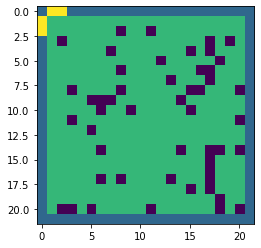

In [292]:
room = orig_room.copy()

room[0][1] = 2
room[0][2] = 2
room[1][0] = 2
room[2][0] = 2

# get coordinates of exits
all_exit_coords = [(0,1), (0,2), (1,0), (2,0)]

plt.imshow(room);

t = 0


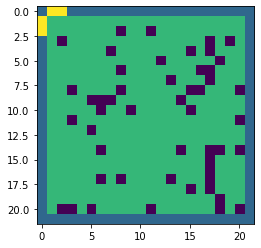

330
t = 1


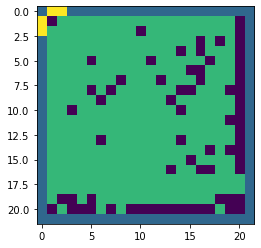

309
t = 2


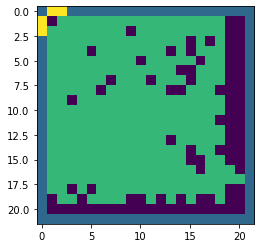

287
t = 3


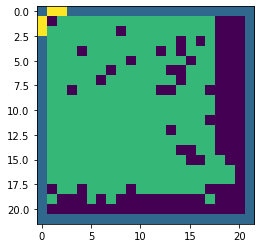

268
t = 4


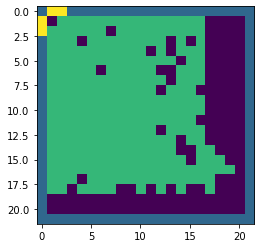

247
t = 5


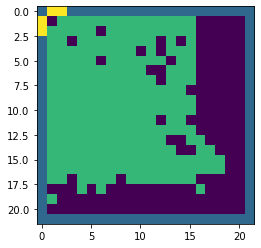

228
t = 6


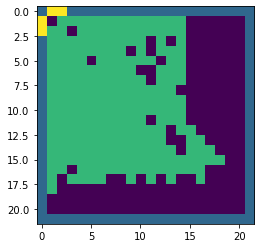

210
t = 7


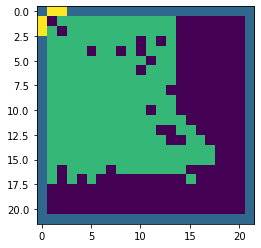

194
t = 8


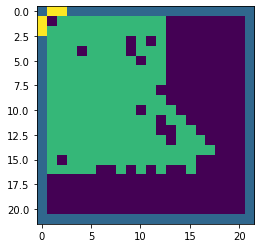

178
t = 9


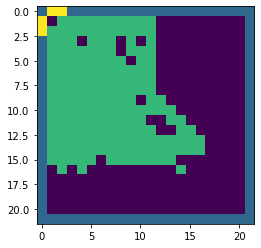

164
t = 10


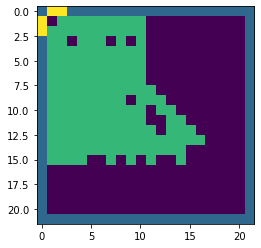

150
t = 11


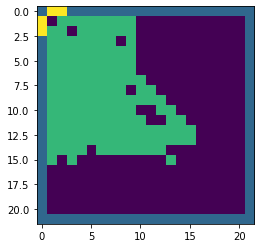

136
t = 12


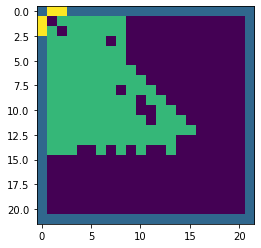

126
t = 13


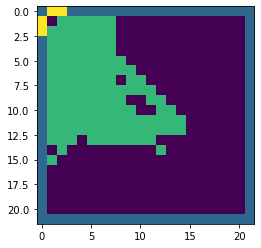

115
t = 14


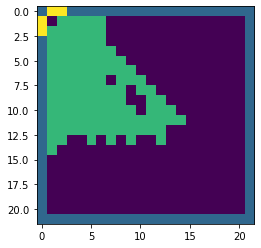

105
t = 15


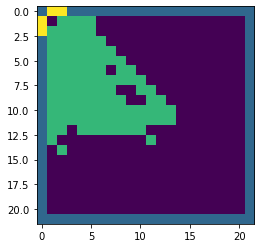

96
t = 16


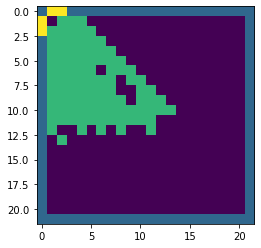

89
t = 17


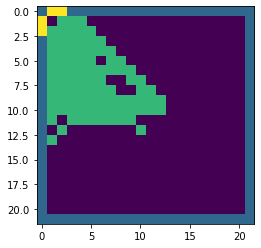

82
t = 18


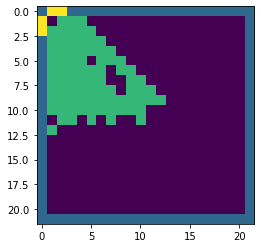

75
t = 19


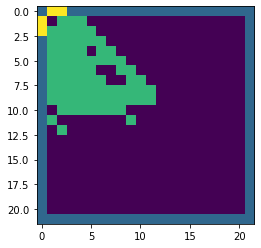

69
t = 20


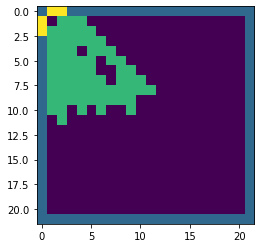

63
t = 21


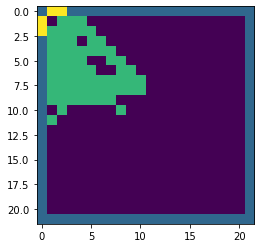

57
t = 22


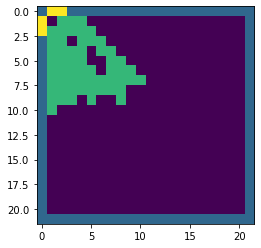

51
t = 23


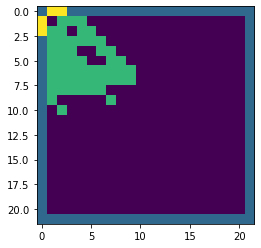

45
t = 24


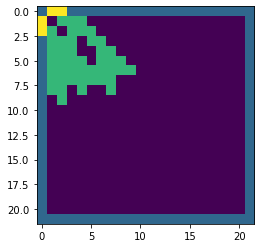

41
t = 25


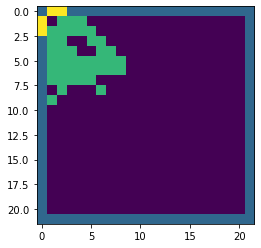

36
t = 26


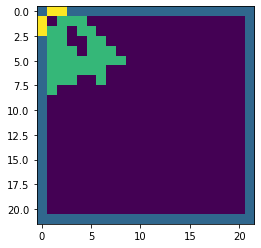

32
t = 27


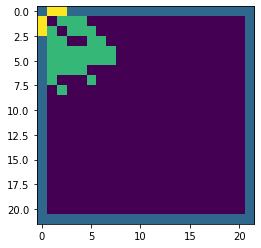

28
t = 28


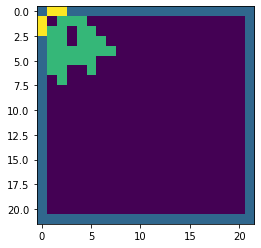

25
t = 29


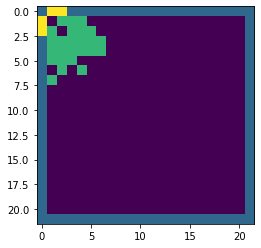

22
t = 30


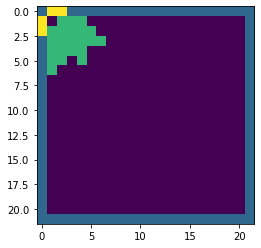

18
t = 31


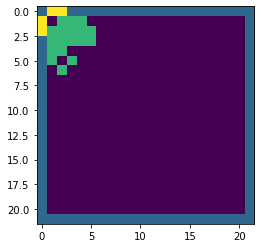

14
t = 32


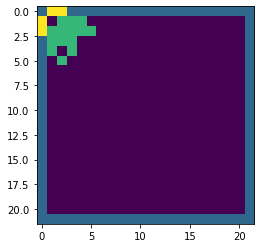

11
t = 33


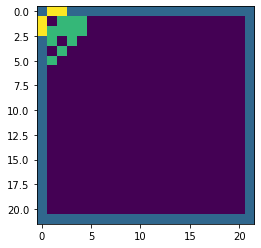

8
t = 34


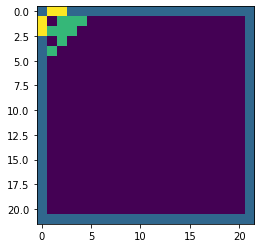

6
t = 35


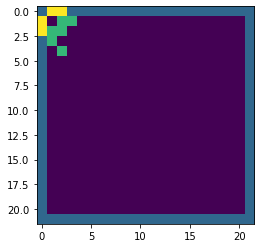

4
t = 36


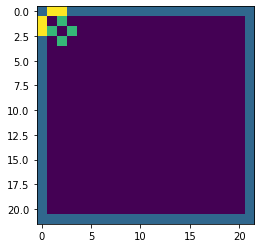

2
t = 37


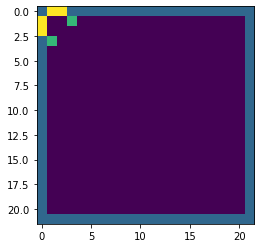

2
t = 38


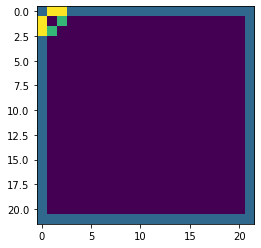

0


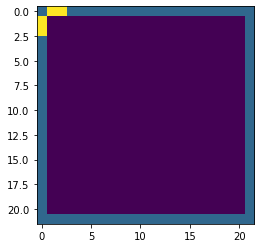

Total required iterations: 39


In [293]:
# count agents left
agents_left = len(np.where(room==1)[0])

t=0
while agents_left > 0:
    print('t =', t)
    plt.imshow(room)
    plt.show()
    
    # get all agents coordinates
    all_agent_coords = list(zip(np.where(room==1)[0], np.where(room==1)[1]))
    
    # create dictionary of agents and their respective closest exit 
    # each agent targets the closest exit to it
    agent_exit_dict = {}
    for a in all_agent_coords:
        exit_dists = []
        for e in all_exit_coords:
            exit_dist = np.linalg.norm(np.asarray(a) - np.asarray(e))
            exit_dists.append(exit_dist)
        closest_exit = all_exit_coords[exit_dists.index(min(exit_dists))]
        agent_exit_dict[a] = closest_exit
    
    # get agents that will target respective exit
    exit1_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[0]]
    exit2_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[1]] 
    exit3_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[2]]  
    exit4_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[3]]  

    
    # get distances of all agents to exits, to determine order of movement
    exit1_agent_dists = []
    for a in exit1_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[0]))
        exit1_agent_dists.append(agent_dist)

    exit2_agent_dists = []
    for a in exit2_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[1]))
        exit2_agent_dists.append(agent_dist)
        
    exit3_agent_dists = []
    for a in exit3_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[2]))
        exit3_agent_dists.append(agent_dist)
        
    exit4_agent_dists = []
    for a in exit4_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[3]))
        exit4_agent_dists.append(agent_dist)

    # # combine lists
    exit1_agent_dist_lst = [(exit1_agents[i], exit1_agent_dists[i]) for i in range(len(exit1_agents))]
    exit2_agent_dist_lst = [(exit2_agents[i], exit2_agent_dists[i]) for i in range(len(exit2_agents))]
    exit3_agent_dist_lst = [(exit3_agents[i], exit3_agent_dists[i]) for i in range(len(exit3_agents))]
    exit4_agent_dist_lst = [(exit4_agents[i], exit4_agent_dists[i]) for i in range(len(exit4_agents))]
    exit_agent_dist_lst = exit1_agent_dist_lst + exit2_agent_dist_lst + exit3_agent_dist_lst + exit4_agent_dist_lst

    # determine order of movement for agents
    exit_agent_dist_lst = sorted(exit_agent_dist_lst, key = lambda x: x[1])
    agent_order = [i[0] for i in exit_agent_dist_lst]
    
    for agent_coords in agent_order:
        agent_r = agent_coords[0]
        agent_c = agent_coords[1]
        # if agent is beside an exit
        if is_beside_exit(agent_coords, room):
            # place becomes empty (exits room)
            room[agent_r][agent_c] = -1
            continue
        # if not, it decides where to move
        else:
            move_r, move_c = decide_move(agent_coords, size, room, agent_exit_dict[agent_coords])
            room[agent_r][agent_c] = -1
            room[move_r][move_c] = 1
    agents_left = len(np.where(room==1)[0])
    print(agents_left)
    t = int(t)
    t = t + 1
plt.imshow(room)
plt.show()
print('Total required iterations:', t)

## Exits next to each other on 1 side

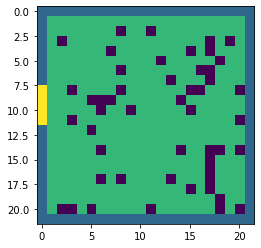

In [294]:
room = orig_room.copy()

room[9][0] = 2
room[10][0] = 2
room[11][0] = 2
room[8][0] = 2

# get coordinates of exits
all_exit_coords = [(9,0), (10,0), (11,0), (8,0)]

plt.imshow(room);

t = 0


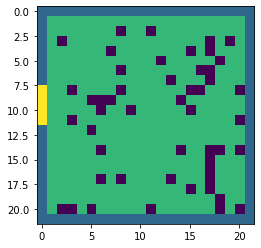

331
t = 1


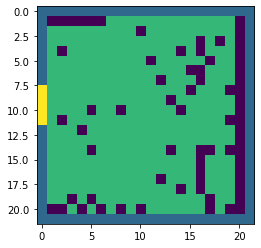

306
t = 2


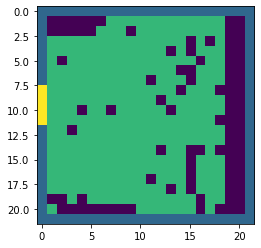

284
t = 3


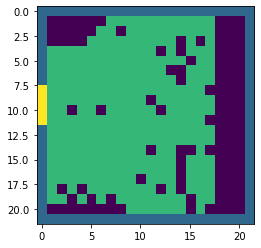

260
t = 4


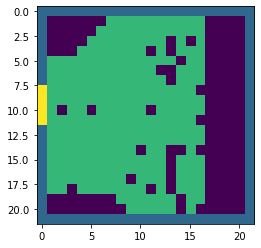

236
t = 5


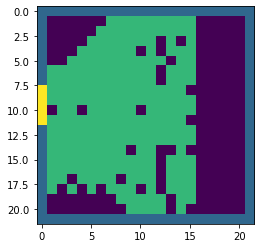

215
t = 6


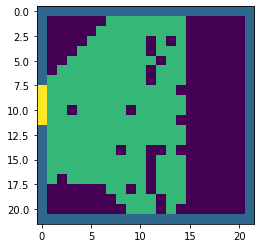

195
t = 7


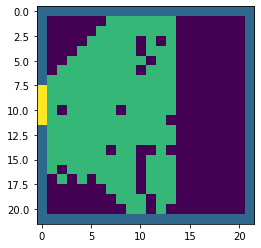

175
t = 8


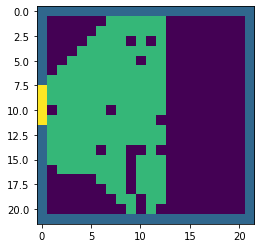

158
t = 9


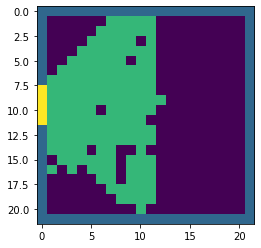

142
t = 10


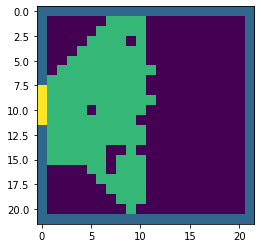

126
t = 11


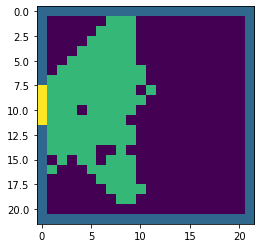

110
t = 12


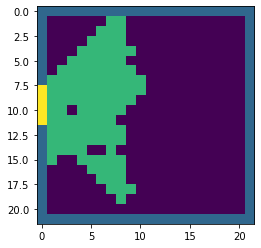

96
t = 13


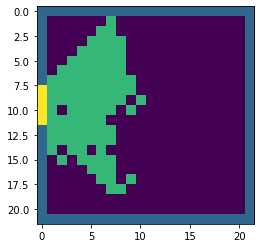

83
t = 14


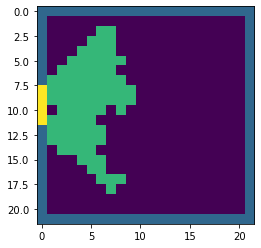

71
t = 15


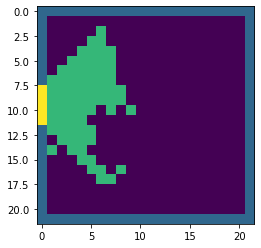

61
t = 16


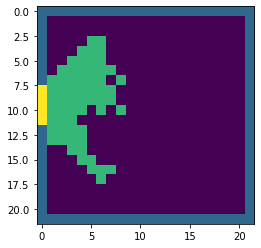

52
t = 17


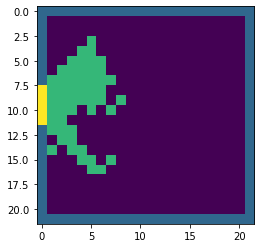

44
t = 18


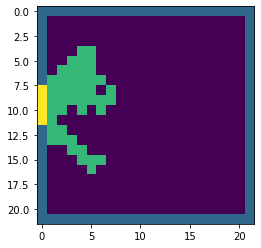

39
t = 19


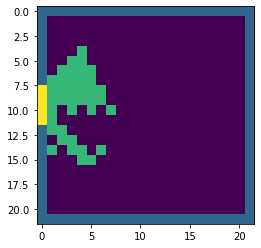

33
t = 20


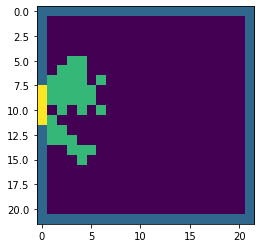

29
t = 21


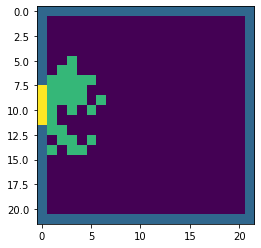

24
t = 22


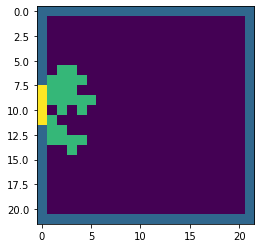

21
t = 23


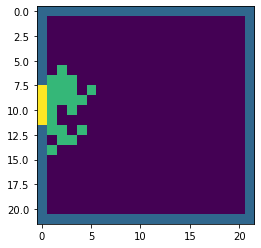

16
t = 24


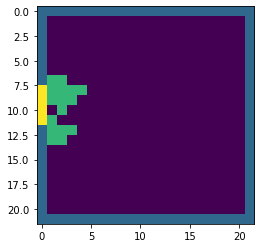

13
t = 25


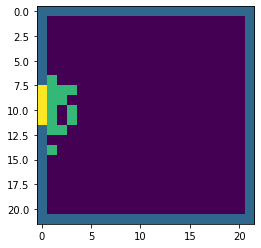

9
t = 26


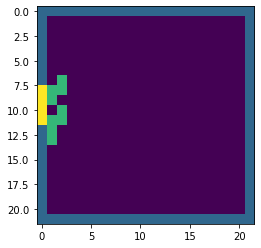

6
t = 27


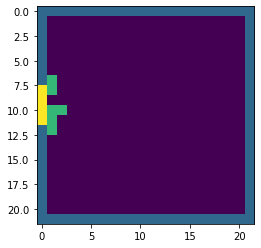

3
t = 28


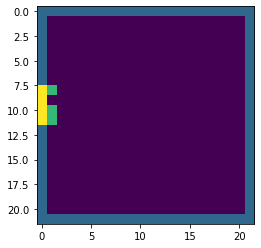

0


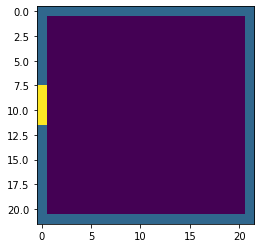

Total required iterations: 29


In [295]:
# count agents left
agents_left = len(np.where(room==1)[0])

t=0
while agents_left > 0:
    print('t =', t)
    plt.imshow(room)
    plt.show()
    
    # get all agents coordinates
    all_agent_coords = list(zip(np.where(room==1)[0], np.where(room==1)[1]))
    
    # create dictionary of agents and their respective closest exit 
    # each agent targets the closest exit to it
    agent_exit_dict = {}
    for a in all_agent_coords:
        exit_dists = []
        for e in all_exit_coords:
            exit_dist = np.linalg.norm(np.asarray(a) - np.asarray(e))
            exit_dists.append(exit_dist)
        closest_exit = all_exit_coords[exit_dists.index(min(exit_dists))]
        agent_exit_dict[a] = closest_exit
    
    # get agents that will target respective exit
    exit1_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[0]]
    exit2_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[1]] 
    exit3_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[2]]  
    exit4_agents = [k for k,v in agent_exit_dict.items() if v == all_exit_coords[3]]  

    
    # get distances of all agents to exits, to determine order of movement
    exit1_agent_dists = []
    for a in exit1_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[0]))
        exit1_agent_dists.append(agent_dist)

    exit2_agent_dists = []
    for a in exit2_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[1]))
        exit2_agent_dists.append(agent_dist)
        
    exit3_agent_dists = []
    for a in exit3_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[2]))
        exit3_agent_dists.append(agent_dist)
        
    exit4_agent_dists = []
    for a in exit4_agents:
        agent_dist = np.linalg.norm(np.asarray(a) 
                                    - np.asarray(all_exit_coords[3]))
        exit4_agent_dists.append(agent_dist)

    # # combine lists
    exit1_agent_dist_lst = [(exit1_agents[i], exit1_agent_dists[i]) for i in range(len(exit1_agents))]
    exit2_agent_dist_lst = [(exit2_agents[i], exit2_agent_dists[i]) for i in range(len(exit2_agents))]
    exit3_agent_dist_lst = [(exit3_agents[i], exit3_agent_dists[i]) for i in range(len(exit3_agents))]
    exit4_agent_dist_lst = [(exit4_agents[i], exit4_agent_dists[i]) for i in range(len(exit4_agents))]
    exit_agent_dist_lst = exit1_agent_dist_lst + exit2_agent_dist_lst + exit3_agent_dist_lst + exit4_agent_dist_lst

    # determine order of movement for agents
    exit_agent_dist_lst = sorted(exit_agent_dist_lst, key = lambda x: x[1])
    agent_order = [i[0] for i in exit_agent_dist_lst]
    
    for agent_coords in agent_order:
        agent_r = agent_coords[0]
        agent_c = agent_coords[1]
        # if agent is beside an exit
        if is_beside_exit(agent_coords, room):
            # place becomes empty (exits room)
            room[agent_r][agent_c] = -1
            continue
        # if not, it decides where to move
        else:
            move_r, move_c = decide_move(agent_coords, size, room, agent_exit_dict[agent_coords])
            room[agent_r][agent_c] = -1
            room[move_r][move_c] = 1
    agents_left = len(np.where(room==1)[0])
    print(agents_left)
    t = int(t)
    t = t + 1
plt.imshow(room)
plt.show()
print('Total required iterations:', t)

From the experiments above, we checked how fast agents can leave the room with the same positions of agents and the same number as well. It appears that the configuration that requires the least amount of time for all agents to evacuate is when exits are distributed evenly with 1 on each corner. This configuration allowed all agents to exit within 23 iterations only. The next ideal was when all exits were next to each other on one side, as if it were one large exit. This configuration was completed after 29 iterations. The next best was when all exits were on one side, but spaced apart, which finished in 31 iterations. Interestingly, the second to the worst configuration was when there was one exit per side, and evenly spaced apart. This took 38 iterations to complete. Finally, the least ideal configuration was when exits were placed around a single corner, which took 39 iterations to complete.

# Limitations

- This model does not account for foresight, where an individual may indeed be closer to one exit compared to another, but will anticipate that it will soon be overcrowded because there are many agents surrounding it.
- This model also does not capture the social aspect of the situation. In a real-world scenario, individuals may communicate with each other and begin to organize themselves based on information passed on. In an evacuation scenario, there may be people communicating which exit would be best or is least congested.